<a href="https://colab.research.google.com/github/AndreiAf02/Transfer_Learning_Extension/blob/main/Bank_Marketing_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Bank Marketing - Predicting Previous Term Deposit Outcomes from current Term Deposit Outcomes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter



from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
# !pip install pytorch-tabnet

# from pytorch_tabnet.tab_model import TabNetClassifier
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



## Data taken from the UCI Machine Learning repository [here](https://doi.org/10.24432/C5K306):

In [2]:
pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
bank_marketing = fetch_ucirepo(id=222)

# data (as pandas dataframes)
X = bank_marketing.data.features
y = bank_marketing.data.targets

# metadata
print(bank_marketing.metadata)

# variable information
print(bank_marketing.variables)

{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'ID': 277, 'type': 'NATIVE', 'title': 'A data-driven approach to predict the s

In [4]:
X

age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
3       47   blue-collar   married        NaN      no     1506     yes   no   
4       33           NaN    single        NaN      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
45206   51    technician   married   tertiary      no      825      no   no   
45207   71       retired  divorced    primary      no     1729      no   no   
45208   72       retired   married  secondary      no     5715      no   no   
45209   57   blue-collar   married  secondary      no      668      no   no   
45210   37  entrepreneur   married  secondary      no     2971      no   no   

         contact  day_of_week month  duration  campaign  pdays  previous  \
0            NaN            5   may       261         1     -1         0   
1            NaN            5   may       151         1     -1         0   
2            NaN            5   may        76         1     -1         0   
3            NaN            5   may        92         1     -1         0   
4            NaN            5   may       198         1     -1         0   
...          ...          ...   ...       ...       ...    ...       ...   
45206   cellular           17   nov       977         3     -1         0   
45207   cellular           17   nov       456         2     -1         0   
45208   cellular           17   nov      1127         5    184         3   
45209  telephone           17   nov       508         4     -1         0   
45210   cellular           17   nov       361         2    188        11   

      poutcome  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  
...        ...  
45206      NaN  
45207      NaN  
45208  success  
45209      NaN  
45210    other  

[45211 rows x 16 columns]

In [5]:
X.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day_of_week', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome'],
      dtype='object')

In [6]:
X_numeric = pd.DataFrame()

## Age:
X_numeric['age'] = X['age']

## Working class:
X_numeric['job'] = X['job']
X_numeric['job'].replace(['management', 'technician', 'entrepreneur', 'blue-collar', 'retired',
 'admin.', 'services', 'self-employed', 'unemployed', 'housemaid', 'student'],
                                [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], inplace=True)


## Marital:
X_numeric['marital'] = X['marital']
X_numeric['marital'].replace(['single', 'married', 'divorced'],
                                    [0, 1, 2], inplace=True)

## Education:
X_numeric['education'] = X['education']
X_numeric['education'].replace(['primary', 'secondary', 'tertiary'],
                                    [0, 1, 2], inplace=True)


## Credit Default:
X_numeric['default'] = X['default']
X_numeric['default'].replace(['no', 'yes'],
                                    [0, 1], inplace=True)



## Balance:
X_numeric['balance'] = X['balance']


## Housing:
X_numeric['housing'] = X['housing']
X_numeric['housing'].replace(['no', 'yes'],
                                    [0, 1], inplace=True)


## Loan:
X_numeric['loan'] = X['loan']
X_numeric['loan'].replace(['no', 'yes'],
                                    [0, 1], inplace=True)



## Contact:
X_numeric['contact'] = X['contact']
X_numeric['contact'].replace([np.nan, 'cellular', 'telephone'],
                                    [0, 1, 2], inplace=True)


## Day of week:
X_numeric['day_of_week'] = X['day_of_week']


## Month:
X_numeric['month'] = X['month']
X_numeric['month'].replace(['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
                                    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], inplace=True)


## Duration:
X_numeric['duration'] = X['duration']

## Campaign:
X_numeric['campaign'] = X['campaign']


## Pdays:
X_numeric['pdays'] = X['pdays']
# X_numeric['pdays'].replace([-1], [np.nan], inplace=True)

## Previous:
X_numeric['previous'] = X['previous']

# ## Poutcome:
# X_numeric['poutcome'] = X['poutcome']
# X_numeric['poutcome'].replace([np.nan, 'failure', 'success', 'other'],
#                                     [np.nan, 0, 1, 0], inplace=True)  ## For training the source data, we drop all datapoints without previous interaction


## Poutcome (new target predictor Y):
X_numeric['Y'] = X['poutcome']
X_numeric['Y'].replace([np.nan, 'failure', 'success', 'other'],
                                    [np.nan, 0, 1, 0], inplace=True)  ## For training the source data, we drop all datapoints without previous interaction





## ---------------------- Response variable y: --------------------

## Income:
y_numeric = pd.DataFrame()
y_numeric['Y2'] = y['y']
y_numeric['Y2'].replace(['no', 'yes'],
                          [0, 1], inplace=True)

X_numeric


<ipython-input-6-ff88b314d7d9>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_numeric['job'].replace(['management', 'technician', 'entrepreneur', 'blue-collar', 'retired',
<ipython-input-6-ff88b314d7d9>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_numeric['job'].replace(['management', 'tec

age  job  marital  education  default  balance  housing  loan  contact  \
0       58  0.0        1        2.0        0     2143        1     0        0   
1       44  1.0        0        1.0        0       29        1     0        0   
2       33  2.0        1        1.0        0        2        1     1        0   
3       47  3.0        1        NaN        0     1506        1     0        0   
4       33  NaN        0        NaN        0        1        0     0        0   
...    ...  ...      ...        ...      ...      ...      ...   ...      ...   
45206   51  1.0        1        2.0        0      825        0     0        1   
45207   71  4.0        2        0.0        0     1729        0     0        1   
45208   72  4.0        1        1.0        0     5715        0     0        1   
45209   57  3.0        1        1.0        0      668        0     0        2   
45210   37  2.0        1        1.0        0     2971        0     0        1   

       day_of_week  month  duration  campaign  pdays  previous    Y  
0                5      4       261         1     -1         0  NaN  
1                5      4       151         1     -1         0  NaN  
2                5      4        76         1     -1         0  NaN  
3                5      4        92         1     -1         0  NaN  
4                5      4       198         1     -1         0  NaN  
...            ...    ...       ...       ...    ...       ...  ...  
45206           17     10       977         3     -1         0  NaN  
45207           17     10       456         2     -1         0  NaN  
45208           17     10      1127         5    184         3  1.0  
45209           17     10       508         4     -1         0  NaN  
45210           17     10       361         2    188        11  0.0  

[45211 rows x 16 columns]

In [7]:
y_numeric.value_counts()

Y2
0     39922
1      5289
Name: count, dtype: int64

In [8]:
X['poutcome'].value_counts()

poutcome
failure    4901
other      1840
success    1511
Name: count, dtype: int64

In [9]:
X_numeric['Y'].value_counts()

Y
0.0    6741
1.0    1511
Name: count, dtype: int64

In [10]:
X_numeric['Y']

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
45206    NaN
45207    NaN
45208    1.0
45209    NaN
45210    0.0
Name: Y, Length: 45211, dtype: float64

In [11]:
data_total = pd.concat([X_numeric, y_numeric], axis=1)

data_total

age  job  marital  education  default  balance  housing  loan  contact  \
0       58  0.0        1        2.0        0     2143        1     0        0   
1       44  1.0        0        1.0        0       29        1     0        0   
2       33  2.0        1        1.0        0        2        1     1        0   
3       47  3.0        1        NaN        0     1506        1     0        0   
4       33  NaN        0        NaN        0        1        0     0        0   
...    ...  ...      ...        ...      ...      ...      ...   ...      ...   
45206   51  1.0        1        2.0        0      825        0     0        1   
45207   71  4.0        2        0.0        0     1729        0     0        1   
45208   72  4.0        1        1.0        0     5715        0     0        1   
45209   57  3.0        1        1.0        0      668        0     0        2   
45210   37  2.0        1        1.0        0     2971        0     0        1   

       day_of_week  month  duration  campaign  pdays  previous    Y  Y2  
0                5      4       261         1     -1         0  NaN   0  
1                5      4       151         1     -1         0  NaN   0  
2                5      4        76         1     -1         0  NaN   0  
3                5      4        92         1     -1         0  NaN   0  
4                5      4       198         1     -1         0  NaN   0  
...            ...    ...       ...       ...    ...       ...  ...  ..  
45206           17     10       977         3     -1         0  NaN   1  
45207           17     10       456         2     -1         0  NaN   1  
45208           17     10      1127         5    184         3  1.0   1  
45209           17     10       508         4     -1         0  NaN   0  
45210           17     10       361         2    188        11  0.0   0  

[45211 rows x 17 columns]

In [12]:
data_total['Y2'].value_counts()

Y2
0    39922
1     5289
Name: count, dtype: int64

In [13]:
data_total['Y'].value_counts()

Y
0.0    6741
1.0    1511
Name: count, dtype: int64

In [14]:
X = data_total.iloc[:, :-2]
y = data_total.iloc[:,-2]
y2 = data_total.iloc[:,-1]
y

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
45206    NaN
45207    NaN
45208    1.0
45209    NaN
45210    0.0
Name: Y, Length: 45211, dtype: float64

In [15]:
y2

0        0
1        0
2        0
3        0
4        0
        ..
45206    1
45207    1
45208    1
45209    0
45210    0
Name: Y2, Length: 45211, dtype: int64

In [16]:
X

age  job  marital  education  default  balance  housing  loan  contact  \
0       58  0.0        1        2.0        0     2143        1     0        0   
1       44  1.0        0        1.0        0       29        1     0        0   
2       33  2.0        1        1.0        0        2        1     1        0   
3       47  3.0        1        NaN        0     1506        1     0        0   
4       33  NaN        0        NaN        0        1        0     0        0   
...    ...  ...      ...        ...      ...      ...      ...   ...      ...   
45206   51  1.0        1        2.0        0      825        0     0        1   
45207   71  4.0        2        0.0        0     1729        0     0        1   
45208   72  4.0        1        1.0        0     5715        0     0        1   
45209   57  3.0        1        1.0        0      668        0     0        2   
45210   37  2.0        1        1.0        0     2971        0     0        1   

       day_of_week  month  duration  campaign  pdays  previous  
0                5      4       261         1     -1         0  
1                5      4       151         1     -1         0  
2                5      4        76         1     -1         0  
3                5      4        92         1     -1         0  
4                5      4       198         1     -1         0  
...            ...    ...       ...       ...    ...       ...  
45206           17     10       977         3     -1         0  
45207           17     10       456         2     -1         0  
45208           17     10      1127         5    184         3  
45209           17     10       508         4     -1         0  
45210           17     10       361         2    188        11  

[45211 rows x 15 columns]

In [17]:
y.value_counts()

Y
0.0    6741
1.0    1511
Name: count, dtype: int64

In [18]:
y2.value_counts()

Y2
0    39922
1     5289
Name: count, dtype: int64

In [20]:
## Scaling the predictive data

scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled)

In [21]:
data2 = pd.concat([X_scaled, y, y2], axis=1)
data2

0    1    2    3    4         5    6    7    8         9  \
0      0.519481  0.0  0.5  1.0  0.0  0.092259  1.0  0.0  0.0  0.133333   
1      0.337662  0.1  0.0  0.5  0.0  0.073067  1.0  0.0  0.0  0.133333   
2      0.194805  0.2  0.5  0.5  0.0  0.072822  1.0  1.0  0.0  0.133333   
3      0.376623  0.3  0.5  NaN  0.0  0.086476  1.0  0.0  0.0  0.133333   
4      0.194805  NaN  0.0  NaN  0.0  0.072812  0.0  0.0  0.0  0.133333   
...         ...  ...  ...  ...  ...       ...  ...  ...  ...       ...   
45206  0.428571  0.1  0.5  1.0  0.0  0.080293  0.0  0.0  0.5  0.533333   
45207  0.688312  0.4  1.0  0.0  0.0  0.088501  0.0  0.0  0.5  0.533333   
45208  0.701299  0.4  0.5  0.5  0.0  0.124689  0.0  0.0  0.5  0.533333   
45209  0.506494  0.3  0.5  0.5  0.0  0.078868  0.0  0.0  1.0  0.533333   
45210  0.246753  0.2  0.5  0.5  0.0  0.099777  0.0  0.0  0.5  0.533333   

             10        11        12        13        14    Y  Y2  
0      0.363636  0.053070  0.000000  0.000000  0.000000  NaN   0  
1      0.363636  0.030704  0.000000  0.000000  0.000000  NaN   0  
2      0.363636  0.015453  0.000000  0.000000  0.000000  NaN   0  
3      0.363636  0.018707  0.000000  0.000000  0.000000  NaN   0  
4      0.363636  0.040260  0.000000  0.000000  0.000000  NaN   0  
...         ...       ...       ...       ...       ...  ...  ..  
45206  0.909091  0.198658  0.032258  0.000000  0.000000  NaN   1  
45207  0.909091  0.092721  0.016129  0.000000  0.000000  NaN   1  
45208  0.909091  0.229158  0.064516  0.212156  0.010909  1.0   1  
45209  0.909091  0.103294  0.048387  0.000000  0.000000  NaN   0  
45210  0.909091  0.073404  0.016129  0.216743  0.040000  0.0   0  

[45211 rows x 17 columns]

In [22]:
data_total

age  job  marital  education  default  balance  housing  loan  contact  \
0       58  0.0        1        2.0        0     2143        1     0        0   
1       44  1.0        0        1.0        0       29        1     0        0   
2       33  2.0        1        1.0        0        2        1     1        0   
3       47  3.0        1        NaN        0     1506        1     0        0   
4       33  NaN        0        NaN        0        1        0     0        0   
...    ...  ...      ...        ...      ...      ...      ...   ...      ...   
45206   51  1.0        1        2.0        0      825        0     0        1   
45207   71  4.0        2        0.0        0     1729        0     0        1   
45208   72  4.0        1        1.0        0     5715        0     0        1   
45209   57  3.0        1        1.0        0      668        0     0        2   
45210   37  2.0        1        1.0        0     2971        0     0        1   

       day_of_week  month  duration  campaign  pdays  previous    Y  Y2  
0                5      4       261         1     -1         0  NaN   0  
1                5      4       151         1     -1         0  NaN   0  
2                5      4        76         1     -1         0  NaN   0  
3                5      4        92         1     -1         0  NaN   0  
4                5      4       198         1     -1         0  NaN   0  
...            ...    ...       ...       ...    ...       ...  ...  ..  
45206           17     10       977         3     -1         0  NaN   1  
45207           17     10       456         2     -1         0  NaN   1  
45208           17     10      1127         5    184         3  1.0   1  
45209           17     10       508         4     -1         0  NaN   0  
45210           17     10       361         2    188        11  0.0   0  

[45211 rows x 17 columns]

In [23]:
y.value_counts()

Y
0.0    6741
1.0    1511
Name: count, dtype: int64

In [24]:
y2.value_counts()

Y2
0    39922
1     5289
Name: count, dtype: int64

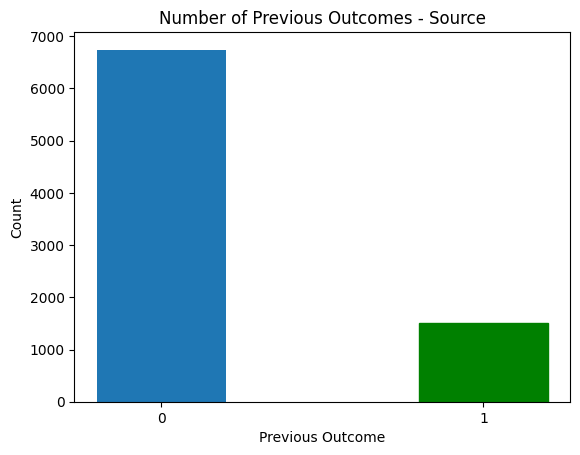

In [28]:
barlist = plt.bar([str(0),str(1)], y.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Previous Outcome")
plt.ylabel("Count")
plt.title("Number of Previous Outcomes - Source")
plt.show()

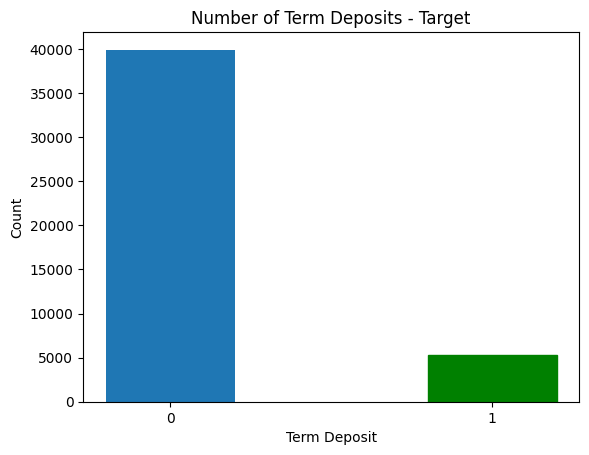

In [29]:
barlist = plt.bar([str(0),str(1)], y2.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Term Deposit")
plt.ylabel("Count")
plt.title("Number of Term Deposits - Target")
plt.show()

# Splitting for Source and Target Domains:


# Full Dataset:

For the Heart Disease prediction, we split the dataset between low education level (**now including high-school dropouts**) and the high education level. The high-education data (with diabetes as response variable/label) becomes the source data and the low-education data (with Heart Disease as response variable/label) is the target data.

In [30]:
data2[data2['Y'].isna()==1]

0    1    2    3    4         5    6    7    8         9  \
0      0.519481  0.0  0.5  1.0  0.0  0.092259  1.0  0.0  0.0  0.133333   
1      0.337662  0.1  0.0  0.5  0.0  0.073067  1.0  0.0  0.0  0.133333   
2      0.194805  0.2  0.5  0.5  0.0  0.072822  1.0  1.0  0.0  0.133333   
3      0.376623  0.3  0.5  NaN  0.0  0.086476  1.0  0.0  0.0  0.133333   
4      0.194805  NaN  0.0  NaN  0.0  0.072812  0.0  0.0  0.0  0.133333   
...         ...  ...  ...  ...  ...       ...  ...  ...  ...       ...   
45203  0.064935  1.0  0.0  1.0  0.0  0.073829  0.0  0.0  0.5  0.533333   
45205  0.090909  0.1  0.0  0.5  0.0  0.077388  0.0  1.0  0.5  0.533333   
45206  0.428571  0.1  0.5  1.0  0.0  0.080293  0.0  0.0  0.5  0.533333   
45207  0.688312  0.4  1.0  0.0  0.0  0.088501  0.0  0.0  0.5  0.533333   
45209  0.506494  0.3  0.5  0.5  0.0  0.078868  0.0  0.0  1.0  0.533333   

             10        11        12   13   14   Y  Y2  
0      0.363636  0.053070  0.000000  0.0  0.0 NaN   0  
1      0.363636  0.030704  0.000000  0.0  0.0 NaN   0  
2      0.363636  0.015453  0.000000  0.0  0.0 NaN   0  
3      0.363636  0.018707  0.000000  0.0  0.0 NaN   0  
4      0.363636  0.040260  0.000000  0.0  0.0 NaN   0  
...         ...       ...       ...  ...  ...  ..  ..  
45203  0.909091  0.054087  0.000000  0.0  0.0 NaN   1  
45205  0.909091  0.078487  0.016129  0.0  0.0 NaN   1  
45206  0.909091  0.198658  0.032258  0.0  0.0 NaN   1  
45207  0.909091  0.092721  0.016129  0.0  0.0 NaN   1  
45209  0.909091  0.103294  0.048387  0.0  0.0 NaN   0  

[36959 rows x 17 columns]

In [31]:
## Filtering data without any previous contact:
data_S = data2[data2['Y'].isna()==1].reset_index(drop=True) ## Source domain and classification - No previous contact
data_S_X = data_S.iloc[:,:-2]
data_S_y = data_S.iloc[:, -1]
data_S_full = pd.concat([data_S_X, data_S_y], axis=1).dropna().reset_index(drop=True)


## Filtering data with previous contact as target data:
data_T = data2[data2['Y2'].isna() !=1].reset_index(drop=True) ## Target domain and classification - Previous contact
data_T_X = data_T.iloc[:,:-2]
data_T_y = data_T.iloc[:, -2]    ## Response variable of interest in Default
data_T_full = pd.concat([data_T_X, data_T_y], axis=1).dropna().reset_index(drop=True)

In [32]:
data_S_full

0    1    2    3    4         5    6    7    8         9  \
0      0.519481  0.0  0.5  1.0  0.0  0.092259  1.0  0.0  0.0  0.133333   
1      0.337662  0.1  0.0  0.5  0.0  0.073067  1.0  0.0  0.0  0.133333   
2      0.194805  0.2  0.5  0.5  0.0  0.072822  1.0  1.0  0.0  0.133333   
3      0.220779  0.0  0.5  1.0  0.0  0.074901  1.0  0.0  0.0  0.133333   
4      0.129870  0.0  0.0  1.0  0.0  0.076862  1.0  1.0  0.0  0.133333   
...         ...  ...  ...  ...  ...       ...  ...  ...  ...       ...   
35281  0.064935  1.0  0.0  1.0  0.0  0.073829  0.0  0.0  0.5  0.533333   
35282  0.090909  0.1  0.0  0.5  0.0  0.077388  0.0  1.0  0.5  0.533333   
35283  0.428571  0.1  0.5  1.0  0.0  0.080293  0.0  0.0  0.5  0.533333   
35284  0.688312  0.4  1.0  0.0  0.0  0.088501  0.0  0.0  0.5  0.533333   
35285  0.506494  0.3  0.5  0.5  0.0  0.078868  0.0  0.0  1.0  0.533333   

             10        11        12   13   14  Y2  
0      0.363636  0.053070  0.000000  0.0  0.0   0  
1      0.363636  0.030704  0.000000  0.0  0.0   0  
2      0.363636  0.015453  0.000000  0.0  0.0   0  
3      0.363636  0.028264  0.000000  0.0  0.0   0  
4      0.363636  0.044124  0.000000  0.0  0.0   0  
...         ...       ...       ...  ...  ...  ..  
35281  0.909091  0.054087  0.000000  0.0  0.0   1  
35282  0.909091  0.078487  0.016129  0.0  0.0   1  
35283  0.909091  0.198658  0.032258  0.0  0.0   1  
35284  0.909091  0.092721  0.016129  0.0  0.0   1  
35285  0.909091  0.103294  0.048387  0.0  0.0   0  

[35286 rows x 16 columns]

In [33]:
data_T_full

0    1    2    3    4         5    6    7    8         9  \
0     0.194805  0.5  0.5  1.0  0.0  0.080811  0.0  0.0  1.0  0.666667   
1     0.311688  0.5  0.0  0.5  0.0  0.070561  1.0  1.0  1.0  0.666667   
2     0.194805  0.6  0.5  0.5  0.0  0.104071  1.0  0.0  1.0  0.666667   
3     0.233766  0.0  0.5  1.0  0.0  0.094729  1.0  0.0  1.0  0.700000   
4     0.233766  0.0  0.5  1.0  0.0  0.072803  1.0  0.0  1.0  0.733333   
...        ...  ...  ...  ...  ...       ...  ...  ...  ...       ...   
7902  0.207792  0.3  0.0  0.5  0.0  0.086195  1.0  0.0  0.5  0.500000   
7903  0.454545  0.0  0.5  1.0  0.0  0.078096  0.0  0.0  0.5  0.533333   
7904  0.714286  0.4  0.5  0.5  0.0  0.098678  0.0  0.0  0.5  0.533333   
7905  0.701299  0.4  0.5  0.5  0.0  0.124689  0.0  0.0  0.5  0.533333   
7906  0.246753  0.2  0.5  0.5  0.0  0.099777  0.0  0.0  0.5  0.533333   

            10        11        12        13        14    Y  
0     0.818182  0.007930  0.000000  0.174312  0.010909  0.0  
1     0.818182  0.105531  0.000000  0.191514  0.003636  0.0  
2     0.818182  0.029280  0.000000  0.105505  0.014545  0.0  
3     0.818182  0.014843  0.000000  0.099771  0.014545  0.0  
4     0.818182  0.028467  0.000000  0.165138  0.010909  0.0  
...        ...       ...       ...       ...       ...  ...  
7902  0.909091  0.237088  0.032258  0.608945  0.043636  0.0  
7903  0.909091  0.045954  0.000000  0.212156  0.014545  1.0  
7904  0.909091  0.061000  0.000000  0.047018  0.029091  0.0  
7905  0.909091  0.229158  0.064516  0.212156  0.010909  1.0  
7906  0.909091  0.073404  0.016129  0.216743  0.040000  0.0  

[7907 rows x 16 columns]

In [34]:
data_S_X = data_S_full.iloc[:, :-1]
data_S_y = data_S_full.iloc[:, -1]

data_T_X = data_T_full.iloc[:, :-1]
data_T_y = data_T_full.iloc[:, -1]

In [35]:
data_S_full['Y2'].value_counts()

Y2
0    32062
1     3224
Name: count, dtype: int64

In [36]:
data_T_full['Y'].value_counts()

Y
0.0    6483
1.0    1424
Name: count, dtype: int64

In [37]:
data_S_full

0    1    2    3    4         5    6    7    8         9  \
0      0.519481  0.0  0.5  1.0  0.0  0.092259  1.0  0.0  0.0  0.133333   
1      0.337662  0.1  0.0  0.5  0.0  0.073067  1.0  0.0  0.0  0.133333   
2      0.194805  0.2  0.5  0.5  0.0  0.072822  1.0  1.0  0.0  0.133333   
3      0.220779  0.0  0.5  1.0  0.0  0.074901  1.0  0.0  0.0  0.133333   
4      0.129870  0.0  0.0  1.0  0.0  0.076862  1.0  1.0  0.0  0.133333   
...         ...  ...  ...  ...  ...       ...  ...  ...  ...       ...   
35281  0.064935  1.0  0.0  1.0  0.0  0.073829  0.0  0.0  0.5  0.533333   
35282  0.090909  0.1  0.0  0.5  0.0  0.077388  0.0  1.0  0.5  0.533333   
35283  0.428571  0.1  0.5  1.0  0.0  0.080293  0.0  0.0  0.5  0.533333   
35284  0.688312  0.4  1.0  0.0  0.0  0.088501  0.0  0.0  0.5  0.533333   
35285  0.506494  0.3  0.5  0.5  0.0  0.078868  0.0  0.0  1.0  0.533333   

             10        11        12   13   14  Y2  
0      0.363636  0.053070  0.000000  0.0  0.0   0  
1      0.363636  0.030704  0.000000  0.0  0.0   0  
2      0.363636  0.015453  0.000000  0.0  0.0   0  
3      0.363636  0.028264  0.000000  0.0  0.0   0  
4      0.363636  0.044124  0.000000  0.0  0.0   0  
...         ...       ...       ...  ...  ...  ..  
35281  0.909091  0.054087  0.000000  0.0  0.0   1  
35282  0.909091  0.078487  0.016129  0.0  0.0   1  
35283  0.909091  0.198658  0.032258  0.0  0.0   1  
35284  0.909091  0.092721  0.016129  0.0  0.0   1  
35285  0.909091  0.103294  0.048387  0.0  0.0   0  

[35286 rows x 16 columns]

In [38]:
data_S_X

0    1    2    3    4         5    6    7    8         9  \
0      0.519481  0.0  0.5  1.0  0.0  0.092259  1.0  0.0  0.0  0.133333   
1      0.337662  0.1  0.0  0.5  0.0  0.073067  1.0  0.0  0.0  0.133333   
2      0.194805  0.2  0.5  0.5  0.0  0.072822  1.0  1.0  0.0  0.133333   
3      0.220779  0.0  0.5  1.0  0.0  0.074901  1.0  0.0  0.0  0.133333   
4      0.129870  0.0  0.0  1.0  0.0  0.076862  1.0  1.0  0.0  0.133333   
...         ...  ...  ...  ...  ...       ...  ...  ...  ...       ...   
35281  0.064935  1.0  0.0  1.0  0.0  0.073829  0.0  0.0  0.5  0.533333   
35282  0.090909  0.1  0.0  0.5  0.0  0.077388  0.0  1.0  0.5  0.533333   
35283  0.428571  0.1  0.5  1.0  0.0  0.080293  0.0  0.0  0.5  0.533333   
35284  0.688312  0.4  1.0  0.0  0.0  0.088501  0.0  0.0  0.5  0.533333   
35285  0.506494  0.3  0.5  0.5  0.0  0.078868  0.0  0.0  1.0  0.533333   

             10        11        12   13   14  
0      0.363636  0.053070  0.000000  0.0  0.0  
1      0.363636  0.030704  0.000000  0.0  0.0  
2      0.363636  0.015453  0.000000  0.0  0.0  
3      0.363636  0.028264  0.000000  0.0  0.0  
4      0.363636  0.044124  0.000000  0.0  0.0  
...         ...       ...       ...  ...  ...  
35281  0.909091  0.054087  0.000000  0.0  0.0  
35282  0.909091  0.078487  0.016129  0.0  0.0  
35283  0.909091  0.198658  0.032258  0.0  0.0  
35284  0.909091  0.092721  0.016129  0.0  0.0  
35285  0.909091  0.103294  0.048387  0.0  0.0  

[35286 rows x 15 columns]

In [39]:
data_T_full

0    1    2    3    4         5    6    7    8         9  \
0     0.194805  0.5  0.5  1.0  0.0  0.080811  0.0  0.0  1.0  0.666667   
1     0.311688  0.5  0.0  0.5  0.0  0.070561  1.0  1.0  1.0  0.666667   
2     0.194805  0.6  0.5  0.5  0.0  0.104071  1.0  0.0  1.0  0.666667   
3     0.233766  0.0  0.5  1.0  0.0  0.094729  1.0  0.0  1.0  0.700000   
4     0.233766  0.0  0.5  1.0  0.0  0.072803  1.0  0.0  1.0  0.733333   
...        ...  ...  ...  ...  ...       ...  ...  ...  ...       ...   
7902  0.207792  0.3  0.0  0.5  0.0  0.086195  1.0  0.0  0.5  0.500000   
7903  0.454545  0.0  0.5  1.0  0.0  0.078096  0.0  0.0  0.5  0.533333   
7904  0.714286  0.4  0.5  0.5  0.0  0.098678  0.0  0.0  0.5  0.533333   
7905  0.701299  0.4  0.5  0.5  0.0  0.124689  0.0  0.0  0.5  0.533333   
7906  0.246753  0.2  0.5  0.5  0.0  0.099777  0.0  0.0  0.5  0.533333   

            10        11        12        13        14    Y  
0     0.818182  0.007930  0.000000  0.174312  0.010909  0.0  
1     0.818182  0.105531  0.000000  0.191514  0.003636  0.0  
2     0.818182  0.029280  0.000000  0.105505  0.014545  0.0  
3     0.818182  0.014843  0.000000  0.099771  0.014545  0.0  
4     0.818182  0.028467  0.000000  0.165138  0.010909  0.0  
...        ...       ...       ...       ...       ...  ...  
7902  0.909091  0.237088  0.032258  0.608945  0.043636  0.0  
7903  0.909091  0.045954  0.000000  0.212156  0.014545  1.0  
7904  0.909091  0.061000  0.000000  0.047018  0.029091  0.0  
7905  0.909091  0.229158  0.064516  0.212156  0.010909  1.0  
7906  0.909091  0.073404  0.016129  0.216743  0.040000  0.0  

[7907 rows x 16 columns]

## Source domain and task labels:

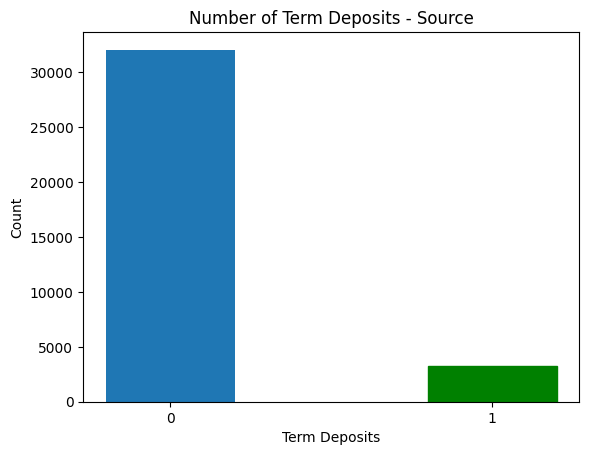

In [40]:
barlist_S = plt.bar([str(0),str(1)], data_S_y.value_counts(), width = 0.4)
barlist_S[1].set_color('g')

plt.xlabel("Term Deposits")
plt.ylabel("Count")
plt.title("Number of Term Deposits - Source")
plt.show()

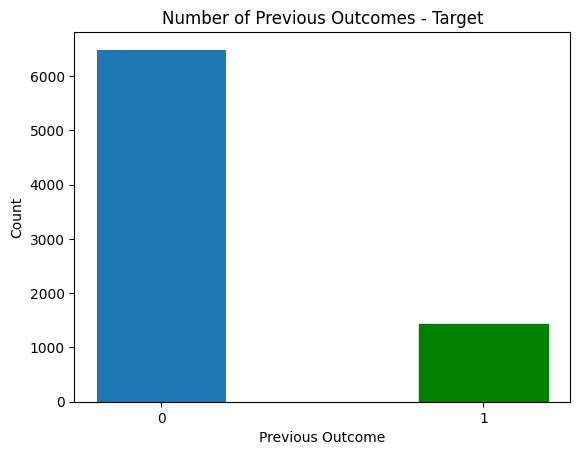

In [41]:
barlist_T = plt.bar([str(0),str(1)], data_T_y.value_counts(), width = 0.4)
barlist_T[1].set_color('g')

plt.xlabel("Previous Outcome")
plt.ylabel("Count")
plt.title("Number of Previous Outcomes - Target")
plt.show()

## Updated Code (Modified from Shreya's code):

In [42]:
def create_dnn_model(input_shape):
  model = models.Sequential([layers.Dense(64, activation='relu', input_dim=input_shape),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # For binary classification (yes/no diabetes)
    ])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

  model.summary()
  print(len(model.layers))

  return model

# def create_dnn_model(input_shape):
#   model = models.Sequential([layers.Dense(64, activation='relu', input_dim=input_shape),
#         layers.Dense(32, activation='relu'),
#         layers.Dense(1, activation='sigmoid')  # For binary classification (yes/no diabetes)
#     ])

#   model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

#   return model



def train_and_evaluate(model, X_train, X_test, y_train, y_test, domain):

    time_start = perf_counter()

    # Training and validation
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {auc}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Convert probabilities to binary predictions for confusion matrix
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

    # Compute and print classification report
    class_report = classification_report(y_test, y_pred_class)
    print("Classification Report:")
    print(class_report)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # Plot ROC curve and Confusion Matrix side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # ROC Curve
    ax1.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {auc:.2f}')
    ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax1.legend(loc='lower right')
    ax1.grid()

    # Confusion Matrix
    conf_disp.plot(ax=ax2, cmap='Blues')
    ax2.set_title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

    # Find the threshold where precision and recall are balanced
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[f1_scores.argmax()]

    print(f"Best threshold based on F1-score: {best_threshold}")

    time_stop = perf_counter()

    print('Time elapsed (performance):', time_stop-time_start)

    model.save('model.h5')
    model.save_weights('model_wt.weights.h5')

    return model


In [ ]:
def train_and_evaluate_nosave(model, X_train, X_test, y_train, y_test, domain):

    time_start = perf_counter()

    # Training and validation
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {auc}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Convert probabilities to binary predictions for confusion matrix
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

    # Compute and print classification report
    class_report = classification_report(y_test, y_pred_class)
    print("Classification Report:")
    print(class_report)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    fpr = conf_matrix[0][1]/(conf_matrix[0][0]+conf_matrix[0][1])
    fnr = conf_matrix[1][0]/(conf_matrix[1][0] + conf_matrix[1][1])

    print(fpr)
    print(fnr)

    time_stop = perf_counter()

    print('Time elapsed (performance):', time_stop-time_start)

    return fpr, fnr


In [ ]:
def fine_tuning(X_train, X_test, y_train, y_test, llim, ulim):
    new_model = create_dnn_model(X_S_train.shape[1])
    # new_model = tf.keras.models.load_model('model.h5')
    new_model.load_weights('model_wt.weights.h5')

    for layer in new_model.layers[llim:ulim]:
        layer.trainable = False
    for layer in new_model.layers[-1:]:
        layer.trainable = False

    for layer in new_model.layers:
        if layer.trainable == True:
          print("Trainable")
        else:
          print("Not Trainable")

    fpr, fnr = train_and_evaluate_nosave(new_model, X_train, X_test, y_train, y_test, "Target")
    return fpr, fnr

In [ ]:
def Transductive_TL(model, X_test, y_test, domain):

    time_start = perf_counter()

    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {auc}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Convert probabilities to binary predictions for confusion matrix
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

    # Compute and print classification report
    class_report = classification_report(y_test, y_pred_class)
    print("Classification Report:")
    print(class_report)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # Plot ROC curve and Confusion Matrix side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # ROC Curve
    ax1.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {auc:.2f}')
    ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax1.legend(loc='lower right')
    ax1.grid()

    # Confusion Matrix
    # print('Confusion matrix:', conf_matrix)
    fpr = conf_matrix[0][1]/(conf_matrix[0][0]+conf_matrix[0][1])
    tnr = 1-fpr

    fnr = conf_matrix[1][0]/(conf_matrix[1][0] + conf_matrix[1][1])
    tpr = 1 - fnr
    print('FPR', fpr, 'TPR:', tpr, 'FNR:', fnr, 'TNR:', tnr)
    conf_disp.plot(ax=ax2, cmap='Blues')
    ax2.set_title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

    # Find the threshold where precision and recall are balanced
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[f1_scores.argmax()]

    print(f"Best threshold based on F1-score: {best_threshold}")
    print('False Negative Rate:', fnr)

    time_stop = perf_counter()

    print('Time elapsed (performance):', time_stop-time_start)

# Over/undersampling functions:

## Undersampling functions:

In [ ]:
import random

def SRS_undersampler(data, data_column):
    data_majority = data[data_column.isin([0])]
    data_minority = data[data_column.isin([1])]
    undersample_size = len(data_minority)
    oversample_size = len(data_majority)

    print(undersample_size)
    print(oversample_size)

    np.random.seed(123)
    data_maj_rus = data_majority.sample(n=undersample_size, replace=False)
    data_SRS_RUS = pd.concat([data_maj_rus, data_minority])
    X_SRS = data_SRS_RUS.iloc[:, :-1]
    y_SRS = data_SRS_RUS.iloc[:, -1]

    return X_SRS, y_SRS


def SRSwR_undersampler(data, data_column):
    data_majority = data[data_column.isin([0])]
    data_minority = data[data_column.isin([1])]
    undersample_size = len(data_minority)
    oversample_size = len(data_majority)

    print(undersample_size)
    print(oversample_size)

    np.random.seed(123)
    data_maj_rus = data_majority.sample(n=undersample_size, replace=True)
    data_SRS_RUS = pd.concat([data_maj_rus, data_minority])
    X_SRS = data_SRS_RUS.iloc[:, :-1]
    y_SRS = data_SRS_RUS.iloc[:, -1]

    return X_SRS, y_SRS


def systematic_undersampler(data, data_column):
    data_majority = data[data_column.isin([0])]
    data_minority = data[data_column.isin([1])]
    undersample_size = len(data_minority)
    oversample_size = len(data_majority)
    print(undersample_size)
    print(oversample_size)

    k = oversample_size/undersample_size
    print(k)
    np.random.seed(123)
    start = random.randint(1, int(k))
    print(start)
    Row = []
    for i in range(undersample_size):
      row = start+int(k*i)-1
      Row.append(row)
    print(Row)
    data_maj_rus = pd.DataFrame()
    data_maj_rus = data_majority.iloc[Row]
    data_maj_rus
    data_Sy_RUS = pd.concat([data_maj_rus, data_minority])

    X_Sy = data_Sy_RUS.iloc[:, :-1]
    y_Sy = data_Sy_RUS.iloc[:, -1]

    return X_Sy, y_Sy



def multi_systematic_undersampler(data, data_column, m):
    data_majority = data[data_column.isin([0])]
    data_minority = data[data_column.isin([1])]
    undersample_size = len(data_minority)
    oversample_size = len(data_majority)
    print(undersample_size)
    print(oversample_size)

    k = oversample_size/undersample_size
    print(k)
    np.random.seed(123)
    start = random.sample(range(1, int(k*m)), m)
    Row = []
    for j in range(len(start)):
      for i in range(int(undersample_size/m)):
        row = start[j]+int(k*i)-1
        Row.append(row)
    print(Row)
    data_maj_rus = pd.DataFrame()
    data_maj_rus = data_majority.iloc[Row]
    data_maj_rus
    data_Sy_RUS = pd.concat([data_maj_rus, data_minority])

    X_Sy = data_Sy_RUS.iloc[:, :-1]
    y_Sy = data_Sy_RUS.iloc[:, -1]

    return X_Sy, y_Sy

## Oversampling functions:

In [ ]:
def SRSwR_oversampler(data, data_column):
    data_majority = data[data_column.isin([0])]
    data_minority = data[data_column.isin([1])]
    undersample_size = len(data_minority)
    oversample_size = len(data_majority)

    print(undersample_size)
    print(oversample_size)

    np.random.seed(123)
    data_min_ros = data_minority.sample(n=oversample_size - undersample_size, replace=True)
    data_SRS_ROS = pd.concat([data_majority, data_minority, data_min_ros])
    X_SRS = data_SRS_ROS.iloc[:, :-1]
    y_SRS = data_SRS_ROS.iloc[:, -1]

    return X_SRS, y_SRS

# data_S_min_ros = data_S_minority.sample(n=oversample_size - undersample_size, replace=True)


def systematic_resampler(data, data_column, k):
    data_majority = data[data_column.isin([0])]
    data_minority = data[data_column.isin([1])]
    undersample_size = len(data_minority)
    oversample_size = len(data_majority)

    print(undersample_size)
    print(oversample_size)

    Nsamples = k*(oversample_size-undersample_size)/undersample_size
    print('Nsamples=', Nsamples)

    np.random.seed(123)
    start = np.random.choice(int(k), int(Nsamples), replace=True)
    Row = []
    for j in range(len(start)):
      for i in range(int(undersample_size/k)):
        row = start[j]+int(k*i)-1
        Row.append(row)
    data_min_ros = pd.DataFrame()
    data_min_ros = data_minority.iloc[Row]

    data_Sy_ROS = pd.concat([data_majority, data_minority, data_min_ros])
    X_Sy = data_Sy_ROS.iloc[:, :-1]
    y_Sy = data_Sy_ROS.iloc[:, -1]

    return X_Sy, y_Sy

# k = 48

# Nsamples = k*(oversample_size-undersample_size)/undersample_size
# # print(Nsamples)

# np.random.seed(123)
# start = np.random.choice(int(k), int(Nsamples), replace=True)
# # print(start)


# Row = []

# for j in range(len(start)):
#   for i in range(int(undersample_size/k)):
#     row = start[j]+int(k*i)-1
#     Row.append(row)

In [ ]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(data_S_X, data_S_y, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)

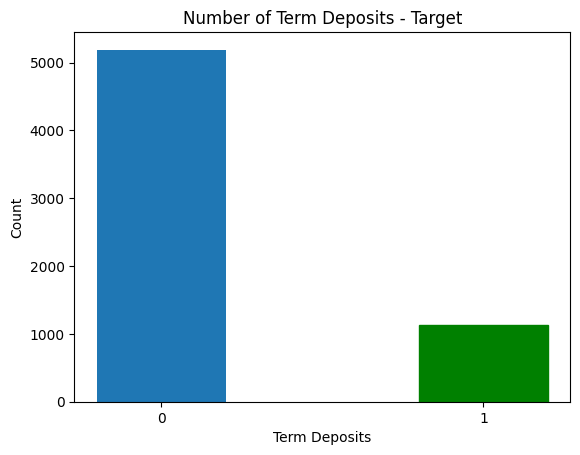

In [ ]:
barlist = plt.bar([str(0),str(1)], y_T_train.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Term Deposits")
plt.ylabel("Count")
plt.title("Number of Term Deposits - Target")
plt.show()

In [ ]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (28228, 15)
y_S_train: (28228,)
X_S_test: (7058, 15)
y_S_test: (7058,)


# Original (Imbalanced) dataset:

## Standard Machine Learning:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_252 (Dense)               │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_253 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_254 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_255 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_257 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_258 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - AUC: 0.5811 - loss: 0.5200 - val_AUC: 0.7335 - val_loss: 0.4222
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - AUC: 0.7613 - loss: 0.4055 - val_AUC: 0.7453 - val_loss: 0.4178
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7607 - loss: 0.4034 - val_AUC: 0.7455 - val_loss: 0.4174
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7694 - loss: 0.3971 - val_AUC: 0.7486 - val_loss: 0.4078
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7754 - loss: 0.3980 - val_AUC: 0.7515 - val_loss: 0.4070
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7809 - loss: 0.3952 - val_AUC: 0.7554 - val_loss: 0.4052
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7999 - loss: 0.3778 - val_AUC: 0.7592 - val_loss: 0.4037
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7877 - loss: 0.3958 - val_AUC: 0.7609 - val_loss: 0.4049
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


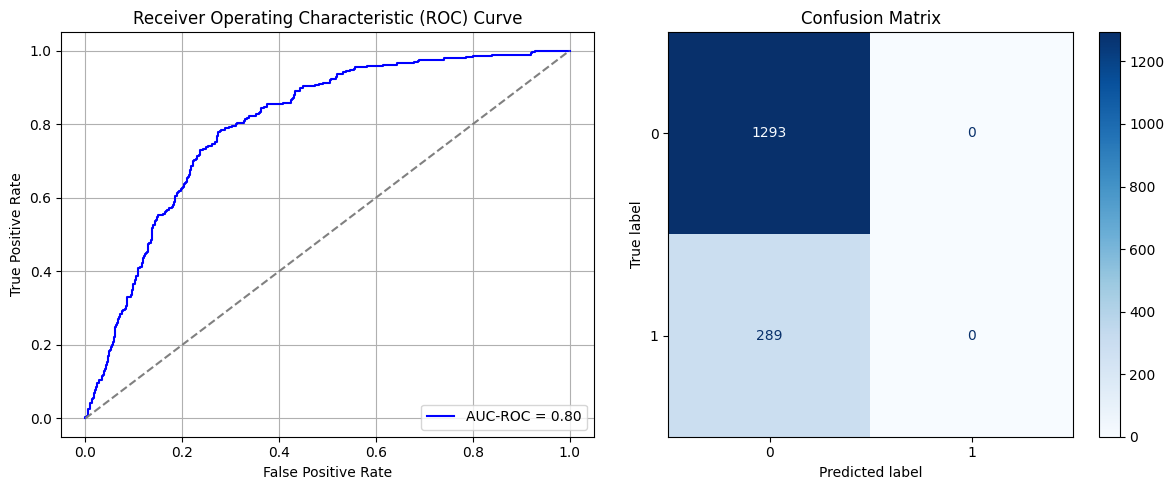

Best threshold based on F1-score: 0.23394690454006195
Time elapsed (performance): 16.478265572000055


<Sequential name=sequential_36, built=True>

In [ ]:
model_source = create_dnn_model(X_S_train.shape[1])
train_and_evaluate(model_source, X_T_train, X_T_test, y_T_train, y_T_test, "Target")

## With Transfer Learning:

In [ ]:
model_source = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_259 (Dense)               │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_260 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_261 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_262 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_263 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_264 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_265 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.6530 - loss: 0.3138 - val_AUC: 0.8801 - val_loss: 0.2174
Epoch 2/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8821 - loss: 0.2176 - val_AUC: 0.8859 - val_loss: 0.2129
Epoch 3/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8882 - loss: 0.2101 - val_AUC: 0.8842 - val_loss: 0.2169
Epoch 4/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8892 - loss: 0.2083 - val_AUC: 0.8865 - val_loss: 0.2194
Epoch 5/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8963 - loss: 0.2078 - val_AUC: 0.8874 - val_loss: 0.2169
Epoch 6/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8996 - loss: 0.1996 - val_AUC: 0.8959 - val_loss: 0.2076
Epoch 7/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.9099 - loss: 0.1937 - val_AUC: 0.8952 - val_loss: 0.2088
Epoch 8/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9029 - loss: 0.2024 - val_AUC: 0.8980 - val_loss: 0.2075
Epoch 9/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AU

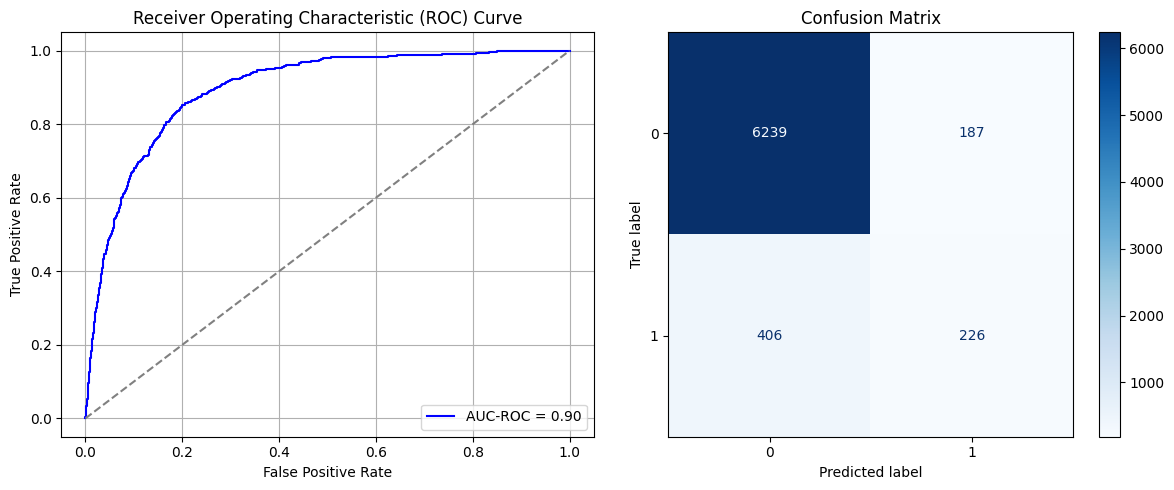

Best threshold based on F1-score: 0.2925061881542206
Time elapsed (performance): 35.87276388600003


<Sequential name=sequential_37, built=True>

In [ ]:
train_and_evaluate(model_source, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
# model_source.save('model_source.h5')
# model_source.save_weights('model_wt.weights.h5')

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC-ROC: 0.7126314972556512
Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.94      0.88      1293
         1.0       0.34      0.13      0.19       289

    accuracy                           0.80      1582
   macro avg       0.59      0.54      0.54      1582
weighted avg       0.74      0.80      0.76      1582

FPR 0.05645784996133024 TPR: 0.13148788927335642 FNR: 0.8685121107266436 TNR: 0.9435421500386698


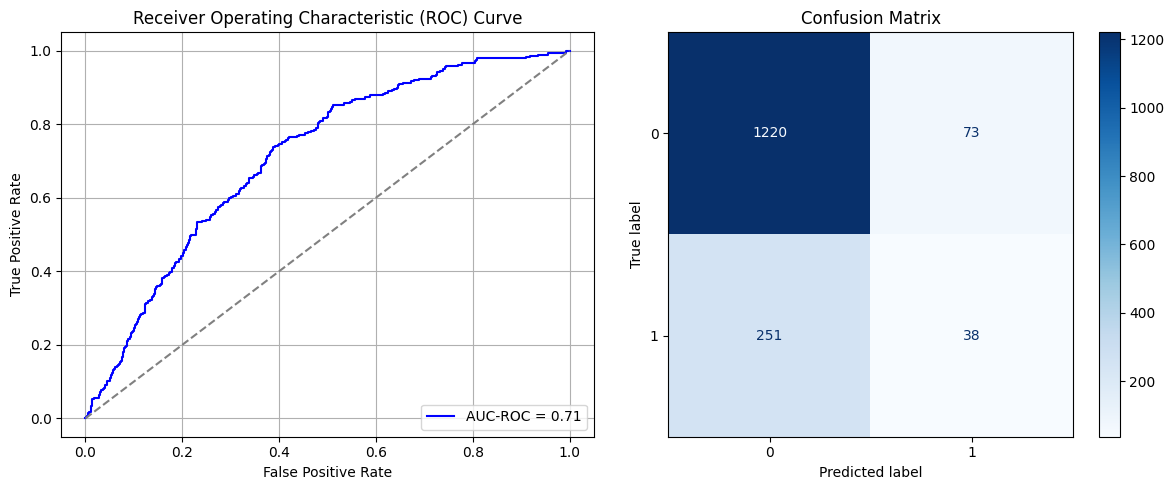

Best threshold based on F1-score: 0.6971489787101746
False Negative Rate: 0.8685121107266436
Time elapsed (performance): 0.8752540799996495


<ipython-input-311-de1f6cb50f3b>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [ ]:
Transductive_TL(model_source, X_T_test, y_T_test, "Target")

In [ ]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_266 (Dense)               │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_267 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_268 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_269 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_270 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_271 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_272 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6810 - loss: 0.4813 - val_AUC: 0.6704 - val_loss: 0.4481
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6988 - loss: 0.4373 - val_AUC: 0.6825 - val_loss: 0.4409
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7263 - loss: 0.4123 - val_AUC: 0.6973 - val_loss: 0.4325
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7436 - loss: 0.4130 - val_AUC: 0.7079 - val_loss: 0.4276
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7411 - loss: 0.4046 - val_AUC: 0.7172 - val_loss: 0.4238
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7622 - loss: 0.4016 - val_AUC: 0.7229 - val_loss: 0.4217
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7526 - loss: 0.4037 - val_AUC: 0.7242 - val_loss: 0.4216
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7632 - loss: 0.4019 - val_AUC: 0.7275 - val_loss: 0.4201
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7518 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(np.float64(0.0), np.float64(1.0))

In [ ]:
times = 50

FPR = []
FNR = []

for i in range(times):
    fpr, fnr = fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 4)
    # print(output)
    FPR.append(fpr)
    FNR.append(fnr)

ParamFit = pd.DataFrame([FPR, FNR]).T
ParamFit.columns=['FPR', 'FNR']

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_139"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_973 (Dense)               │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_974 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_975 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_976 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_977 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_978 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_979 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - AUC: 0.6795 - loss: 0.4807 - val_AUC: 0.6695 - val_loss: 0.4489
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6996 - loss: 0.4434 - val_AUC: 0.6852 - val_loss: 0.4380
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7344 - loss: 0.4178 - val_AUC: 0.7022 - val_loss: 0.4305
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7226 - loss: 0.4210 - val_AUC: 0.7120 - val_loss: 0.4264
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7437 - loss: 0.4208 - val_AUC: 0.7178 - val_loss: 0.4234
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7645 - loss: 0.4069 - val_AUC: 0.7190 - val_loss: 0.4257
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7469 - loss: 0.4163 - val_AUC: 0.7254 - val_loss: 0.4210
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7569 - loss: 0.4090 - val_AUC: 0.7271 - val_loss: 0.4213
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7606 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_140"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_980 (Dense)               │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_981 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_982 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_983 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_984 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_985 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_986 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6946 - loss: 0.4657 - val_AUC: 0.6673 - val_loss: 0.4483
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7051 - loss: 0.4370 - val_AUC: 0.6840 - val_loss: 0.4410
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7209 - loss: 0.4276 - val_AUC: 0.6963 - val_loss: 0.4347
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7277 - loss: 0.4210 - val_AUC: 0.7072 - val_loss: 0.4285
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7536 - loss: 0.4069 - val_AUC: 0.7183 - val_loss: 0.4234
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7575 - loss: 0.4057 - val_AUC: 0.7211 - val_loss: 0.4224
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7647 - loss: 0.3993 - val_AUC: 0.7245 - val_loss: 0.4220
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7656 - loss: 0.4150 - val_AUC: 0.7245 - val_loss: 0.4223
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7695 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_141"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_987 (Dense)               │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_988 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_989 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_990 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_991 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_992 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_993 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6904 - loss: 0.4569 - val_AUC: 0.6716 - val_loss: 0.4475
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7223 - loss: 0.4141 - val_AUC: 0.6859 - val_loss: 0.4385
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7244 - loss: 0.4181 - val_AUC: 0.6989 - val_loss: 0.4320
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7289 - loss: 0.4134 - val_AUC: 0.7097 - val_loss: 0.4273
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7469 - loss: 0.4130 - val_AUC: 0.7153 - val_loss: 0.4246
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7507 - loss: 0.4190 - val_AUC: 0.7190 - val_loss: 0.4236
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7438 - loss: 0.4031 - val_AUC: 0.7253 - val_loss: 0.4217
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7595 - loss: 0.4032 - val_AUC: 0.7266 - val_loss: 0.4212
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7709 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_142"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_994 (Dense)               │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_995 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_996 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_997 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_998 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_999 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1000 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6732 - loss: 0.4748 - val_AUC: 0.6702 - val_loss: 0.4496
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7212 - loss: 0.4183 - val_AUC: 0.6873 - val_loss: 0.4372
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7287 - loss: 0.4205 - val_AUC: 0.6970 - val_loss: 0.4344
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7371 - loss: 0.4168 - val_AUC: 0.7081 - val_loss: 0.4280
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7430 - loss: 0.4153 - val_AUC: 0.7198 - val_loss: 0.4235
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7438 - loss: 0.4223 - val_AUC: 0.7207 - val_loss: 0.4229
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7469 - loss: 0.4053 - val_AUC: 0.7253 - val_loss: 0.4216
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7637 - loss: 0.4101 - val_AUC: 0.7245 - val_loss: 0.4230
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7649 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_143"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1001 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1002 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1003 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1004 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1005 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1006 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1007 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6729 - loss: 0.4780 - val_AUC: 0.6713 - val_loss: 0.4484
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6934 - loss: 0.4350 - val_AUC: 0.6844 - val_loss: 0.4387
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7334 - loss: 0.4262 - val_AUC: 0.7010 - val_loss: 0.4309
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7354 - loss: 0.4188 - val_AUC: 0.7103 - val_loss: 0.4271
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7579 - loss: 0.4121 - val_AUC: 0.7163 - val_loss: 0.4244
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7547 - loss: 0.4091 - val_AUC: 0.7190 - val_loss: 0.4243
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7616 - loss: 0.3970 - val_AUC: 0.7254 - val_loss: 0.4210
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7460 - loss: 0.4252 - val_AUC: 0.7259 - val_loss: 0.4212
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AU

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_144"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1008 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1009 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1010 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1011 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1012 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1013 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1014 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7037 - loss: 0.4435 - val_AUC: 0.6722 - val_loss: 0.4469
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7055 - loss: 0.4303 - val_AUC: 0.6843 - val_loss: 0.4389
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7200 - loss: 0.4332 - val_AUC: 0.6989 - val_loss: 0.4317
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7390 - loss: 0.4214 - val_AUC: 0.7094 - val_loss: 0.4269
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7435 - loss: 0.4136 - val_AUC: 0.7167 - val_loss: 0.4240
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7530 - loss: 0.4059 - val_AUC: 0.7228 - val_loss: 0.4213
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7529 - loss: 0.4044 - val_AUC: 0.7237 - val_loss: 0.4219
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7657 - loss: 0.3946 - val_AUC: 0.7284 - val_loss: 0.4207
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7621 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_145"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1015 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1016 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1017 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1018 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1019 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1020 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1021 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6980 - loss: 0.4554 - val_AUC: 0.6728 - val_loss: 0.4462
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7017 - loss: 0.4384 - val_AUC: 0.6868 - val_loss: 0.4372
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7215 - loss: 0.4273 - val_AUC: 0.7007 - val_loss: 0.4312
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7435 - loss: 0.4222 - val_AUC: 0.7130 - val_loss: 0.4260
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7446 - loss: 0.4144 - val_AUC: 0.7189 - val_loss: 0.4235
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7557 - loss: 0.4144 - val_AUC: 0.7238 - val_loss: 0.4218
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7464 - loss: 0.4154 - val_AUC: 0.7243 - val_loss: 0.4221
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7495 - loss: 0.4089 - val_AUC: 0.7272 - val_loss: 0.4210
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7605 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_146"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1022 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1023 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1024 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1025 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1026 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1027 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1028 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6854 - loss: 0.4698 - val_AUC: 0.6709 - val_loss: 0.4475
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7200 - loss: 0.4216 - val_AUC: 0.6853 - val_loss: 0.4378
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7288 - loss: 0.4268 - val_AUC: 0.6990 - val_loss: 0.4315
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7370 - loss: 0.4202 - val_AUC: 0.7080 - val_loss: 0.4279
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7361 - loss: 0.4090 - val_AUC: 0.7179 - val_loss: 0.4244
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7592 - loss: 0.4129 - val_AUC: 0.7182 - val_loss: 0.4253
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7586 - loss: 0.4086 - val_AUC: 0.7237 - val_loss: 0.4218
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7559 - loss: 0.4069 - val_AUC: 0.7274 - val_loss: 0.4220
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7684 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_147"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1029 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1030 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1031 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1032 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1033 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1034 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1035 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6835 - loss: 0.4614 - val_AUC: 0.6714 - val_loss: 0.4466
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7124 - loss: 0.4324 - val_AUC: 0.6859 - val_loss: 0.4372
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7198 - loss: 0.4241 - val_AUC: 0.7018 - val_loss: 0.4309
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7396 - loss: 0.4099 - val_AUC: 0.7088 - val_loss: 0.4278
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7299 - loss: 0.4044 - val_AUC: 0.7189 - val_loss: 0.4238
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7552 - loss: 0.4024 - val_AUC: 0.7206 - val_loss: 0.4228
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7597 - loss: 0.4199 - val_AUC: 0.7242 - val_loss: 0.4211
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7607 - loss: 0.4027 - val_AUC: 0.7225 - val_loss: 0.4248
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7638 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_148"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1036 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1037 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1038 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1039 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1040 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1041 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1042 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - AUC: 0.6678 - loss: 0.4836 - val_AUC: 0.6697 - val_loss: 0.4486
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7075 - loss: 0.4327 - val_AUC: 0.6834 - val_loss: 0.4426
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7138 - loss: 0.4284 - val_AUC: 0.6970 - val_loss: 0.4354
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7298 - loss: 0.4055 - val_AUC: 0.7096 - val_loss: 0.4269
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7418 - loss: 0.4150 - val_AUC: 0.7163 - val_loss: 0.4240
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7405 - loss: 0.4103 - val_AUC: 0.7199 - val_loss: 0.4239
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7494 - loss: 0.4111 - val_AUC: 0.7226 - val_loss: 0.4237
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7531 - loss: 0.4086 - val_AUC: 0.7277 - val_loss: 0.4208
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7639 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_149"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1043 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1044 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1045 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1046 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1047 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1048 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1049 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6810 - loss: 0.4626 - val_AUC: 0.6716 - val_loss: 0.4479
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7040 - loss: 0.4305 - val_AUC: 0.6851 - val_loss: 0.4381
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7169 - loss: 0.4284 - val_AUC: 0.6945 - val_loss: 0.4353
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7478 - loss: 0.4188 - val_AUC: 0.7124 - val_loss: 0.4273
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7289 - loss: 0.4171 - val_AUC: 0.7130 - val_loss: 0.4267
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7587 - loss: 0.4047 - val_AUC: 0.7219 - val_loss: 0.4221
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7750 - loss: 0.3996 - val_AUC: 0.7251 - val_loss: 0.4210
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7623 - loss: 0.4099 - val_AUC: 0.7259 - val_loss: 0.4213
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7744 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_150"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1050 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1051 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1052 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1053 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1054 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1055 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1056 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6792 - loss: 0.4758 - val_AUC: 0.6702 - val_loss: 0.4492
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7130 - loss: 0.4312 - val_AUC: 0.6851 - val_loss: 0.4389
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7371 - loss: 0.4182 - val_AUC: 0.6957 - val_loss: 0.4367
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7460 - loss: 0.4095 - val_AUC: 0.7104 - val_loss: 0.4264
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7472 - loss: 0.4109 - val_AUC: 0.7173 - val_loss: 0.4237
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7514 - loss: 0.4103 - val_AUC: 0.7212 - val_loss: 0.4224
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7414 - loss: 0.4128 - val_AUC: 0.7240 - val_loss: 0.4217
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7637 - loss: 0.4106 - val_AUC: 0.7225 - val_loss: 0.4250
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7592 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_151"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1057 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1058 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1059 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1060 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1061 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1062 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1063 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6871 - loss: 0.4572 - val_AUC: 0.6714 - val_loss: 0.4476
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7218 - loss: 0.4226 - val_AUC: 0.6869 - val_loss: 0.4368
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7394 - loss: 0.4294 - val_AUC: 0.6987 - val_loss: 0.4316
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7257 - loss: 0.4240 - val_AUC: 0.7078 - val_loss: 0.4282
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7389 - loss: 0.4086 - val_AUC: 0.7158 - val_loss: 0.4245
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7497 - loss: 0.4051 - val_AUC: 0.7199 - val_loss: 0.4229
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7572 - loss: 0.4070 - val_AUC: 0.7241 - val_loss: 0.4211
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7546 - loss: 0.4149 - val_AUC: 0.7257 - val_loss: 0.4211
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7532 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_152"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1064 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1065 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1066 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1067 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1068 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1069 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1070 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6740 - loss: 0.4805 - val_AUC: 0.6683 - val_loss: 0.4509
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7120 - loss: 0.4308 - val_AUC: 0.6838 - val_loss: 0.4390
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7329 - loss: 0.4213 - val_AUC: 0.6970 - val_loss: 0.4332
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7270 - loss: 0.4256 - val_AUC: 0.7097 - val_loss: 0.4273
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7488 - loss: 0.4020 - val_AUC: 0.7187 - val_loss: 0.4238
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7601 - loss: 0.3994 - val_AUC: 0.7203 - val_loss: 0.4233
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7530 - loss: 0.4045 - val_AUC: 0.7211 - val_loss: 0.4247
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7595 - loss: 0.4051 - val_AUC: 0.7251 - val_loss: 0.4219
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AU

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_153"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1071 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1072 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1073 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1074 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1075 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1076 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1077 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7035 - loss: 0.4596 - val_AUC: 0.6728 - val_loss: 0.4474
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7125 - loss: 0.4313 - val_AUC: 0.6875 - val_loss: 0.4365
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7233 - loss: 0.4200 - val_AUC: 0.7007 - val_loss: 0.4309
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7391 - loss: 0.4092 - val_AUC: 0.7102 - val_loss: 0.4268
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7466 - loss: 0.4195 - val_AUC: 0.7167 - val_loss: 0.4245
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7307 - loss: 0.4104 - val_AUC: 0.7219 - val_loss: 0.4223
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7574 - loss: 0.3991 - val_AUC: 0.7246 - val_loss: 0.4218
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7753 - loss: 0.4017 - val_AUC: 0.7286 - val_loss: 0.4195
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7626 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_154"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1078 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1079 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1080 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1081 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1082 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1083 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1084 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6807 - loss: 0.4734 - val_AUC: 0.6716 - val_loss: 0.4484
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7017 - loss: 0.4367 - val_AUC: 0.6858 - val_loss: 0.4389
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7175 - loss: 0.4278 - val_AUC: 0.7012 - val_loss: 0.4307
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7479 - loss: 0.4213 - val_AUC: 0.7131 - val_loss: 0.4260
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7419 - loss: 0.4319 - val_AUC: 0.7154 - val_loss: 0.4276
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7432 - loss: 0.4173 - val_AUC: 0.7212 - val_loss: 0.4236
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7496 - loss: 0.4170 - val_AUC: 0.7247 - val_loss: 0.4213
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7418 - loss: 0.4056 - val_AUC: 0.7224 - val_loss: 0.4246
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7629 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_155"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1085 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1086 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1087 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1088 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1089 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1090 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1091 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6862 - loss: 0.4669 - val_AUC: 0.6698 - val_loss: 0.4475
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7149 - loss: 0.4332 - val_AUC: 0.6834 - val_loss: 0.4396
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7346 - loss: 0.4201 - val_AUC: 0.7012 - val_loss: 0.4318
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7422 - loss: 0.4176 - val_AUC: 0.7116 - val_loss: 0.4268
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7477 - loss: 0.4155 - val_AUC: 0.7134 - val_loss: 0.4263
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7518 - loss: 0.4129 - val_AUC: 0.7223 - val_loss: 0.4224
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7555 - loss: 0.4111 - val_AUC: 0.7205 - val_loss: 0.4250
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7532 - loss: 0.4173 - val_AUC: 0.7257 - val_loss: 0.4209
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7651 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_156"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1092 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1093 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1094 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1095 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1096 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1097 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1098 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6800 - loss: 0.4818 - val_AUC: 0.6707 - val_loss: 0.4503
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7044 - loss: 0.4369 - val_AUC: 0.6853 - val_loss: 0.4377
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7267 - loss: 0.4277 - val_AUC: 0.6974 - val_loss: 0.4320
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7351 - loss: 0.4241 - val_AUC: 0.7083 - val_loss: 0.4284
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7419 - loss: 0.4107 - val_AUC: 0.7161 - val_loss: 0.4245
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7521 - loss: 0.4133 - val_AUC: 0.7210 - val_loss: 0.4239
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7560 - loss: 0.4050 - val_AUC: 0.7240 - val_loss: 0.4228
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7670 - loss: 0.4095 - val_AUC: 0.7251 - val_loss: 0.4231
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AU

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_157"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1099 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1100 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1101 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1102 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1103 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1104 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1105 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6774 - loss: 0.4772 - val_AUC: 0.6714 - val_loss: 0.4499
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7137 - loss: 0.4341 - val_AUC: 0.6840 - val_loss: 0.4401
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7294 - loss: 0.4247 - val_AUC: 0.7002 - val_loss: 0.4307
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7434 - loss: 0.4234 - val_AUC: 0.7075 - val_loss: 0.4289
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7563 - loss: 0.4112 - val_AUC: 0.7166 - val_loss: 0.4242
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7605 - loss: 0.4077 - val_AUC: 0.7203 - val_loss: 0.4242
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7568 - loss: 0.4059 - val_AUC: 0.7239 - val_loss: 0.4219
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7718 - loss: 0.3924 - val_AUC: 0.7256 - val_loss: 0.4219
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7622 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_158"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1106 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1107 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1108 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1109 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1110 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1111 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1112 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7038 - loss: 0.4581 - val_AUC: 0.6718 - val_loss: 0.4465
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7098 - loss: 0.4462 - val_AUC: 0.6874 - val_loss: 0.4370
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7258 - loss: 0.4112 - val_AUC: 0.6980 - val_loss: 0.4331
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7333 - loss: 0.4178 - val_AUC: 0.7101 - val_loss: 0.4271
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7472 - loss: 0.4050 - val_AUC: 0.7178 - val_loss: 0.4234
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7429 - loss: 0.4293 - val_AUC: 0.7194 - val_loss: 0.4256
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7450 - loss: 0.4257 - val_AUC: 0.7216 - val_loss: 0.4265
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7668 - loss: 0.4078 - val_AUC: 0.7267 - val_loss: 0.4207
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7629 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_159"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1113 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1114 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1115 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1116 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1117 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1118 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1119 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6814 - loss: 0.4749 - val_AUC: 0.6703 - val_loss: 0.4483
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7038 - loss: 0.4394 - val_AUC: 0.6868 - val_loss: 0.4373
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7350 - loss: 0.4223 - val_AUC: 0.6982 - val_loss: 0.4338
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7385 - loss: 0.4270 - val_AUC: 0.7124 - val_loss: 0.4262
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7477 - loss: 0.4119 - val_AUC: 0.7193 - val_loss: 0.4231
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7507 - loss: 0.4182 - val_AUC: 0.7220 - val_loss: 0.4219
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7506 - loss: 0.4277 - val_AUC: 0.7206 - val_loss: 0.4275
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7454 - loss: 0.4131 - val_AUC: 0.7276 - val_loss: 0.4206
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7716 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1120 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1121 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1122 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1123 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1124 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1125 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1126 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6646 - loss: 0.4776 - val_AUC: 0.6703 - val_loss: 0.4484
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7080 - loss: 0.4252 - val_AUC: 0.6842 - val_loss: 0.4385
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7215 - loss: 0.4167 - val_AUC: 0.6975 - val_loss: 0.4326
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7206 - loss: 0.4306 - val_AUC: 0.7064 - val_loss: 0.4284
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7250 - loss: 0.4332 - val_AUC: 0.7145 - val_loss: 0.4255
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7489 - loss: 0.4191 - val_AUC: 0.7174 - val_loss: 0.4252
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7566 - loss: 0.4109 - val_AUC: 0.7261 - val_loss: 0.4216
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7593 - loss: 0.4119 - val_AUC: 0.7273 - val_loss: 0.4205
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7729 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_161"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1127 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1128 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1129 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1130 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1131 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1132 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1133 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.6990 - loss: 0.4601 - val_AUC: 0.6717 - val_loss: 0.4483
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7091 - loss: 0.4285 - val_AUC: 0.6860 - val_loss: 0.4395
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7358 - loss: 0.4172 - val_AUC: 0.7017 - val_loss: 0.4303
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7440 - loss: 0.4174 - val_AUC: 0.7142 - val_loss: 0.4249
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7393 - loss: 0.4052 - val_AUC: 0.7147 - val_loss: 0.4286
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7471 - loss: 0.4079 - val_AUC: 0.7268 - val_loss: 0.4219
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7583 - loss: 0.4050 - val_AUC: 0.7259 - val_loss: 0.4211
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7613 - loss: 0.4072 - val_AUC: 0.7301 - val_loss: 0.4204
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7534 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_162"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1134 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1135 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1136 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1137 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1138 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1139 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1140 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6818 - loss: 0.4609 - val_AUC: 0.6713 - val_loss: 0.4481
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7132 - loss: 0.4374 - val_AUC: 0.6849 - val_loss: 0.4393
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7181 - loss: 0.4226 - val_AUC: 0.7021 - val_loss: 0.4312
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7526 - loss: 0.4060 - val_AUC: 0.7133 - val_loss: 0.4272
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7416 - loss: 0.4252 - val_AUC: 0.7167 - val_loss: 0.4242
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7489 - loss: 0.4140 - val_AUC: 0.7202 - val_loss: 0.4230
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7503 - loss: 0.4091 - val_AUC: 0.7216 - val_loss: 0.4242
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7654 - loss: 0.4000 - val_AUC: 0.7265 - val_loss: 0.4205
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7595 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_163"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1141 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1142 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1143 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1144 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1145 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1146 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1147 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6937 - loss: 0.4489 - val_AUC: 0.6714 - val_loss: 0.4476
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6925 - loss: 0.4356 - val_AUC: 0.6831 - val_loss: 0.4396
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7315 - loss: 0.4281 - val_AUC: 0.6981 - val_loss: 0.4328
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7316 - loss: 0.4200 - val_AUC: 0.7077 - val_loss: 0.4287
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7256 - loss: 0.4160 - val_AUC: 0.7166 - val_loss: 0.4248
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7536 - loss: 0.4114 - val_AUC: 0.7241 - val_loss: 0.4215
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7520 - loss: 0.4132 - val_AUC: 0.7252 - val_loss: 0.4213
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7606 - loss: 0.4116 - val_AUC: 0.7267 - val_loss: 0.4208
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7645 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_164"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1148 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1149 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1150 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1151 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1152 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1153 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1154 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6844 - loss: 0.4631 - val_AUC: 0.6699 - val_loss: 0.4482
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7136 - loss: 0.4404 - val_AUC: 0.6864 - val_loss: 0.4384
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7151 - loss: 0.4281 - val_AUC: 0.7021 - val_loss: 0.4306
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7317 - loss: 0.4241 - val_AUC: 0.7122 - val_loss: 0.4261
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7428 - loss: 0.4237 - val_AUC: 0.7187 - val_loss: 0.4233
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7649 - loss: 0.4068 - val_AUC: 0.7202 - val_loss: 0.4247
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7584 - loss: 0.4125 - val_AUC: 0.7246 - val_loss: 0.4231
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7647 - loss: 0.3992 - val_AUC: 0.7285 - val_loss: 0.4202
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AU

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_165"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1155 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1156 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1157 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1158 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1159 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1160 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1161 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


159/159 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - AUC: 0.6827 - loss: 0.4775 - val_AUC: 0.6693 - val_loss: 0.4498
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7052 - loss: 0.4350 - val_AUC: 0.6852 - val_loss: 0.4377
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7440 - loss: 0.4149 - val_AUC: 0.7033 - val_loss: 0.4300
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7324 - loss: 0.4332 - val_AUC: 0.7098 - val_loss: 0.4273
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7411 - loss: 0.4162 - val_AUC: 0.7116 - val_loss: 0.4292
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7402 - loss: 0.4213 - val_AUC: 0.7182 - val_loss: 0.4247
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7601 - loss: 0.4095 - val_AUC: 0.7232 - val_loss: 0.4226
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7580 - loss: 0.4006 - val_AUC: 0.7271 - val_loss: 0.4211
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7531 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_166"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1162 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1163 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1164 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1165 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1166 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1167 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1168 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - AUC: 0.6932 - loss: 0.4634 - val_AUC: 0.6708 - val_loss: 0.4476
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7029 - loss: 0.4431 - val_AUC: 0.6860 - val_loss: 0.4373
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7285 - loss: 0.4278 - val_AUC: 0.6954 - val_loss: 0.4353
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7221 - loss: 0.4238 - val_AUC: 0.7092 - val_loss: 0.4268
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7467 - loss: 0.4313 - val_AUC: 0.7178 - val_loss: 0.4230
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7498 - loss: 0.4024 - val_AUC: 0.7225 - val_loss: 0.4227
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7494 - loss: 0.4084 - val_AUC: 0.7249 - val_loss: 0.4211
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7687 - loss: 0.3942 - val_AUC: 0.7273 - val_loss: 0.4202
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AU

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_167"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1169 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1170 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1171 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1172 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1173 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1174 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1175 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - AUC: 0.6878 - loss: 0.4541 - val_AUC: 0.6727 - val_loss: 0.4471
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7079 - loss: 0.4363 - val_AUC: 0.6867 - val_loss: 0.4374
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7294 - loss: 0.4150 - val_AUC: 0.7041 - val_loss: 0.4314
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7385 - loss: 0.4186 - val_AUC: 0.7120 - val_loss: 0.4261
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7444 - loss: 0.4235 - val_AUC: 0.7187 - val_loss: 0.4230
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7473 - loss: 0.4071 - val_AUC: 0.7235 - val_loss: 0.4220
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7588 - loss: 0.4060 - val_AUC: 0.7247 - val_loss: 0.4215
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7584 - loss: 0.4125 - val_AUC: 0.7236 - val_loss: 0.4237
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AU

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_168"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1176 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1177 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1178 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1179 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1180 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1181 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1182 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6861 - loss: 0.4681 - val_AUC: 0.6711 - val_loss: 0.4471
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6984 - loss: 0.4338 - val_AUC: 0.6843 - val_loss: 0.4383
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7170 - loss: 0.4237 - val_AUC: 0.6978 - val_loss: 0.4323
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7426 - loss: 0.4274 - val_AUC: 0.7101 - val_loss: 0.4266
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7497 - loss: 0.4038 - val_AUC: 0.7157 - val_loss: 0.4243
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7398 - loss: 0.4103 - val_AUC: 0.7212 - val_loss: 0.4226
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7376 - loss: 0.4127 - val_AUC: 0.7231 - val_loss: 0.4221
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7448 - loss: 0.4214 - val_AUC: 0.7231 - val_loss: 0.4231
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AU

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_169"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1183 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1184 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1185 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1186 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1187 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1188 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1189 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6928 - loss: 0.4474 - val_AUC: 0.6713 - val_loss: 0.4486
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7133 - loss: 0.4356 - val_AUC: 0.6845 - val_loss: 0.4380
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7305 - loss: 0.4197 - val_AUC: 0.6980 - val_loss: 0.4320
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7476 - loss: 0.4176 - val_AUC: 0.7078 - val_loss: 0.4277
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7345 - loss: 0.4099 - val_AUC: 0.7175 - val_loss: 0.4242
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7333 - loss: 0.4158 - val_AUC: 0.7162 - val_loss: 0.4269
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7496 - loss: 0.4109 - val_AUC: 0.7240 - val_loss: 0.4218
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7504 - loss: 0.4166 - val_AUC: 0.7203 - val_loss: 0.4287
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AU

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_170"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1190 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1191 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1192 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1193 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1194 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1195 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1196 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6866 - loss: 0.4719 - val_AUC: 0.6692 - val_loss: 0.4495
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6896 - loss: 0.4582 - val_AUC: 0.6826 - val_loss: 0.4402
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7116 - loss: 0.4349 - val_AUC: 0.6972 - val_loss: 0.4325
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7516 - loss: 0.4144 - val_AUC: 0.7113 - val_loss: 0.4280
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7398 - loss: 0.4232 - val_AUC: 0.7134 - val_loss: 0.4267
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7546 - loss: 0.4098 - val_AUC: 0.7202 - val_loss: 0.4228
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7562 - loss: 0.4225 - val_AUC: 0.7199 - val_loss: 0.4272
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7630 - loss: 0.4033 - val_AUC: 0.7251 - val_loss: 0.4223
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AU

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_171"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1197 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1198 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1199 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1200 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1201 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1202 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1203 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6941 - loss: 0.4537 - val_AUC: 0.6719 - val_loss: 0.4480
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7101 - loss: 0.4284 - val_AUC: 0.6876 - val_loss: 0.4372
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7175 - loss: 0.4296 - val_AUC: 0.6983 - val_loss: 0.4328
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7494 - loss: 0.3985 - val_AUC: 0.7117 - val_loss: 0.4263
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7462 - loss: 0.4122 - val_AUC: 0.7168 - val_loss: 0.4242
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7457 - loss: 0.4251 - val_AUC: 0.7202 - val_loss: 0.4233
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7498 - loss: 0.4170 - val_AUC: 0.7222 - val_loss: 0.4243
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7505 - loss: 0.4125 - val_AUC: 0.7265 - val_loss: 0.4211
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AU

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_172"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1204 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1205 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1206 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1207 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1208 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1209 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1210 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6835 - loss: 0.4786 - val_AUC: 0.6675 - val_loss: 0.4493
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7173 - loss: 0.4205 - val_AUC: 0.6849 - val_loss: 0.4383
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7191 - loss: 0.4226 - val_AUC: 0.7000 - val_loss: 0.4315
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7457 - loss: 0.4189 - val_AUC: 0.7093 - val_loss: 0.4268
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7545 - loss: 0.4143 - val_AUC: 0.7182 - val_loss: 0.4231
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7472 - loss: 0.4153 - val_AUC: 0.7210 - val_loss: 0.4222
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7518 - loss: 0.4154 - val_AUC: 0.7202 - val_loss: 0.4260
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7505 - loss: 0.4070 - val_AUC: 0.7250 - val_loss: 0.4219
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AU

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_173"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1211 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1212 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1213 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1214 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1215 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1216 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1217 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - AUC: 0.6994 - loss: 0.4683 - val_AUC: 0.6693 - val_loss: 0.4485
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7079 - loss: 0.4277 - val_AUC: 0.6830 - val_loss: 0.4386
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7225 - loss: 0.4111 - val_AUC: 0.6978 - val_loss: 0.4330
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7305 - loss: 0.4179 - val_AUC: 0.7047 - val_loss: 0.4300
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7477 - loss: 0.4043 - val_AUC: 0.7149 - val_loss: 0.4249
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7381 - loss: 0.4178 - val_AUC: 0.7212 - val_loss: 0.4225
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7540 - loss: 0.4013 - val_AUC: 0.7224 - val_loss: 0.4224
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7690 - loss: 0.3991 - val_AUC: 0.7265 - val_loss: 0.4219
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AU

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_174"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1218 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1219 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1220 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1221 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1222 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1223 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1224 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.6602 - loss: 0.4936 - val_AUC: 0.6687 - val_loss: 0.4499
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7154 - loss: 0.4390 - val_AUC: 0.6849 - val_loss: 0.4378
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7253 - loss: 0.4222 - val_AUC: 0.6999 - val_loss: 0.4311
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7405 - loss: 0.4223 - val_AUC: 0.7074 - val_loss: 0.4299
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7398 - loss: 0.4136 - val_AUC: 0.7196 - val_loss: 0.4239
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7372 - loss: 0.4175 - val_AUC: 0.7199 - val_loss: 0.4236
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7545 - loss: 0.4105 - val_AUC: 0.7255 - val_loss: 0.4217
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7662 - loss: 0.4018 - val_AUC: 0.7257 - val_loss: 0.4212
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AU

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_175"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1225 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1226 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1227 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1228 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1229 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1230 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1231 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.7033 - loss: 0.4444 - val_AUC: 0.6725 - val_loss: 0.4468
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6964 - loss: 0.4416 - val_AUC: 0.6836 - val_loss: 0.4391
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7135 - loss: 0.4305 - val_AUC: 0.6974 - val_loss: 0.4325
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7470 - loss: 0.4103 - val_AUC: 0.7095 - val_loss: 0.4268
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7514 - loss: 0.4111 - val_AUC: 0.7161 - val_loss: 0.4251
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7404 - loss: 0.4227 - val_AUC: 0.7191 - val_loss: 0.4267
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7589 - loss: 0.4163 - val_AUC: 0.7236 - val_loss: 0.4228
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7671 - loss: 0.3979 - val_AUC: 0.7266 - val_loss: 0.4220
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AU

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_176"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1232 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1233 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1234 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1235 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1236 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1237 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1238 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - AUC: 0.6823 - loss: 0.4739 - val_AUC: 0.6718 - val_loss: 0.4483
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7155 - loss: 0.4222 - val_AUC: 0.6873 - val_loss: 0.4369
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7229 - loss: 0.4347 - val_AUC: 0.6991 - val_loss: 0.4327
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7328 - loss: 0.4275 - val_AUC: 0.7072 - val_loss: 0.4304
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7533 - loss: 0.4130 - val_AUC: 0.7170 - val_loss: 0.4243
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7517 - loss: 0.4293 - val_AUC: 0.7201 - val_loss: 0.4233
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7647 - loss: 0.4026 - val_AUC: 0.7236 - val_loss: 0.4223
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7633 - loss: 0.4121 - val_AUC: 0.7284 - val_loss: 0.4205
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AU

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_177"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1239 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1240 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1241 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1242 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1243 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1244 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1245 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - AUC: 0.6960 - loss: 0.4612 - val_AUC: 0.6719 - val_loss: 0.4460
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7011 - loss: 0.4380 - val_AUC: 0.6876 - val_loss: 0.4368
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7298 - loss: 0.4186 - val_AUC: 0.7029 - val_loss: 0.4303
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7272 - loss: 0.4329 - val_AUC: 0.7103 - val_loss: 0.4281
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7402 - loss: 0.4224 - val_AUC: 0.7163 - val_loss: 0.4250
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7538 - loss: 0.4037 - val_AUC: 0.7190 - val_loss: 0.4253
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7555 - loss: 0.4030 - val_AUC: 0.7260 - val_loss: 0.4208
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7590 - loss: 0.4111 - val_AUC: 0.7250 - val_loss: 0.4218
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - A

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_178"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1246 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1247 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1248 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1249 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1250 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1251 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1252 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6875 - loss: 0.4851 - val_AUC: 0.6689 - val_loss: 0.4491
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7036 - loss: 0.4336 - val_AUC: 0.6850 - val_loss: 0.4384
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7203 - loss: 0.4241 - val_AUC: 0.6987 - val_loss: 0.4322
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7369 - loss: 0.4234 - val_AUC: 0.7132 - val_loss: 0.4286
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7546 - loss: 0.4175 - val_AUC: 0.7147 - val_loss: 0.4251
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7508 - loss: 0.4027 - val_AUC: 0.7242 - val_loss: 0.4243
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7572 - loss: 0.4146 - val_AUC: 0.7221 - val_loss: 0.4231
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7557 - loss: 0.4111 - val_AUC: 0.7253 - val_loss: 0.4212
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7500 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_179"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1253 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1254 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1255 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1256 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1257 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1258 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1259 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6972 - loss: 0.4508 - val_AUC: 0.6711 - val_loss: 0.4470
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7192 - loss: 0.4242 - val_AUC: 0.6861 - val_loss: 0.4373
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7215 - loss: 0.4356 - val_AUC: 0.7023 - val_loss: 0.4313
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7469 - loss: 0.4150 - val_AUC: 0.7098 - val_loss: 0.4267
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7381 - loss: 0.4272 - val_AUC: 0.7177 - val_loss: 0.4239
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7352 - loss: 0.4273 - val_AUC: 0.7196 - val_loss: 0.4241
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7405 - loss: 0.4214 - val_AUC: 0.7230 - val_loss: 0.4228
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7668 - loss: 0.3982 - val_AUC: 0.7289 - val_loss: 0.4232
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7509 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_180"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1260 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1261 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1262 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1263 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1264 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1265 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1266 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6617 - loss: 0.5007 - val_AUC: 0.6703 - val_loss: 0.4510
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7260 - loss: 0.4246 - val_AUC: 0.6865 - val_loss: 0.4374
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7234 - loss: 0.4222 - val_AUC: 0.6957 - val_loss: 0.4358
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7432 - loss: 0.4249 - val_AUC: 0.7084 - val_loss: 0.4281
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7583 - loss: 0.4051 - val_AUC: 0.7180 - val_loss: 0.4238
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7608 - loss: 0.4102 - val_AUC: 0.7240 - val_loss: 0.4232
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7483 - loss: 0.4074 - val_AUC: 0.7260 - val_loss: 0.4218
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7625 - loss: 0.4175 - val_AUC: 0.7237 - val_loss: 0.4231
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AU

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_181"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1267 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1268 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1269 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1270 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1271 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1272 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1273 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6805 - loss: 0.4613 - val_AUC: 0.6712 - val_loss: 0.4484
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7039 - loss: 0.4416 - val_AUC: 0.6870 - val_loss: 0.4374
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7278 - loss: 0.4184 - val_AUC: 0.7027 - val_loss: 0.4306
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7451 - loss: 0.4104 - val_AUC: 0.7067 - val_loss: 0.4317
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7474 - loss: 0.4137 - val_AUC: 0.7156 - val_loss: 0.4252
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7404 - loss: 0.4277 - val_AUC: 0.7220 - val_loss: 0.4222
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7569 - loss: 0.3985 - val_AUC: 0.7224 - val_loss: 0.4235
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7723 - loss: 0.3950 - val_AUC: 0.7264 - val_loss: 0.4208
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AU

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_182"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1274 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1275 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1276 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1277 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1278 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1279 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1280 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6796 - loss: 0.4763 - val_AUC: 0.6696 - val_loss: 0.4510
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7076 - loss: 0.4395 - val_AUC: 0.6851 - val_loss: 0.4398
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7206 - loss: 0.4291 - val_AUC: 0.7032 - val_loss: 0.4302
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7321 - loss: 0.4078 - val_AUC: 0.7108 - val_loss: 0.4265
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7523 - loss: 0.4193 - val_AUC: 0.7171 - val_loss: 0.4240
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7553 - loss: 0.4035 - val_AUC: 0.7213 - val_loss: 0.4225
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7563 - loss: 0.4053 - val_AUC: 0.7257 - val_loss: 0.4213
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7722 - loss: 0.3895 - val_AUC: 0.7283 - val_loss: 0.4241
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AU

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_183"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1281 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1282 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1283 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1284 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1285 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1286 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1287 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.6987 - loss: 0.4603 - val_AUC: 0.6720 - val_loss: 0.4482
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7070 - loss: 0.4395 - val_AUC: 0.6854 - val_loss: 0.4386
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7319 - loss: 0.4087 - val_AUC: 0.7008 - val_loss: 0.4311
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7500 - loss: 0.4107 - val_AUC: 0.7127 - val_loss: 0.4259
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7411 - loss: 0.4012 - val_AUC: 0.7180 - val_loss: 0.4241
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7588 - loss: 0.4107 - val_AUC: 0.7180 - val_loss: 0.4255
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7402 - loss: 0.4154 - val_AUC: 0.7246 - val_loss: 0.4216
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7545 - loss: 0.4259 - val_AUC: 0.7240 - val_loss: 0.4227
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7667 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_184"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1288 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1289 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1290 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1291 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1292 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1293 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1294 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.6996 - loss: 0.4598 - val_AUC: 0.6708 - val_loss: 0.4466
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7045 - loss: 0.4445 - val_AUC: 0.6828 - val_loss: 0.4423
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7400 - loss: 0.4093 - val_AUC: 0.7018 - val_loss: 0.4318
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7368 - loss: 0.4220 - val_AUC: 0.7070 - val_loss: 0.4295
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7344 - loss: 0.4272 - val_AUC: 0.7095 - val_loss: 0.4343
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7382 - loss: 0.4039 - val_AUC: 0.7194 - val_loss: 0.4236
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7469 - loss: 0.4073 - val_AUC: 0.7248 - val_loss: 0.4223
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7612 - loss: 0.4079 - val_AUC: 0.7251 - val_loss: 0.4228
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7595 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_185"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1295 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1296 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1297 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1298 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1299 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1300 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1301 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.6949 - loss: 0.4567 - val_AUC: 0.6711 - val_loss: 0.4499
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7060 - loss: 0.4345 - val_AUC: 0.6858 - val_loss: 0.4380
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7108 - loss: 0.4227 - val_AUC: 0.7006 - val_loss: 0.4309
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7357 - loss: 0.4224 - val_AUC: 0.7110 - val_loss: 0.4263
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7529 - loss: 0.4048 - val_AUC: 0.7170 - val_loss: 0.4244
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7452 - loss: 0.4028 - val_AUC: 0.7238 - val_loss: 0.4221
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7760 - loss: 0.3869 - val_AUC: 0.7267 - val_loss: 0.4209
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7597 - loss: 0.4116 - val_AUC: 0.7266 - val_loss: 0.4216
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AU

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_186"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1302 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1303 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1304 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1305 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1306 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1307 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1308 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - AUC: 0.6760 - loss: 0.4735 - val_AUC: 0.6701 - val_loss: 0.4495
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6992 - loss: 0.4416 - val_AUC: 0.6831 - val_loss: 0.4386
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7356 - loss: 0.4210 - val_AUC: 0.6995 - val_loss: 0.4318
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7359 - loss: 0.4247 - val_AUC: 0.7072 - val_loss: 0.4293
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7483 - loss: 0.4105 - val_AUC: 0.7169 - val_loss: 0.4237
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7522 - loss: 0.4091 - val_AUC: 0.7242 - val_loss: 0.4223
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7453 - loss: 0.4137 - val_AUC: 0.7256 - val_loss: 0.4215
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7673 - loss: 0.3997 - val_AUC: 0.7218 - val_loss: 0.4265
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AU

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_187"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1309 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1310 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1311 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1312 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1313 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1314 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1315 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6963 - loss: 0.4544 - val_AUC: 0.6693 - val_loss: 0.4478
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7111 - loss: 0.4441 - val_AUC: 0.6840 - val_loss: 0.4397
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7149 - loss: 0.4300 - val_AUC: 0.7003 - val_loss: 0.4313
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7429 - loss: 0.4183 - val_AUC: 0.7084 - val_loss: 0.4279
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7565 - loss: 0.4034 - val_AUC: 0.7178 - val_loss: 0.4243
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7519 - loss: 0.4067 - val_AUC: 0.7245 - val_loss: 0.4235
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7589 - loss: 0.4105 - val_AUC: 0.7248 - val_loss: 0.4213
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7633 - loss: 0.4014 - val_AUC: 0.7258 - val_loss: 0.4220
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AU

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_188"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1316 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1317 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1318 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1319 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1320 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1321 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1322 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6883 - loss: 0.4773 - val_AUC: 0.6705 - val_loss: 0.4501
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7034 - loss: 0.4287 - val_AUC: 0.6855 - val_loss: 0.4382
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7293 - loss: 0.4327 - val_AUC: 0.6974 - val_loss: 0.4347
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7282 - loss: 0.4291 - val_AUC: 0.7098 - val_loss: 0.4264
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7516 - loss: 0.4059 - val_AUC: 0.7138 - val_loss: 0.4267
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7511 - loss: 0.4207 - val_AUC: 0.7221 - val_loss: 0.4228
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7485 - loss: 0.4068 - val_AUC: 0.7186 - val_loss: 0.4290
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7549 - loss: 0.4132 - val_AUC: 0.7264 - val_loss: 0.4213
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AU

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print(ParamFit)
ParamFit.to_csv('Fine_Tuning_Imbalanced.csv')

    FPR  FNR
0   0.0  1.0
1   0.0  1.0
2   0.0  1.0
3   0.0  1.0
4   0.0  1.0
5   0.0  1.0
6   0.0  1.0
7   0.0  1.0
8   0.0  1.0
9   0.0  1.0
10  0.0  1.0
11  0.0  1.0
12  0.0  1.0
13  0.0  1.0
14  0.0  1.0
15  0.0  1.0
16  0.0  1.0
17  0.0  1.0
18  0.0  1.0
19  0.0  1.0
20  0.0  1.0
21  0.0  1.0
22  0.0  1.0
23  0.0  1.0
24  0.0  1.0
25  0.0  1.0
26  0.0  1.0
27  0.0  1.0
28  0.0  1.0
29  0.0  1.0
30  0.0  1.0
31  0.0  1.0
32  0.0  1.0
33  0.0  1.0
34  0.0  1.0
35  0.0  1.0
36  0.0  1.0
37  0.0  1.0
38  0.0  1.0
39  0.0  1.0
40  0.0  1.0
41  0.0  1.0
42  0.0  1.0
43  0.0  1.0
44  0.0  1.0
45  0.0  1.0
46  0.0  1.0
47  0.0  1.0
48  0.0  1.0
49  0.0  1.0


# Random Undersampling (RUS) to balance Dataset:

## SRS Sample without Replacement:

In [ ]:
data_S_full

0    1    2    3    4         5    6    7    8         9  \
0      0.519481  0.0  0.5  1.0  0.0  0.092259  1.0  0.0  0.0  0.133333   
1      0.337662  0.1  0.0  0.5  0.0  0.073067  1.0  0.0  0.0  0.133333   
2      0.194805  0.2  0.5  0.5  0.0  0.072822  1.0  1.0  0.0  0.133333   
3      0.220779  0.0  0.5  1.0  0.0  0.074901  1.0  0.0  0.0  0.133333   
4      0.129870  0.0  0.0  1.0  0.0  0.076862  1.0  1.0  0.0  0.133333   
...         ...  ...  ...  ...  ...       ...  ...  ...  ...       ...   
35281  0.064935  1.0  0.0  1.0  0.0  0.073829  0.0  0.0  0.5  0.533333   
35282  0.090909  0.1  0.0  0.5  0.0  0.077388  0.0  1.0  0.5  0.533333   
35283  0.428571  0.1  0.5  1.0  0.0  0.080293  0.0  0.0  0.5  0.533333   
35284  0.688312  0.4  1.0  0.0  0.0  0.088501  0.0  0.0  0.5  0.533333   
35285  0.506494  0.3  0.5  0.5  0.0  0.078868  0.0  0.0  1.0  0.533333   

             10        11        12   13   14  Y2  
0      0.363636  0.053070  0.000000  0.0  0.0   0  
1      0.363636  0.030704  0.000000  0.0  0.0   0  
2      0.363636  0.015453  0.000000  0.0  0.0   0  
3      0.363636  0.028264  0.000000  0.0  0.0   0  
4      0.363636  0.044124  0.000000  0.0  0.0   0  
...         ...       ...       ...  ...  ...  ..  
35281  0.909091  0.054087  0.000000  0.0  0.0   1  
35282  0.909091  0.078487  0.016129  0.0  0.0   1  
35283  0.909091  0.198658  0.032258  0.0  0.0   1  
35284  0.909091  0.092721  0.016129  0.0  0.0   1  
35285  0.909091  0.103294  0.048387  0.0  0.0   0  

[35286 rows x 16 columns]

In [ ]:
X_S_SRS, y_S_SRS = SRS_undersampler(data_S_full, data_S_full['Y2'])
print(y_S_SRS)

3224
32062
28610    0
9418     0
7668     0
3608     0
6093     0
        ..
35280    1
35281    1
35282    1
35283    1
35284    1
Name: Y2, Length: 6448, dtype: int64


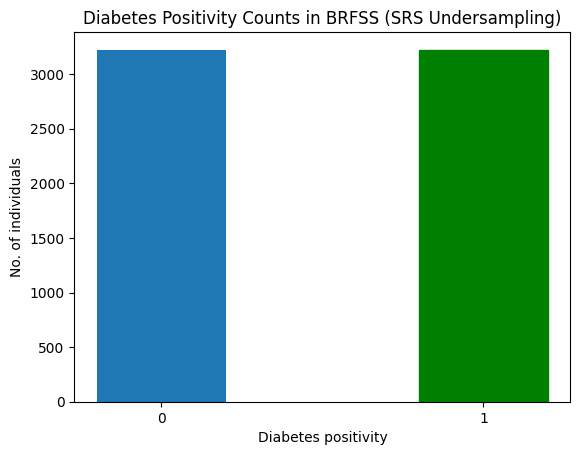

In [ ]:
barlist = plt.bar([str(0),str(1)], y_S_SRS.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (SRS Undersampling)")
plt.show()

In [ ]:
data_T_y.value_counts()

Y
0.0    6483
1.0    1424
Name: count, dtype: int64

In [ ]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRS, y_S_SRS, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)
T_train = pd.concat([X_T_train, y_T_train], axis=1)

T_train['Y'].value_counts()

X_T_train_SRS, y_T_train_SRS = SRS_undersampler(T_train, T_train.iloc[:,-1])
print(y_T_train_SRS)


1135
5190
1327    0.0
23      0.0
691     0.0
458     0.0
5510    0.0
       ... 
7640    1.0
6743    1.0
7891    1.0
7527    1.0
5827    1.0
Name: Y, Length: 2270, dtype: float64


In [ ]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (5158, 15)
y_S_train: (5158,)
X_S_test: (1290, 15)
y_S_test: (1290,)


In [ ]:
model_source_SRS = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_189"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1323 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1324 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1325 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1326 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1327 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1328 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1329 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - AUC: 0.6108 - loss: 0.6781 - val_AUC: 0.7938 - val_loss: 0.5603
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8180 - loss: 0.5257 - val_AUC: 0.8966 - val_loss: 0.4303
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8753 - loss: 0.4449 - val_AUC: 0.9022 - val_loss: 0.4249
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8883 - loss: 0.4188 - val_AUC: 0.9037 - val_loss: 0.4179
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8906 - loss: 0.4149 - val_AUC: 0.9053 - val_loss: 0.3891
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8931 - loss: 0.4093 - val_AUC: 0.9064 - val_loss: 0.3979
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9043 - loss: 0.3885 - val_AUC: 0.9080 - val_loss: 0.3910
Epoch 8/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9054 - loss: 0.3823 - val_AUC: 0.9059 - val_loss: 0.4033
Epoch 9/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - A

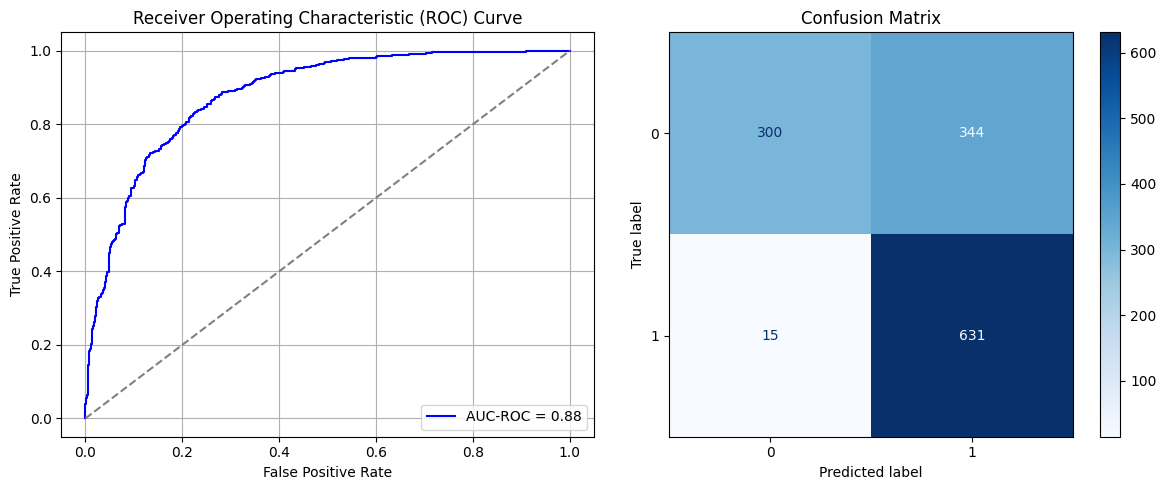

Best threshold based on F1-score: 0.7269687652587891
Time elapsed (performance): 11.408877726000355


<Sequential name=sequential_189, built=True>

In [ ]:
train_and_evaluate(model_source_SRS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC-ROC: 0.7609459506472167
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.53      0.68      1293
         1.0       0.30      0.90      0.45       289

    accuracy                           0.60      1582
   macro avg       0.63      0.71      0.57      1582
weighted avg       0.84      0.60      0.64      1582

FPR 0.47022428460943544 TPR: 0.8996539792387543 FNR: 0.10034602076124567 TNR: 0.5297757153905646


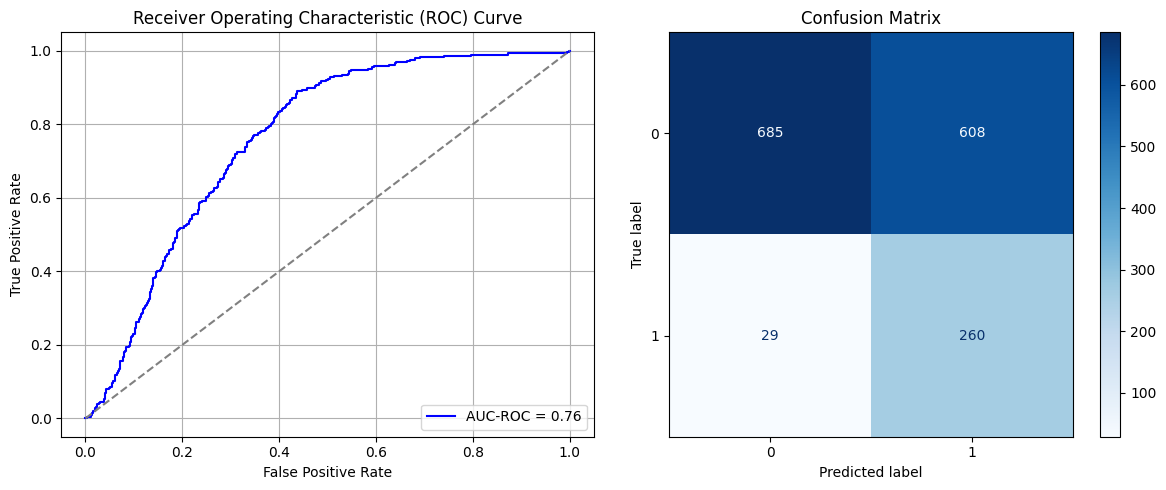

Best threshold based on F1-score: 0.9815114736557007
False Negative Rate: 0.10034602076124567
Time elapsed (performance): 0.5695694489986636


<ipython-input-311-de1f6cb50f3b>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [ ]:
Transductive_TL(model_source_SRS, X_T_test, y_T_test, "Target")

In [ ]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_190"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1330 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1331 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1332 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1333 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1334 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1335 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1336 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7089 - loss: 0.5475 - val_AUC: 0.7202 - val_loss: 0.4261
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7501 - loss: 0.4059 - val_AUC: 0.7198 - val_loss: 0.4250
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7449 - loss: 0.4209 - val_AUC: 0.7224 - val_loss: 0.4234
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7470 - loss: 0.4245 - val_AUC: 0.7233 - val_loss: 0.4215
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7552 - loss: 0.4106 - val_AUC: 0.7253 - val_loss: 0.4205
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7442 - loss: 0.4072 - val_AUC: 0.7270 - val_loss: 0.4211
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7526 - loss: 0.4061 - val_AUC: 0.7269 - val_loss: 0.4200
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7489 - loss: 0.4011 - val_AUC: 0.7287 - val_loss: 0.4193
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7578 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(np.float64(0.0), np.float64(1.0))

In [ ]:
fine_tuning(X_T_train_SRS, X_T_test, y_T_train_SRS, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_191"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1337 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1338 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1339 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1340 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1341 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1342 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1343 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7405 - loss: 0.6403 - val_AUC: 0.0000e+00 - val_loss: 0.9164
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7407 - loss: 0.5741 - val_AUC: 0.0000e+00 - val_loss: 0.9167
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7447 - loss: 0.5675 - val_AUC: 0.0000e+00 - val_loss: 0.8384
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7573 - loss: 0.5601 - val_AUC: 0.0000e+00 - val_loss: 0.8031
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7708 - loss: 0.5545 - val_AUC: 0.0000e+00 - val_loss: 0.9812
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7452 - loss: 0.5759 - val_AUC: 0.0000e+00 - val_loss: 0.8938
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7552 - loss: 0.5593 - val_AUC: 0.0000e+00 - val_loss: 0.9146
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7348 - loss: 0.5858 - val_AUC: 0.0000e+00 - val_loss: 0.9368
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

(np.float64(0.251353441608662), np.float64(0.3633217993079585))

In [ ]:
times = 50

FPR = []
FNR = []

for i in range(times):
    fpr, fnr = fine_tuning(X_T_train_SRS, X_T_test, y_T_train_SRS, y_T_test, 0, 4)
    # print(output)
    FPR.append(fpr)
    FNR.append(fnr)

ParamFit = pd.DataFrame([FPR, FNR]).T
ParamFit.columns=['FPR', 'FNR']


# fine_tuning(X_T_train_SRS, X_T_test, y_T_train_SRS, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_194"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1358 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1359 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1360 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1361 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1362 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1363 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1364 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - AUC: 0.7272 - loss: 0.6557 - val_AUC: 0.0000e+00 - val_loss: 0.7956
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7416 - loss: 0.5754 - val_AUC: 0.0000e+00 - val_loss: 0.8744
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7231 - loss: 0.5875 - val_AUC: 0.0000e+00 - val_loss: 0.9870
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7535 - loss: 0.5609 - val_AUC: 0.0000e+00 - val_loss: 0.8844
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7717 - loss: 0.5507 - val_AUC: 0.0000e+00 - val_loss: 0.9145
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7443 - loss: 0.5694 - val_AUC: 0.0000e+00 - val_loss: 0.8690
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7336 - loss: 0.5757 - val_AUC: 0.0000e+00 - val_loss: 0.9028
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7577 - loss: 0.5526 - val_AUC: 0.0000e+00 - val_loss: 0.8350
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_195"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1365 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1366 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1367 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1368 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1369 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1370 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1371 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7475 - loss: 0.6100 - val_AUC: 0.0000e+00 - val_loss: 0.9104
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7526 - loss: 0.5678 - val_AUC: 0.0000e+00 - val_loss: 0.9339
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7505 - loss: 0.5658 - val_AUC: 0.0000e+00 - val_loss: 0.8485
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7540 - loss: 0.5621 - val_AUC: 0.0000e+00 - val_loss: 0.9076
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7498 - loss: 0.5647 - val_AUC: 0.0000e+00 - val_loss: 0.9011
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7578 - loss: 0.5642 - val_AUC: 0.0000e+00 - val_loss: 0.8637
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7293 - loss: 0.5827 - val_AUC: 0.0000e+00 - val_loss: 0.8876
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7537 - loss: 0.5632 - val_AUC: 0.0000e+00 - val_loss: 0.9502
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_196"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1372 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1373 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1374 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1375 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1376 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1377 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1378 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7392 - loss: 0.6152 - val_AUC: 0.0000e+00 - val_loss: 0.7886
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7454 - loss: 0.5695 - val_AUC: 0.0000e+00 - val_loss: 0.8899
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7458 - loss: 0.5708 - val_AUC: 0.0000e+00 - val_loss: 0.8869
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7563 - loss: 0.5568 - val_AUC: 0.0000e+00 - val_loss: 0.9109
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7603 - loss: 0.5448 - val_AUC: 0.0000e+00 - val_loss: 0.8413
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7451 - loss: 0.5594 - val_AUC: 0.0000e+00 - val_loss: 0.7991
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7517 - loss: 0.5603 - val_AUC: 0.0000e+00 - val_loss: 0.8492
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7447 - loss: 0.5642 - val_AUC: 0.0000e+00 - val_loss: 0.8695
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_197"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1379 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1380 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1381 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1382 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1383 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1384 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1385 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7552 - loss: 0.5945 - val_AUC: 0.0000e+00 - val_loss: 0.9114
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7377 - loss: 0.5624 - val_AUC: 0.0000e+00 - val_loss: 0.7898
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7430 - loss: 0.5705 - val_AUC: 0.0000e+00 - val_loss: 0.9130
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7697 - loss: 0.5399 - val_AUC: 0.0000e+00 - val_loss: 0.8580
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7585 - loss: 0.5626 - val_AUC: 0.0000e+00 - val_loss: 0.9143
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7472 - loss: 0.5681 - val_AUC: 0.0000e+00 - val_loss: 0.8755
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7507 - loss: 0.5639 - val_AUC: 0.0000e+00 - val_loss: 0.8705
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7556 - loss: 0.5627 - val_AUC: 0.0000e+00 - val_loss: 0.8588
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_198"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1386 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1387 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1388 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1389 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1390 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1391 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1392 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - AUC: 0.7157 - loss: 0.6547 - val_AUC: 0.0000e+00 - val_loss: 0.8837
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7212 - loss: 0.6009 - val_AUC: 0.0000e+00 - val_loss: 0.9027
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7474 - loss: 0.5717 - val_AUC: 0.0000e+00 - val_loss: 0.8963
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7571 - loss: 0.5591 - val_AUC: 0.0000e+00 - val_loss: 0.8479
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7368 - loss: 0.5783 - val_AUC: 0.0000e+00 - val_loss: 0.9497
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7302 - loss: 0.5766 - val_AUC: 0.0000e+00 - val_loss: 0.8561
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7378 - loss: 0.5733 - val_AUC: 0.0000e+00 - val_loss: 0.8987
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7329 - loss: 0.5811 - val_AUC: 0.0000e+00 - val_loss: 0.8908
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_199"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1393 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1394 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1395 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1396 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1397 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1398 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1399 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - AUC: 0.7578 - loss: 0.6002 - val_AUC: 0.0000e+00 - val_loss: 0.8641
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7505 - loss: 0.5719 - val_AUC: 0.0000e+00 - val_loss: 0.9072
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7728 - loss: 0.5511 - val_AUC: 0.0000e+00 - val_loss: 0.8609
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7457 - loss: 0.5726 - val_AUC: 0.0000e+00 - val_loss: 0.8276
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7426 - loss: 0.5656 - val_AUC: 0.0000e+00 - val_loss: 0.8466
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7344 - loss: 0.5722 - val_AUC: 0.0000e+00 - val_loss: 0.8804
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7490 - loss: 0.5670 - val_AUC: 0.0000e+00 - val_loss: 0.8489
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7579 - loss: 0.5551 - val_AUC: 0.0000e+00 - val_loss: 0.8507
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_200"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1400 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1401 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1402 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1403 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1404 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1405 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1406 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.7485 - loss: 0.6301 - val_AUC: 0.0000e+00 - val_loss: 0.7936
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7219 - loss: 0.5832 - val_AUC: 0.0000e+00 - val_loss: 0.8443
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7503 - loss: 0.5650 - val_AUC: 0.0000e+00 - val_loss: 0.9319
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7409 - loss: 0.5684 - val_AUC: 0.0000e+00 - val_loss: 0.8520
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7511 - loss: 0.5670 - val_AUC: 0.0000e+00 - val_loss: 0.9153
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7366 - loss: 0.5738 - val_AUC: 0.0000e+00 - val_loss: 0.8466
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7467 - loss: 0.5702 - val_AUC: 0.0000e+00 - val_loss: 0.8516
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7557 - loss: 0.5472 - val_AUC: 0.0000e+00 - val_loss: 0.8242
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_201"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1407 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1408 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1409 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1410 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1411 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1412 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1413 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - AUC: 0.7460 - loss: 0.6109 - val_AUC: 0.0000e+00 - val_loss: 0.9006
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7433 - loss: 0.5713 - val_AUC: 0.0000e+00 - val_loss: 0.9378
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7334 - loss: 0.5715 - val_AUC: 0.0000e+00 - val_loss: 0.8408
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7356 - loss: 0.5732 - val_AUC: 0.0000e+00 - val_loss: 0.8521
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7638 - loss: 0.5511 - val_AUC: 0.0000e+00 - val_loss: 0.8307
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7441 - loss: 0.5675 - val_AUC: 0.0000e+00 - val_loss: 0.8756
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7280 - loss: 0.5864 - val_AUC: 0.0000e+00 - val_loss: 0.9264
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7378 - loss: 0.5737 - val_AUC: 0.0000e+00 - val_loss: 0.8660
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_202"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1414 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1415 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1416 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1417 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1418 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1419 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1420 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7449 - loss: 0.6234 - val_AUC: 0.0000e+00 - val_loss: 0.9118
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7511 - loss: 0.5775 - val_AUC: 0.0000e+00 - val_loss: 0.9384
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7318 - loss: 0.5842 - val_AUC: 0.0000e+00 - val_loss: 0.8863
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7531 - loss: 0.5603 - val_AUC: 0.0000e+00 - val_loss: 0.9052
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7480 - loss: 0.5700 - val_AUC: 0.0000e+00 - val_loss: 0.8826
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7312 - loss: 0.5875 - val_AUC: 0.0000e+00 - val_loss: 0.8692
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7468 - loss: 0.5667 - val_AUC: 0.0000e+00 - val_loss: 0.7806
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7604 - loss: 0.5538 - val_AUC: 0.0000e+00 - val_loss: 0.8589
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_203"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1421 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1422 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1423 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1424 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1425 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1426 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1427 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - AUC: 0.7116 - loss: 0.6754 - val_AUC: 0.0000e+00 - val_loss: 0.8339
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7342 - loss: 0.5772 - val_AUC: 0.0000e+00 - val_loss: 0.8309
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7434 - loss: 0.5739 - val_AUC: 0.0000e+00 - val_loss: 0.8765
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7458 - loss: 0.5695 - val_AUC: 0.0000e+00 - val_loss: 0.8704
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7417 - loss: 0.5621 - val_AUC: 0.0000e+00 - val_loss: 0.7520
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7299 - loss: 0.5779 - val_AUC: 0.0000e+00 - val_loss: 0.8299
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7408 - loss: 0.5661 - val_AUC: 0.0000e+00 - val_loss: 0.8186
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7436 - loss: 0.5700 - val_AUC: 0.0000e+00 - val_loss: 0.8421
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_204"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1428 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1429 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1430 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1431 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1432 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1433 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1434 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7230 - loss: 0.6574 - val_AUC: 0.0000e+00 - val_loss: 0.8504
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7511 - loss: 0.5606 - val_AUC: 0.0000e+00 - val_loss: 0.8256
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7500 - loss: 0.5730 - val_AUC: 0.0000e+00 - val_loss: 0.9448
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7454 - loss: 0.5830 - val_AUC: 0.0000e+00 - val_loss: 0.9365
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7535 - loss: 0.5535 - val_AUC: 0.0000e+00 - val_loss: 0.8195
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7571 - loss: 0.5620 - val_AUC: 0.0000e+00 - val_loss: 0.8642
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7486 - loss: 0.5704 - val_AUC: 0.0000e+00 - val_loss: 0.8781
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7306 - loss: 0.5835 - val_AUC: 0.0000e+00 - val_loss: 0.8738
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_205"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1435 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1436 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1437 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1438 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1439 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1440 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1441 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - AUC: 0.7254 - loss: 0.6456 - val_AUC: 0.0000e+00 - val_loss: 0.9252
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7475 - loss: 0.5698 - val_AUC: 0.0000e+00 - val_loss: 0.8979
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7535 - loss: 0.5649 - val_AUC: 0.0000e+00 - val_loss: 0.8612
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7417 - loss: 0.5737 - val_AUC: 0.0000e+00 - val_loss: 0.8672
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7597 - loss: 0.5569 - val_AUC: 0.0000e+00 - val_loss: 0.8507
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7627 - loss: 0.5565 - val_AUC: 0.0000e+00 - val_loss: 0.8619
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7542 - loss: 0.5685 - val_AUC: 0.0000e+00 - val_loss: 0.9151
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7492 - loss: 0.5698 - val_AUC: 0.0000e+00 - val_loss: 0.9102
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_206"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1442 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1443 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1444 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1445 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1446 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1447 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1448 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7498 - loss: 0.6106 - val_AUC: 0.0000e+00 - val_loss: 0.8584
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7347 - loss: 0.5864 - val_AUC: 0.0000e+00 - val_loss: 0.9690
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7515 - loss: 0.5738 - val_AUC: 0.0000e+00 - val_loss: 0.8810
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7377 - loss: 0.5711 - val_AUC: 0.0000e+00 - val_loss: 0.8723
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7478 - loss: 0.5642 - val_AUC: 0.0000e+00 - val_loss: 0.8565
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7436 - loss: 0.5728 - val_AUC: 0.0000e+00 - val_loss: 0.9352
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7337 - loss: 0.5681 - val_AUC: 0.0000e+00 - val_loss: 0.8728
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7566 - loss: 0.5544 - val_AUC: 0.0000e+00 - val_loss: 0.9232
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_207"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1449 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1450 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1451 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1452 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1453 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1454 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1455 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7491 - loss: 0.6110 - val_AUC: 0.0000e+00 - val_loss: 0.8756
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7422 - loss: 0.5732 - val_AUC: 0.0000e+00 - val_loss: 0.8631
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7477 - loss: 0.5629 - val_AUC: 0.0000e+00 - val_loss: 0.9170
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7435 - loss: 0.5740 - val_AUC: 0.0000e+00 - val_loss: 0.9404
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.7610 - loss: 0.5531 - val_AUC: 0.0000e+00 - val_loss: 0.8871
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7601 - loss: 0.5559 - val_AUC: 0.0000e+00 - val_loss: 0.9045
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7370 - loss: 0.5795 - val_AUC: 0.0000e+00 - val_loss: 0.9103
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7571 - loss: 0.5544 - val_AUC: 0.0000e+00 - val_loss: 0.8313
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_208"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1456 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1457 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1458 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1459 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1460 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1461 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1462 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7407 - loss: 0.6224 - val_AUC: 0.0000e+00 - val_loss: 0.8845
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7576 - loss: 0.5616 - val_AUC: 0.0000e+00 - val_loss: 0.8597
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7453 - loss: 0.5707 - val_AUC: 0.0000e+00 - val_loss: 0.8988
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7371 - loss: 0.5795 - val_AUC: 0.0000e+00 - val_loss: 0.8469
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7292 - loss: 0.5743 - val_AUC: 0.0000e+00 - val_loss: 0.8666
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7440 - loss: 0.5711 - val_AUC: 0.0000e+00 - val_loss: 0.8682
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7389 - loss: 0.5749 - val_AUC: 0.0000e+00 - val_loss: 0.8802
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7561 - loss: 0.5672 - val_AUC: 0.0000e+00 - val_loss: 0.9321
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_209"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1463 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1464 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1465 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1466 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1467 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1468 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1469 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7342 - loss: 0.6329 - val_AUC: 0.0000e+00 - val_loss: 0.9208
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7304 - loss: 0.5867 - val_AUC: 0.0000e+00 - val_loss: 0.8887
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7427 - loss: 0.5726 - val_AUC: 0.0000e+00 - val_loss: 0.9038
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7636 - loss: 0.5529 - val_AUC: 0.0000e+00 - val_loss: 0.8919
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7398 - loss: 0.5716 - val_AUC: 0.0000e+00 - val_loss: 0.8742
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7384 - loss: 0.5811 - val_AUC: 0.0000e+00 - val_loss: 0.8843
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7421 - loss: 0.5744 - val_AUC: 0.0000e+00 - val_loss: 0.9189
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7512 - loss: 0.5664 - val_AUC: 0.0000e+00 - val_loss: 0.9804
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_210"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1470 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1471 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1472 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1473 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1474 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1475 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1476 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7345 - loss: 0.6282 - val_AUC: 0.0000e+00 - val_loss: 0.8126
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7567 - loss: 0.5584 - val_AUC: 0.0000e+00 - val_loss: 0.8686
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7391 - loss: 0.5719 - val_AUC: 0.0000e+00 - val_loss: 0.9284
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7460 - loss: 0.5709 - val_AUC: 0.0000e+00 - val_loss: 0.8720
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7317 - loss: 0.5664 - val_AUC: 0.0000e+00 - val_loss: 0.8030
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7381 - loss: 0.5724 - val_AUC: 0.0000e+00 - val_loss: 0.8256
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7339 - loss: 0.5773 - val_AUC: 0.0000e+00 - val_loss: 0.8692
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7414 - loss: 0.5721 - val_AUC: 0.0000e+00 - val_loss: 0.7919
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_211"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1477 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1478 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1479 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1480 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1481 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1482 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1483 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7419 - loss: 0.6195 - val_AUC: 0.0000e+00 - val_loss: 0.8683
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7478 - loss: 0.5696 - val_AUC: 0.0000e+00 - val_loss: 0.8457
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7491 - loss: 0.5685 - val_AUC: 0.0000e+00 - val_loss: 0.9030
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7413 - loss: 0.5708 - val_AUC: 0.0000e+00 - val_loss: 0.9488
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7609 - loss: 0.5438 - val_AUC: 0.0000e+00 - val_loss: 0.7977
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7566 - loss: 0.5580 - val_AUC: 0.0000e+00 - val_loss: 0.8788
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7424 - loss: 0.5639 - val_AUC: 0.0000e+00 - val_loss: 0.9268
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7510 - loss: 0.5667 - val_AUC: 0.0000e+00 - val_loss: 0.8654
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_212"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1484 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1485 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1486 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1487 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1488 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1489 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1490 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7431 - loss: 0.6273 - val_AUC: 0.0000e+00 - val_loss: 0.9610
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7375 - loss: 0.5796 - val_AUC: 0.0000e+00 - val_loss: 0.8621
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7363 - loss: 0.5737 - val_AUC: 0.0000e+00 - val_loss: 0.8736
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7377 - loss: 0.5793 - val_AUC: 0.0000e+00 - val_loss: 0.8515
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7573 - loss: 0.5566 - val_AUC: 0.0000e+00 - val_loss: 0.7938
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7400 - loss: 0.5686 - val_AUC: 0.0000e+00 - val_loss: 0.8611
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7577 - loss: 0.5640 - val_AUC: 0.0000e+00 - val_loss: 0.8562
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7366 - loss: 0.5573 - val_AUC: 0.0000e+00 - val_loss: 0.7755
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_213"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1491 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1492 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1493 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1494 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1495 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1496 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1497 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7429 - loss: 0.6308 - val_AUC: 0.0000e+00 - val_loss: 0.8449
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7242 - loss: 0.5780 - val_AUC: 0.0000e+00 - val_loss: 0.7881
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7559 - loss: 0.5595 - val_AUC: 0.0000e+00 - val_loss: 0.8945
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7481 - loss: 0.5672 - val_AUC: 0.0000e+00 - val_loss: 0.8333
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7352 - loss: 0.5759 - val_AUC: 0.0000e+00 - val_loss: 0.8505
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7376 - loss: 0.5674 - val_AUC: 0.0000e+00 - val_loss: 0.9030
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7621 - loss: 0.5576 - val_AUC: 0.0000e+00 - val_loss: 0.8618
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7605 - loss: 0.5550 - val_AUC: 0.0000e+00 - val_loss: 0.8895
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_214"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1498 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1499 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1500 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1501 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1502 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1503 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1504 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.7445 - loss: 0.6133 - val_AUC: 0.0000e+00 - val_loss: 0.9163
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7260 - loss: 0.5859 - val_AUC: 0.0000e+00 - val_loss: 0.8729
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7491 - loss: 0.5713 - val_AUC: 0.0000e+00 - val_loss: 0.8786
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7445 - loss: 0.5706 - val_AUC: 0.0000e+00 - val_loss: 0.9313
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7475 - loss: 0.5681 - val_AUC: 0.0000e+00 - val_loss: 0.8880
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7464 - loss: 0.5659 - val_AUC: 0.0000e+00 - val_loss: 0.9130
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7307 - loss: 0.5820 - val_AUC: 0.0000e+00 - val_loss: 0.8144
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7445 - loss: 0.5735 - val_AUC: 0.0000e+00 - val_loss: 0.9308
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_215"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1505 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1506 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1507 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1508 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1509 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1510 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1511 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7560 - loss: 0.6079 - val_AUC: 0.0000e+00 - val_loss: 0.8365
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7480 - loss: 0.5631 - val_AUC: 0.0000e+00 - val_loss: 0.8790
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7248 - loss: 0.5853 - val_AUC: 0.0000e+00 - val_loss: 0.8383
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7593 - loss: 0.5575 - val_AUC: 0.0000e+00 - val_loss: 0.8728
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7535 - loss: 0.5653 - val_AUC: 0.0000e+00 - val_loss: 0.9101
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7458 - loss: 0.5710 - val_AUC: 0.0000e+00 - val_loss: 0.9062
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7405 - loss: 0.5631 - val_AUC: 0.0000e+00 - val_loss: 0.8327
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7527 - loss: 0.5591 - val_AUC: 0.0000e+00 - val_loss: 0.8542
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_216"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1512 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1513 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1514 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1515 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1516 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1517 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1518 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7367 - loss: 0.6361 - val_AUC: 0.0000e+00 - val_loss: 0.8588
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7641 - loss: 0.5581 - val_AUC: 0.0000e+00 - val_loss: 0.8707
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7493 - loss: 0.5759 - val_AUC: 0.0000e+00 - val_loss: 0.8801
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7291 - loss: 0.5796 - val_AUC: 0.0000e+00 - val_loss: 0.8804
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7528 - loss: 0.5730 - val_AUC: 0.0000e+00 - val_loss: 0.8954
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7367 - loss: 0.5784 - val_AUC: 0.0000e+00 - val_loss: 0.8459
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7420 - loss: 0.5754 - val_AUC: 0.0000e+00 - val_loss: 0.8790
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7386 - loss: 0.5660 - val_AUC: 0.0000e+00 - val_loss: 0.8084
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_217"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1519 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1520 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1521 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1522 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1523 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1524 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1525 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7347 - loss: 0.6419 - val_AUC: 0.0000e+00 - val_loss: 0.8419
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7576 - loss: 0.5590 - val_AUC: 0.0000e+00 - val_loss: 0.9036
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7325 - loss: 0.5782 - val_AUC: 0.0000e+00 - val_loss: 0.8860
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7512 - loss: 0.5690 - val_AUC: 0.0000e+00 - val_loss: 0.8617
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7368 - loss: 0.5770 - val_AUC: 0.0000e+00 - val_loss: 0.8339
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7339 - loss: 0.5710 - val_AUC: 0.0000e+00 - val_loss: 0.8237
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7546 - loss: 0.5604 - val_AUC: 0.0000e+00 - val_loss: 0.9197
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7332 - loss: 0.5754 - val_AUC: 0.0000e+00 - val_loss: 0.9222
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_218"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1526 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1527 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1528 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1529 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1530 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1531 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1532 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7250 - loss: 0.6413 - val_AUC: 0.0000e+00 - val_loss: 0.8871
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7309 - loss: 0.5849 - val_AUC: 0.0000e+00 - val_loss: 0.8969
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7433 - loss: 0.5632 - val_AUC: 0.0000e+00 - val_loss: 0.8653
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7401 - loss: 0.5709 - val_AUC: 0.0000e+00 - val_loss: 0.9345
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7343 - loss: 0.5771 - val_AUC: 0.0000e+00 - val_loss: 0.9178
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7416 - loss: 0.5683 - val_AUC: 0.0000e+00 - val_loss: 0.8744
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7654 - loss: 0.5477 - val_AUC: 0.0000e+00 - val_loss: 0.8254
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7402 - loss: 0.5766 - val_AUC: 0.0000e+00 - val_loss: 0.9699
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_219"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1533 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1534 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1535 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1536 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1537 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1538 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1539 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7413 - loss: 0.6302 - val_AUC: 0.0000e+00 - val_loss: 0.8246
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7452 - loss: 0.5720 - val_AUC: 0.0000e+00 - val_loss: 0.8863
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7573 - loss: 0.5524 - val_AUC: 0.0000e+00 - val_loss: 0.8104
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7683 - loss: 0.5577 - val_AUC: 0.0000e+00 - val_loss: 0.9097
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7417 - loss: 0.5732 - val_AUC: 0.0000e+00 - val_loss: 0.9394
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7583 - loss: 0.5527 - val_AUC: 0.0000e+00 - val_loss: 0.8402
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7452 - loss: 0.5671 - val_AUC: 0.0000e+00 - val_loss: 0.7800
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7408 - loss: 0.5705 - val_AUC: 0.0000e+00 - val_loss: 0.8876
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_220"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1540 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1541 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1542 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1543 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1544 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1545 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1546 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - AUC: 0.7311 - loss: 0.6306 - val_AUC: 0.0000e+00 - val_loss: 0.9385
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7480 - loss: 0.5762 - val_AUC: 0.0000e+00 - val_loss: 0.9174
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7481 - loss: 0.5687 - val_AUC: 0.0000e+00 - val_loss: 0.8884
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7362 - loss: 0.5680 - val_AUC: 0.0000e+00 - val_loss: 0.8378
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7636 - loss: 0.5530 - val_AUC: 0.0000e+00 - val_loss: 0.9018
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7322 - loss: 0.5803 - val_AUC: 0.0000e+00 - val_loss: 0.8125
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7573 - loss: 0.5589 - val_AUC: 0.0000e+00 - val_loss: 0.8881
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7400 - loss: 0.5692 - val_AUC: 0.0000e+00 - val_loss: 0.8373
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_221"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1547 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1548 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1549 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1550 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1551 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1552 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1553 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7351 - loss: 0.6357 - val_AUC: 0.0000e+00 - val_loss: 0.8564
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7236 - loss: 0.5911 - val_AUC: 0.0000e+00 - val_loss: 0.8908
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7707 - loss: 0.5487 - val_AUC: 0.0000e+00 - val_loss: 0.8122
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7606 - loss: 0.5637 - val_AUC: 0.0000e+00 - val_loss: 0.9106
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7480 - loss: 0.5719 - val_AUC: 0.0000e+00 - val_loss: 0.9089
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7739 - loss: 0.5434 - val_AUC: 0.0000e+00 - val_loss: 0.8494
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7447 - loss: 0.5686 - val_AUC: 0.0000e+00 - val_loss: 0.9223
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7480 - loss: 0.5634 - val_AUC: 0.0000e+00 - val_loss: 0.7763
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_222"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1554 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1555 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1556 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1557 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1558 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1559 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1560 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7130 - loss: 0.6743 - val_AUC: 0.0000e+00 - val_loss: 0.8814
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7433 - loss: 0.5697 - val_AUC: 0.0000e+00 - val_loss: 0.8716
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7565 - loss: 0.5591 - val_AUC: 0.0000e+00 - val_loss: 0.8707
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7545 - loss: 0.5688 - val_AUC: 0.0000e+00 - val_loss: 0.8995
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7467 - loss: 0.5658 - val_AUC: 0.0000e+00 - val_loss: 0.8639
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7360 - loss: 0.5741 - val_AUC: 0.0000e+00 - val_loss: 0.8495
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7753 - loss: 0.5399 - val_AUC: 0.0000e+00 - val_loss: 0.8129
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7560 - loss: 0.5525 - val_AUC: 0.0000e+00 - val_loss: 0.8001
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_223"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1561 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1562 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1563 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1564 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1565 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1566 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1567 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7376 - loss: 0.6404 - val_AUC: 0.0000e+00 - val_loss: 0.8142
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7344 - loss: 0.5867 - val_AUC: 0.0000e+00 - val_loss: 0.8274
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7526 - loss: 0.5618 - val_AUC: 0.0000e+00 - val_loss: 0.8843
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7355 - loss: 0.5741 - val_AUC: 0.0000e+00 - val_loss: 0.8564
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7443 - loss: 0.5693 - val_AUC: 0.0000e+00 - val_loss: 0.8754
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7240 - loss: 0.5973 - val_AUC: 0.0000e+00 - val_loss: 0.9767
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7599 - loss: 0.5542 - val_AUC: 0.0000e+00 - val_loss: 0.9052
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7689 - loss: 0.5596 - val_AUC: 0.0000e+00 - val_loss: 0.9004
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1568 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1569 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1570 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1571 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1572 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1573 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1574 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7243 - loss: 0.6400 - val_AUC: 0.0000e+00 - val_loss: 0.8869
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7262 - loss: 0.5860 - val_AUC: 0.0000e+00 - val_loss: 0.9017
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7375 - loss: 0.5743 - val_AUC: 0.0000e+00 - val_loss: 0.9058
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7254 - loss: 0.5878 - val_AUC: 0.0000e+00 - val_loss: 0.9327
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7569 - loss: 0.5621 - val_AUC: 0.0000e+00 - val_loss: 0.8856
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7358 - loss: 0.5753 - val_AUC: 0.0000e+00 - val_loss: 0.8481
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7487 - loss: 0.5623 - val_AUC: 0.0000e+00 - val_loss: 0.8252
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7373 - loss: 0.5700 - val_AUC: 0.0000e+00 - val_loss: 0.9200
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_225"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1575 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1576 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1577 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1578 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1579 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1580 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1581 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7386 - loss: 0.6234 - val_AUC: 0.0000e+00 - val_loss: 0.8599
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7589 - loss: 0.5558 - val_AUC: 0.0000e+00 - val_loss: 0.9046
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7454 - loss: 0.5663 - val_AUC: 0.0000e+00 - val_loss: 0.9140
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7706 - loss: 0.5453 - val_AUC: 0.0000e+00 - val_loss: 0.8618
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7517 - loss: 0.5571 - val_AUC: 0.0000e+00 - val_loss: 0.8771
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7567 - loss: 0.5578 - val_AUC: 0.0000e+00 - val_loss: 0.8568
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7443 - loss: 0.5647 - val_AUC: 0.0000e+00 - val_loss: 0.8592
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7457 - loss: 0.5746 - val_AUC: 0.0000e+00 - val_loss: 0.8977
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_226"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1582 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1583 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1584 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1585 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1586 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1587 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1588 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - AUC: 0.7293 - loss: 0.6439 - val_AUC: 0.0000e+00 - val_loss: 0.7980
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7605 - loss: 0.5573 - val_AUC: 0.0000e+00 - val_loss: 0.8544
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7674 - loss: 0.5509 - val_AUC: 0.0000e+00 - val_loss: 0.8569
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7472 - loss: 0.5670 - val_AUC: 0.0000e+00 - val_loss: 0.8530
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7217 - loss: 0.5835 - val_AUC: 0.0000e+00 - val_loss: 0.8795
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7469 - loss: 0.5697 - val_AUC: 0.0000e+00 - val_loss: 0.9285
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7497 - loss: 0.5682 - val_AUC: 0.0000e+00 - val_loss: 0.9055
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7564 - loss: 0.5554 - val_AUC: 0.0000e+00 - val_loss: 0.8166
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_227"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1589 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1590 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1591 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1592 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1593 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1594 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1595 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7282 - loss: 0.6414 - val_AUC: 0.0000e+00 - val_loss: 0.8870
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7512 - loss: 0.5639 - val_AUC: 0.0000e+00 - val_loss: 0.8193
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7565 - loss: 0.5573 - val_AUC: 0.0000e+00 - val_loss: 0.8323
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7361 - loss: 0.5813 - val_AUC: 0.0000e+00 - val_loss: 0.9055
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7458 - loss: 0.5668 - val_AUC: 0.0000e+00 - val_loss: 0.9364
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7522 - loss: 0.5644 - val_AUC: 0.0000e+00 - val_loss: 0.8326
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7405 - loss: 0.5762 - val_AUC: 0.0000e+00 - val_loss: 0.9087
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7609 - loss: 0.5457 - val_AUC: 0.0000e+00 - val_loss: 0.8617
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_228"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1596 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1597 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1598 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1599 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1600 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1601 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1602 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - AUC: 0.7396 - loss: 0.6279 - val_AUC: 0.0000e+00 - val_loss: 0.8331
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7206 - loss: 0.5984 - val_AUC: 0.0000e+00 - val_loss: 0.8951
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7367 - loss: 0.5734 - val_AUC: 0.0000e+00 - val_loss: 0.9076
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7496 - loss: 0.5703 - val_AUC: 0.0000e+00 - val_loss: 0.8990
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7521 - loss: 0.5568 - val_AUC: 0.0000e+00 - val_loss: 0.8817
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7609 - loss: 0.5465 - val_AUC: 0.0000e+00 - val_loss: 0.8364
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7377 - loss: 0.5679 - val_AUC: 0.0000e+00 - val_loss: 0.8652
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7717 - loss: 0.5434 - val_AUC: 0.0000e+00 - val_loss: 0.8537
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_229"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1603 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1604 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1605 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1606 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1607 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1608 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1609 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7304 - loss: 0.6409 - val_AUC: 0.0000e+00 - val_loss: 0.8923
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7359 - loss: 0.5723 - val_AUC: 0.0000e+00 - val_loss: 0.8637
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7520 - loss: 0.5674 - val_AUC: 0.0000e+00 - val_loss: 0.8960
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7470 - loss: 0.5682 - val_AUC: 0.0000e+00 - val_loss: 0.8494
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7385 - loss: 0.5764 - val_AUC: 0.0000e+00 - val_loss: 0.8979
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7630 - loss: 0.5538 - val_AUC: 0.0000e+00 - val_loss: 0.9184
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7291 - loss: 0.5831 - val_AUC: 0.0000e+00 - val_loss: 0.7831
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7417 - loss: 0.5758 - val_AUC: 0.0000e+00 - val_loss: 0.8265
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_230"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1610 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1611 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1612 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1613 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1614 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1615 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1616 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - AUC: 0.7375 - loss: 0.6364 - val_AUC: 0.0000e+00 - val_loss: 0.8988
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7301 - loss: 0.5887 - val_AUC: 0.0000e+00 - val_loss: 0.9056
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7339 - loss: 0.5751 - val_AUC: 0.0000e+00 - val_loss: 0.8520
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7576 - loss: 0.5607 - val_AUC: 0.0000e+00 - val_loss: 0.8251
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7551 - loss: 0.5632 - val_AUC: 0.0000e+00 - val_loss: 0.8682
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7531 - loss: 0.5621 - val_AUC: 0.0000e+00 - val_loss: 0.8614
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7528 - loss: 0.5653 - val_AUC: 0.0000e+00 - val_loss: 0.8553
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7305 - loss: 0.5664 - val_AUC: 0.0000e+00 - val_loss: 0.8113
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_231"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1617 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1618 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1619 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1620 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1621 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1622 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1623 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7184 - loss: 0.6499 - val_AUC: 0.0000e+00 - val_loss: 0.9295
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7428 - loss: 0.5778 - val_AUC: 0.0000e+00 - val_loss: 0.8881
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7316 - loss: 0.5780 - val_AUC: 0.0000e+00 - val_loss: 0.8356
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7363 - loss: 0.5754 - val_AUC: 0.0000e+00 - val_loss: 0.8596
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7483 - loss: 0.5673 - val_AUC: 0.0000e+00 - val_loss: 0.9256
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7567 - loss: 0.5601 - val_AUC: 0.0000e+00 - val_loss: 0.8267
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7339 - loss: 0.5667 - val_AUC: 0.0000e+00 - val_loss: 0.8148
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7420 - loss: 0.5676 - val_AUC: 0.0000e+00 - val_loss: 0.8803
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_232"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1624 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1625 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1626 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1627 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1628 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1629 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1630 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - AUC: 0.7333 - loss: 0.6282 - val_AUC: 0.0000e+00 - val_loss: 0.8622
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7431 - loss: 0.5654 - val_AUC: 0.0000e+00 - val_loss: 0.8265
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7503 - loss: 0.5608 - val_AUC: 0.0000e+00 - val_loss: 0.9285
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7605 - loss: 0.5479 - val_AUC: 0.0000e+00 - val_loss: 0.8860
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7618 - loss: 0.5633 - val_AUC: 0.0000e+00 - val_loss: 0.8354
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7500 - loss: 0.5638 - val_AUC: 0.0000e+00 - val_loss: 0.8853
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7456 - loss: 0.5729 - val_AUC: 0.0000e+00 - val_loss: 0.9319
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7715 - loss: 0.5400 - val_AUC: 0.0000e+00 - val_loss: 0.9528
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_233"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1631 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1632 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1633 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1634 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1635 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1636 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1637 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7284 - loss: 0.6284 - val_AUC: 0.0000e+00 - val_loss: 0.9378
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7376 - loss: 0.5762 - val_AUC: 0.0000e+00 - val_loss: 0.8440
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7588 - loss: 0.5599 - val_AUC: 0.0000e+00 - val_loss: 0.8863
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7444 - loss: 0.5620 - val_AUC: 0.0000e+00 - val_loss: 0.8038
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7395 - loss: 0.5754 - val_AUC: 0.0000e+00 - val_loss: 0.8695
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7551 - loss: 0.5610 - val_AUC: 0.0000e+00 - val_loss: 0.8667
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7421 - loss: 0.5667 - val_AUC: 0.0000e+00 - val_loss: 0.8271
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7583 - loss: 0.5469 - val_AUC: 0.0000e+00 - val_loss: 0.8184
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_234"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1638 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1639 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1640 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1641 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1642 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1643 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1644 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7237 - loss: 0.6468 - val_AUC: 0.0000e+00 - val_loss: 0.8248
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7540 - loss: 0.5674 - val_AUC: 0.0000e+00 - val_loss: 0.8568
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7364 - loss: 0.5795 - val_AUC: 0.0000e+00 - val_loss: 0.8483
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7480 - loss: 0.5816 - val_AUC: 0.0000e+00 - val_loss: 0.9716
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.7503 - loss: 0.5682 - val_AUC: 0.0000e+00 - val_loss: 0.8906
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7322 - loss: 0.5785 - val_AUC: 0.0000e+00 - val_loss: 0.7939
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7548 - loss: 0.5590 - val_AUC: 0.0000e+00 - val_loss: 0.8515
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7526 - loss: 0.5601 - val_AUC: 0.0000e+00 - val_loss: 0.8748
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_235"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1645 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1646 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1647 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1648 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1649 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1650 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1651 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7525 - loss: 0.6180 - val_AUC: 0.0000e+00 - val_loss: 0.8641
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7495 - loss: 0.5713 - val_AUC: 0.0000e+00 - val_loss: 0.9496
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7361 - loss: 0.5841 - val_AUC: 0.0000e+00 - val_loss: 0.9275
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7339 - loss: 0.5826 - val_AUC: 0.0000e+00 - val_loss: 0.8291
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7453 - loss: 0.5652 - val_AUC: 0.0000e+00 - val_loss: 0.8854
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7384 - loss: 0.5724 - val_AUC: 0.0000e+00 - val_loss: 0.8317
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7693 - loss: 0.5493 - val_AUC: 0.0000e+00 - val_loss: 0.8741
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7542 - loss: 0.5610 - val_AUC: 0.0000e+00 - val_loss: 0.8514
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_236"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1652 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1653 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1654 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1655 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1656 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1657 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1658 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7399 - loss: 0.6322 - val_AUC: 0.0000e+00 - val_loss: 0.9723
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7476 - loss: 0.5701 - val_AUC: 0.0000e+00 - val_loss: 0.9252
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7568 - loss: 0.5605 - val_AUC: 0.0000e+00 - val_loss: 0.8294
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7444 - loss: 0.5773 - val_AUC: 0.0000e+00 - val_loss: 0.9125
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7589 - loss: 0.5555 - val_AUC: 0.0000e+00 - val_loss: 0.7767
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7597 - loss: 0.5627 - val_AUC: 0.0000e+00 - val_loss: 0.8764
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7573 - loss: 0.5601 - val_AUC: 0.0000e+00 - val_loss: 0.8726
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7625 - loss: 0.5563 - val_AUC: 0.0000e+00 - val_loss: 0.8458
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_237"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1659 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1660 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1661 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1662 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1663 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1664 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1665 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7419 - loss: 0.6301 - val_AUC: 0.0000e+00 - val_loss: 0.8941
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7329 - loss: 0.5831 - val_AUC: 0.0000e+00 - val_loss: 0.8809
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7251 - loss: 0.5825 - val_AUC: 0.0000e+00 - val_loss: 0.9042
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7427 - loss: 0.5698 - val_AUC: 0.0000e+00 - val_loss: 0.8260
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7449 - loss: 0.5624 - val_AUC: 0.0000e+00 - val_loss: 0.8529
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7498 - loss: 0.5597 - val_AUC: 0.0000e+00 - val_loss: 0.8499
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7247 - loss: 0.5905 - val_AUC: 0.0000e+00 - val_loss: 0.8901
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7485 - loss: 0.5689 - val_AUC: 0.0000e+00 - val_loss: 0.8812
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_238"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1666 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1667 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1668 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1669 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1670 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1671 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1672 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - AUC: 0.7349 - loss: 0.6336 - val_AUC: 0.0000e+00 - val_loss: 0.8341
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7419 - loss: 0.5831 - val_AUC: 0.0000e+00 - val_loss: 0.9169
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7507 - loss: 0.5744 - val_AUC: 0.0000e+00 - val_loss: 0.8937
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7467 - loss: 0.5656 - val_AUC: 0.0000e+00 - val_loss: 0.9720
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7393 - loss: 0.5815 - val_AUC: 0.0000e+00 - val_loss: 0.9200
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7428 - loss: 0.5669 - val_AUC: 0.0000e+00 - val_loss: 0.8458
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7534 - loss: 0.5599 - val_AUC: 0.0000e+00 - val_loss: 0.8541
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7468 - loss: 0.5664 - val_AUC: 0.0000e+00 - val_loss: 0.8700
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_239"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1673 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1674 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1675 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1676 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1677 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1678 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1679 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.7572 - loss: 0.6054 - val_AUC: 0.0000e+00 - val_loss: 0.8796
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7374 - loss: 0.5686 - val_AUC: 0.0000e+00 - val_loss: 0.8737
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7363 - loss: 0.5736 - val_AUC: 0.0000e+00 - val_loss: 0.9155
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7462 - loss: 0.5701 - val_AUC: 0.0000e+00 - val_loss: 0.9842
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7520 - loss: 0.5729 - val_AUC: 0.0000e+00 - val_loss: 0.9174
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.7529 - loss: 0.5572 - val_AUC: 0.0000e+00 - val_loss: 0.8646
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7498 - loss: 0.5614 - val_AUC: 0.0000e+00 - val_loss: 0.8884
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7450 - loss: 0.5653 - val_AUC: 0.0000e+00 - val_loss: 0.9983
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_240"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1680 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1681 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1682 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1683 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1684 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1685 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1686 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.7435 - loss: 0.6230 - val_AUC: 0.0000e+00 - val_loss: 0.9132
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7634 - loss: 0.5502 - val_AUC: 0.0000e+00 - val_loss: 0.8734
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7395 - loss: 0.5798 - val_AUC: 0.0000e+00 - val_loss: 0.8643
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7392 - loss: 0.5692 - val_AUC: 0.0000e+00 - val_loss: 0.8132
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7451 - loss: 0.5714 - val_AUC: 0.0000e+00 - val_loss: 0.8309
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7650 - loss: 0.5474 - val_AUC: 0.0000e+00 - val_loss: 0.8697
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7615 - loss: 0.5510 - val_AUC: 0.0000e+00 - val_loss: 0.8921
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7338 - loss: 0.5685 - val_AUC: 0.0000e+00 - val_loss: 0.9122
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_241"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1687 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1688 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1689 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1690 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1691 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1692 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1693 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - AUC: 0.7255 - loss: 0.6516 - val_AUC: 0.0000e+00 - val_loss: 0.8583
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7359 - loss: 0.5860 - val_AUC: 0.0000e+00 - val_loss: 0.8915
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7432 - loss: 0.5638 - val_AUC: 0.0000e+00 - val_loss: 0.8540
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7468 - loss: 0.5699 - val_AUC: 0.0000e+00 - val_loss: 0.9708
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7753 - loss: 0.5418 - val_AUC: 0.0000e+00 - val_loss: 0.9312
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7620 - loss: 0.5583 - val_AUC: 0.0000e+00 - val_loss: 0.8647
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7374 - loss: 0.5724 - val_AUC: 0.0000e+00 - val_loss: 0.8398
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7233 - loss: 0.5887 - val_AUC: 0.0000e+00 - val_loss: 0.8570
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_242"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1694 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1695 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1696 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1697 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1698 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1699 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1700 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.7188 - loss: 0.6502 - val_AUC: 0.0000e+00 - val_loss: 0.8496
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7309 - loss: 0.5865 - val_AUC: 0.0000e+00 - val_loss: 0.9308
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7358 - loss: 0.5780 - val_AUC: 0.0000e+00 - val_loss: 0.8355
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7490 - loss: 0.5650 - val_AUC: 0.0000e+00 - val_loss: 0.9755
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7457 - loss: 0.5754 - val_AUC: 0.0000e+00 - val_loss: 0.8605
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7386 - loss: 0.5744 - val_AUC: 0.0000e+00 - val_loss: 0.8408
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7433 - loss: 0.5706 - val_AUC: 0.0000e+00 - val_loss: 0.8729
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7499 - loss: 0.5680 - val_AUC: 0.0000e+00 - val_loss: 0.8733
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_243"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1701 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1702 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1703 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1704 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1705 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1706 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1707 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.7215 - loss: 0.6509 - val_AUC: 0.0000e+00 - val_loss: 0.8966
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7439 - loss: 0.5788 - val_AUC: 0.0000e+00 - val_loss: 0.8898
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7576 - loss: 0.5596 - val_AUC: 0.0000e+00 - val_loss: 0.8401
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7390 - loss: 0.5866 - val_AUC: 0.0000e+00 - val_loss: 0.9525
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7317 - loss: 0.5800 - val_AUC: 0.0000e+00 - val_loss: 0.8122
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7546 - loss: 0.5622 - val_AUC: 0.0000e+00 - val_loss: 0.8586
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7396 - loss: 0.5655 - val_AUC: 0.0000e+00 - val_loss: 0.8554
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7147 - los

In [ ]:
print(ParamFit)
ParamFit.to_csv('SRS_Fine_Tuning.csv')

         FPR       FNR
0   0.244393  0.380623
1   0.236659  0.408304
2   0.239753  0.408304
3   0.242073  0.391003
4   0.242846  0.380623
5   0.267595  0.321799
6   0.241299  0.401384
7   0.246713  0.366782
8   0.211910  0.439446
9   0.269915  0.321799
10  0.244393  0.377163
11  0.204176  0.467128
12  0.237432  0.408304
13  0.220418  0.429066
14  0.238206  0.404844
15  0.242073  0.391003
16  0.233565  0.422145
17  0.217324  0.432526
18  0.242073  0.384083
19  0.214230  0.439446
20  0.210363  0.442907
21  0.215777  0.432526
22  0.218871  0.432526
23  0.234339  0.411765
24  0.206497  0.449827
25  0.241299  0.394464
26  0.250580  0.363322
27  0.240526  0.387543
28  0.215004  0.432526
29  0.248260  0.377163
30  0.211910  0.439446
31  0.220418  0.435986
32  0.220418  0.435986
33  0.225058  0.429066
34  0.225831  0.429066
35  0.211910  0.439446
36  0.190255  0.491349
37  0.242073  0.377163
38  0.202630  0.470588
39  0.234339  0.415225
40  0.201856  0.474048
41  0.208817  0.435986
42  0.24361

## Simple Random Sampling with Replacement:

In [ ]:
data_S_full

0    1    2    3    4         5    6    7    8         9  \
0      0.519481  0.0  0.5  1.0  0.0  0.092259  1.0  0.0  0.0  0.133333   
1      0.337662  0.1  0.0  0.5  0.0  0.073067  1.0  0.0  0.0  0.133333   
2      0.194805  0.2  0.5  0.5  0.0  0.072822  1.0  1.0  0.0  0.133333   
3      0.220779  0.0  0.5  1.0  0.0  0.074901  1.0  0.0  0.0  0.133333   
4      0.129870  0.0  0.0  1.0  0.0  0.076862  1.0  1.0  0.0  0.133333   
...         ...  ...  ...  ...  ...       ...  ...  ...  ...       ...   
35281  0.064935  1.0  0.0  1.0  0.0  0.073829  0.0  0.0  0.5  0.533333   
35282  0.090909  0.1  0.0  0.5  0.0  0.077388  0.0  1.0  0.5  0.533333   
35283  0.428571  0.1  0.5  1.0  0.0  0.080293  0.0  0.0  0.5  0.533333   
35284  0.688312  0.4  1.0  0.0  0.0  0.088501  0.0  0.0  0.5  0.533333   
35285  0.506494  0.3  0.5  0.5  0.0  0.078868  0.0  0.0  1.0  0.533333   

             10        11        12   13   14  Y2  
0      0.363636  0.053070  0.000000  0.0  0.0   0  
1      0.363636  0.030704  0.000000  0.0  0.0   0  
2      0.363636  0.015453  0.000000  0.0  0.0   0  
3      0.363636  0.028264  0.000000  0.0  0.0   0  
4      0.363636  0.044124  0.000000  0.0  0.0   0  
...         ...       ...       ...  ...  ...  ..  
35281  0.909091  0.054087  0.000000  0.0  0.0   1  
35282  0.909091  0.078487  0.016129  0.0  0.0   1  
35283  0.909091  0.198658  0.032258  0.0  0.0   1  
35284  0.909091  0.092721  0.016129  0.0  0.0   1  
35285  0.909091  0.103294  0.048387  0.0  0.0   0  

[35286 rows x 16 columns]

In [ ]:
data_T_full

0    1    2    3    4         5    6    7    8         9  \
0     0.194805  0.5  0.5  1.0  0.0  0.080811  0.0  0.0  1.0  0.666667   
1     0.311688  0.5  0.0  0.5  0.0  0.070561  1.0  1.0  1.0  0.666667   
2     0.194805  0.6  0.5  0.5  0.0  0.104071  1.0  0.0  1.0  0.666667   
3     0.233766  0.0  0.5  1.0  0.0  0.094729  1.0  0.0  1.0  0.700000   
4     0.233766  0.0  0.5  1.0  0.0  0.072803  1.0  0.0  1.0  0.733333   
...        ...  ...  ...  ...  ...       ...  ...  ...  ...       ...   
7902  0.207792  0.3  0.0  0.5  0.0  0.086195  1.0  0.0  0.5  0.500000   
7903  0.454545  0.0  0.5  1.0  0.0  0.078096  0.0  0.0  0.5  0.533333   
7904  0.714286  0.4  0.5  0.5  0.0  0.098678  0.0  0.0  0.5  0.533333   
7905  0.701299  0.4  0.5  0.5  0.0  0.124689  0.0  0.0  0.5  0.533333   
7906  0.246753  0.2  0.5  0.5  0.0  0.099777  0.0  0.0  0.5  0.533333   

            10        11        12        13        14    Y  
0     0.818182  0.007930  0.000000  0.174312  0.010909  0.0  
1     0.818182  0.105531  0.000000  0.191514  0.003636  0.0  
2     0.818182  0.029280  0.000000  0.105505  0.014545  0.0  
3     0.818182  0.014843  0.000000  0.099771  0.014545  0.0  
4     0.818182  0.028467  0.000000  0.165138  0.010909  0.0  
...        ...       ...       ...       ...       ...  ...  
7902  0.909091  0.237088  0.032258  0.608945  0.043636  0.0  
7903  0.909091  0.045954  0.000000  0.212156  0.014545  1.0  
7904  0.909091  0.061000  0.000000  0.047018  0.029091  0.0  
7905  0.909091  0.229158  0.064516  0.212156  0.010909  1.0  
7906  0.909091  0.073404  0.016129  0.216743  0.040000  0.0  

[7907 rows x 16 columns]

In [ ]:
X_S_SRSwR, y_S_SRSwR = SRSwR_undersampler(data_S_full, data_S_full.iloc[:,-1])
print(X_S_SRSwR)

3224
32062
              0    1    2    3    4         5    6    7    8         9  \
20992  0.168831  0.1  0.5  0.5  0.0  0.070034  0.0  1.0  0.5  0.633333   
16469  0.220779  0.3  0.5  0.5  0.0  0.076880  1.0  0.0  0.5  0.900000   
30057  0.233766  0.0  1.0  1.0  0.0  0.078868  1.0  0.0  0.5  0.133333   
18594  0.454545  0.3  0.5  0.0  0.0  0.079948  1.0  1.0  0.5  0.200000   
30700  0.389610  0.3  0.5  0.5  0.0  0.118906  1.0  0.0  1.0  0.233333   
...         ...  ...  ...  ...  ...       ...  ...  ...  ...       ...   
35280  0.207792  0.5  0.0  0.5  0.0  0.077860  0.0  0.0  0.5  0.533333   
35281  0.064935  1.0  0.0  1.0  0.0  0.073829  0.0  0.0  0.5  0.533333   
35282  0.090909  0.1  0.0  0.5  0.0  0.077388  0.0  1.0  0.5  0.533333   
35283  0.428571  0.1  0.5  1.0  0.0  0.080293  0.0  0.0  0.5  0.533333   
35284  0.688312  0.4  1.0  0.0  0.0  0.088501  0.0  0.0  0.5  0.533333   

             10        11        12   13   14  
20992  0.636364  0.016877  0.032258  0.0  0.0  
1646

In [ ]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRSwR, y_S_SRSwR, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)
T_train = pd.concat([X_T_train, y_T_train], axis=1)

X_T_train_SRSwR, y_T_train_SRSwR = SRSwR_undersampler(T_train, T_train.iloc[:,-1])
print(y_T_train_SRSwR)

1135
5190
1677    0.0
2441    0.0
3779    0.0
3232    0.0
1309    0.0
       ... 
7640    1.0
6743    1.0
7891    1.0
7527    1.0
5827    1.0
Name: Y, Length: 2270, dtype: float64


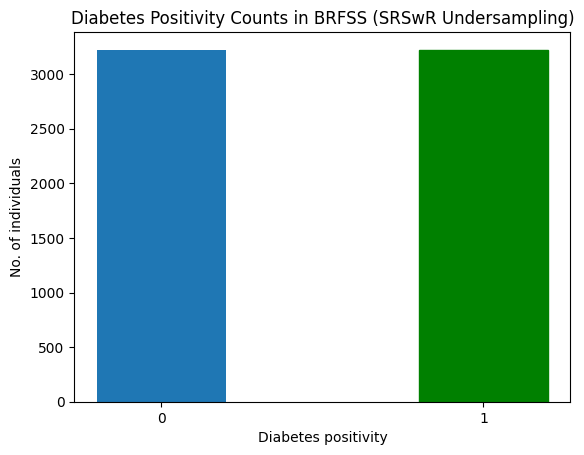

In [ ]:
barlist = plt.bar([str(0),str(1)], y_S_SRSwR.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (SRSwR Undersampling)")
plt.show()

In [ ]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (5158, 15)
y_S_train: (5158,)
X_S_test: (1290, 15)
y_S_test: (1290,)


In [ ]:
model_source_SRSwR = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_244"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1708 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1709 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1710 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1711 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1712 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1713 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1714 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - AUC: 0.6372 - loss: 0.6745 - val_AUC: 0.7747 - val_loss: 0.5786
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8326 - loss: 0.5098 - val_AUC: 0.8769 - val_loss: 0.4411
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8941 - loss: 0.4114 - val_AUC: 0.8844 - val_loss: 0.4597
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8942 - loss: 0.4109 - val_AUC: 0.8889 - val_loss: 0.4254
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8972 - loss: 0.4035 - val_AUC: 0.8885 - val_loss: 0.4189
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8980 - loss: 0.3995 - val_AUC: 0.8884 - val_loss: 0.4187
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9017 - loss: 0.3942 - val_AUC: 0.8911 - val_loss: 0.4153
Epoch 8/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9059 - loss: 0.3823 - val_AUC: 0.8854 - val_loss: 0.4339
Epoch 9/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AU

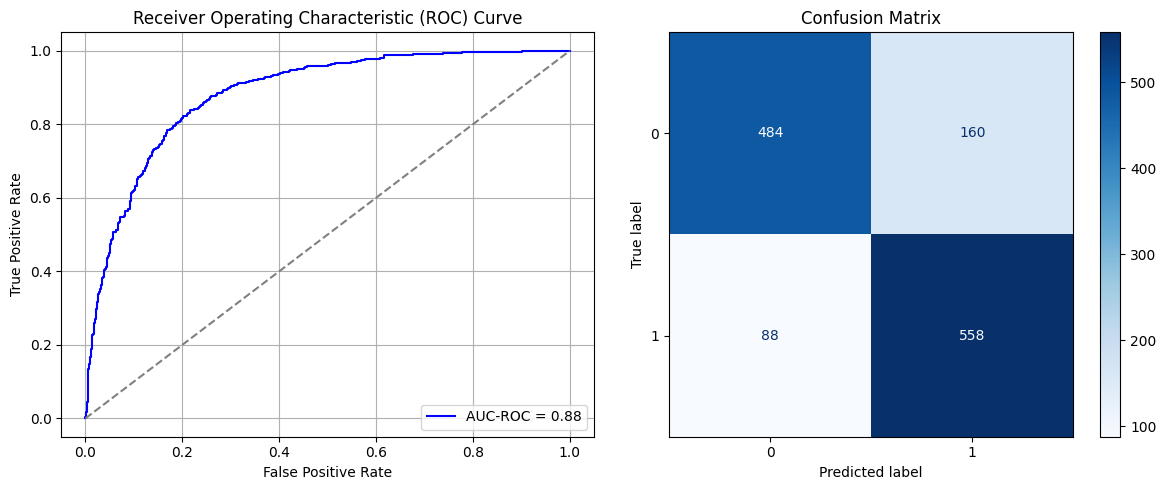

Best threshold based on F1-score: 0.4735007584095001
Time elapsed (performance): 10.795663912000236


<Sequential name=sequential_244, built=True>

In [ ]:
train_and_evaluate(model_source_SRSwR, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC-ROC: 0.6942064938436135
Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.45      0.60      1293
         1.0       0.25      0.82      0.38       289

    accuracy                           0.52      1582
   macro avg       0.58      0.64      0.49      1582
weighted avg       0.80      0.52      0.56      1582

FPR 0.5498839907192575 TPR: 0.8200692041522492 FNR: 0.17993079584775087 TNR: 0.45011600928074247


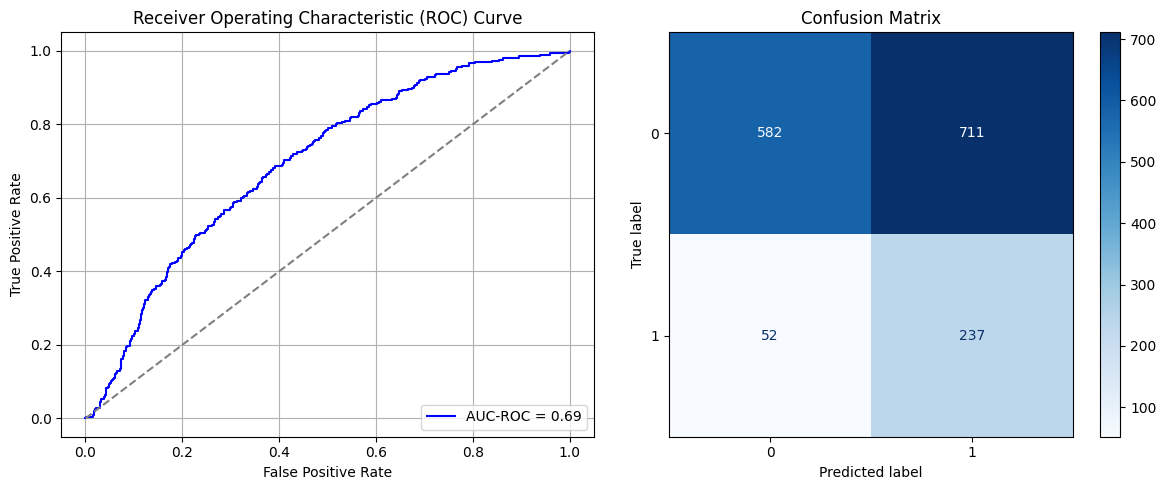

Best threshold based on F1-score: 0.9782111644744873
False Negative Rate: 0.17993079584775087
Time elapsed (performance): 0.7384340389999124


<ipython-input-311-de1f6cb50f3b>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [ ]:
Transductive_TL(model_source_SRSwR, X_T_test, y_T_test, "Target")

In [ ]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_245"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1715 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1716 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1717 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1718 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1719 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1720 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1721 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.6647 - loss: 0.6046 - val_AUC: 0.6493 - val_loss: 0.4495
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6900 - loss: 0.4396 - val_AUC: 0.6602 - val_loss: 0.4439
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7092 - loss: 0.4321 - val_AUC: 0.6682 - val_loss: 0.4433
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7088 - loss: 0.4421 - val_AUC: 0.6776 - val_loss: 0.4394
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7143 - loss: 0.4302 - val_AUC: 0.6890 - val_loss: 0.4339
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7198 - loss: 0.4349 - val_AUC: 0.6963 - val_loss: 0.4310
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7300 - loss: 0.4206 - val_AUC: 0.6995 - val_loss: 0.4314
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7305 - loss: 0.4338 - val_AUC: 0.7022 - val_loss: 0.4292
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7398 -

(np.float64(0.0069605568445475635), np.float64(0.9965397923875432))

In [ ]:
fine_tuning(X_T_train_SRSwR, X_T_test, y_T_train_SRSwR, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_246"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1722 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1723 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1724 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1725 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1726 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1727 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1728 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6773 - loss: 0.7095 - val_AUC: 0.0000e+00 - val_loss: 0.9768
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7195 - loss: 0.5904 - val_AUC: 0.0000e+00 - val_loss: 0.9036
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6917 - loss: 0.6049 - val_AUC: 0.0000e+00 - val_loss: 0.9225
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7073 - loss: 0.6007 - val_AUC: 0.0000e+00 - val_loss: 0.9705
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7224 - loss: 0.5851 - val_AUC: 0.0000e+00 - val_loss: 0.7735
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7228 - loss: 0.5913 - val_AUC: 0.0000e+00 - val_loss: 0.8911
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7309 - loss: 0.5866 - val_AUC: 0.0000e+00 - val_loss: 0.8644
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7364 - loss: 0.5869 - val_AUC: 0.0000e+00 - val_loss: 0.9060
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

(np.float64(0.2188708430007734), np.float64(0.41522491349480967))

In [ ]:
times = 50

FPR = []
FNR = []

for i in range(times):
    # X_T_train_SRSwR, y_T_train_SRSwR = SRSwR_undersampler(T_train, T_train.iloc[:,-1])
    fpr, fnr = fine_tuning(X_T_train_SRSwR, X_T_test, y_T_train_SRSwR, y_T_test, 0, 4)
    # print(output)
    FPR.append(fpr)
    FNR.append(fnr)

ParamFit = pd.DataFrame([FPR, FNR]).T
ParamFit.columns=['FPR', 'FNR']

# fine_tuning(X_T_train_SRSwR, X_T_test, y_T_train_SRSwR, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_249"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1743 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1744 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1745 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1746 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1747 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1748 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1749 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - AUC: 0.6844 - loss: 0.7329 - val_AUC: 0.0000e+00 - val_loss: 0.9692
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7113 - loss: 0.5875 - val_AUC: 0.0000e+00 - val_loss: 0.8941
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6951 - loss: 0.6117 - val_AUC: 0.0000e+00 - val_loss: 0.9399
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7146 - loss: 0.5966 - val_AUC: 0.0000e+00 - val_loss: 0.9517
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7241 - loss: 0.5935 - val_AUC: 0.0000e+00 - val_loss: 0.9048
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7270 - loss: 0.5915 - val_AUC: 0.0000e+00 - val_loss: 0.8504
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7243 - loss: 0.5866 - val_AUC: 0.0000e+00 - val_loss: 0.9129
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7344 - loss: 0.5867 - val_AUC: 0.0000e+00 - val_loss: 0.9190
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_250"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1750 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1751 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1752 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1753 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1754 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1755 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1756 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6942 - loss: 0.7158 - val_AUC: 0.0000e+00 - val_loss: 0.9861
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6977 - loss: 0.6139 - val_AUC: 0.0000e+00 - val_loss: 0.9621
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6882 - loss: 0.6032 - val_AUC: 0.0000e+00 - val_loss: 0.9058
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7189 - loss: 0.5810 - val_AUC: 0.0000e+00 - val_loss: 0.8467
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7199 - loss: 0.5922 - val_AUC: 0.0000e+00 - val_loss: 0.9292
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7258 - loss: 0.5875 - val_AUC: 0.0000e+00 - val_loss: 0.8830
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7343 - loss: 0.5764 - val_AUC: 0.0000e+00 - val_loss: 0.8439
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7295 - loss: 0.5911 - val_AUC: 0.0000e+00 - val_loss: 0.9188
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_251"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1757 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1758 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1759 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1760 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1761 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1762 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1763 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6760 - loss: 0.7207 - val_AUC: 0.0000e+00 - val_loss: 0.9513
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6977 - loss: 0.6126 - val_AUC: 0.0000e+00 - val_loss: 0.8948
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7010 - loss: 0.6043 - val_AUC: 0.0000e+00 - val_loss: 0.8970
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7069 - loss: 0.6034 - val_AUC: 0.0000e+00 - val_loss: 0.8978
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7252 - loss: 0.5830 - val_AUC: 0.0000e+00 - val_loss: 0.9750
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7246 - loss: 0.5865 - val_AUC: 0.0000e+00 - val_loss: 0.8195
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7122 - loss: 0.5941 - val_AUC: 0.0000e+00 - val_loss: 0.8487
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7316 - loss: 0.5785 - val_AUC: 0.0000e+00 - val_loss: 0.9084
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_252"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1764 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1765 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1766 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1767 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1768 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1769 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1770 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6904 - loss: 0.7050 - val_AUC: 0.0000e+00 - val_loss: 0.9724
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7048 - loss: 0.6026 - val_AUC: 0.0000e+00 - val_loss: 0.9229
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7050 - loss: 0.6051 - val_AUC: 0.0000e+00 - val_loss: 0.8655
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7180 - loss: 0.5945 - val_AUC: 0.0000e+00 - val_loss: 0.8659
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7298 - loss: 0.5902 - val_AUC: 0.0000e+00 - val_loss: 0.9257
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7440 - loss: 0.5763 - val_AUC: 0.0000e+00 - val_loss: 0.9012
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7233 - loss: 0.5959 - val_AUC: 0.0000e+00 - val_loss: 0.9087
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7173 - loss: 0.5920 - val_AUC: 0.0000e+00 - val_loss: 0.9245
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_253"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1771 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1772 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1773 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1774 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1775 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1776 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1777 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - AUC: 0.6781 - loss: 0.7258 - val_AUC: 0.0000e+00 - val_loss: 1.0094
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6894 - loss: 0.6217 - val_AUC: 0.0000e+00 - val_loss: 0.9817
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7059 - loss: 0.6113 - val_AUC: 0.0000e+00 - val_loss: 0.9422
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7159 - loss: 0.5985 - val_AUC: 0.0000e+00 - val_loss: 0.9245
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7208 - loss: 0.5909 - val_AUC: 0.0000e+00 - val_loss: 0.8840
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7267 - loss: 0.5890 - val_AUC: 0.0000e+00 - val_loss: 0.8491
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7130 - loss: 0.5981 - val_AUC: 0.0000e+00 - val_loss: 0.8458
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7360 - loss: 0.5805 - val_AUC: 0.0000e+00 - val_loss: 1.0038
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_254"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1778 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1779 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1780 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1781 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1782 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1783 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1784 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6957 - loss: 0.7058 - val_AUC: 0.0000e+00 - val_loss: 0.9710
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6838 - loss: 0.6362 - val_AUC: 0.0000e+00 - val_loss: 0.9882
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7112 - loss: 0.5983 - val_AUC: 0.0000e+00 - val_loss: 0.9496
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6969 - loss: 0.6092 - val_AUC: 0.0000e+00 - val_loss: 0.8714
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7197 - loss: 0.5962 - val_AUC: 0.0000e+00 - val_loss: 0.9339
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7302 - loss: 0.5868 - val_AUC: 0.0000e+00 - val_loss: 0.8907
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7367 - loss: 0.5906 - val_AUC: 0.0000e+00 - val_loss: 0.9959
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7365 - loss: 0.5810 - val_AUC: 0.0000e+00 - val_loss: 0.8615
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_255"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1785 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1786 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1787 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1788 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1789 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1790 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1791 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - AUC: 0.6949 - loss: 0.6987 - val_AUC: 0.0000e+00 - val_loss: 0.9800
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7104 - loss: 0.5967 - val_AUC: 0.0000e+00 - val_loss: 0.9005
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7002 - loss: 0.5994 - val_AUC: 0.0000e+00 - val_loss: 0.8648
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7174 - loss: 0.5970 - val_AUC: 0.0000e+00 - val_loss: 0.8912
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7256 - loss: 0.5897 - val_AUC: 0.0000e+00 - val_loss: 0.8707
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7057 - loss: 0.6000 - val_AUC: 0.0000e+00 - val_loss: 0.8820
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7313 - loss: 0.5864 - val_AUC: 0.0000e+00 - val_loss: 0.9079
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7426 - loss: 0.5772 - val_AUC: 0.0000e+00 - val_loss: 0.9545
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_256"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1792 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1793 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1794 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1795 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1796 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1797 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1798 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6908 - loss: 0.7097 - val_AUC: 0.0000e+00 - val_loss: 0.9594
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7044 - loss: 0.6019 - val_AUC: 0.0000e+00 - val_loss: 0.8789
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7024 - loss: 0.6103 - val_AUC: 0.0000e+00 - val_loss: 0.9356
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7197 - loss: 0.5885 - val_AUC: 0.0000e+00 - val_loss: 0.8848
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7245 - loss: 0.5933 - val_AUC: 0.0000e+00 - val_loss: 0.9051
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7263 - loss: 0.5998 - val_AUC: 0.0000e+00 - val_loss: 0.9824
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7169 - loss: 0.5898 - val_AUC: 0.0000e+00 - val_loss: 0.7842
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7355 - loss: 0.5863 - val_AUC: 0.0000e+00 - val_loss: 0.9394
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_257"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1799 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1800 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1801 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1802 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1803 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1804 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1805 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6752 - loss: 0.7334 - val_AUC: 0.0000e+00 - val_loss: 1.0354
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7080 - loss: 0.6020 - val_AUC: 0.0000e+00 - val_loss: 0.9473
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7137 - loss: 0.5930 - val_AUC: 0.0000e+00 - val_loss: 0.9599
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7234 - loss: 0.5887 - val_AUC: 0.0000e+00 - val_loss: 0.9174
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7380 - loss: 0.5778 - val_AUC: 0.0000e+00 - val_loss: 0.8386
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7594 - loss: 0.5673 - val_AUC: 0.0000e+00 - val_loss: 0.8227
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7243 - loss: 0.5979 - val_AUC: 0.0000e+00 - val_loss: 0.9032
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7317 - loss: 0.5787 - val_AUC: 0.0000e+00 - val_loss: 0.8331
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_258"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1806 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1807 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1808 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1809 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1810 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1811 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1812 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6981 - loss: 0.6929 - val_AUC: 0.0000e+00 - val_loss: 0.9396
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7096 - loss: 0.5984 - val_AUC: 0.0000e+00 - val_loss: 0.8547
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7175 - loss: 0.5835 - val_AUC: 0.0000e+00 - val_loss: 0.8553
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7263 - loss: 0.5916 - val_AUC: 0.0000e+00 - val_loss: 0.9891
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7108 - loss: 0.5998 - val_AUC: 0.0000e+00 - val_loss: 0.8785
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7148 - loss: 0.5945 - val_AUC: 0.0000e+00 - val_loss: 0.8626
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7407 - loss: 0.5762 - val_AUC: 0.0000e+00 - val_loss: 0.9334
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7571 - loss: 0.5706 - val_AUC: 0.0000e+00 - val_loss: 0.9394
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_259"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1813 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1814 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1815 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1816 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1817 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1818 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1819 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6958 - loss: 0.6981 - val_AUC: 0.0000e+00 - val_loss: 0.9630
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7055 - loss: 0.6040 - val_AUC: 0.0000e+00 - val_loss: 0.8805
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7010 - loss: 0.6053 - val_AUC: 0.0000e+00 - val_loss: 0.8738
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7067 - loss: 0.6063 - val_AUC: 0.0000e+00 - val_loss: 0.9608
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7169 - loss: 0.5930 - val_AUC: 0.0000e+00 - val_loss: 0.9175
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7294 - loss: 0.5816 - val_AUC: 0.0000e+00 - val_loss: 0.9213
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7394 - loss: 0.5805 - val_AUC: 0.0000e+00 - val_loss: 0.8604
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7393 - loss: 0.5739 - val_AUC: 0.0000e+00 - val_loss: 0.9366
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_260"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1820 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1821 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1822 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1823 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1824 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1825 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1826 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6746 - loss: 0.7332 - val_AUC: 0.0000e+00 - val_loss: 1.0401
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7026 - loss: 0.6044 - val_AUC: 0.0000e+00 - val_loss: 0.9418
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6899 - loss: 0.6099 - val_AUC: 0.0000e+00 - val_loss: 0.8448
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7001 - loss: 0.6128 - val_AUC: 0.0000e+00 - val_loss: 0.9736
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7136 - loss: 0.6013 - val_AUC: 0.0000e+00 - val_loss: 0.9135
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7174 - loss: 0.5913 - val_AUC: 0.0000e+00 - val_loss: 0.8339
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7082 - loss: 0.6026 - val_AUC: 0.0000e+00 - val_loss: 0.8830
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7206 - loss: 0.5866 - val_AUC: 0.0000e+00 - val_loss: 0.8245
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_261"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1827 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1828 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1829 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1830 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1831 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1832 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1833 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6798 - loss: 0.7209 - val_AUC: 0.0000e+00 - val_loss: 0.9570
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7004 - loss: 0.6116 - val_AUC: 0.0000e+00 - val_loss: 0.9335
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6987 - loss: 0.5978 - val_AUC: 0.0000e+00 - val_loss: 0.9579
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7255 - loss: 0.5893 - val_AUC: 0.0000e+00 - val_loss: 0.8808
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7284 - loss: 0.5899 - val_AUC: 0.0000e+00 - val_loss: 0.9551
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7170 - loss: 0.5906 - val_AUC: 0.0000e+00 - val_loss: 0.7405
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7389 - loss: 0.5713 - val_AUC: 0.0000e+00 - val_loss: 0.8384
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7321 - loss: 0.5879 - val_AUC: 0.0000e+00 - val_loss: 0.9267
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_262"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1834 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1835 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1836 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1837 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1838 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1839 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1840 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6962 - loss: 0.7000 - val_AUC: 0.0000e+00 - val_loss: 0.9885
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7108 - loss: 0.5952 - val_AUC: 0.0000e+00 - val_loss: 0.9280
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7188 - loss: 0.5911 - val_AUC: 0.0000e+00 - val_loss: 0.9558
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7069 - loss: 0.6001 - val_AUC: 0.0000e+00 - val_loss: 0.8061
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7183 - loss: 0.5971 - val_AUC: 0.0000e+00 - val_loss: 0.9650
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7439 - loss: 0.5828 - val_AUC: 0.0000e+00 - val_loss: 0.9676
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7308 - loss: 0.5918 - val_AUC: 0.0000e+00 - val_loss: 0.9555
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7404 - loss: 0.5830 - val_AUC: 0.0000e+00 - val_loss: 0.9768
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_263"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1841 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1842 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1843 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1844 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1845 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1846 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1847 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7083 - loss: 0.6776 - val_AUC: 0.0000e+00 - val_loss: 1.0873
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6896 - loss: 0.6292 - val_AUC: 0.0000e+00 - val_loss: 0.9708
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7064 - loss: 0.5989 - val_AUC: 0.0000e+00 - val_loss: 0.8833
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7248 - loss: 0.5855 - val_AUC: 0.0000e+00 - val_loss: 0.8670
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7209 - loss: 0.5878 - val_AUC: 0.0000e+00 - val_loss: 0.8462
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7264 - loss: 0.5852 - val_AUC: 0.0000e+00 - val_loss: 0.8470
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7313 - loss: 0.5816 - val_AUC: 0.0000e+00 - val_loss: 0.8592
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7330 - loss: 0.5817 - val_AUC: 0.0000e+00 - val_loss: 0.9355
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_264"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1848 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1849 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1850 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1851 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1852 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1853 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1854 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - AUC: 0.6914 - loss: 0.7175 - val_AUC: 0.0000e+00 - val_loss: 0.9337
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6750 - loss: 0.6355 - val_AUC: 0.0000e+00 - val_loss: 0.9666
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7014 - loss: 0.6053 - val_AUC: 0.0000e+00 - val_loss: 0.8969
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7050 - loss: 0.6032 - val_AUC: 0.0000e+00 - val_loss: 0.9854
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7259 - loss: 0.5901 - val_AUC: 0.0000e+00 - val_loss: 0.9494
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7055 - loss: 0.6119 - val_AUC: 0.0000e+00 - val_loss: 0.9581
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7305 - loss: 0.5869 - val_AUC: 0.0000e+00 - val_loss: 0.8613
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7196 - loss: 0.5958 - val_AUC: 0.0000e+00 - val_loss: 0.9057
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_265"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1855 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1856 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1857 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1858 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1859 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1860 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1861 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - AUC: 0.6737 - loss: 0.7242 - val_AUC: 0.0000e+00 - val_loss: 0.9818
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7140 - loss: 0.6062 - val_AUC: 0.0000e+00 - val_loss: 0.9603
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6892 - loss: 0.6163 - val_AUC: 0.0000e+00 - val_loss: 0.9914
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7215 - loss: 0.6016 - val_AUC: 0.0000e+00 - val_loss: 0.9617
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7099 - loss: 0.6068 - val_AUC: 0.0000e+00 - val_loss: 0.9337
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7105 - loss: 0.5898 - val_AUC: 0.0000e+00 - val_loss: 0.8525
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7410 - loss: 0.5778 - val_AUC: 0.0000e+00 - val_loss: 0.8699
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7412 - loss: 0.5828 - val_AUC: 0.0000e+00 - val_loss: 0.8687
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_266"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1862 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1863 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1864 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1865 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1866 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1867 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1868 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - AUC: 0.6904 - loss: 0.7075 - val_AUC: 0.0000e+00 - val_loss: 0.9833
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7029 - loss: 0.6027 - val_AUC: 0.0000e+00 - val_loss: 0.9203
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7170 - loss: 0.5957 - val_AUC: 0.0000e+00 - val_loss: 0.9080
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7041 - loss: 0.6039 - val_AUC: 0.0000e+00 - val_loss: 0.8783
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7136 - loss: 0.5980 - val_AUC: 0.0000e+00 - val_loss: 0.9070
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7331 - loss: 0.5801 - val_AUC: 0.0000e+00 - val_loss: 0.9813
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7433 - loss: 0.5847 - val_AUC: 0.0000e+00 - val_loss: 0.9834
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7599 - loss: 0.5600 - val_AUC: 0.0000e+00 - val_loss: 0.8908
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_267"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1869 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1870 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1871 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1872 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1873 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1874 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1875 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6988 - loss: 0.6964 - val_AUC: 0.0000e+00 - val_loss: 1.0187
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6875 - loss: 0.6314 - val_AUC: 0.0000e+00 - val_loss: 1.0677
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7115 - loss: 0.6027 - val_AUC: 0.0000e+00 - val_loss: 0.9369
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7177 - loss: 0.5980 - val_AUC: 0.0000e+00 - val_loss: 0.9554
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7213 - loss: 0.5969 - val_AUC: 0.0000e+00 - val_loss: 0.9075
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7059 - loss: 0.5998 - val_AUC: 0.0000e+00 - val_loss: 0.8925
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7242 - loss: 0.5901 - val_AUC: 0.0000e+00 - val_loss: 0.9260
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7467 - loss: 0.5691 - val_AUC: 0.0000e+00 - val_loss: 0.9201
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_268"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1876 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1877 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1878 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1879 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1880 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1881 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1882 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7045 - loss: 0.6837 - val_AUC: 0.0000e+00 - val_loss: 1.0626
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6867 - loss: 0.6199 - val_AUC: 0.0000e+00 - val_loss: 0.8893
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7277 - loss: 0.5899 - val_AUC: 0.0000e+00 - val_loss: 0.9554
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7310 - loss: 0.5802 - val_AUC: 0.0000e+00 - val_loss: 0.8910
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7122 - loss: 0.5978 - val_AUC: 0.0000e+00 - val_loss: 0.9072
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7146 - loss: 0.5917 - val_AUC: 0.0000e+00 - val_loss: 0.8174
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7316 - loss: 0.5819 - val_AUC: 0.0000e+00 - val_loss: 0.8454
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7328 - loss: 0.5821 - val_AUC: 0.0000e+00 - val_loss: 0.8006
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_269"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1883 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1884 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1885 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1886 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1887 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1888 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1889 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6832 - loss: 0.7356 - val_AUC: 0.0000e+00 - val_loss: 0.9685
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7033 - loss: 0.6054 - val_AUC: 0.0000e+00 - val_loss: 0.9579
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6940 - loss: 0.6157 - val_AUC: 0.0000e+00 - val_loss: 0.9975
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7360 - loss: 0.5880 - val_AUC: 0.0000e+00 - val_loss: 0.9127
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7255 - loss: 0.5952 - val_AUC: 0.0000e+00 - val_loss: 0.8617
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7420 - loss: 0.5796 - val_AUC: 0.0000e+00 - val_loss: 0.8739
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7128 - loss: 0.6041 - val_AUC: 0.0000e+00 - val_loss: 0.8620
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7180 - loss: 0.5959 - val_AUC: 0.0000e+00 - val_loss: 0.9098
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_270"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1890 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1891 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1892 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1893 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1894 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1895 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1896 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6981 - loss: 0.6955 - val_AUC: 0.0000e+00 - val_loss: 1.0207
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6863 - loss: 0.6224 - val_AUC: 0.0000e+00 - val_loss: 0.9536
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7008 - loss: 0.6056 - val_AUC: 0.0000e+00 - val_loss: 0.9461
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7302 - loss: 0.5859 - val_AUC: 0.0000e+00 - val_loss: 0.9144
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7404 - loss: 0.5807 - val_AUC: 0.0000e+00 - val_loss: 0.9224
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7494 - loss: 0.5749 - val_AUC: 0.0000e+00 - val_loss: 0.9401
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7225 - loss: 0.5939 - val_AUC: 0.0000e+00 - val_loss: 0.8736
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7446 - loss: 0.5801 - val_AUC: 0.0000e+00 - val_loss: 0.9401
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_271"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1897 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1898 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1899 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1900 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1901 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1902 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1903 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6855 - loss: 0.7089 - val_AUC: 0.0000e+00 - val_loss: 1.0184
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7018 - loss: 0.6094 - val_AUC: 0.0000e+00 - val_loss: 0.9520
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7067 - loss: 0.5998 - val_AUC: 0.0000e+00 - val_loss: 0.9394
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7109 - loss: 0.6069 - val_AUC: 0.0000e+00 - val_loss: 0.9979
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7137 - loss: 0.6009 - val_AUC: 0.0000e+00 - val_loss: 0.8199
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7429 - loss: 0.5728 - val_AUC: 0.0000e+00 - val_loss: 0.8905
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7360 - loss: 0.5784 - val_AUC: 0.0000e+00 - val_loss: 1.0022
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7420 - loss: 0.5739 - val_AUC: 0.0000e+00 - val_loss: 0.8186
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_272"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1904 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1905 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1906 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1907 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1908 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1909 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1910 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.7031 - loss: 0.6780 - val_AUC: 0.0000e+00 - val_loss: 0.9996
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7103 - loss: 0.5978 - val_AUC: 0.0000e+00 - val_loss: 0.9128
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6999 - loss: 0.5977 - val_AUC: 0.0000e+00 - val_loss: 0.8428
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7191 - loss: 0.5934 - val_AUC: 0.0000e+00 - val_loss: 0.8926
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7265 - loss: 0.5878 - val_AUC: 0.0000e+00 - val_loss: 0.8908
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7343 - loss: 0.5874 - val_AUC: 0.0000e+00 - val_loss: 0.9318
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7461 - loss: 0.5851 - val_AUC: 0.0000e+00 - val_loss: 0.9708
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7505 - loss: 0.5704 - val_AUC: 0.0000e+00 - val_loss: 0.9041
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_273"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1911 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1912 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1913 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1914 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1915 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1916 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1917 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7063 - loss: 0.6755 - val_AUC: 0.0000e+00 - val_loss: 1.0409
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6942 - loss: 0.6198 - val_AUC: 0.0000e+00 - val_loss: 0.9375
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7030 - loss: 0.6054 - val_AUC: 0.0000e+00 - val_loss: 1.0203
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7212 - loss: 0.5888 - val_AUC: 0.0000e+00 - val_loss: 0.9349
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7152 - loss: 0.5913 - val_AUC: 0.0000e+00 - val_loss: 0.9494
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7382 - loss: 0.5807 - val_AUC: 0.0000e+00 - val_loss: 0.8832
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7351 - loss: 0.5781 - val_AUC: 0.0000e+00 - val_loss: 0.8928
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7424 - loss: 0.5778 - val_AUC: 0.0000e+00 - val_loss: 0.8949
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_274"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1918 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1919 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1920 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1921 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1922 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1923 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1924 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6813 - loss: 0.7167 - val_AUC: 0.0000e+00 - val_loss: 0.8895
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7077 - loss: 0.6097 - val_AUC: 0.0000e+00 - val_loss: 1.0223
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6790 - loss: 0.6091 - val_AUC: 0.0000e+00 - val_loss: 0.8452
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7183 - loss: 0.5854 - val_AUC: 0.0000e+00 - val_loss: 0.8751
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7158 - loss: 0.6016 - val_AUC: 0.0000e+00 - val_loss: 0.8867
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7355 - loss: 0.5745 - val_AUC: 0.0000e+00 - val_loss: 0.7241
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7135 - loss: 0.5924 - val_AUC: 0.0000e+00 - val_loss: 0.8625
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7375 - loss: 0.5796 - val_AUC: 0.0000e+00 - val_loss: 0.8368
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_275"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1925 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1926 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1927 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1928 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1929 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1930 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1931 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - AUC: 0.6768 - loss: 0.7209 - val_AUC: 0.0000e+00 - val_loss: 0.9935
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6813 - loss: 0.6235 - val_AUC: 0.0000e+00 - val_loss: 0.9702
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6885 - loss: 0.6056 - val_AUC: 0.0000e+00 - val_loss: 0.8926
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6863 - loss: 0.6088 - val_AUC: 0.0000e+00 - val_loss: 0.8949
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7103 - loss: 0.5932 - val_AUC: 0.0000e+00 - val_loss: 0.9038
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7159 - loss: 0.5949 - val_AUC: 0.0000e+00 - val_loss: 0.9970
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7234 - loss: 0.5924 - val_AUC: 0.0000e+00 - val_loss: 0.9422
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7483 - loss: 0.5777 - val_AUC: 0.0000e+00 - val_loss: 0.9471
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_276"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1932 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1933 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1934 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1935 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1936 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1937 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1938 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6858 - loss: 0.7044 - val_AUC: 0.0000e+00 - val_loss: 1.0072
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6916 - loss: 0.6199 - val_AUC: 0.0000e+00 - val_loss: 0.9696
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7048 - loss: 0.6042 - val_AUC: 0.0000e+00 - val_loss: 0.9163
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7082 - loss: 0.5997 - val_AUC: 0.0000e+00 - val_loss: 0.8735
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7212 - loss: 0.6010 - val_AUC: 0.0000e+00 - val_loss: 1.0136
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7063 - loss: 0.5879 - val_AUC: 0.0000e+00 - val_loss: 0.8101
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7046 - loss: 0.5954 - val_AUC: 0.0000e+00 - val_loss: 0.7735
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7404 - loss: 0.5768 - val_AUC: 0.0000e+00 - val_loss: 0.8010
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_277"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1939 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1940 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1941 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1942 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1943 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1944 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1945 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - AUC: 0.6993 - loss: 0.7039 - val_AUC: 0.0000e+00 - val_loss: 0.9919
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7182 - loss: 0.5991 - val_AUC: 0.0000e+00 - val_loss: 0.9223
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.6992 - loss: 0.6079 - val_AUC: 0.0000e+00 - val_loss: 0.9502
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7243 - loss: 0.5891 - val_AUC: 0.0000e+00 - val_loss: 0.9310
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7258 - loss: 0.5871 - val_AUC: 0.0000e+00 - val_loss: 0.9849
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7218 - loss: 0.5912 - val_AUC: 0.0000e+00 - val_loss: 0.8686
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7211 - loss: 0.5969 - val_AUC: 0.0000e+00 - val_loss: 0.9964
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7343 - loss: 0.5874 - val_AUC: 0.0000e+00 - val_loss: 0.9439
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_278"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1946 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1947 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1948 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1949 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1950 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1951 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1952 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6880 - loss: 0.7131 - val_AUC: 0.0000e+00 - val_loss: 0.9822
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7078 - loss: 0.6007 - val_AUC: 0.0000e+00 - val_loss: 0.8821
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7062 - loss: 0.6032 - val_AUC: 0.0000e+00 - val_loss: 0.9637
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7184 - loss: 0.5906 - val_AUC: 0.0000e+00 - val_loss: 0.8657
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7145 - loss: 0.5876 - val_AUC: 0.0000e+00 - val_loss: 0.8328
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7308 - loss: 0.5869 - val_AUC: 0.0000e+00 - val_loss: 0.8931
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7278 - loss: 0.5777 - val_AUC: 0.0000e+00 - val_loss: 0.7863
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7277 - loss: 0.5848 - val_AUC: 0.0000e+00 - val_loss: 0.9161
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_279"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1953 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1954 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1955 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1956 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1957 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1958 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1959 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6782 - loss: 0.7206 - val_AUC: 0.0000e+00 - val_loss: 0.9740
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6741 - loss: 0.6357 - val_AUC: 0.0000e+00 - val_loss: 1.0181
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7181 - loss: 0.5929 - val_AUC: 0.0000e+00 - val_loss: 0.9166
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7306 - loss: 0.5903 - val_AUC: 0.0000e+00 - val_loss: 0.9055
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7118 - loss: 0.5906 - val_AUC: 0.0000e+00 - val_loss: 0.9098
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7183 - loss: 0.5933 - val_AUC: 0.0000e+00 - val_loss: 0.9245
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7198 - loss: 0.6078 - val_AUC: 0.0000e+00 - val_loss: 0.9431
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7300 - loss: 0.5840 - val_AUC: 0.0000e+00 - val_loss: 1.0150
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_280"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1960 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1961 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1962 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1963 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1964 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1965 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1966 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6921 - loss: 0.7141 - val_AUC: 0.0000e+00 - val_loss: 0.9953
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7010 - loss: 0.5960 - val_AUC: 0.0000e+00 - val_loss: 0.8065
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7161 - loss: 0.6018 - val_AUC: 0.0000e+00 - val_loss: 0.9260
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7321 - loss: 0.5809 - val_AUC: 0.0000e+00 - val_loss: 0.8764
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7308 - loss: 0.5874 - val_AUC: 0.0000e+00 - val_loss: 0.9022
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7414 - loss: 0.5884 - val_AUC: 0.0000e+00 - val_loss: 0.9980
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7227 - loss: 0.5915 - val_AUC: 0.0000e+00 - val_loss: 0.8375
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7419 - loss: 0.5757 - val_AUC: 0.0000e+00 - val_loss: 0.8553
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_281"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1967 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1968 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1969 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1970 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1971 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1972 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1973 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6896 - loss: 0.7217 - val_AUC: 0.0000e+00 - val_loss: 0.9523
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7113 - loss: 0.5932 - val_AUC: 0.0000e+00 - val_loss: 0.9033
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7175 - loss: 0.5964 - val_AUC: 0.0000e+00 - val_loss: 0.9009
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7150 - loss: 0.5947 - val_AUC: 0.0000e+00 - val_loss: 0.9309
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7037 - loss: 0.6144 - val_AUC: 0.0000e+00 - val_loss: 0.9653
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7163 - loss: 0.5941 - val_AUC: 0.0000e+00 - val_loss: 0.8319
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7172 - loss: 0.6005 - val_AUC: 0.0000e+00 - val_loss: 1.0083
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7280 - loss: 0.5902 - val_AUC: 0.0000e+00 - val_loss: 0.9150
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_282"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1974 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1975 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1976 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1977 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1978 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1979 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1980 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - AUC: 0.6809 - loss: 0.7227 - val_AUC: 0.0000e+00 - val_loss: 0.9473
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7089 - loss: 0.6042 - val_AUC: 0.0000e+00 - val_loss: 0.8685
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7099 - loss: 0.6035 - val_AUC: 0.0000e+00 - val_loss: 0.9632
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7175 - loss: 0.6001 - val_AUC: 0.0000e+00 - val_loss: 0.8760
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7183 - loss: 0.5940 - val_AUC: 0.0000e+00 - val_loss: 0.9766
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7084 - loss: 0.6007 - val_AUC: 0.0000e+00 - val_loss: 0.9380
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7187 - loss: 0.5968 - val_AUC: 0.0000e+00 - val_loss: 0.9096
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7238 - loss: 0.5864 - val_AUC: 0.0000e+00 - val_loss: 0.7857
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_283"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1981 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1982 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1983 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1984 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1985 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1986 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1987 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - AUC: 0.7159 - loss: 0.6693 - val_AUC: 0.0000e+00 - val_loss: 1.0102
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7065 - loss: 0.6020 - val_AUC: 0.0000e+00 - val_loss: 0.9510
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7159 - loss: 0.5925 - val_AUC: 0.0000e+00 - val_loss: 0.8758
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7330 - loss: 0.5937 - val_AUC: 0.0000e+00 - val_loss: 0.9764
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7328 - loss: 0.5856 - val_AUC: 0.0000e+00 - val_loss: 0.9412
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7301 - loss: 0.5846 - val_AUC: 0.0000e+00 - val_loss: 0.8614
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7321 - loss: 0.5900 - val_AUC: 0.0000e+00 - val_loss: 0.9040
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7378 - loss: 0.5815 - val_AUC: 0.0000e+00 - val_loss: 0.7815
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_284"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1988 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1989 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1990 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1991 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1992 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1993 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1994 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.6849 - loss: 0.7112 - val_AUC: 0.0000e+00 - val_loss: 0.9388
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6961 - loss: 0.6078 - val_AUC: 0.0000e+00 - val_loss: 0.9528
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7293 - loss: 0.5833 - val_AUC: 0.0000e+00 - val_loss: 0.8624
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7257 - loss: 0.5840 - val_AUC: 0.0000e+00 - val_loss: 0.8814
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7128 - loss: 0.6047 - val_AUC: 0.0000e+00 - val_loss: 0.9688
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7227 - loss: 0.5826 - val_AUC: 0.0000e+00 - val_loss: 0.9177
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7271 - loss: 0.5819 - val_AUC: 0.0000e+00 - val_loss: 0.9041
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.7198 - loss: 0.5915 - val_AUC: 0.0000e+00 - val_loss: 0.8285
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_285"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1995 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1996 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1997 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1998 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1999 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2000 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2001 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.6882 - loss: 0.7181 - val_AUC: 0.0000e+00 - val_loss: 1.0233
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6917 - loss: 0.6098 - val_AUC: 0.0000e+00 - val_loss: 0.9295
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7072 - loss: 0.6031 - val_AUC: 0.0000e+00 - val_loss: 0.9221
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7093 - loss: 0.6019 - val_AUC: 0.0000e+00 - val_loss: 0.9398
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7055 - loss: 0.6030 - val_AUC: 0.0000e+00 - val_loss: 0.8710
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6911 - loss: 0.6053 - val_AUC: 0.0000e+00 - val_loss: 0.8151
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7082 - loss: 0.5958 - val_AUC: 0.0000e+00 - val_loss: 0.8368
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7220 - loss: 0.5888 - val_AUC: 0.0000e+00 - val_loss: 0.8455
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_286"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2002 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2003 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2004 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2005 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2006 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2007 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2008 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.6778 - loss: 0.7319 - val_AUC: 0.0000e+00 - val_loss: 0.9643
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7053 - loss: 0.6030 - val_AUC: 0.0000e+00 - val_loss: 0.9306
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.6958 - loss: 0.6156 - val_AUC: 0.0000e+00 - val_loss: 0.9015
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7091 - loss: 0.5955 - val_AUC: 0.0000e+00 - val_loss: 0.8571
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7190 - loss: 0.6025 - val_AUC: 0.0000e+00 - val_loss: 1.0236
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7230 - loss: 0.5909 - val_AUC: 0.0000e+00 - val_loss: 0.9350
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7238 - loss: 0.5951 - val_AUC: 0.0000e+00 - val_loss: 0.9566
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7457 - loss: 0.5722 - val_AUC: 0.0000e+00 - val_loss: 0.8347
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_287"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2009 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2010 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2011 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2012 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2013 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2014 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2015 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7155 - loss: 0.6711 - val_AUC: 0.0000e+00 - val_loss: 1.0529
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7065 - loss: 0.6160 - val_AUC: 0.0000e+00 - val_loss: 1.0012
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7029 - loss: 0.6119 - val_AUC: 0.0000e+00 - val_loss: 0.9394
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6959 - loss: 0.6138 - val_AUC: 0.0000e+00 - val_loss: 0.8716
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7201 - loss: 0.5935 - val_AUC: 0.0000e+00 - val_loss: 0.8903
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7238 - loss: 0.5945 - val_AUC: 0.0000e+00 - val_loss: 0.8253
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7140 - loss: 0.5969 - val_AUC: 0.0000e+00 - val_loss: 0.8893
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7213 - loss: 0.5945 - val_AUC: 0.0000e+00 - val_loss: 0.9173
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_288"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2016 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2017 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2018 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2019 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2020 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2021 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2022 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - AUC: 0.6891 - loss: 0.7018 - val_AUC: 0.0000e+00 - val_loss: 0.9674
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.6928 - loss: 0.6129 - val_AUC: 0.0000e+00 - val_loss: 0.8994
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6920 - loss: 0.6061 - val_AUC: 0.0000e+00 - val_loss: 0.8757
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7086 - loss: 0.5922 - val_AUC: 0.0000e+00 - val_loss: 0.8421
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7207 - loss: 0.5922 - val_AUC: 0.0000e+00 - val_loss: 0.9297
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7164 - loss: 0.5862 - val_AUC: 0.0000e+00 - val_loss: 0.8480
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7153 - loss: 0.5938 - val_AUC: 0.0000e+00 - val_loss: 0.8455
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7194 - loss: 0.5889 - val_AUC: 0.0000e+00 - val_loss: 0.7947
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_289"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2023 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2024 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2025 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2026 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2027 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2028 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2029 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.7045 - loss: 0.6990 - val_AUC: 0.0000e+00 - val_loss: 0.9423
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6986 - loss: 0.6126 - val_AUC: 0.0000e+00 - val_loss: 0.9419
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7184 - loss: 0.5960 - val_AUC: 0.0000e+00 - val_loss: 0.9603
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7253 - loss: 0.5919 - val_AUC: 0.0000e+00 - val_loss: 0.8893
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7460 - loss: 0.5807 - val_AUC: 0.0000e+00 - val_loss: 0.9831
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7426 - loss: 0.5838 - val_AUC: 0.0000e+00 - val_loss: 0.9592
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7356 - loss: 0.5810 - val_AUC: 0.0000e+00 - val_loss: 0.8878
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7358 - loss: 0.5891 - val_AUC: 0.0000e+00 - val_loss: 0.9443
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_290"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2030 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2031 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2032 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2033 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2034 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2035 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2036 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.6909 - loss: 0.7111 - val_AUC: 0.0000e+00 - val_loss: 0.9839
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6711 - loss: 0.6345 - val_AUC: 0.0000e+00 - val_loss: 0.9759
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7139 - loss: 0.5817 - val_AUC: 0.0000e+00 - val_loss: 0.8308
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6971 - loss: 0.6131 - val_AUC: 0.0000e+00 - val_loss: 0.9397
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7063 - loss: 0.5941 - val_AUC: 0.0000e+00 - val_loss: 1.0013
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7222 - loss: 0.5960 - val_AUC: 0.0000e+00 - val_loss: 0.9015
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7376 - loss: 0.5782 - val_AUC: 0.0000e+00 - val_loss: 0.9024
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7374 - loss: 0.5793 - val_AUC: 0.0000e+00 - val_loss: 0.8688
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_291"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2037 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2038 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2039 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2040 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2041 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2042 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2043 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.6817 - loss: 0.7126 - val_AUC: 0.0000e+00 - val_loss: 0.9917
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6873 - loss: 0.6151 - val_AUC: 0.0000e+00 - val_loss: 0.8791
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6949 - loss: 0.6119 - val_AUC: 0.0000e+00 - val_loss: 0.9308
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7135 - loss: 0.5915 - val_AUC: 0.0000e+00 - val_loss: 0.8682
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7259 - loss: 0.5885 - val_AUC: 0.0000e+00 - val_loss: 0.9164
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7281 - loss: 0.5956 - val_AUC: 0.0000e+00 - val_loss: 0.9908
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7284 - loss: 0.5813 - val_AUC: 0.0000e+00 - val_loss: 0.9217
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7317 - loss: 0.5879 - val_AUC: 0.0000e+00 - val_loss: 0.9380
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_292"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2044 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2045 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2046 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2047 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2048 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2049 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2050 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.6757 - loss: 0.7247 - val_AUC: 0.0000e+00 - val_loss: 1.0165
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6924 - loss: 0.6149 - val_AUC: 0.0000e+00 - val_loss: 0.9623
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7146 - loss: 0.6053 - val_AUC: 0.0000e+00 - val_loss: 1.0007
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7064 - loss: 0.6006 - val_AUC: 0.0000e+00 - val_loss: 0.9341
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7289 - loss: 0.5881 - val_AUC: 0.0000e+00 - val_loss: 1.0194
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7198 - loss: 0.5899 - val_AUC: 0.0000e+00 - val_loss: 0.9000
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7413 - loss: 0.5780 - val_AUC: 0.0000e+00 - val_loss: 0.9328
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7379 - loss: 0.5789 - val_AUC: 0.0000e+00 - val_loss: 0.8244
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_293"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2051 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2052 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2053 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2054 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2055 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2056 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2057 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - AUC: 0.6831 - loss: 0.7270 - val_AUC: 0.0000e+00 - val_loss: 0.9782
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.6980 - loss: 0.6114 - val_AUC: 0.0000e+00 - val_loss: 1.0002
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.6819 - loss: 0.6098 - val_AUC: 0.0000e+00 - val_loss: 0.8615
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7286 - loss: 0.5911 - val_AUC: 0.0000e+00 - val_loss: 0.9114
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7046 - loss: 0.6053 - val_AUC: 0.0000e+00 - val_loss: 0.9707
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7289 - loss: 0.5830 - val_AUC: 0.0000e+00 - val_loss: 0.8539
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7406 - loss: 0.5810 - val_AUC: 0.0000e+00 - val_loss: 0.9323
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7279 - loss: 0.5829 - val_AUC: 0.0000e+00 - val_loss: 0.8786
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_294"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2058 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2059 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2060 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2061 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2062 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2063 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2064 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.7091 - loss: 0.6745 - val_AUC: 0.0000e+00 - val_loss: 1.0127
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6917 - loss: 0.6150 - val_AUC: 0.0000e+00 - val_loss: 0.9232
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7233 - loss: 0.5814 - val_AUC: 0.0000e+00 - val_loss: 0.8934
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7438 - loss: 0.5719 - val_AUC: 0.0000e+00 - val_loss: 0.9334
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6922 - loss: 0.6086 - val_AUC: 0.0000e+00 - val_loss: 0.8806
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7278 - loss: 0.5886 - val_AUC: 0.0000e+00 - val_loss: 0.8937
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7486 - loss: 0.5749 - val_AUC: 0.0000e+00 - val_loss: 0.8729
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7192 - loss: 0.5975 - val_AUC: 0.0000e+00 - val_loss: 0.8927
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_295"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2065 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2066 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2067 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2068 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2069 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2070 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2071 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.6964 - loss: 0.7040 - val_AUC: 0.0000e+00 - val_loss: 0.9799
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.6993 - loss: 0.6022 - val_AUC: 0.0000e+00 - val_loss: 0.9484
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6990 - loss: 0.6066 - val_AUC: 0.0000e+00 - val_loss: 0.8811
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7083 - loss: 0.6050 - val_AUC: 0.0000e+00 - val_loss: 0.9725
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7249 - loss: 0.5903 - val_AUC: 0.0000e+00 - val_loss: 0.8842
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7291 - loss: 0.5957 - val_AUC: 0.0000e+00 - val_loss: 0.9384
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7497 - loss: 0.5676 - val_AUC: 0.0000e+00 - val_loss: 0.8619
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7382 - loss: 0.5812 - val_AUC: 0.0000e+00 - val_loss: 0.8285
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_296"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2072 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2073 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2074 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2075 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2076 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2077 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2078 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.6956 - loss: 0.7011 - val_AUC: 0.0000e+00 - val_loss: 0.9581
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6947 - loss: 0.6105 - val_AUC: 0.0000e+00 - val_loss: 0.9507
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7268 - loss: 0.5955 - val_AUC: 0.0000e+00 - val_loss: 1.0210
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7107 - loss: 0.5995 - val_AUC: 0.0000e+00 - val_loss: 0.9291
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7115 - loss: 0.5944 - val_AUC: 0.0000e+00 - val_loss: 1.0062
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7247 - loss: 0.5863 - val_AUC: 0.0000e+00 - val_loss: 0.9055
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7399 - loss: 0.5860 - val_AUC: 0.0000e+00 - val_loss: 0.8415
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7262 - loss: 0.5870 - val_AUC: 0.0000e+00 - val_loss: 0.8597
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_297"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2079 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2080 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2081 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2082 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2083 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2084 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2085 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.6881 - loss: 0.7065 - val_AUC: 0.0000e+00 - val_loss: 1.0215
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6980 - loss: 0.6084 - val_AUC: 0.0000e+00 - val_loss: 0.9193
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6665 - loss: 0.6279 - val_AUC: 0.0000e+00 - val_loss: 0.9763
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6851 - loss: 0.6098 - val_AUC: 0.0000e+00 - val_loss: 0.9445
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7159 - loss: 0.5865 - val_AUC: 0.0000e+00 - val_loss: 0.8948
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7395 - loss: 0.5795 - val_AUC: 0.0000e+00 - val_loss: 0.9554
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7286 - loss: 0.5948 - val_AUC: 0.0000e+00 - val_loss: 0.8269
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7412 - loss: 0.5804 - val_AUC: 0.0000e+00 - val_loss: 0.9416
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_298"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2086 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2087 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2088 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2089 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2090 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2091 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2092 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6840 - loss: 0.7080 - val_AUC: 0.0000e+00 - val_loss: 0.9714
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6953 - loss: 0.6138 - val_AUC: 0.0000e+00 - val_loss: 0.9271
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.6916 - loss: 0.6132 - val_AUC: 0.0000e+00 - val_loss: 0.8562
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.6930 - loss: 0.6024 - val_AUC: 0.0000e+00 - val_loss: 0.8599
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7226 - loss: 0.5933 - val_AUC: 0.0000e+00 - val_loss: 0.9018
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7124 - loss: 0.5996 - val_AUC: 0.0000e+00 - val_loss: 0.9010
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7258 - loss: 0.5878 - val_AUC: 0.0000e+00 - val_loss: 0.9793
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7308 - loss: 0.5898 - val_AUC: 0.0000e+00 - val_loss: 0.9134
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

In [ ]:
print(ParamFit)
ParamFit.to_csv('SRSwR_Fine_Tuning.csv')

         FPR       FNR
0   0.239753  0.384083
1   0.222738  0.408304
2   0.222738  0.411765
3   0.163186  0.553633
4   0.204950  0.487889
5   0.187162  0.519031
6   0.175561  0.536332
7   0.139985  0.619377
8   0.209590  0.442907
9   0.198763  0.491349
10  0.201856  0.480969
11  0.184068  0.529412
12  0.198763  0.491349
13  0.193349  0.505190
14  0.112916  0.657439
15  0.181748  0.525952
16  0.208817  0.460208
17  0.197216  0.494810
18  0.105955  0.671280
19  0.182521  0.519031
20  0.190255  0.508651
21  0.154679  0.574394
22  0.212684  0.429066
23  0.140758  0.612457
24  0.189482  0.512111
25  0.111369  0.657439
26  0.212684  0.446367
27  0.146945  0.595156
28  0.208043  0.474048
29  0.186388  0.512111
30  0.150812  0.591696
31  0.179428  0.536332
32  0.201083  0.487889
33  0.206497  0.474048
34  0.241299  0.384083
35  0.191802  0.515571
36  0.188708  0.508651
37  0.249807  0.359862
38  0.149265  0.588235
39  0.240526  0.377163
40  0.238979  0.387543
41  0.174014  0.536332
42  0.21268

## Systematic Sampling:

First, we select a single systematic sample from the majority class, in which $k = \frac{N_0}{N_1}$, where $N_0$ is the majority class size in the source domain and $N_1$ is the minority class in the source domain.

In [ ]:
X_S_Sy, y_S_Sy = systematic_undersampler(data_S_full, data_S_full.iloc[:,-1])
print(y_S_Sy)

X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)
T_train = pd.concat([X_T_train, y_T_train], axis=1)

X_T_train_Sy, y_T_train_Sy = systematic_undersampler(T_train, T_train.iloc[:, -1])
print(y_T_train_Sy)


3224
32062
9.944789081885856
2
[1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 189, 199, 209, 219, 229, 239, 249, 259, 269, 279, 289, 299, 309, 319, 329, 339, 349, 359, 368, 378, 388, 398, 408, 418, 428, 438, 448, 458, 468, 478, 488, 498, 508, 518, 528, 538, 547, 557, 567, 577, 587, 597, 607, 617, 627, 637, 647, 657, 667, 677, 687, 697, 707, 717, 726, 736, 746, 756, 766, 776, 786, 796, 806, 816, 826, 836, 846, 856, 866, 876, 886, 896, 905, 915, 925, 935, 945, 955, 965, 975, 985, 995, 1005, 1015, 1025, 1035, 1045, 1055, 1065, 1075, 1084, 1094, 1104, 1114, 1124, 1134, 1144, 1154, 1164, 1174, 1184, 1194, 1204, 1214, 1224, 1234, 1244, 1254, 1263, 1273, 1283, 1293, 1303, 1313, 1323, 1333, 1343, 1353, 1363, 1373, 1383, 1393, 1403, 1413, 1423, 1433, 1442, 1452, 1462, 1472, 1482, 1492, 1502, 1512, 1522, 1532, 1542, 1552, 1562, 1572, 1582, 1592, 1602, 1612, 1622, 1631, 1641, 1651, 1661, 1671, 1681, 1691, 1701, 1711, 1721, 1731, 1741, 1751, 1761, 1771, 1781, 

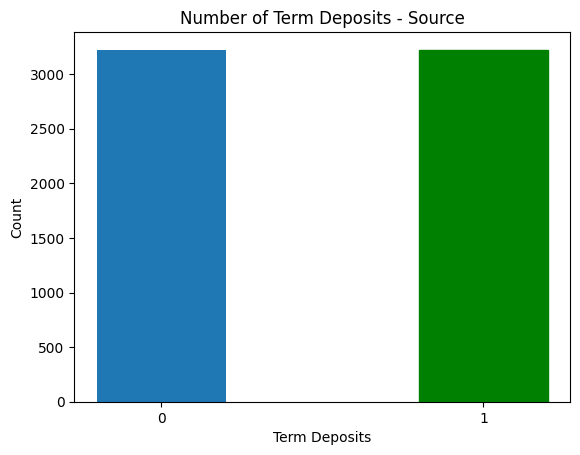

In [ ]:
barlist = plt.bar([str(0),str(1)], y_S_Sy.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Term Deposits")
plt.ylabel("Count")
plt.title("Number of Term Deposits - Source")
plt.show()

In [ ]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (5158, 15)
y_S_train: (5158,)
X_S_test: (1290, 15)
y_S_test: (1290,)


In [ ]:
model_source_Sy = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_299"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2093 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2094 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2095 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2096 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2097 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2098 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2099 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - AUC: 0.6345 - loss: 0.6669 - val_AUC: 0.8505 - val_loss: 0.5081
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8568 - loss: 0.4746 - val_AUC: 0.8839 - val_loss: 0.4839
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8803 - loss: 0.4350 - val_AUC: 0.8852 - val_loss: 0.4262
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9009 - loss: 0.3980 - val_AUC: 0.8855 - val_loss: 0.4264
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8942 - loss: 0.4106 - val_AUC: 0.8885 - val_loss: 0.4344
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8994 - loss: 0.4003 - val_AUC: 0.8857 - val_loss: 0.4243
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8932 - loss: 0.4102 - val_AUC: 0.8900 - val_loss: 0.4404
Epoch 8/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9036 - loss: 0.3911 - val_AUC: 0.8895 - val_loss: 0.4231
Epoch 9/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AU

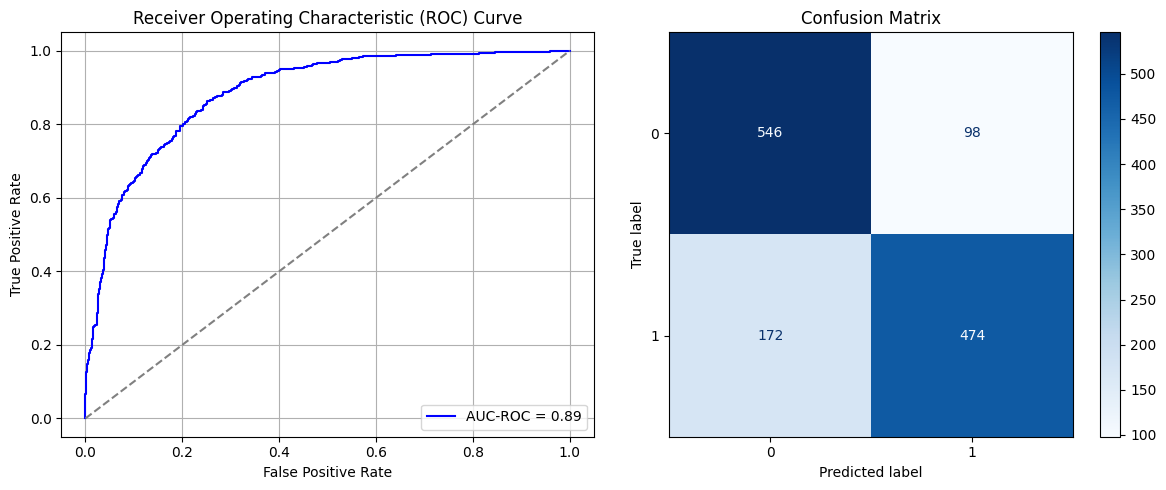

Best threshold based on F1-score: 0.1730891615152359
Time elapsed (performance): 10.70735235399843


<Sequential name=sequential_299, built=True>

In [ ]:
train_and_evaluate(model_source_Sy, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC-ROC: 0.733655001512001
Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.84      0.85      1293
         1.0       0.35      0.38      0.37       289

    accuracy                           0.76      1582
   macro avg       0.61      0.61      0.61      1582
weighted avg       0.77      0.76      0.76      1582

FPR 0.1554524361948956 TPR: 0.38062283737024216 FNR: 0.6193771626297578 TNR: 0.8445475638051044


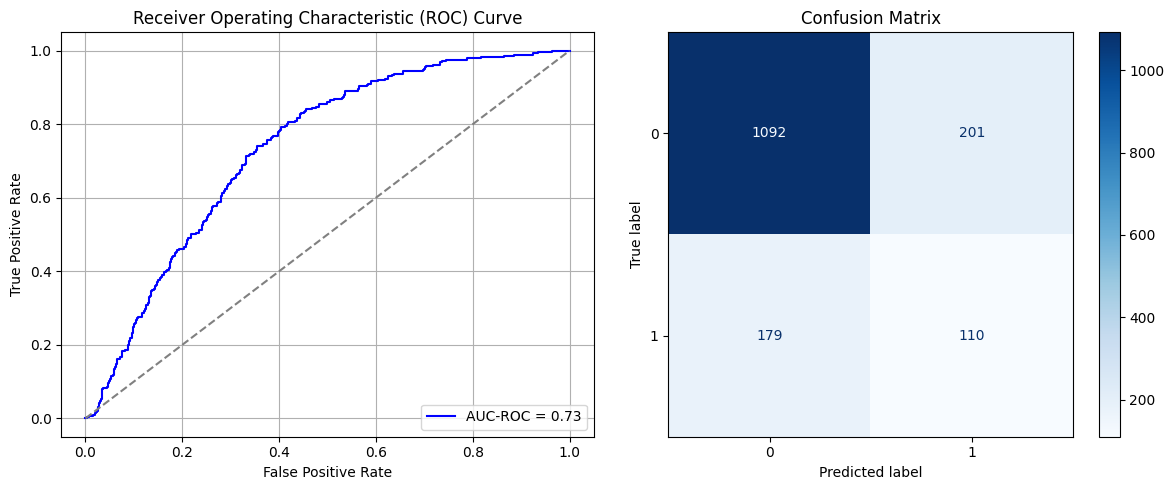

Best threshold based on F1-score: 0.9741227626800537
False Negative Rate: 0.6193771626297578
Time elapsed (performance): 0.5570510310008103


<ipython-input-311-de1f6cb50f3b>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [ ]:
Transductive_TL(model_source_Sy, X_T_test, y_T_test, "Target")

In [ ]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_300"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2100 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2101 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2102 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2103 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2104 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2105 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2106 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7195 - loss: 0.4807 - val_AUC: 0.7069 - val_loss: 0.4282
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7314 - loss: 0.4296 - val_AUC: 0.7151 - val_loss: 0.4243
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7458 - loss: 0.4172 - val_AUC: 0.7242 - val_loss: 0.4201
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7456 - loss: 0.4164 - val_AUC: 0.7287 - val_loss: 0.4180
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7668 - loss: 0.4107 - val_AUC: 0.7312 - val_loss: 0.4181
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7593 - loss: 0.4123 - val_AUC: 0.7354 - val_loss: 0.4146
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7495 - loss: 0.4061 - val_AUC: 0.7353 - val_loss: 0.4154
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7665 - loss: 0.4005 - val_AUC: 0.7403 - val_loss: 0.4134
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7795 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(np.float64(0.0), np.float64(1.0))

In [ ]:
fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_301"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2107 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2108 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2109 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2110 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2111 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2112 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2113 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - AUC: 0.7028 - loss: 0.7032 - val_AUC: 0.0000e+00 - val_loss: 0.9215
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7040 - loss: 0.6141 - val_AUC: 0.0000e+00 - val_loss: 0.8596
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7170 - loss: 0.5896 - val_AUC: 0.0000e+00 - val_loss: 0.8678
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7293 - loss: 0.5723 - val_AUC: 0.0000e+00 - val_loss: 0.8648
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7257 - loss: 0.5915 - val_AUC: 0.0000e+00 - val_loss: 0.9497
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7209 - loss: 0.5885 - val_AUC: 0.0000e+00 - val_loss: 0.9459
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7349 - loss: 0.5832 - val_AUC: 0.0000e+00 - val_loss: 0.9446
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7217 - loss: 0.5752 - val_AUC: 0.0000e+00 - val_loss: 0.8905
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step -

(np.float64(0.1840680587780356), np.float64(0.5017301038062284))

In [ ]:
times = 50


FPR = []
FNR = []

for i in range(times):
    fpr, fnr = fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 4)
    # print(output)
    FPR.append(fpr)
    FNR.append(fnr)

ParamFit = pd.DataFrame([FPR, FNR]).T
ParamFit.columns=['FPR', 'FNR']


# fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_304"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2128 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2129 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2130 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2131 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2132 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2133 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2134 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - AUC: 0.7000 - loss: 0.7264 - val_AUC: 0.0000e+00 - val_loss: 0.9184
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7132 - loss: 0.6119 - val_AUC: 0.0000e+00 - val_loss: 0.9048
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7278 - loss: 0.5866 - val_AUC: 0.0000e+00 - val_loss: 0.9554
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7228 - loss: 0.5849 - val_AUC: 0.0000e+00 - val_loss: 0.9063
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7150 - loss: 0.5899 - val_AUC: 0.0000e+00 - val_loss: 0.9700
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7392 - loss: 0.5749 - val_AUC: 0.0000e+00 - val_loss: 0.9840
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7298 - loss: 0.5786 - val_AUC: 0.0000e+00 - val_loss: 0.9143
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7345 - l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_305"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2135 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2136 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2137 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2138 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2139 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2140 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2141 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - AUC: 0.7091 - loss: 0.7037 - val_AUC: 0.0000e+00 - val_loss: 0.8437
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6956 - loss: 0.6239 - val_AUC: 0.0000e+00 - val_loss: 0.9775
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7177 - loss: 0.5785 - val_AUC: 0.0000e+00 - val_loss: 0.8168
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7374 - loss: 0.5742 - val_AUC: 0.0000e+00 - val_loss: 0.8922
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7041 - loss: 0.5967 - val_AUC: 0.0000e+00 - val_loss: 0.8912
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7201 - loss: 0.5802 - val_AUC: 0.0000e+00 - val_loss: 0.8924
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7461 - loss: 0.5636 - val_AUC: 0.0000e+00 - val_loss: 0.8950
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7538 - loss: 0.5684 - val_AUC: 0.0000e+00 - val_loss: 0.9196
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_306"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2142 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2143 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2144 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2145 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2146 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2147 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2148 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7023 - loss: 0.7247 - val_AUC: 0.0000e+00 - val_loss: 0.9085
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6989 - loss: 0.6174 - val_AUC: 0.0000e+00 - val_loss: 0.8449
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7121 - loss: 0.6038 - val_AUC: 0.0000e+00 - val_loss: 0.9605
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7338 - loss: 0.5841 - val_AUC: 0.0000e+00 - val_loss: 0.9691
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7272 - loss: 0.5833 - val_AUC: 0.0000e+00 - val_loss: 0.9784
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7219 - loss: 0.5778 - val_AUC: 0.0000e+00 - val_loss: 0.9092
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7393 - loss: 0.5718 - val_AUC: 0.0000e+00 - val_loss: 0.8576
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7284 - loss: 0.5793 - val_AUC: 0.0000e+00 - val_loss: 0.8453
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_307"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2149 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2150 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2151 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2152 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2153 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2154 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2155 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7234 - loss: 0.6821 - val_AUC: 0.0000e+00 - val_loss: 0.9136
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7191 - loss: 0.5973 - val_AUC: 0.0000e+00 - val_loss: 0.9113
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7416 - loss: 0.5673 - val_AUC: 0.0000e+00 - val_loss: 0.8741
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7234 - loss: 0.5792 - val_AUC: 0.0000e+00 - val_loss: 0.8114
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7224 - loss: 0.5843 - val_AUC: 0.0000e+00 - val_loss: 0.9136
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7297 - loss: 0.5784 - val_AUC: 0.0000e+00 - val_loss: 0.8753
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7313 - loss: 0.5732 - val_AUC: 0.0000e+00 - val_loss: 0.8568
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7379 - loss: 0.5758 - val_AUC: 0.0000e+00 - val_loss: 0.8967
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_308"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2156 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2157 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2158 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2159 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2160 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2161 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2162 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7165 - loss: 0.7047 - val_AUC: 0.0000e+00 - val_loss: 0.9076
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7106 - loss: 0.6165 - val_AUC: 0.0000e+00 - val_loss: 0.9470
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7194 - loss: 0.5922 - val_AUC: 0.0000e+00 - val_loss: 0.9434
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7422 - loss: 0.5656 - val_AUC: 0.0000e+00 - val_loss: 0.8394
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7325 - loss: 0.5793 - val_AUC: 0.0000e+00 - val_loss: 0.9399
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7425 - loss: 0.5817 - val_AUC: 0.0000e+00 - val_loss: 0.9652
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7382 - loss: 0.5657 - val_AUC: 0.0000e+00 - val_loss: 0.8768
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7495 - loss: 0.5675 - val_AUC: 0.0000e+00 - val_loss: 0.8734
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_309"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2163 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2164 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2165 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2166 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2167 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2168 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2169 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7079 - loss: 0.6998 - val_AUC: 0.0000e+00 - val_loss: 0.9392
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7250 - loss: 0.5953 - val_AUC: 0.0000e+00 - val_loss: 0.9234
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7246 - loss: 0.6009 - val_AUC: 0.0000e+00 - val_loss: 1.0038
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7140 - loss: 0.5981 - val_AUC: 0.0000e+00 - val_loss: 0.8980
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7251 - loss: 0.5905 - val_AUC: 0.0000e+00 - val_loss: 0.9531
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7379 - loss: 0.5791 - val_AUC: 0.0000e+00 - val_loss: 0.8932
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7297 - loss: 0.5789 - val_AUC: 0.0000e+00 - val_loss: 0.8817
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7676 - loss: 0.5500 - val_AUC: 0.0000e+00 - val_loss: 0.9307
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_310"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2170 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2171 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2172 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2173 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2174 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2175 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2176 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6969 - loss: 0.7240 - val_AUC: 0.0000e+00 - val_loss: 0.9237
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7008 - loss: 0.6276 - val_AUC: 0.0000e+00 - val_loss: 0.9069
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7341 - loss: 0.5869 - val_AUC: 0.0000e+00 - val_loss: 0.9656
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7240 - loss: 0.5833 - val_AUC: 0.0000e+00 - val_loss: 0.9447
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7164 - loss: 0.5863 - val_AUC: 0.0000e+00 - val_loss: 0.9007
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7478 - loss: 0.5627 - val_AUC: 0.0000e+00 - val_loss: 0.8770
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7303 - loss: 0.5753 - val_AUC: 0.0000e+00 - val_loss: 0.8660
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7400 - loss: 0.5689 - val_AUC: 0.0000e+00 - val_loss: 0.8683
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_311"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2177 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2178 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2179 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2180 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2181 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2182 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2183 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7022 - loss: 0.7166 - val_AUC: 0.0000e+00 - val_loss: 0.9592
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7165 - loss: 0.6074 - val_AUC: 0.0000e+00 - val_loss: 0.9440
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7254 - loss: 0.5909 - val_AUC: 0.0000e+00 - val_loss: 0.9422
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7261 - loss: 0.5862 - val_AUC: 0.0000e+00 - val_loss: 0.9121
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7457 - loss: 0.5637 - val_AUC: 0.0000e+00 - val_loss: 0.8760
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7251 - loss: 0.5797 - val_AUC: 0.0000e+00 - val_loss: 0.9153
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7260 - loss: 0.5842 - val_AUC: 0.0000e+00 - val_loss: 0.8281
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7691 - loss: 0.5504 - val_AUC: 0.0000e+00 - val_loss: 0.8417
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_312"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2184 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2185 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2186 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2187 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2188 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2189 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2190 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6994 - loss: 0.6929 - val_AUC: 0.0000e+00 - val_loss: 0.9032
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7039 - loss: 0.6170 - val_AUC: 0.0000e+00 - val_loss: 0.9197
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7236 - loss: 0.5920 - val_AUC: 0.0000e+00 - val_loss: 0.9870
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7201 - loss: 0.5853 - val_AUC: 0.0000e+00 - val_loss: 0.9097
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7186 - loss: 0.5919 - val_AUC: 0.0000e+00 - val_loss: 0.9282
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7269 - loss: 0.5786 - val_AUC: 0.0000e+00 - val_loss: 0.8648
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7336 - loss: 0.5746 - val_AUC: 0.0000e+00 - val_loss: 0.8204
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7247 - loss: 0.5843 - val_AUC: 0.0000e+00 - val_loss: 0.9763
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_313"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2191 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2192 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2193 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2194 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2195 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2196 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2197 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7004 - loss: 0.7084 - val_AUC: 0.0000e+00 - val_loss: 0.8935
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7124 - loss: 0.6132 - val_AUC: 0.0000e+00 - val_loss: 0.9957
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7357 - loss: 0.5720 - val_AUC: 0.0000e+00 - val_loss: 0.8761
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7396 - loss: 0.5749 - val_AUC: 0.0000e+00 - val_loss: 0.9195
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7346 - loss: 0.5813 - val_AUC: 0.0000e+00 - val_loss: 0.9163
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7236 - loss: 0.5890 - val_AUC: 0.0000e+00 - val_loss: 0.9009
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7425 - loss: 0.5708 - val_AUC: 0.0000e+00 - val_loss: 0.9790
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7458 - loss: 0.5766 - val_AUC: 0.0000e+00 - val_loss: 1.0099
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_314"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2198 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2199 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2200 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2201 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2202 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2203 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2204 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7092 - loss: 0.7057 - val_AUC: 0.0000e+00 - val_loss: 0.9330
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7127 - loss: 0.6083 - val_AUC: 0.0000e+00 - val_loss: 0.9406
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7201 - loss: 0.5895 - val_AUC: 0.0000e+00 - val_loss: 0.8708
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7349 - loss: 0.5870 - val_AUC: 0.0000e+00 - val_loss: 0.9095
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7249 - loss: 0.5839 - val_AUC: 0.0000e+00 - val_loss: 0.9197
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7389 - loss: 0.5764 - val_AUC: 0.0000e+00 - val_loss: 0.9621
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7419 - loss: 0.5785 - val_AUC: 0.0000e+00 - val_loss: 0.9441
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7497 - loss: 0.5662 - val_AUC: 0.0000e+00 - val_loss: 0.9503
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_315"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2205 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2206 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2207 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2208 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2209 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2210 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2211 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7269 - loss: 0.6400 - val_AUC: 0.0000e+00 - val_loss: 0.8483
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7038 - loss: 0.6052 - val_AUC: 0.0000e+00 - val_loss: 0.8541
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7240 - loss: 0.5836 - val_AUC: 0.0000e+00 - val_loss: 0.8753
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7358 - loss: 0.5797 - val_AUC: 0.0000e+00 - val_loss: 0.9305
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7400 - loss: 0.5641 - val_AUC: 0.0000e+00 - val_loss: 0.8675
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7515 - loss: 0.5582 - val_AUC: 0.0000e+00 - val_loss: 0.8455
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7270 - loss: 0.5739 - val_AUC: 0.0000e+00 - val_loss: 0.8760
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7408 - loss: 0.5715 - val_AUC: 0.0000e+00 - val_loss: 0.8796
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_316"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2212 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2213 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2214 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2215 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2216 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2217 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2218 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - AUC: 0.7078 - loss: 0.7043 - val_AUC: 0.0000e+00 - val_loss: 0.9301
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7157 - loss: 0.6104 - val_AUC: 0.0000e+00 - val_loss: 0.9627
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7224 - loss: 0.5929 - val_AUC: 0.0000e+00 - val_loss: 0.8840
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7345 - loss: 0.5883 - val_AUC: 0.0000e+00 - val_loss: 0.9289
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7315 - loss: 0.5804 - val_AUC: 0.0000e+00 - val_loss: 0.9351
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7272 - loss: 0.5820 - val_AUC: 0.0000e+00 - val_loss: 0.8929
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7197 - loss: 0.5885 - val_AUC: 0.0000e+00 - val_loss: 0.9649
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7340 - loss: 0.5810 - val_AUC: 0.0000e+00 - val_loss: 0.9575
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_317"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2219 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2220 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2221 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2222 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2223 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2224 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2225 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7237 - loss: 0.6804 - val_AUC: 0.0000e+00 - val_loss: 0.8781
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7112 - loss: 0.6115 - val_AUC: 0.0000e+00 - val_loss: 0.9177
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7075 - loss: 0.6086 - val_AUC: 0.0000e+00 - val_loss: 1.0052
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7245 - loss: 0.5901 - val_AUC: 0.0000e+00 - val_loss: 0.9462
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7429 - loss: 0.5703 - val_AUC: 0.0000e+00 - val_loss: 0.8866
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7401 - loss: 0.5784 - val_AUC: 0.0000e+00 - val_loss: 0.9036
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7561 - loss: 0.5612 - val_AUC: 0.0000e+00 - val_loss: 0.9048
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7337 - loss: 0.5736 - val_AUC: 0.0000e+00 - val_loss: 0.8614
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_318"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2226 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2227 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2228 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2229 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2230 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2231 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2232 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - AUC: 0.7211 - loss: 0.6831 - val_AUC: 0.0000e+00 - val_loss: 0.9353
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7254 - loss: 0.6000 - val_AUC: 0.0000e+00 - val_loss: 0.9685
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7165 - loss: 0.5924 - val_AUC: 0.0000e+00 - val_loss: 0.9166
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7086 - loss: 0.5995 - val_AUC: 0.0000e+00 - val_loss: 0.9077
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7537 - loss: 0.5661 - val_AUC: 0.0000e+00 - val_loss: 0.8903
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7096 - loss: 0.5924 - val_AUC: 0.0000e+00 - val_loss: 0.8912
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7380 - loss: 0.5697 - val_AUC: 0.0000e+00 - val_loss: 0.8951
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7483 - loss: 0.5644 - val_AUC: 0.0000e+00 - val_loss: 0.9339
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_319"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2233 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2234 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2235 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2236 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2237 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2238 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2239 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7009 - loss: 0.7032 - val_AUC: 0.0000e+00 - val_loss: 0.9035
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7271 - loss: 0.5958 - val_AUC: 0.0000e+00 - val_loss: 0.9342
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7165 - loss: 0.5945 - val_AUC: 0.0000e+00 - val_loss: 0.9523
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7045 - loss: 0.5907 - val_AUC: 0.0000e+00 - val_loss: 0.8360
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7360 - loss: 0.5714 - val_AUC: 0.0000e+00 - val_loss: 0.8921
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7424 - loss: 0.5786 - val_AUC: 0.0000e+00 - val_loss: 0.9370
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7270 - loss: 0.5809 - val_AUC: 0.0000e+00 - val_loss: 0.8575
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7189 - loss: 0.5899 - val_AUC: 0.0000e+00 - val_loss: 0.9449
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_320"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2240 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2241 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2242 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2243 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2244 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2245 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2246 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7429 - loss: 0.6295 - val_AUC: 0.0000e+00 - val_loss: 0.8984
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7227 - loss: 0.5924 - val_AUC: 0.0000e+00 - val_loss: 0.9046
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7088 - loss: 0.6031 - val_AUC: 0.0000e+00 - val_loss: 0.8678
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7377 - loss: 0.5776 - val_AUC: 0.0000e+00 - val_loss: 0.9166
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7346 - loss: 0.5763 - val_AUC: 0.0000e+00 - val_loss: 0.8992
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7432 - loss: 0.5725 - val_AUC: 0.0000e+00 - val_loss: 0.9004
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7422 - loss: 0.5701 - val_AUC: 0.0000e+00 - val_loss: 0.8741
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7209 - loss: 0.5790 - val_AUC: 0.0000e+00 - val_loss: 0.8717
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_321"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2247 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2248 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2249 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2250 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2251 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2252 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2253 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7192 - loss: 0.7084 - val_AUC: 0.0000e+00 - val_loss: 0.9934
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7316 - loss: 0.6002 - val_AUC: 0.0000e+00 - val_loss: 0.9346
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7236 - loss: 0.5908 - val_AUC: 0.0000e+00 - val_loss: 0.9232
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7358 - loss: 0.5847 - val_AUC: 0.0000e+00 - val_loss: 0.9439
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7050 - loss: 0.5933 - val_AUC: 0.0000e+00 - val_loss: 0.8937
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7292 - loss: 0.5793 - val_AUC: 0.0000e+00 - val_loss: 0.8330
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7422 - loss: 0.5713 - val_AUC: 0.0000e+00 - val_loss: 0.9342
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7399 - loss: 0.5766 - val_AUC: 0.0000e+00 - val_loss: 0.9047
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_322"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2254 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2255 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2256 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2257 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2258 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2259 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2260 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6964 - loss: 0.7166 - val_AUC: 0.0000e+00 - val_loss: 0.8593
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7094 - loss: 0.6193 - val_AUC: 0.0000e+00 - val_loss: 0.9492
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7144 - loss: 0.5922 - val_AUC: 0.0000e+00 - val_loss: 0.9077
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7201 - loss: 0.5834 - val_AUC: 0.0000e+00 - val_loss: 0.8982
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7365 - loss: 0.5795 - val_AUC: 0.0000e+00 - val_loss: 0.9306
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7361 - loss: 0.5821 - val_AUC: 0.0000e+00 - val_loss: 0.8824
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7416 - loss: 0.5752 - val_AUC: 0.0000e+00 - val_loss: 0.9484
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7574 - loss: 0.5631 - val_AUC: 0.0000e+00 - val_loss: 0.9545
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_323"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2261 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2262 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2263 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2264 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2265 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2266 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2267 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6927 - loss: 0.7309 - val_AUC: 0.0000e+00 - val_loss: 0.9015
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7224 - loss: 0.5916 - val_AUC: 0.0000e+00 - val_loss: 0.8433
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7051 - loss: 0.6024 - val_AUC: 0.0000e+00 - val_loss: 0.9404
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7216 - loss: 0.5828 - val_AUC: 0.0000e+00 - val_loss: 0.8828
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7284 - loss: 0.5858 - val_AUC: 0.0000e+00 - val_loss: 0.8955
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7189 - loss: 0.5815 - val_AUC: 0.0000e+00 - val_loss: 0.9047
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7443 - loss: 0.5694 - val_AUC: 0.0000e+00 - val_loss: 0.9073
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7458 - loss: 0.5733 - val_AUC: 0.0000e+00 - val_loss: 0.9616
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_324"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2268 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2269 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2270 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2271 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2272 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2273 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2274 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7101 - loss: 0.6848 - val_AUC: 0.0000e+00 - val_loss: 0.8159
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7106 - loss: 0.6076 - val_AUC: 0.0000e+00 - val_loss: 0.9156
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7174 - loss: 0.5886 - val_AUC: 0.0000e+00 - val_loss: 0.8906
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7377 - loss: 0.5724 - val_AUC: 0.0000e+00 - val_loss: 0.9532
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7238 - loss: 0.5851 - val_AUC: 0.0000e+00 - val_loss: 0.9259
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7459 - loss: 0.5782 - val_AUC: 0.0000e+00 - val_loss: 0.9644
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7430 - loss: 0.5736 - val_AUC: 0.0000e+00 - val_loss: 0.9748
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7449 - loss: 0.5683 - val_AUC: 0.0000e+00 - val_loss: 0.9179
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_325"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2275 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2276 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2277 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2278 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2279 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2280 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2281 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7066 - loss: 0.6889 - val_AUC: 0.0000e+00 - val_loss: 0.9578
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7114 - loss: 0.6116 - val_AUC: 0.0000e+00 - val_loss: 0.9324
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7330 - loss: 0.5740 - val_AUC: 0.0000e+00 - val_loss: 0.9236
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7318 - loss: 0.5747 - val_AUC: 0.0000e+00 - val_loss: 0.8587
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7055 - loss: 0.5846 - val_AUC: 0.0000e+00 - val_loss: 0.8059
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7126 - loss: 0.5920 - val_AUC: 0.0000e+00 - val_loss: 0.9145
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7356 - loss: 0.5711 - val_AUC: 0.0000e+00 - val_loss: 0.9780
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7431 - loss: 0.5643 - val_AUC: 0.0000e+00 - val_loss: 0.8363
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_326"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2282 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2283 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2284 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2285 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2286 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2287 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2288 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7139 - loss: 0.6879 - val_AUC: 0.0000e+00 - val_loss: 0.8053
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6946 - loss: 0.6264 - val_AUC: 0.0000e+00 - val_loss: 0.9521
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7135 - loss: 0.5966 - val_AUC: 0.0000e+00 - val_loss: 0.8837
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7264 - loss: 0.5814 - val_AUC: 0.0000e+00 - val_loss: 0.8595
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7309 - loss: 0.5810 - val_AUC: 0.0000e+00 - val_loss: 0.9327
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7202 - loss: 0.5890 - val_AUC: 0.0000e+00 - val_loss: 0.9571
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7339 - loss: 0.5694 - val_AUC: 0.0000e+00 - val_loss: 0.9182
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7545 - loss: 0.5516 - val_AUC: 0.0000e+00 - val_loss: 0.7980
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_327"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2289 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2290 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2291 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2292 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2293 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2294 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2295 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - AUC: 0.7189 - loss: 0.6677 - val_AUC: 0.0000e+00 - val_loss: 0.9029
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7064 - loss: 0.6049 - val_AUC: 0.0000e+00 - val_loss: 0.9415
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7176 - loss: 0.5931 - val_AUC: 0.0000e+00 - val_loss: 0.9453
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7406 - loss: 0.5772 - val_AUC: 0.0000e+00 - val_loss: 0.9700
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7306 - loss: 0.5750 - val_AUC: 0.0000e+00 - val_loss: 0.8605
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7201 - loss: 0.5795 - val_AUC: 0.0000e+00 - val_loss: 0.9316
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7462 - loss: 0.5622 - val_AUC: 0.0000e+00 - val_loss: 0.8378
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7471 - loss: 0.5721 - val_AUC: 0.0000e+00 - val_loss: 0.9098
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_328"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2296 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2297 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2298 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2299 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2300 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2301 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2302 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - AUC: 0.7309 - loss: 0.6631 - val_AUC: 0.0000e+00 - val_loss: 0.9304
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7059 - loss: 0.6148 - val_AUC: 0.0000e+00 - val_loss: 1.0010
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7065 - loss: 0.5975 - val_AUC: 0.0000e+00 - val_loss: 0.9458
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6956 - loss: 0.6024 - val_AUC: 0.0000e+00 - val_loss: 0.9174
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7320 - loss: 0.5774 - val_AUC: 0.0000e+00 - val_loss: 0.8729
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7253 - loss: 0.5840 - val_AUC: 0.0000e+00 - val_loss: 0.9075
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7343 - loss: 0.5783 - val_AUC: 0.0000e+00 - val_loss: 0.8601
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7420 - loss: 0.5681 - val_AUC: 0.0000e+00 - val_loss: 0.8977
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_329"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2303 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2304 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2305 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2306 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2307 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2308 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2309 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - AUC: 0.7015 - loss: 0.7045 - val_AUC: 0.0000e+00 - val_loss: 0.8733
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7057 - loss: 0.6153 - val_AUC: 0.0000e+00 - val_loss: 0.9157
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7112 - loss: 0.5990 - val_AUC: 0.0000e+00 - val_loss: 0.9516
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7167 - loss: 0.5889 - val_AUC: 0.0000e+00 - val_loss: 0.8851
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7212 - loss: 0.5979 - val_AUC: 0.0000e+00 - val_loss: 0.9724
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7377 - loss: 0.5694 - val_AUC: 0.0000e+00 - val_loss: 0.9631
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7382 - loss: 0.5745 - val_AUC: 0.0000e+00 - val_loss: 1.0130
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7323 - loss: 0.5754 - val_AUC: 0.0000e+00 - val_loss: 0.9074
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_330"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2310 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2311 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2312 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2313 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2314 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2315 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2316 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6971 - loss: 0.7189 - val_AUC: 0.0000e+00 - val_loss: 0.9031
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7163 - loss: 0.5966 - val_AUC: 0.0000e+00 - val_loss: 0.8312
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7342 - loss: 0.5823 - val_AUC: 0.0000e+00 - val_loss: 0.9049
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7153 - loss: 0.5884 - val_AUC: 0.0000e+00 - val_loss: 0.9524
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7363 - loss: 0.5828 - val_AUC: 0.0000e+00 - val_loss: 0.9205
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7246 - loss: 0.5893 - val_AUC: 0.0000e+00 - val_loss: 0.9445
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7350 - loss: 0.5787 - val_AUC: 0.0000e+00 - val_loss: 0.9289
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7513 - loss: 0.5665 - val_AUC: 0.0000e+00 - val_loss: 0.9436
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_331"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2317 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2318 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2319 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2320 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2321 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2322 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2323 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7202 - loss: 0.6781 - val_AUC: 0.0000e+00 - val_loss: 0.9276
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7090 - loss: 0.6111 - val_AUC: 0.0000e+00 - val_loss: 0.9466
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7145 - loss: 0.5939 - val_AUC: 0.0000e+00 - val_loss: 0.9412
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7343 - loss: 0.5797 - val_AUC: 0.0000e+00 - val_loss: 0.8549
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7260 - loss: 0.5899 - val_AUC: 0.0000e+00 - val_loss: 0.9151
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7187 - loss: 0.5801 - val_AUC: 0.0000e+00 - val_loss: 0.8775
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7311 - loss: 0.5760 - val_AUC: 0.0000e+00 - val_loss: 0.9078
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7387 - loss: 0.5712 - val_AUC: 0.0000e+00 - val_loss: 0.9187
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_332"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2324 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2325 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2326 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2327 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2328 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2329 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2330 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - AUC: 0.6829 - loss: 0.7182 - val_AUC: 0.0000e+00 - val_loss: 0.8534
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7236 - loss: 0.5956 - val_AUC: 0.0000e+00 - val_loss: 0.8617
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7297 - loss: 0.5807 - val_AUC: 0.0000e+00 - val_loss: 0.9255
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7377 - loss: 0.5717 - val_AUC: 0.0000e+00 - val_loss: 0.9471
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7362 - loss: 0.5727 - val_AUC: 0.0000e+00 - val_loss: 0.8912
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.7415 - loss: 0.5706 - val_AUC: 0.0000e+00 - val_loss: 1.0095
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7287 - loss: 0.5798 - val_AUC: 0.0000e+00 - val_loss: 0.8714
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7393 - loss: 0.5660 - val_AUC: 0.0000e+00 - val_loss: 0.9160
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_333"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2331 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2332 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2333 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2334 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2335 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2336 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2337 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - AUC: 0.7004 - loss: 0.7189 - val_AUC: 0.0000e+00 - val_loss: 0.9358
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7287 - loss: 0.5969 - val_AUC: 0.0000e+00 - val_loss: 0.9507
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7247 - loss: 0.5808 - val_AUC: 0.0000e+00 - val_loss: 0.9328
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7244 - loss: 0.5835 - val_AUC: 0.0000e+00 - val_loss: 0.9921
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7255 - loss: 0.5850 - val_AUC: 0.0000e+00 - val_loss: 0.8742
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7587 - loss: 0.5597 - val_AUC: 0.0000e+00 - val_loss: 0.8689
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7380 - loss: 0.5717 - val_AUC: 0.0000e+00 - val_loss: 0.8420
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7496 - loss: 0.5710 - val_AUC: 0.0000e+00 - val_loss: 0.8876
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_334"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2338 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2339 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2340 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2341 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2342 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2343 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2344 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - AUC: 0.6917 - loss: 0.7316 - val_AUC: 0.0000e+00 - val_loss: 0.9267
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7284 - loss: 0.5922 - val_AUC: 0.0000e+00 - val_loss: 0.8652
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7122 - loss: 0.5947 - val_AUC: 0.0000e+00 - val_loss: 0.8985
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7081 - loss: 0.5971 - val_AUC: 0.0000e+00 - val_loss: 0.8982
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7150 - loss: 0.5929 - val_AUC: 0.0000e+00 - val_loss: 0.9317
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7350 - loss: 0.5689 - val_AUC: 0.0000e+00 - val_loss: 0.8672
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7330 - loss: 0.5798 - val_AUC: 0.0000e+00 - val_loss: 0.8935
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7383 - loss: 0.5684 - val_AUC: 0.0000e+00 - val_loss: 0.8218
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_335"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2345 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2346 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2347 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2348 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2349 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2350 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2351 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.6950 - loss: 0.7198 - val_AUC: 0.0000e+00 - val_loss: 0.9379
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7128 - loss: 0.6121 - val_AUC: 0.0000e+00 - val_loss: 0.8901
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7140 - loss: 0.6012 - val_AUC: 0.0000e+00 - val_loss: 0.9376
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7241 - loss: 0.5833 - val_AUC: 0.0000e+00 - val_loss: 0.9571
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7255 - loss: 0.5753 - val_AUC: 0.0000e+00 - val_loss: 0.8231
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7227 - loss: 0.5767 - val_AUC: 0.0000e+00 - val_loss: 0.8579
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7413 - loss: 0.5832 - val_AUC: 0.0000e+00 - val_loss: 0.8944
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7426 - loss: 0.5701 - val_AUC: 0.0000e+00 - val_loss: 0.8739
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_336"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2352 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2353 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2354 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2355 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2356 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2357 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2358 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - AUC: 0.7244 - loss: 0.6711 - val_AUC: 0.0000e+00 - val_loss: 0.9042
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7267 - loss: 0.5946 - val_AUC: 0.0000e+00 - val_loss: 0.8685
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7158 - loss: 0.5872 - val_AUC: 0.0000e+00 - val_loss: 0.8563
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7002 - loss: 0.5974 - val_AUC: 0.0000e+00 - val_loss: 0.9283
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7398 - loss: 0.5669 - val_AUC: 0.0000e+00 - val_loss: 0.9169
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7359 - loss: 0.5781 - val_AUC: 0.0000e+00 - val_loss: 0.9102
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7359 - loss: 0.5729 - val_AUC: 0.0000e+00 - val_loss: 0.8629
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7354 - loss: 0.5733 - val_AUC: 0.0000e+00 - val_loss: 0.8879
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_337"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2359 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2360 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2361 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2362 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2363 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2364 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2365 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.6995 - loss: 0.7097 - val_AUC: 0.0000e+00 - val_loss: 0.9064
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7095 - loss: 0.6046 - val_AUC: 0.0000e+00 - val_loss: 0.8754
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7200 - loss: 0.5947 - val_AUC: 0.0000e+00 - val_loss: 0.9390
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7190 - loss: 0.5915 - val_AUC: 0.0000e+00 - val_loss: 0.9035
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7259 - loss: 0.5868 - val_AUC: 0.0000e+00 - val_loss: 1.0010
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7390 - loss: 0.5795 - val_AUC: 0.0000e+00 - val_loss: 0.9220
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7620 - loss: 0.5572 - val_AUC: 0.0000e+00 - val_loss: 0.9007
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7389 - loss: 0.5723 - val_AUC: 0.0000e+00 - val_loss: 0.8802
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_338"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2366 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2367 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2368 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2369 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2370 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2371 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2372 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - AUC: 0.7071 - loss: 0.7011 - val_AUC: 0.0000e+00 - val_loss: 0.8885
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7153 - loss: 0.6081 - val_AUC: 0.0000e+00 - val_loss: 0.9214
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7324 - loss: 0.5805 - val_AUC: 0.0000e+00 - val_loss: 0.8858
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7349 - loss: 0.5804 - val_AUC: 0.0000e+00 - val_loss: 0.9347
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7278 - loss: 0.5824 - val_AUC: 0.0000e+00 - val_loss: 0.8512
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7372 - loss: 0.5827 - val_AUC: 0.0000e+00 - val_loss: 0.8693
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7434 - loss: 0.5688 - val_AUC: 0.0000e+00 - val_loss: 0.8886
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7357 - loss: 0.5649 - val_AUC: 0.0000e+00 - val_loss: 0.8449
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_339"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2373 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2374 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2375 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2376 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2377 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2378 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2379 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.7233 - loss: 0.6820 - val_AUC: 0.0000e+00 - val_loss: 0.9394
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7150 - loss: 0.6164 - val_AUC: 0.0000e+00 - val_loss: 0.9682
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7143 - loss: 0.5939 - val_AUC: 0.0000e+00 - val_loss: 1.0058
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7213 - loss: 0.5784 - val_AUC: 0.0000e+00 - val_loss: 0.8962
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7057 - loss: 0.5988 - val_AUC: 0.0000e+00 - val_loss: 0.8914
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7344 - loss: 0.5695 - val_AUC: 0.0000e+00 - val_loss: 0.8755
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7399 - loss: 0.5722 - val_AUC: 0.0000e+00 - val_loss: 0.8740
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7252 - loss: 0.5845 - val_AUC: 0.0000e+00 - val_loss: 0.8635
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_340"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2380 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2381 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2382 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2383 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2384 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2385 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2386 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.7134 - loss: 0.7327 - val_AUC: 0.0000e+00 - val_loss: 0.9623
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7066 - loss: 0.6252 - val_AUC: 0.0000e+00 - val_loss: 0.9024
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7110 - loss: 0.5955 - val_AUC: 0.0000e+00 - val_loss: 0.8821
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7354 - loss: 0.5809 - val_AUC: 0.0000e+00 - val_loss: 0.9416
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7241 - loss: 0.5919 - val_AUC: 0.0000e+00 - val_loss: 0.9873
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7202 - loss: 0.5866 - val_AUC: 0.0000e+00 - val_loss: 0.9571
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7380 - loss: 0.5745 - val_AUC: 0.0000e+00 - val_loss: 0.9039
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7275 - loss: 0.5833 - val_AUC: 0.0000e+00 - val_loss: 0.9011
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_341"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2387 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2388 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2389 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2390 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2391 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2392 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2393 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7119 - loss: 0.7157 - val_AUC: 0.0000e+00 - val_loss: 0.8589
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7089 - loss: 0.6168 - val_AUC: 0.0000e+00 - val_loss: 0.9297
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7303 - loss: 0.5920 - val_AUC: 0.0000e+00 - val_loss: 0.9397
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7500 - loss: 0.5710 - val_AUC: 0.0000e+00 - val_loss: 0.9791
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7318 - loss: 0.5764 - val_AUC: 0.0000e+00 - val_loss: 0.9194
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7138 - loss: 0.5890 - val_AUC: 0.0000e+00 - val_loss: 0.9027
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7294 - loss: 0.5872 - val_AUC: 0.0000e+00 - val_loss: 0.9548
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7492 - loss: 0.5675 - val_AUC: 0.0000e+00 - val_loss: 0.9039
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_342"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2394 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2395 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2396 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2397 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2398 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2399 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2400 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6960 - loss: 0.7300 - val_AUC: 0.0000e+00 - val_loss: 1.0055
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7102 - loss: 0.6069 - val_AUC: 0.0000e+00 - val_loss: 0.9273
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7185 - loss: 0.5959 - val_AUC: 0.0000e+00 - val_loss: 0.9847
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7079 - loss: 0.6045 - val_AUC: 0.0000e+00 - val_loss: 0.9810
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7139 - loss: 0.5846 - val_AUC: 0.0000e+00 - val_loss: 0.9554
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7441 - loss: 0.5623 - val_AUC: 0.0000e+00 - val_loss: 0.9306
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7245 - loss: 0.5670 - val_AUC: 0.0000e+00 - val_loss: 0.8788
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7356 - loss: 0.5805 - val_AUC: 0.0000e+00 - val_loss: 0.9144
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_343"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2401 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2402 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2403 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2404 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2405 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2406 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2407 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7389 - loss: 0.6504 - val_AUC: 0.0000e+00 - val_loss: 0.9025
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7113 - loss: 0.6076 - val_AUC: 0.0000e+00 - val_loss: 0.8836
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7164 - loss: 0.5956 - val_AUC: 0.0000e+00 - val_loss: 0.9060
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7309 - loss: 0.5810 - val_AUC: 0.0000e+00 - val_loss: 0.9192
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7158 - loss: 0.5889 - val_AUC: 0.0000e+00 - val_loss: 0.9551
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7411 - loss: 0.5667 - val_AUC: 0.0000e+00 - val_loss: 0.8758
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7279 - loss: 0.5807 - val_AUC: 0.0000e+00 - val_loss: 0.8160
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7443 - loss: 0.5718 - val_AUC: 0.0000e+00 - val_loss: 0.9253
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_344"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2408 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2409 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2410 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2411 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2412 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2413 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2414 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7021 - loss: 0.6946 - val_AUC: 0.0000e+00 - val_loss: 0.8695
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6975 - loss: 0.6220 - val_AUC: 0.0000e+00 - val_loss: 0.9570
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7297 - loss: 0.5882 - val_AUC: 0.0000e+00 - val_loss: 0.9452
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7147 - loss: 0.5929 - val_AUC: 0.0000e+00 - val_loss: 0.9577
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7285 - loss: 0.5865 - val_AUC: 0.0000e+00 - val_loss: 0.9291
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7400 - loss: 0.5698 - val_AUC: 0.0000e+00 - val_loss: 0.9273
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7528 - loss: 0.5681 - val_AUC: 0.0000e+00 - val_loss: 1.0610
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7450 - loss: 0.5764 - val_AUC: 0.0000e+00 - val_loss: 0.8954
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_345"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2415 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2416 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2417 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2418 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2419 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2420 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2421 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.7067 - loss: 0.7122 - val_AUC: 0.0000e+00 - val_loss: 0.8273
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7266 - loss: 0.5976 - val_AUC: 0.0000e+00 - val_loss: 0.8459
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7375 - loss: 0.5779 - val_AUC: 0.0000e+00 - val_loss: 0.9129
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7263 - loss: 0.5770 - val_AUC: 0.0000e+00 - val_loss: 0.8691
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7236 - loss: 0.5869 - val_AUC: 0.0000e+00 - val_loss: 0.8766
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7347 - loss: 0.5747 - val_AUC: 0.0000e+00 - val_loss: 0.9485
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7485 - loss: 0.5635 - val_AUC: 0.0000e+00 - val_loss: 0.9333
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7421 - loss: 0.5653 - val_AUC: 0.0000e+00 - val_loss: 0.8492
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_346"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2422 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2423 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2424 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2425 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2426 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2427 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2428 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.7055 - loss: 0.7117 - val_AUC: 0.0000e+00 - val_loss: 0.9378
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7145 - loss: 0.6032 - val_AUC: 0.0000e+00 - val_loss: 0.8794
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7316 - loss: 0.5911 - val_AUC: 0.0000e+00 - val_loss: 0.9952
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7285 - loss: 0.5876 - val_AUC: 0.0000e+00 - val_loss: 0.8849
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7231 - loss: 0.5729 - val_AUC: 0.0000e+00 - val_loss: 0.8488
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7257 - loss: 0.5870 - val_AUC: 0.0000e+00 - val_loss: 0.9526
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7203 - loss: 0.5873 - val_AUC: 0.0000e+00 - val_loss: 0.9149
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7554 - loss: 0.5643 - val_AUC: 0.0000e+00 - val_loss: 0.8726
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_347"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2429 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2430 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2431 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2432 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2433 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2434 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2435 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - AUC: 0.7013 - loss: 0.7094 - val_AUC: 0.0000e+00 - val_loss: 0.9355
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7068 - loss: 0.6190 - val_AUC: 0.0000e+00 - val_loss: 0.9594
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7218 - loss: 0.5884 - val_AUC: 0.0000e+00 - val_loss: 0.9447
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7012 - loss: 0.6033 - val_AUC: 0.0000e+00 - val_loss: 0.9683
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7262 - loss: 0.5927 - val_AUC: 0.0000e+00 - val_loss: 0.9175
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7170 - loss: 0.5869 - val_AUC: 0.0000e+00 - val_loss: 0.9294
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7396 - loss: 0.5684 - val_AUC: 0.0000e+00 - val_loss: 0.8731
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7370 - loss: 0.5758 - val_AUC: 0.0000e+00 - val_loss: 0.8684
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_348"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2436 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2437 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2438 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2439 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2440 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2441 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2442 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.7029 - loss: 0.7047 - val_AUC: 0.0000e+00 - val_loss: 0.9000
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7187 - loss: 0.6044 - val_AUC: 0.0000e+00 - val_loss: 0.9187
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7249 - loss: 0.5865 - val_AUC: 0.0000e+00 - val_loss: 0.9003
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7323 - loss: 0.5800 - val_AUC: 0.0000e+00 - val_loss: 0.8278
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7413 - loss: 0.5705 - val_AUC: 0.0000e+00 - val_loss: 0.9092
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7392 - loss: 0.5782 - val_AUC: 0.0000e+00 - val_loss: 0.9365
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7302 - loss: 0.5774 - val_AUC: 0.0000e+00 - val_loss: 0.9340
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7530 - loss: 0.5746 - val_AUC: 0.0000e+00 - val_loss: 0.8821
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_349"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2443 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2444 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2445 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2446 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2447 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2448 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2449 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7075 - loss: 0.6859 - val_AUC: 0.0000e+00 - val_loss: 0.9072
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7297 - loss: 0.5883 - val_AUC: 0.0000e+00 - val_loss: 0.9243
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7396 - loss: 0.5749 - val_AUC: 0.0000e+00 - val_loss: 0.9144
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7392 - loss: 0.5807 - val_AUC: 0.0000e+00 - val_loss: 0.9846
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7334 - loss: 0.5848 - val_AUC: 0.0000e+00 - val_loss: 0.9555
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7169 - loss: 0.5898 - val_AUC: 0.0000e+00 - val_loss: 0.9180
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7534 - loss: 0.5600 - val_AUC: 0.0000e+00 - val_loss: 0.9479
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7325 - loss: 0.5843 - val_AUC: 0.0000e+00 - val_loss: 0.8931
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_350"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2450 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2451 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2452 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2453 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2454 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2455 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2456 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7132 - loss: 0.6917 - val_AUC: 0.0000e+00 - val_loss: 0.9454
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7029 - loss: 0.6204 - val_AUC: 0.0000e+00 - val_loss: 0.9773
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7200 - loss: 0.5899 - val_AUC: 0.0000e+00 - val_loss: 0.9987
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7316 - loss: 0.5773 - val_AUC: 0.0000e+00 - val_loss: 0.8753
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7150 - loss: 0.5905 - val_AUC: 0.0000e+00 - val_loss: 0.8659
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7333 - loss: 0.5849 - val_AUC: 0.0000e+00 - val_loss: 1.0178
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7407 - loss: 0.5609 - val_AUC: 0.0000e+00 - val_loss: 0.8029
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7350 - loss: 0.5706 - val_AUC: 0.0000e+00 - val_loss: 0.8597
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_351"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2457 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2458 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2459 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2460 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2461 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2462 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2463 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7052 - loss: 0.7222 - val_AUC: 0.0000e+00 - val_loss: 0.9129
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7126 - loss: 0.6090 - val_AUC: 0.0000e+00 - val_loss: 0.8997
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7367 - loss: 0.5743 - val_AUC: 0.0000e+00 - val_loss: 0.9087
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7164 - loss: 0.5906 - val_AUC: 0.0000e+00 - val_loss: 0.9281
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7236 - loss: 0.5808 - val_AUC: 0.0000e+00 - val_loss: 0.9228
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7231 - loss: 0.5785 - val_AUC: 0.0000e+00 - val_loss: 0.9479
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7062 - loss: 0.5934 - val_AUC: 0.0000e+00 - val_loss: 0.9269
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7340 - loss: 0.5703 - val_AUC: 0.0000e+00 - val_loss: 0.8849
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_352"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2464 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2465 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2466 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2467 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2468 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2469 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2470 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.7210 - loss: 0.6762 - val_AUC: 0.0000e+00 - val_loss: 0.8689
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7199 - loss: 0.6022 - val_AUC: 0.0000e+00 - val_loss: 1.0012
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7255 - loss: 0.6007 - val_AUC: 0.0000e+00 - val_loss: 1.0075
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7339 - loss: 0.5837 - val_AUC: 0.0000e+00 - val_loss: 0.9398
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7210 - loss: 0.5932 - val_AUC: 0.0000e+00 - val_loss: 0.9433
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7228 - loss: 0.5852 - val_AUC: 0.0000e+00 - val_loss: 0.9025
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7380 - loss: 0.5749 - val_AUC: 0.0000e+00 - val_loss: 0.9587
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7230 - loss: 0.5895 - val_AUC: 0.0000e+00 - val_loss: 0.9349
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_353"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2471 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2472 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2473 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2474 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2475 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2476 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2477 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6968 - loss: 0.7338 - val_AUC: 0.0000e+00 - val_loss: 0.9532
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7209 - loss: 0.6010 - val_AUC: 0.0000e+00 - val_loss: 0.9036
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7078 - loss: 0.5995 - val_AUC: 0.0000e+00 - val_loss: 0.9149
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7329 - loss: 0.5770 - val_AUC: 0.0000e+00 - val_loss: 0.9409
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7169 - loss: 0.5909 - val_AUC: 0.0000e+00 - val_loss: 0.8955
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7148 - loss: 0.5915 - val_AUC: 0.0000e+00 - val_loss: 0.9490
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7181 - loss: 0.5797 - val_AUC: 0.0000e+00 - val_loss: 0.8798
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7274 - loss: 0.5792 - val_AUC: 0.0000e+00 - val_loss: 0.8635
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

In [ ]:
print(ParamFit)
ParamFit.to_csv('Sy_Fine_Tuning.csv')

         FPR       FNR
0   0.225831  0.425606
1   0.228152  0.408304
2   0.213457  0.453287
3   0.215777  0.442907
4   0.187162  0.484429
5   0.192575  0.484429
6   0.196442  0.484429
7   0.221191  0.435986
8   0.264501  0.328720
9   0.232792  0.384083
10  0.245940  0.359862
11  0.215777  0.442907
12  0.235112  0.411765
13  0.192575  0.487889
14  0.172467  0.505190
15  0.188708  0.480969
16  0.210363  0.463668
17  0.178654  0.501730
18  0.221964  0.425606
19  0.183295  0.498270
20  0.201083  0.474048
21  0.264501  0.328720
22  0.201083  0.487889
23  0.197216  0.484429
24  0.199536  0.463668
25  0.259861  0.339100
26  0.201856  0.480969
27  0.249033  0.349481
28  0.243619  0.352941
29  0.246713  0.352941
30  0.184068  0.501730
31  0.201856  0.463668
32  0.197989  0.474048
33  0.226605  0.411765
34  0.202630  0.470588
35  0.225831  0.422145
36  0.197989  0.484429
37  0.227378  0.401384
38  0.206497  0.456747
39  0.222738  0.415225
40  0.241299  0.370242
41  0.181748  0.508651
42  0.16860

## Systematic Sampling (multiple samples):

Now, we investigate the possibility of conducting $m$ systematic samples, each with a sampling interval of $k=m*\frac{N_0}{N_1}$, and obtaining the undersampled majority class data using all $m$ systematic samples combined. This may more closely approximate SRS sampling.

For convenience, we take $m=2$ in this case, since any larger yields a very good source-training performance but correspondingly very bad target prediction and fine-tuning performance.

In [ ]:
X_S_Sy, y_S_Sy = multi_systematic_undersampler(data_S_full, data_S_full.iloc[:,-1], 2)
print(y_S_Sy)

X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)
T_train = pd.concat([X_T_train, y_T_train], axis=1)

X_T_train_Sy, y_T_train_Sy = multi_systematic_undersampler(T_train, T_train.iloc[:,-1], 2)
print(y_T_train_Sy)

3224
32062
9.944789081885856
[8, 17, 27, 37, 47, 57, 67, 77, 87, 97, 107, 117, 127, 137, 147, 157, 167, 177, 187, 196, 206, 216, 226, 236, 246, 256, 266, 276, 286, 296, 306, 316, 326, 336, 346, 356, 366, 375, 385, 395, 405, 415, 425, 435, 445, 455, 465, 475, 485, 495, 505, 515, 525, 535, 545, 554, 564, 574, 584, 594, 604, 614, 624, 634, 644, 654, 664, 674, 684, 694, 704, 714, 724, 733, 743, 753, 763, 773, 783, 793, 803, 813, 823, 833, 843, 853, 863, 873, 883, 893, 903, 912, 922, 932, 942, 952, 962, 972, 982, 992, 1002, 1012, 1022, 1032, 1042, 1052, 1062, 1072, 1082, 1091, 1101, 1111, 1121, 1131, 1141, 1151, 1161, 1171, 1181, 1191, 1201, 1211, 1221, 1231, 1241, 1251, 1261, 1270, 1280, 1290, 1300, 1310, 1320, 1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420, 1430, 1440, 1449, 1459, 1469, 1479, 1489, 1499, 1509, 1519, 1529, 1539, 1549, 1559, 1569, 1579, 1589, 1599, 1609, 1619, 1629, 1638, 1648, 1658, 1668, 1678, 1688, 1698, 1708, 1718, 1728, 1738, 1748, 1758, 1768, 1778, 1788, 1

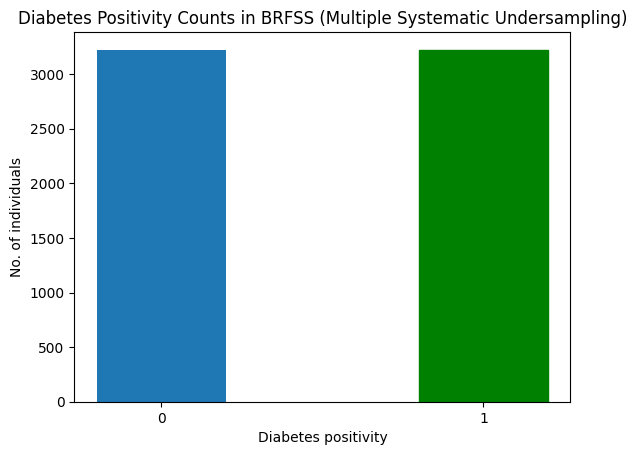

In [ ]:
barlist = plt.bar([str(0),str(1)], y_S_Sy.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (Multiple Systematic Undersampling)")
plt.show()

In [ ]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (5158, 15)
y_S_train: (5158,)
X_S_test: (1290, 15)
y_S_test: (1290,)


In [ ]:
model_source_Sy = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_447"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3129 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3130 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3131 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3132 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3133 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3134 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3135 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - AUC: 0.7671 - loss: 0.6094 - val_AUC: 0.8859 - val_loss: 0.4230
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9003 - loss: 0.3991 - val_AUC: 0.9328 - val_loss: 0.3270
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9354 - loss: 0.3198 - val_AUC: 0.9405 - val_loss: 0.3046
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9423 - loss: 0.2995 - val_AUC: 0.9462 - val_loss: 0.2907
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9493 - loss: 0.2853 - val_AUC: 0.9520 - val_loss: 0.2858
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.9545 - loss: 0.2697 - val_AUC: 0.9572 - val_loss: 0.2632
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.9551 - loss: 0.2686 - val_AUC: 0.9594 - val_loss: 0.2623
Epoch 8/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9656 - loss: 0.2365 - val_AUC: 0.9633 - val_loss: 0.2587
Epoch 9/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AU

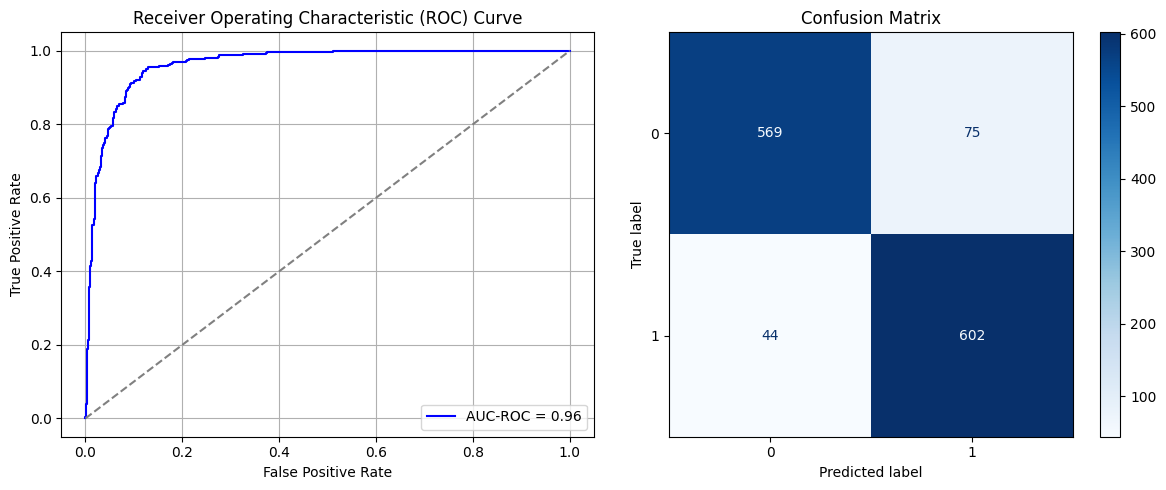

Best threshold based on F1-score: 0.39778581261634827
Time elapsed (performance): 12.120496970999739


<Sequential name=sequential_447, built=True>

In [ ]:
train_and_evaluate(model_source_Sy, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

## As can be seen, the model trains **very** well on the multiple systematic sample above, but this makes it have very poor performance on the fine-tuned target data below (which, being balanced, does not impact the weighting of the DNN enough to overcome FNR).

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC-ROC: 0.6496519721577727
Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.30      0.45      1293
         1.0       0.22      0.89      0.35       289

    accuracy                           0.40      1582
   macro avg       0.57      0.59      0.40      1582
weighted avg       0.79      0.40      0.43      1582

FPR 0.7037896365042536 TPR: 0.889273356401384 FNR: 0.11072664359861592 TNR: 0.29621036349574636


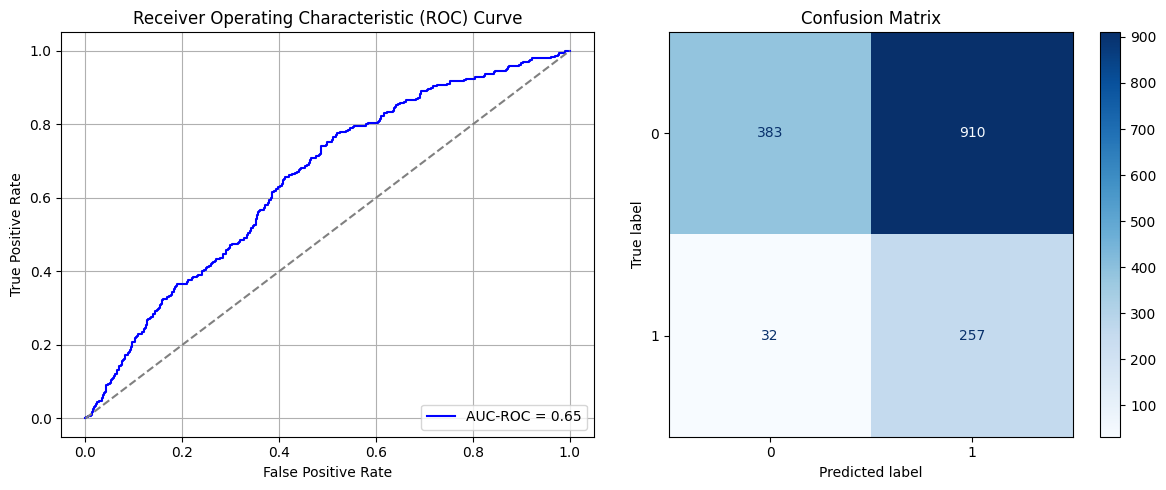

Best threshold based on F1-score: 0.9965623617172241
False Negative Rate: 0.11072664359861592
Time elapsed (performance): 0.7791021459997864


<ipython-input-311-de1f6cb50f3b>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [ ]:
Transductive_TL(model_source_Sy, X_T_test, y_T_test, "Target")

In [ ]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_448"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3136 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3137 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3138 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3139 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3140 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3141 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3142 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.6358 - loss: 0.8312 - val_AUC: 0.6044 - val_loss: 0.4757
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6394 - loss: 0.4741 - val_AUC: 0.6116 - val_loss: 0.4613
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6490 - loss: 0.4480 - val_AUC: 0.6167 - val_loss: 0.4566
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6577 - loss: 0.4465 - val_AUC: 0.6245 - val_loss: 0.4539
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6453 - loss: 0.4507 - val_AUC: 0.6313 - val_loss: 0.4526
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6708 - loss: 0.4465 - val_AUC: 0.6394 - val_loss: 0.4503
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6554 - loss: 0.4483 - val_AUC: 0.6434 - val_loss: 0.4484
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6802 - loss: 0.4367 - val_AUC: 0.6492 - val_loss: 0.4468
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6815 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(np.float64(0.0), np.float64(1.0))

In [ ]:
fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_449"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3143 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3144 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3145 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3146 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3147 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3148 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3149 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.6057 - loss: 1.0736 - val_AUC: 0.0000e+00 - val_loss: 1.1993
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6544 - loss: 0.6597 - val_AUC: 0.0000e+00 - val_loss: 1.0697
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.6573 - loss: 0.6231 - val_AUC: 0.0000e+00 - val_loss: 1.0238
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6235 - loss: 0.6412 - val_AUC: 0.0000e+00 - val_loss: 0.9970
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6422 - loss: 0.6366 - val_AUC: 0.0000e+00 - val_loss: 1.0704
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6374 - loss: 0.6318 - val_AUC: 0.0000e+00 - val_loss: 1.0085
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6522 - loss: 0.6252 - val_AUC: 0.0000e+00 - val_loss: 0.9385
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6647 - loss: 0.6314 - val_AUC: 0.0000e+00 - val_loss: 1.0339
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

(np.float64(0.08507347254447023), np.float64(0.7820069204152249))

In [ ]:
times = 50

FPR = []
FNR = []

for i in range(times):
    fpr, fnr = fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 4)
    # print(output)
    FPR.append(fpr)
    FNR.append(fnr)

ParamFit = pd.DataFrame([FPR, FNR]).T
ParamFit.columns=['FPR', 'FNR']

# fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_452"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3164 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3165 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3166 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3167 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3168 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3169 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3170 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - AUC: 0.6218 - loss: 1.0397 - val_AUC: 0.0000e+00 - val_loss: 1.2729
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6143 - loss: 0.6868 - val_AUC: 0.0000e+00 - val_loss: 0.9902
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6402 - loss: 0.6325 - val_AUC: 0.0000e+00 - val_loss: 0.9464
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6260 - loss: 0.6442 - val_AUC: 0.0000e+00 - val_loss: 0.9731
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6577 - loss: 0.6282 - val_AUC: 0.0000e+00 - val_loss: 1.0516
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6429 - loss: 0.6253 - val_AUC: 0.0000e+00 - val_loss: 0.9082
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6461 - loss: 0.6347 - val_AUC: 0.0000e+00 - val_loss: 0.9703
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6679 - loss: 0.6245 - val_AUC: 0.0000e+00 - val_loss: 1.0258
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_453"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3171 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3172 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3173 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3174 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3175 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3176 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3177 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - AUC: 0.6157 - loss: 1.0717 - val_AUC: 0.0000e+00 - val_loss: 1.3008
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.6493 - loss: 0.6722 - val_AUC: 0.0000e+00 - val_loss: 1.0653
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.6519 - loss: 0.6364 - val_AUC: 0.0000e+00 - val_loss: 1.0480
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6397 - loss: 0.6305 - val_AUC: 0.0000e+00 - val_loss: 0.9774
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6524 - loss: 0.6320 - val_AUC: 0.0000e+00 - val_loss: 1.0103
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6517 - loss: 0.6296 - val_AUC: 0.0000e+00 - val_loss: 0.9926
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6647 - loss: 0.6215 - val_AUC: 0.0000e+00 - val_loss: 0.9988
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6420 - loss: 0.6404 - val_AUC: 0.0000e+00 - val_loss: 1.0158
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_454"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3178 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3179 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3180 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3181 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3182 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3183 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3184 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6009 - loss: 1.0586 - val_AUC: 0.0000e+00 - val_loss: 1.2574
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6342 - loss: 0.6709 - val_AUC: 0.0000e+00 - val_loss: 0.9822
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6588 - loss: 0.6319 - val_AUC: 0.0000e+00 - val_loss: 0.9600
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6334 - loss: 0.6348 - val_AUC: 0.0000e+00 - val_loss: 0.9342
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6467 - loss: 0.6254 - val_AUC: 0.0000e+00 - val_loss: 0.9410
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6390 - loss: 0.6377 - val_AUC: 0.0000e+00 - val_loss: 1.0708
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6392 - loss: 0.6348 - val_AUC: 0.0000e+00 - val_loss: 1.0303
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6603 - loss: 0.6237 - val_AUC: 0.0000e+00 - val_loss: 0.9299
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_455"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3185 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3186 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3187 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3188 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3189 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3190 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3191 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - AUC: 0.6246 - loss: 1.0283 - val_AUC: 0.0000e+00 - val_loss: 1.2740
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.6378 - loss: 0.6811 - val_AUC: 0.0000e+00 - val_loss: 1.0596
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.6297 - loss: 0.6433 - val_AUC: 0.0000e+00 - val_loss: 0.9613
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.6444 - loss: 0.6411 - val_AUC: 0.0000e+00 - val_loss: 1.0703
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6376 - loss: 0.6340 - val_AUC: 0.0000e+00 - val_loss: 0.9539
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6318 - loss: 0.6412 - val_AUC: 0.0000e+00 - val_loss: 1.0007
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6307 - loss: 0.6415 - val_AUC: 0.0000e+00 - val_loss: 0.9891
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6614 - loss: 0.6293 - val_AUC: 0.0000e+00 - val_loss: 0.9896
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_456"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3192 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3193 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3194 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3195 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3196 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3197 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3198 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.6299 - loss: 1.0374 - val_AUC: 0.0000e+00 - val_loss: 1.2257
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6150 - loss: 0.6880 - val_AUC: 0.0000e+00 - val_loss: 0.9684
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6090 - loss: 0.6544 - val_AUC: 0.0000e+00 - val_loss: 0.9722
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6253 - loss: 0.6440 - val_AUC: 0.0000e+00 - val_loss: 0.9945
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6165 - loss: 0.6400 - val_AUC: 0.0000e+00 - val_loss: 0.9957
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6551 - loss: 0.6243 - val_AUC: 0.0000e+00 - val_loss: 0.9808
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6337 - loss: 0.6393 - val_AUC: 0.0000e+00 - val_loss: 1.0650
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6317 - loss: 0.6277 - val_AUC: 0.0000e+00 - val_loss: 0.9276
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_457"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3199 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3200 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3201 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3202 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3203 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3204 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3205 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - AUC: 0.6240 - loss: 1.0214 - val_AUC: 0.0000e+00 - val_loss: 1.2461
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.6266 - loss: 0.6854 - val_AUC: 0.0000e+00 - val_loss: 0.9843
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.6320 - loss: 0.6366 - val_AUC: 0.0000e+00 - val_loss: 0.9889
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6382 - loss: 0.6364 - val_AUC: 0.0000e+00 - val_loss: 0.9550
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6470 - loss: 0.6231 - val_AUC: 0.0000e+00 - val_loss: 0.9594
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6450 - loss: 0.6217 - val_AUC: 0.0000e+00 - val_loss: 0.9263
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6434 - loss: 0.6328 - val_AUC: 0.0000e+00 - val_loss: 1.0540
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6454 - loss: 0.6409 - val_AUC: 0.0000e+00 - val_loss: 1.0203
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_458"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3206 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3207 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3208 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3209 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3210 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3211 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3212 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.6255 - loss: 1.0038 - val_AUC: 0.0000e+00 - val_loss: 1.3209
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6377 - loss: 0.6611 - val_AUC: 0.0000e+00 - val_loss: 1.0083
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6622 - loss: 0.6273 - val_AUC: 0.0000e+00 - val_loss: 0.9852
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6497 - loss: 0.6288 - val_AUC: 0.0000e+00 - val_loss: 1.0020
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.6238 - loss: 0.6427 - val_AUC: 0.0000e+00 - val_loss: 0.9784
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6511 - loss: 0.6267 - val_AUC: 0.0000e+00 - val_loss: 1.0111
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6451 - loss: 0.6360 - val_AUC: 0.0000e+00 - val_loss: 1.0213
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6590 - loss: 0.6296 - val_AUC: 0.0000e+00 - val_loss: 0.9571
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_459"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3213 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3214 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3215 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3216 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3217 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3218 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3219 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - AUC: 0.6427 - loss: 0.9874 - val_AUC: 0.0000e+00 - val_loss: 1.2703
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6328 - loss: 0.6921 - val_AUC: 0.0000e+00 - val_loss: 1.0723
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6144 - loss: 0.6530 - val_AUC: 0.0000e+00 - val_loss: 1.0146
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6393 - loss: 0.6414 - val_AUC: 0.0000e+00 - val_loss: 1.0456
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6522 - loss: 0.6375 - val_AUC: 0.0000e+00 - val_loss: 1.0098
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6296 - loss: 0.6387 - val_AUC: 0.0000e+00 - val_loss: 0.9977
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6498 - loss: 0.6195 - val_AUC: 0.0000e+00 - val_loss: 0.9212
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6681 - loss: 0.6239 - val_AUC: 0.0000e+00 - val_loss: 0.9325
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_460"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3220 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3221 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3222 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3223 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3224 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3225 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3226 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6118 - loss: 1.1297 - val_AUC: 0.0000e+00 - val_loss: 1.1969
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6352 - loss: 0.6892 - val_AUC: 0.0000e+00 - val_loss: 1.0329
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6354 - loss: 0.6426 - val_AUC: 0.0000e+00 - val_loss: 1.0348
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6297 - loss: 0.6439 - val_AUC: 0.0000e+00 - val_loss: 1.0029
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6528 - loss: 0.6180 - val_AUC: 0.0000e+00 - val_loss: 0.8763
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6558 - loss: 0.6239 - val_AUC: 0.0000e+00 - val_loss: 0.9060
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6441 - loss: 0.6324 - val_AUC: 0.0000e+00 - val_loss: 0.9793
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6652 - loss: 0.6227 - val_AUC: 0.0000e+00 - val_loss: 0.9749
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_461"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3227 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3228 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3229 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3230 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3231 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3232 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3233 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - AUC: 0.6501 - loss: 0.9683 - val_AUC: 0.0000e+00 - val_loss: 1.2913
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6365 - loss: 0.6791 - val_AUC: 0.0000e+00 - val_loss: 1.0361
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.6521 - loss: 0.6354 - val_AUC: 0.0000e+00 - val_loss: 1.0632
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6361 - loss: 0.6336 - val_AUC: 0.0000e+00 - val_loss: 0.9210
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6346 - loss: 0.6450 - val_AUC: 0.0000e+00 - val_loss: 1.0143
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6434 - loss: 0.6363 - val_AUC: 0.0000e+00 - val_loss: 0.9909
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6469 - loss: 0.6438 - val_AUC: 0.0000e+00 - val_loss: 1.0954
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6338 - loss: 0.6337 - val_AUC: 0.0000e+00 - val_loss: 0.8883
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_462"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3234 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3235 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3236 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3237 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3238 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3239 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3240 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6238 - loss: 0.9983 - val_AUC: 0.0000e+00 - val_loss: 1.3129
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6444 - loss: 0.6672 - val_AUC: 0.0000e+00 - val_loss: 1.0574
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6201 - loss: 0.6622 - val_AUC: 0.0000e+00 - val_loss: 1.0623
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6411 - loss: 0.6374 - val_AUC: 0.0000e+00 - val_loss: 0.9703
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6655 - loss: 0.6282 - val_AUC: 0.0000e+00 - val_loss: 1.0504
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6509 - loss: 0.6371 - val_AUC: 0.0000e+00 - val_loss: 1.0649
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6496 - loss: 0.6328 - val_AUC: 0.0000e+00 - val_loss: 0.9826
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6562 - loss: 0.6223 - val_AUC: 0.0000e+00 - val_loss: 0.9193
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_463"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3241 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3242 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3243 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3244 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3245 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3246 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3247 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - AUC: 0.6239 - loss: 1.0444 - val_AUC: 0.0000e+00 - val_loss: 1.2946
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.6705 - loss: 0.6467 - val_AUC: 0.0000e+00 - val_loss: 1.0527
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.6062 - loss: 0.6572 - val_AUC: 0.0000e+00 - val_loss: 0.9854
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6152 - loss: 0.6382 - val_AUC: 0.0000e+00 - val_loss: 0.9656
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6565 - loss: 0.6267 - val_AUC: 0.0000e+00 - val_loss: 1.0400
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6274 - loss: 0.6405 - val_AUC: 0.0000e+00 - val_loss: 1.0011
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6534 - loss: 0.6352 - val_AUC: 0.0000e+00 - val_loss: 0.9749
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6705 - loss: 0.6225 - val_AUC: 0.0000e+00 - val_loss: 0.9822
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_464"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3248 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3249 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3250 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3251 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3252 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3253 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3254 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6095 - loss: 1.0396 - val_AUC: 0.0000e+00 - val_loss: 1.3356
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6726 - loss: 0.6590 - val_AUC: 0.0000e+00 - val_loss: 1.1084
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6303 - loss: 0.6480 - val_AUC: 0.0000e+00 - val_loss: 0.9773
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6393 - loss: 0.6413 - val_AUC: 0.0000e+00 - val_loss: 0.9830
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6401 - loss: 0.6325 - val_AUC: 0.0000e+00 - val_loss: 0.9854
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6381 - loss: 0.6426 - val_AUC: 0.0000e+00 - val_loss: 1.0454
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6430 - loss: 0.6309 - val_AUC: 0.0000e+00 - val_loss: 1.0111
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6590 - loss: 0.6238 - val_AUC: 0.0000e+00 - val_loss: 1.0259
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_465"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3255 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3256 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3257 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3258 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3259 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3260 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3261 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - AUC: 0.6222 - loss: 0.9984 - val_AUC: 0.0000e+00 - val_loss: 1.3016
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.6340 - loss: 0.6731 - val_AUC: 0.0000e+00 - val_loss: 1.0121
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.6415 - loss: 0.6383 - val_AUC: 0.0000e+00 - val_loss: 0.9545
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6236 - loss: 0.6415 - val_AUC: 0.0000e+00 - val_loss: 0.8844
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6477 - loss: 0.6318 - val_AUC: 0.0000e+00 - val_loss: 0.9885
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6574 - loss: 0.6301 - val_AUC: 0.0000e+00 - val_loss: 1.0057
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6506 - loss: 0.6311 - val_AUC: 0.0000e+00 - val_loss: 1.0167
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6713 - loss: 0.6315 - val_AUC: 0.0000e+00 - val_loss: 1.0256
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_466"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3262 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3263 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3264 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3265 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3266 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3267 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3268 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6207 - loss: 1.0255 - val_AUC: 0.0000e+00 - val_loss: 1.2617
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6488 - loss: 0.6572 - val_AUC: 0.0000e+00 - val_loss: 0.9336
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6461 - loss: 0.6394 - val_AUC: 0.0000e+00 - val_loss: 0.9965
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6543 - loss: 0.6252 - val_AUC: 0.0000e+00 - val_loss: 1.0029
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6175 - loss: 0.6435 - val_AUC: 0.0000e+00 - val_loss: 1.0170
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6559 - loss: 0.6210 - val_AUC: 0.0000e+00 - val_loss: 0.9677
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6586 - loss: 0.6231 - val_AUC: 0.0000e+00 - val_loss: 0.9859
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6527 - loss: 0.6224 - val_AUC: 0.0000e+00 - val_loss: 0.9057
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_467"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3269 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3270 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3271 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3272 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3273 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3274 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3275 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - AUC: 0.6231 - loss: 1.0103 - val_AUC: 0.0000e+00 - val_loss: 1.2887
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.6113 - loss: 0.6980 - val_AUC: 0.0000e+00 - val_loss: 1.0831
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.6296 - loss: 0.6374 - val_AUC: 0.0000e+00 - val_loss: 1.0125
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.6569 - loss: 0.6309 - val_AUC: 0.0000e+00 - val_loss: 1.0103
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.6559 - loss: 0.6288 - val_AUC: 0.0000e+00 - val_loss: 0.9893
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6435 - loss: 0.6397 - val_AUC: 0.0000e+00 - val_loss: 1.0067
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6544 - loss: 0.6312 - val_AUC: 0.0000e+00 - val_loss: 1.0384
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6580 - loss: 0.6243 - val_AUC: 0.0000e+00 - val_loss: 1.0070
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_468"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3276 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3277 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3278 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3279 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3280 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3281 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3282 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6136 - loss: 1.0619 - val_AUC: 0.0000e+00 - val_loss: 1.2020
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6366 - loss: 0.6913 - val_AUC: 0.0000e+00 - val_loss: 1.1324
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6369 - loss: 0.6546 - val_AUC: 0.0000e+00 - val_loss: 1.0407
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6341 - loss: 0.6397 - val_AUC: 0.0000e+00 - val_loss: 1.0016
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6419 - loss: 0.6381 - val_AUC: 0.0000e+00 - val_loss: 1.0376
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6509 - loss: 0.6266 - val_AUC: 0.0000e+00 - val_loss: 0.9380
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6519 - loss: 0.6287 - val_AUC: 0.0000e+00 - val_loss: 1.0192
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6550 - loss: 0.6309 - val_AUC: 0.0000e+00 - val_loss: 0.9615
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_469"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3283 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3284 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3285 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3286 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3287 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3288 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3289 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6133 - loss: 1.0779 - val_AUC: 0.0000e+00 - val_loss: 1.3047
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6235 - loss: 0.7002 - val_AUC: 0.0000e+00 - val_loss: 1.0387
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6281 - loss: 0.6561 - val_AUC: 0.0000e+00 - val_loss: 1.0471
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6425 - loss: 0.6357 - val_AUC: 0.0000e+00 - val_loss: 0.9570
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.6383 - loss: 0.6257 - val_AUC: 0.0000e+00 - val_loss: 0.9035
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - AUC: 0.6536 - loss: 0.6250 - val_AUC: 0.0000e+00 - val_loss: 0.9906
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.6638 - loss: 0.6213 - val_AUC: 0.0000e+00 - val_loss: 0.9864
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.6586 - loss: 0.6246 - val_AUC: 0.0000e+00 - val_loss: 1.0073
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_470"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3290 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3291 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3292 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3293 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3294 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3295 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3296 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - AUC: 0.6147 - loss: 1.0548 - val_AUC: 0.0000e+00 - val_loss: 1.2420
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6522 - loss: 0.6586 - val_AUC: 0.0000e+00 - val_loss: 1.0200
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6330 - loss: 0.6407 - val_AUC: 0.0000e+00 - val_loss: 1.0590
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6438 - loss: 0.6438 - val_AUC: 0.0000e+00 - val_loss: 1.0062
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6314 - loss: 0.6340 - val_AUC: 0.0000e+00 - val_loss: 1.0289
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6409 - loss: 0.6339 - val_AUC: 0.0000e+00 - val_loss: 0.9600
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6580 - loss: 0.6268 - val_AUC: 0.0000e+00 - val_loss: 0.9886
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6604 - loss: 0.6282 - val_AUC: 0.0000e+00 - val_loss: 1.0799
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_471"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3297 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3298 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3299 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3300 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3301 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3302 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3303 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6287 - loss: 1.0287 - val_AUC: 0.0000e+00 - val_loss: 1.2645
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6470 - loss: 0.6752 - val_AUC: 0.0000e+00 - val_loss: 1.0810
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6588 - loss: 0.6359 - val_AUC: 0.0000e+00 - val_loss: 1.0618
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6268 - loss: 0.6400 - val_AUC: 0.0000e+00 - val_loss: 0.9869
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.6441 - loss: 0.6220 - val_AUC: 0.0000e+00 - val_loss: 0.9075
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.6407 - loss: 0.6383 - val_AUC: 0.0000e+00 - val_loss: 0.9756
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.6225 - loss: 0.6391 - val_AUC: 0.0000e+00 - val_loss: 0.9324
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.6469 - loss: 0.6324 - val_AUC: 0.0000e+00 - val_loss: 0.9601
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_472"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3304 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3305 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3306 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3307 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3308 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3309 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3310 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - AUC: 0.6151 - loss: 1.0343 - val_AUC: 0.0000e+00 - val_loss: 1.2650
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6438 - loss: 0.6543 - val_AUC: 0.0000e+00 - val_loss: 1.0248
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.6149 - loss: 0.6546 - val_AUC: 0.0000e+00 - val_loss: 1.0039
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6459 - loss: 0.6341 - val_AUC: 0.0000e+00 - val_loss: 1.0681
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6638 - loss: 0.6214 - val_AUC: 0.0000e+00 - val_loss: 0.9744
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6368 - loss: 0.6340 - val_AUC: 0.0000e+00 - val_loss: 0.9724
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6727 - loss: 0.6198 - val_AUC: 0.0000e+00 - val_loss: 0.9289
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6589 - loss: 0.6225 - val_AUC: 0.0000e+00 - val_loss: 0.8622
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_473"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3311 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3312 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3313 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3314 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3315 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3316 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3317 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6156 - loss: 1.0494 - val_AUC: 0.0000e+00 - val_loss: 1.2835
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6333 - loss: 0.6752 - val_AUC: 0.0000e+00 - val_loss: 1.0388
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6385 - loss: 0.6454 - val_AUC: 0.0000e+00 - val_loss: 1.1069
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6323 - loss: 0.6460 - val_AUC: 0.0000e+00 - val_loss: 1.0955
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.6363 - loss: 0.6390 - val_AUC: 0.0000e+00 - val_loss: 0.9775
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.6434 - loss: 0.6268 - val_AUC: 0.0000e+00 - val_loss: 0.9546
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.6250 - loss: 0.6377 - val_AUC: 0.0000e+00 - val_loss: 0.9810
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.6607 - loss: 0.6278 - val_AUC: 0.0000e+00 - val_loss: 1.0566
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_474"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3318 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3319 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3320 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3321 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3322 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3323 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3324 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6191 - loss: 1.0564 - val_AUC: 0.0000e+00 - val_loss: 1.2011
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6364 - loss: 0.6772 - val_AUC: 0.0000e+00 - val_loss: 1.0281
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6316 - loss: 0.6429 - val_AUC: 0.0000e+00 - val_loss: 0.9912
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6431 - loss: 0.6327 - val_AUC: 0.0000e+00 - val_loss: 0.9326
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6234 - loss: 0.6416 - val_AUC: 0.0000e+00 - val_loss: 0.9741
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6457 - loss: 0.6256 - val_AUC: 0.0000e+00 - val_loss: 0.9757
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6372 - loss: 0.6289 - val_AUC: 0.0000e+00 - val_loss: 0.9802
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6611 - loss: 0.6214 - val_AUC: 0.0000e+00 - val_loss: 0.9243
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_475"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3325 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3326 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3327 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3328 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3329 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3330 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3331 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6016 - loss: 1.0587 - val_AUC: 0.0000e+00 - val_loss: 1.2545
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6202 - loss: 0.6936 - val_AUC: 0.0000e+00 - val_loss: 1.0433
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6144 - loss: 0.6558 - val_AUC: 0.0000e+00 - val_loss: 0.9890
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6307 - loss: 0.6475 - val_AUC: 0.0000e+00 - val_loss: 1.0242
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6597 - loss: 0.6284 - val_AUC: 0.0000e+00 - val_loss: 1.0141
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6427 - loss: 0.6313 - val_AUC: 0.0000e+00 - val_loss: 1.0086
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6591 - loss: 0.6271 - val_AUC: 0.0000e+00 - val_loss: 0.9584
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.6630 - loss: 0.6213 - val_AUC: 0.0000e+00 - val_loss: 0.9363
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_476"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3332 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3333 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3334 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3335 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3336 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3337 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3338 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6318 - loss: 1.0076 - val_AUC: 0.0000e+00 - val_loss: 1.2461
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6452 - loss: 0.6851 - val_AUC: 0.0000e+00 - val_loss: 1.0849
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6356 - loss: 0.6447 - val_AUC: 0.0000e+00 - val_loss: 1.0429
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6464 - loss: 0.6264 - val_AUC: 0.0000e+00 - val_loss: 0.9837
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6582 - loss: 0.6330 - val_AUC: 0.0000e+00 - val_loss: 0.9999
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6658 - loss: 0.6219 - val_AUC: 0.0000e+00 - val_loss: 0.9824
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6472 - loss: 0.6282 - val_AUC: 0.0000e+00 - val_loss: 0.9662
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6862 - loss: 0.6133 - val_AUC: 0.0000e+00 - val_loss: 1.0054
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_477"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3339 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3340 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3341 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3342 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3343 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3344 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3345 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6185 - loss: 1.0268 - val_AUC: 0.0000e+00 - val_loss: 1.2567
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6230 - loss: 0.6914 - val_AUC: 0.0000e+00 - val_loss: 1.0353
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6368 - loss: 0.6453 - val_AUC: 0.0000e+00 - val_loss: 0.9862
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6617 - loss: 0.6236 - val_AUC: 0.0000e+00 - val_loss: 1.0319
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6350 - loss: 0.6251 - val_AUC: 0.0000e+00 - val_loss: 0.9166
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6354 - loss: 0.6332 - val_AUC: 0.0000e+00 - val_loss: 0.9930
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6344 - loss: 0.6462 - val_AUC: 0.0000e+00 - val_loss: 1.0381
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6384 - loss: 0.6283 - val_AUC: 0.0000e+00 - val_loss: 0.9575
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_478"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3346 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3347 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3348 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3349 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3350 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3351 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3352 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6102 - loss: 1.1053 - val_AUC: 0.0000e+00 - val_loss: 1.2101
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6403 - loss: 0.6807 - val_AUC: 0.0000e+00 - val_loss: 1.0123
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6486 - loss: 0.6321 - val_AUC: 0.0000e+00 - val_loss: 0.9973
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6398 - loss: 0.6326 - val_AUC: 0.0000e+00 - val_loss: 0.9783
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6799 - loss: 0.6194 - val_AUC: 0.0000e+00 - val_loss: 1.0810
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6562 - loss: 0.6192 - val_AUC: 0.0000e+00 - val_loss: 0.9799
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6681 - loss: 0.6229 - val_AUC: 0.0000e+00 - val_loss: 1.0025
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6605 - loss: 0.6259 - val_AUC: 0.0000e+00 - val_loss: 0.9895
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_479"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3353 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3354 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3355 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3356 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3357 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3358 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3359 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - AUC: 0.6244 - loss: 1.0693 - val_AUC: 0.0000e+00 - val_loss: 1.2213
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6317 - loss: 0.6811 - val_AUC: 0.0000e+00 - val_loss: 1.0107
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6004 - loss: 0.6639 - val_AUC: 0.0000e+00 - val_loss: 1.0272
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6633 - loss: 0.6339 - val_AUC: 0.0000e+00 - val_loss: 1.0475
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6714 - loss: 0.6364 - val_AUC: 0.0000e+00 - val_loss: 1.1097
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6601 - loss: 0.6327 - val_AUC: 0.0000e+00 - val_loss: 1.0040
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6503 - loss: 0.6247 - val_AUC: 0.0000e+00 - val_loss: 0.9501
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6640 - loss: 0.6223 - val_AUC: 0.0000e+00 - val_loss: 0.8983
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_480"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3360 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3361 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3362 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3363 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3364 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3365 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3366 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - AUC: 0.6260 - loss: 1.0282 - val_AUC: 0.0000e+00 - val_loss: 1.2835
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6196 - loss: 0.6754 - val_AUC: 0.0000e+00 - val_loss: 0.9452
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6359 - loss: 0.6513 - val_AUC: 0.0000e+00 - val_loss: 1.0942
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6373 - loss: 0.6423 - val_AUC: 0.0000e+00 - val_loss: 1.0015
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6420 - loss: 0.6369 - val_AUC: 0.0000e+00 - val_loss: 0.9934
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6594 - loss: 0.6233 - val_AUC: 0.0000e+00 - val_loss: 1.0365
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6428 - loss: 0.6275 - val_AUC: 0.0000e+00 - val_loss: 1.0162
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6456 - loss: 0.6358 - val_AUC: 0.0000e+00 - val_loss: 0.9626
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_481"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3367 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3368 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3369 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3370 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3371 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3372 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3373 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.5886 - loss: 1.1187 - val_AUC: 0.0000e+00 - val_loss: 1.1895
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6180 - loss: 0.7047 - val_AUC: 0.0000e+00 - val_loss: 1.0486
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6356 - loss: 0.6419 - val_AUC: 0.0000e+00 - val_loss: 1.0291
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.5976 - loss: 0.6525 - val_AUC: 0.0000e+00 - val_loss: 0.9741
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6465 - loss: 0.6318 - val_AUC: 0.0000e+00 - val_loss: 0.9485
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6478 - loss: 0.6261 - val_AUC: 0.0000e+00 - val_loss: 0.9702
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6616 - loss: 0.6191 - val_AUC: 0.0000e+00 - val_loss: 0.9499
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6563 - loss: 0.6201 - val_AUC: 0.0000e+00 - val_loss: 0.9597
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_482"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3374 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3375 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3376 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3377 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3378 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3379 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3380 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - AUC: 0.6346 - loss: 0.9966 - val_AUC: 0.0000e+00 - val_loss: 1.3074
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.6307 - loss: 0.6869 - val_AUC: 0.0000e+00 - val_loss: 1.1053
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6092 - loss: 0.6568 - val_AUC: 0.0000e+00 - val_loss: 1.0183
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6783 - loss: 0.6157 - val_AUC: 0.0000e+00 - val_loss: 1.0301
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6250 - loss: 0.6510 - val_AUC: 0.0000e+00 - val_loss: 1.0058
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6527 - loss: 0.6244 - val_AUC: 0.0000e+00 - val_loss: 0.9678
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6391 - loss: 0.6381 - val_AUC: 0.0000e+00 - val_loss: 1.0206
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6591 - loss: 0.6221 - val_AUC: 0.0000e+00 - val_loss: 0.9970
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_483"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3381 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3382 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3383 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3384 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3385 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3386 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3387 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6122 - loss: 1.0707 - val_AUC: 0.0000e+00 - val_loss: 1.2413
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6492 - loss: 0.6604 - val_AUC: 0.0000e+00 - val_loss: 0.9749
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6314 - loss: 0.6502 - val_AUC: 0.0000e+00 - val_loss: 1.0778
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6461 - loss: 0.6274 - val_AUC: 0.0000e+00 - val_loss: 0.8787
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6409 - loss: 0.6345 - val_AUC: 0.0000e+00 - val_loss: 1.0234
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6460 - loss: 0.6287 - val_AUC: 0.0000e+00 - val_loss: 0.9344
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6673 - loss: 0.6201 - val_AUC: 0.0000e+00 - val_loss: 0.9689
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6561 - loss: 0.6170 - val_AUC: 0.0000e+00 - val_loss: 0.8739
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_484"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3388 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3389 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3390 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3391 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3392 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3393 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3394 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - AUC: 0.5949 - loss: 1.0713 - val_AUC: 0.0000e+00 - val_loss: 1.2475
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.6282 - loss: 0.6781 - val_AUC: 0.0000e+00 - val_loss: 1.0394
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.6102 - loss: 0.6539 - val_AUC: 0.0000e+00 - val_loss: 0.9459
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.6409 - loss: 0.6367 - val_AUC: 0.0000e+00 - val_loss: 0.9673
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6465 - loss: 0.6357 - val_AUC: 0.0000e+00 - val_loss: 1.0670
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6440 - loss: 0.6328 - val_AUC: 0.0000e+00 - val_loss: 0.9607
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6367 - loss: 0.6267 - val_AUC: 0.0000e+00 - val_loss: 0.8837
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6617 - loss: 0.6204 - val_AUC: 0.0000e+00 - val_loss: 0.9587
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_485"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3395 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3396 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3397 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3398 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3399 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3400 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3401 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6210 - loss: 1.0405 - val_AUC: 0.0000e+00 - val_loss: 1.2197
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6281 - loss: 0.6730 - val_AUC: 0.0000e+00 - val_loss: 1.0329
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.6423 - loss: 0.6272 - val_AUC: 0.0000e+00 - val_loss: 0.9358
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6342 - loss: 0.6369 - val_AUC: 0.0000e+00 - val_loss: 0.9989
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6368 - loss: 0.6443 - val_AUC: 0.0000e+00 - val_loss: 1.0551
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6466 - loss: 0.6243 - val_AUC: 0.0000e+00 - val_loss: 0.8896
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6452 - loss: 0.6344 - val_AUC: 0.0000e+00 - val_loss: 1.0346
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6621 - loss: 0.6210 - val_AUC: 0.0000e+00 - val_loss: 0.9707
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_486"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3402 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3403 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3404 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3405 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3406 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3407 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3408 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - AUC: 0.6018 - loss: 1.0852 - val_AUC: 0.0000e+00 - val_loss: 1.2075
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.6143 - loss: 0.6989 - val_AUC: 0.0000e+00 - val_loss: 1.0572
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.6485 - loss: 0.6351 - val_AUC: 0.0000e+00 - val_loss: 1.0905
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6443 - loss: 0.6293 - val_AUC: 0.0000e+00 - val_loss: 1.0715
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6375 - loss: 0.6305 - val_AUC: 0.0000e+00 - val_loss: 1.0206
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6572 - loss: 0.6178 - val_AUC: 0.0000e+00 - val_loss: 0.9685
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6345 - loss: 0.6328 - val_AUC: 0.0000e+00 - val_loss: 0.8893
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6545 - loss: 0.6281 - val_AUC: 0.0000e+00 - val_loss: 1.0421
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_487"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3409 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3410 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3411 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3412 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3413 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3414 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3415 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6234 - loss: 1.0513 - val_AUC: 0.0000e+00 - val_loss: 1.2202
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6250 - loss: 0.6937 - val_AUC: 0.0000e+00 - val_loss: 1.1046
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6286 - loss: 0.6463 - val_AUC: 0.0000e+00 - val_loss: 1.0081
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6410 - loss: 0.6354 - val_AUC: 0.0000e+00 - val_loss: 1.0455
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6462 - loss: 0.6238 - val_AUC: 0.0000e+00 - val_loss: 0.9664
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6406 - loss: 0.6415 - val_AUC: 0.0000e+00 - val_loss: 1.0708
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6354 - loss: 0.6309 - val_AUC: 0.0000e+00 - val_loss: 0.9495
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6394 - loss: 0.6317 - val_AUC: 0.0000e+00 - val_loss: 1.0046
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_488"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3416 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3417 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3418 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3419 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3420 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3421 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3422 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - AUC: 0.6357 - loss: 1.0414 - val_AUC: 0.0000e+00 - val_loss: 1.2751
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6401 - loss: 0.6720 - val_AUC: 0.0000e+00 - val_loss: 1.0884
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.6215 - loss: 0.6565 - val_AUC: 0.0000e+00 - val_loss: 1.0192
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6404 - loss: 0.6251 - val_AUC: 0.0000e+00 - val_loss: 0.9708
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6573 - loss: 0.6247 - val_AUC: 0.0000e+00 - val_loss: 1.0089
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6277 - loss: 0.6381 - val_AUC: 0.0000e+00 - val_loss: 1.0140
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6627 - loss: 0.6259 - val_AUC: 0.0000e+00 - val_loss: 0.9473
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6701 - loss: 0.6186 - val_AUC: 0.0000e+00 - val_loss: 1.0213
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_489"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3423 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3424 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3425 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3426 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3427 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3428 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3429 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6138 - loss: 1.0984 - val_AUC: 0.0000e+00 - val_loss: 1.2023
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.6435 - loss: 0.6697 - val_AUC: 0.0000e+00 - val_loss: 1.0387
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6491 - loss: 0.6304 - val_AUC: 0.0000e+00 - val_loss: 0.9997
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6358 - loss: 0.6327 - val_AUC: 0.0000e+00 - val_loss: 0.9553
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6539 - loss: 0.6305 - val_AUC: 0.0000e+00 - val_loss: 0.9762
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6406 - loss: 0.6231 - val_AUC: 0.0000e+00 - val_loss: 0.8777
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6420 - loss: 0.6378 - val_AUC: 0.0000e+00 - val_loss: 1.0102
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6604 - loss: 0.6284 - val_AUC: 0.0000e+00 - val_loss: 1.0460
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_490"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3430 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3431 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3432 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3433 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3434 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3435 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3436 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - AUC: 0.6110 - loss: 1.0557 - val_AUC: 0.0000e+00 - val_loss: 1.3014
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.6185 - loss: 0.6970 - val_AUC: 0.0000e+00 - val_loss: 1.0015
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6338 - loss: 0.6420 - val_AUC: 0.0000e+00 - val_loss: 0.9981
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6306 - loss: 0.6393 - val_AUC: 0.0000e+00 - val_loss: 0.8971
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6367 - loss: 0.6364 - val_AUC: 0.0000e+00 - val_loss: 0.9800
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6499 - loss: 0.6106 - val_AUC: 0.0000e+00 - val_loss: 0.8556
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6618 - loss: 0.6256 - val_AUC: 0.0000e+00 - val_loss: 1.0682
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6704 - loss: 0.6228 - val_AUC: 0.0000e+00 - val_loss: 1.0252
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_491"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3437 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3438 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3439 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3440 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3441 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3442 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3443 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6283 - loss: 1.0445 - val_AUC: 0.0000e+00 - val_loss: 1.2551
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6204 - loss: 0.7004 - val_AUC: 0.0000e+00 - val_loss: 1.0628
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6328 - loss: 0.6476 - val_AUC: 0.0000e+00 - val_loss: 0.9951
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6397 - loss: 0.6422 - val_AUC: 0.0000e+00 - val_loss: 1.0581
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6533 - loss: 0.6220 - val_AUC: 0.0000e+00 - val_loss: 0.9174
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6620 - loss: 0.6207 - val_AUC: 0.0000e+00 - val_loss: 0.9802
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6720 - loss: 0.6187 - val_AUC: 0.0000e+00 - val_loss: 0.9827
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6488 - loss: 0.6205 - val_AUC: 0.0000e+00 - val_loss: 0.9500
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_492"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3444 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3445 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3446 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3447 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3448 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3449 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3450 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - AUC: 0.6232 - loss: 1.0485 - val_AUC: 0.0000e+00 - val_loss: 1.1943
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.6259 - loss: 0.7013 - val_AUC: 0.0000e+00 - val_loss: 1.1291
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6266 - loss: 0.6541 - val_AUC: 0.0000e+00 - val_loss: 1.0295
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6228 - loss: 0.6386 - val_AUC: 0.0000e+00 - val_loss: 0.9717
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6466 - loss: 0.6230 - val_AUC: 0.0000e+00 - val_loss: 0.9468
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6355 - loss: 0.6355 - val_AUC: 0.0000e+00 - val_loss: 1.0231
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6609 - loss: 0.6262 - val_AUC: 0.0000e+00 - val_loss: 0.9828
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6678 - loss: 0.6283 - val_AUC: 0.0000e+00 - val_loss: 0.9799
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_493"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3451 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3452 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3453 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3454 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3455 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3456 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3457 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6174 - loss: 1.0488 - val_AUC: 0.0000e+00 - val_loss: 1.2567
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6067 - loss: 0.7084 - val_AUC: 0.0000e+00 - val_loss: 1.0052
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6285 - loss: 0.6527 - val_AUC: 0.0000e+00 - val_loss: 1.0488
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.6548 - loss: 0.6340 - val_AUC: 0.0000e+00 - val_loss: 1.0059
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6494 - loss: 0.6291 - val_AUC: 0.0000e+00 - val_loss: 1.0108
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6347 - loss: 0.6431 - val_AUC: 0.0000e+00 - val_loss: 1.0120
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6562 - loss: 0.6210 - val_AUC: 0.0000e+00 - val_loss: 0.9678
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6382 - loss: 0.6361 - val_AUC: 0.0000e+00 - val_loss: 0.9658
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_494"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3458 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3459 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3460 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3461 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3462 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3463 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3464 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - AUC: 0.6377 - loss: 0.9907 - val_AUC: 0.0000e+00 - val_loss: 1.2561
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.6336 - loss: 0.6931 - val_AUC: 0.0000e+00 - val_loss: 1.1311
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.6348 - loss: 0.6494 - val_AUC: 0.0000e+00 - val_loss: 1.0553
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6201 - loss: 0.6371 - val_AUC: 0.0000e+00 - val_loss: 0.9827
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6370 - loss: 0.6412 - val_AUC: 0.0000e+00 - val_loss: 1.0711
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6288 - loss: 0.6285 - val_AUC: 0.0000e+00 - val_loss: 0.9576
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6459 - loss: 0.6243 - val_AUC: 0.0000e+00 - val_loss: 0.9244
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6734 - loss: 0.6254 - val_AUC: 0.0000e+00 - val_loss: 1.0603
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_495"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3465 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3466 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3467 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3468 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3469 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3470 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3471 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6328 - loss: 1.0350 - val_AUC: 0.0000e+00 - val_loss: 1.2689
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6498 - loss: 0.6630 - val_AUC: 0.0000e+00 - val_loss: 1.0068
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6314 - loss: 0.6384 - val_AUC: 0.0000e+00 - val_loss: 0.9046
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6219 - loss: 0.6434 - val_AUC: 0.0000e+00 - val_loss: 1.0280
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6371 - loss: 0.6255 - val_AUC: 0.0000e+00 - val_loss: 0.9077
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6253 - loss: 0.6398 - val_AUC: 0.0000e+00 - val_loss: 0.9394
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6699 - loss: 0.6233 - val_AUC: 0.0000e+00 - val_loss: 0.9743
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6424 - loss: 0.6346 - val_AUC: 0.0000e+00 - val_loss: 1.0394
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_496"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3472 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3473 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3474 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3475 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3476 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3477 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3478 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - AUC: 0.6125 - loss: 1.0273 - val_AUC: 0.0000e+00 - val_loss: 1.2183
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.6512 - loss: 0.6587 - val_AUC: 0.0000e+00 - val_loss: 1.0166
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.6403 - loss: 0.6272 - val_AUC: 0.0000e+00 - val_loss: 0.9093
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6396 - loss: 0.6393 - val_AUC: 0.0000e+00 - val_loss: 1.0658
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6482 - loss: 0.6331 - val_AUC: 0.0000e+00 - val_loss: 0.9900
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6423 - loss: 0.6357 - val_AUC: 0.0000e+00 - val_loss: 0.9967
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6384 - loss: 0.6410 - val_AUC: 0.0000e+00 - val_loss: 1.0082
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6573 - loss: 0.6298 - val_AUC: 0.0000e+00 - val_loss: 1.0138
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_497"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3479 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3480 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3481 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3482 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3483 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3484 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3485 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.6110 - loss: 1.0448 - val_AUC: 0.0000e+00 - val_loss: 1.2369
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6247 - loss: 0.6848 - val_AUC: 0.0000e+00 - val_loss: 0.9840
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6381 - loss: 0.6475 - val_AUC: 0.0000e+00 - val_loss: 1.1206
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6399 - loss: 0.6273 - val_AUC: 0.0000e+00 - val_loss: 0.9481
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6402 - loss: 0.6279 - val_AUC: 0.0000e+00 - val_loss: 0.9318
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6171 - loss: 0.6371 - val_AUC: 0.0000e+00 - val_loss: 0.9068
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6610 - loss: 0.6248 - val_AUC: 0.0000e+00 - val_loss: 1.0422
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6688 - loss: 0.6209 - val_AUC: 0.0000e+00 - val_loss: 0.9984
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_498"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3486 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3487 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3488 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3489 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3490 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3491 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3492 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - AUC: 0.6168 - loss: 1.0771 - val_AUC: 0.0000e+00 - val_loss: 1.2754
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6368 - loss: 0.6656 - val_AUC: 0.0000e+00 - val_loss: 1.0336
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6309 - loss: 0.6506 - val_AUC: 0.0000e+00 - val_loss: 1.0047
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6457 - loss: 0.6328 - val_AUC: 0.0000e+00 - val_loss: 1.0811
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6147 - loss: 0.6433 - val_AUC: 0.0000e+00 - val_loss: 0.9828
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6471 - loss: 0.6390 - val_AUC: 0.0000e+00 - val_loss: 1.0697
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6421 - loss: 0.6276 - val_AUC: 0.0000e+00 - val_loss: 0.9317
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6429 - loss: 0.6332 - val_AUC: 0.0000e+00 - val_loss: 1.0394
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_499"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3493 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3494 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3495 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3496 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3497 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3498 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3499 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.6211 - loss: 1.0562 - val_AUC: 0.0000e+00 - val_loss: 1.2727
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6417 - loss: 0.6735 - val_AUC: 0.0000e+00 - val_loss: 1.0513
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6516 - loss: 0.6337 - val_AUC: 0.0000e+00 - val_loss: 0.9866
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6341 - loss: 0.6489 - val_AUC: 0.0000e+00 - val_loss: 1.0531
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6418 - loss: 0.6354 - val_AUC: 0.0000e+00 - val_loss: 0.9681
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6517 - loss: 0.6335 - val_AUC: 0.0000e+00 - val_loss: 1.0591
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6674 - loss: 0.6317 - val_AUC: 0.0000e+00 - val_loss: 0.9386
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6572 - loss: 0.6226 - val_AUC: 0.0000e+00 - val_loss: 0.9142
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_500"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3500 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3501 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3502 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3503 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3504 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3505 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3506 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.6036 - loss: 1.0662 - val_AUC: 0.0000e+00 - val_loss: 1.2469
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6245 - loss: 0.6902 - val_AUC: 0.0000e+00 - val_loss: 0.9885
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6369 - loss: 0.6446 - val_AUC: 0.0000e+00 - val_loss: 1.0621
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6502 - loss: 0.6273 - val_AUC: 0.0000e+00 - val_loss: 1.0246
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6350 - loss: 0.6415 - val_AUC: 0.0000e+00 - val_loss: 1.0194
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6409 - loss: 0.6367 - val_AUC: 0.0000e+00 - val_loss: 0.9503
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6474 - loss: 0.6395 - val_AUC: 0.0000e+00 - val_loss: 1.0241
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6709 - loss: 0.6248 - val_AUC: 0.0000e+00 - val_loss: 1.0169
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_501"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3507 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3508 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3509 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3510 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3511 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3512 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3513 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.5980 - loss: 1.0769 - val_AUC: 0.0000e+00 - val_loss: 1.2104
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6434 - loss: 0.6785 - val_AUC: 0.0000e+00 - val_loss: 1.1864
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6305 - loss: 0.6483 - val_AUC: 0.0000e+00 - val_loss: 0.9864
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6471 - loss: 0.6336 - val_AUC: 0.0000e+00 - val_loss: 1.0718
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6560 - loss: 0.6370 - val_AUC: 0.0000e+00 - val_loss: 0.9465
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6545 - loss: 0.6230 - val_AUC: 0.0000e+00 - val_loss: 0.9460
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6494 - loss: 0.6227 - val_AUC: 0.0000e+00 - val_loss: 0.9181
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6400 - loss: 0.6346 - val_AUC: 0.0000e+00 - val_loss: 1.0057
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
print(ParamFit)
ParamFit.to_csv('Sy_multi_Fine_Tuning.csv')

         FPR       FNR
0   0.134571  0.702422
1   0.194896  0.591696
2   0.201856  0.577855
3   0.105182  0.764706
4   0.082753  0.782007
5   0.082753  0.785467
6   0.043310  0.878893
7   0.092034  0.775087
8   0.143852  0.681661
9   0.160866  0.636678
10  0.078113  0.792388
11  0.101315  0.768166
12  0.064965  0.816609
13  0.064192  0.820069
14  0.175561  0.636678
15  0.099768  0.768166
16  0.075019  0.792388
17  0.138438  0.695502
18  0.092807  0.771626
19  0.146945  0.674740
20  0.060325  0.833910
21  0.129157  0.726644
22  0.145398  0.678201
23  0.039443  0.882353
24  0.149265  0.667820
25  0.055684  0.840830
26  0.091261  0.771626
27  0.085073  0.782007
28  0.095128  0.768166
29  0.025522  0.920415
30  0.119103  0.743945
31  0.119876  0.723183
32  0.054138  0.847751
33  0.013921  0.944637
34  0.072699  0.795848
35  0.103635  0.764706
36  0.066512  0.823529
37  0.097448  0.768166
38  0.095901  0.771626
39  0.105955  0.757785
40  0.154679  0.657439
41  0.078113  0.792388
42  0.12219

# Random Oversampling (ROS):

## Simple Random Sampling with Replacement:

In this case, we investigate the effectiveness of Random Oversampling methods, beginning with Simple Random Sampling (SRS) with replacement. For this, we perform random resampling from the minority class of size $N_1$ to generate an additional sample of size $N_0-N_1$, such that the oversampled minority class will have the same size as the majority class.

In [ ]:
X_S_SRS, y_S_SRS = SRSwR_oversampler(data_S_full, data_S_full.iloc[:, -1])
print(y_S_SRS)

X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRS, y_S_SRS, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)
T_train = pd.concat([X_T_train, y_T_train], axis=1)

X_T_train_SRS, y_T_train_SRS = SRSwR_oversampler(T_train, T_train.iloc[:, -1])
print(y_T_train_SRS)

3224
32062
0        0
1        0
2        0
3        0
4        0
        ..
34739    1
11069    1
15355    1
33913    1
33450    1
Name: Y2, Length: 64124, dtype: int64
1135
5190
2026    0.0
4052    0.0
4096    0.0
4319    0.0
2572    0.0
       ... 
7392    1.0
6347    1.0
3887    1.0
3142    1.0
7422    1.0
Name: Y, Length: 10380, dtype: float64


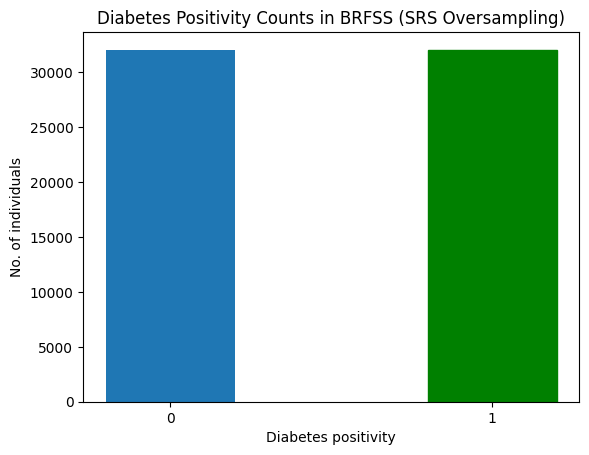

In [ ]:
barlist = plt.bar([str(0),str(1)], y_S_SRS.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (SRS Oversampling)")
plt.show()

In [ ]:
model_source_SRS_ROS = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_502"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3514 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3515 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3516 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3517 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3518 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3519 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3520 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.8082 - loss: 0.5162 - val_AUC: 0.9041 - val_loss: 0.4048
Epoch 2/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9069 - loss: 0.3810 - val_AUC: 0.9121 - val_loss: 0.3832
Epoch 3/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9141 - loss: 0.3632 - val_AUC: 0.9188 - val_loss: 0.3695
Epoch 4/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9214 - loss: 0.3474 - val_AUC: 0.9211 - val_loss: 0.3517
Epoch 5/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9245 - loss: 0.3371 - val_AUC: 0.9229 - val_loss: 0.3462
Epoch 6/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9268 - loss: 0.3320 - val_AUC: 0.9270 - val_loss: 0.3341
Epoch 7/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - AUC: 0.9296 - loss: 0.3245 - val_AUC: 0.9271 - val_loss: 0.3463
Epoch 8/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9308 - loss: 0.3200 - val_AUC: 0.9304 - val_loss: 0.3226
Epoch 9/10
1283/1283 ━━━━━━━━━━━━━━━━━━━

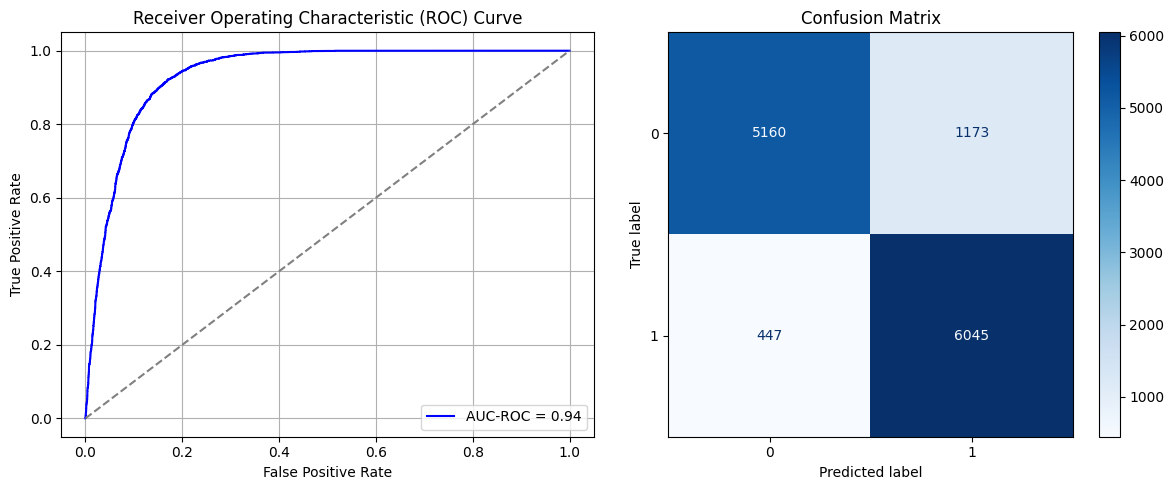

<ipython-input-308-93669339d7ff>:78: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


Best threshold based on F1-score: 0.9753501415252686
Time elapsed (performance): 55.4069536650004


<Sequential name=sequential_502, built=True>

In [ ]:
train_and_evaluate(model_source_SRS_ROS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC-ROC: 0.47903670817310134
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.03      0.06      1293
         1.0       0.19      0.99      0.31       289

    accuracy                           0.21      1582
   macro avg       0.57      0.51      0.19      1582
weighted avg       0.81      0.21      0.10      1582

FPR 0.9706109822119103 TPR: 0.9930795847750865 FNR: 0.006920415224913495 TNR: 0.029389017788089666


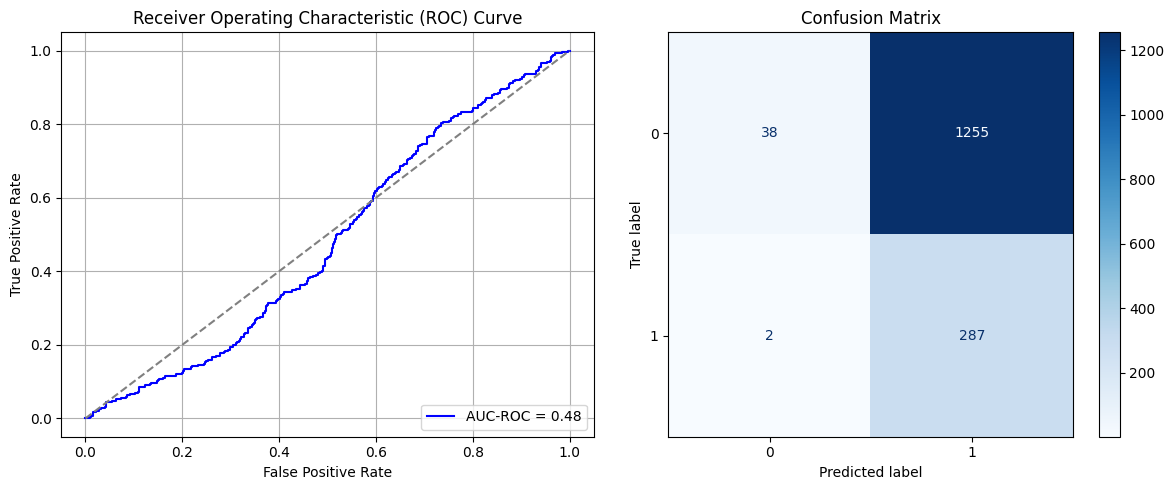

Best threshold based on F1-score: 0.9853426814079285
False Negative Rate: 0.006920415224913495
Time elapsed (performance): 0.5725265080000099


<ipython-input-311-de1f6cb50f3b>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [ ]:
Transductive_TL(model_source_SRS_ROS, X_T_test, y_T_test, "Target")

In [ ]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_503"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3521 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3522 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3523 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3524 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3525 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3526 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3527 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.4787 - loss: 1.2602 - val_AUC: 0.5280 - val_loss: 0.4808
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.5424 - loss: 0.4927 - val_AUC: 0.5725 - val_loss: 0.4645
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.5821 - loss: 0.4715 - val_AUC: 0.6124 - val_loss: 0.4566
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.5680 - loss: 0.4706 - val_AUC: 0.6530 - val_loss: 0.4465
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - AUC: 0.6291 - loss: 0.4552 - val_AUC: 0.6866 - val_loss: 0.4398
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.6784 - loss: 0.4524 - val_AUC: 0.7330 - val_loss: 0.4324
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6873 - loss: 0.4469 - val_AUC: 0.7489 - val_loss: 0.4290
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - AUC: 0.6910 - loss: 0.4382 - val_AUC: 0.7527 - val_loss: 0.4208
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7205

(np.float64(0.0015467904098994587), np.float64(0.9792387543252595))

In [ ]:
fine_tuning(X_T_train_SRS, X_T_test, y_T_train_SRS, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_504"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3528 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3529 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3530 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3531 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3532 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3533 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3534 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5074 - loss: 0.9951 - val_AUC: 0.0000e+00 - val_loss: 0.9917
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6084 - loss: 0.6468 - val_AUC: 0.0000e+00 - val_loss: 1.0506
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6663 - loss: 0.6222 - val_AUC: 0.0000e+00 - val_loss: 0.8381
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7113 - loss: 0.6032 - val_AUC: 0.0000e+00 - val_loss: 0.8434
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7300 - loss: 0.5907 - val_AUC: 0.0000e+00 - val_loss: 0.9631
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7281 - loss: 0.5881 - val_AUC: 0.0000e+00 - val_loss: 0.9080
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7446 - loss: 0.5773 - val_AUC: 0.0000e+00 - val_loss: 0.8524
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7418 - loss: 0.5771 - val_AUC: 0.0000e+00 - val_loss: 0.8544
Epoch 9/10
260/260 ━━━━━━━━━━━━━━━━

(np.float64(0.1423047177107502), np.float64(0.5709342560553633))

In [ ]:
times = 50

FPR = []
FNR = []

for i in range(times):
    fpr, fnr = fine_tuning(X_T_train_SRS, X_T_test, y_T_train_SRS, y_T_test, 0, 4)
    # print(output)
    FPR.append(fpr)
    FNR.append(fnr)

ParamFit = pd.DataFrame([FPR, FNR]).T
ParamFit.columns=['FPR', 'FNR']

# fine_tuning(X_T_train_SRS, X_T_test, y_T_train_SRS, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_507"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3549 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3550 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3551 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3552 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3553 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3554 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3555 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.5019 - loss: 0.9944 - val_AUC: 0.0000e+00 - val_loss: 1.0551
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6149 - loss: 0.6461 - val_AUC: 0.0000e+00 - val_loss: 0.9297
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6654 - loss: 0.6301 - val_AUC: 0.0000e+00 - val_loss: 0.9565
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6963 - loss: 0.6163 - val_AUC: 0.0000e+00 - val_loss: 0.8677
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7275 - loss: 0.5950 - val_AUC: 0.0000e+00 - val_loss: 0.9013
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7362 - loss: 0.5836 - val_AUC: 0.0000e+00 - val_loss: 0.8968
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7221 - loss: 0.5878 - val_AUC: 0.0000e+00 - val_loss: 0.7867
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_508"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3556 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3557 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3558 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3559 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3560 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3561 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3562 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.4990 - loss: 1.0006 - val_AUC: 0.0000e+00 - val_loss: 0.9750
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.5904 - loss: 0.6473 - val_AUC: 0.0000e+00 - val_loss: 0.9216
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6655 - loss: 0.6301 - val_AUC: 0.0000e+00 - val_loss: 0.8938
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7134 - loss: 0.6041 - val_AUC: 0.0000e+00 - val_loss: 0.8583
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7235 - loss: 0.5962 - val_AUC: 0.0000e+00 - val_loss: 1.0113
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7311 - loss: 0.5900 - val_AUC: 0.0000e+00 - val_loss: 0.9888
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7435 - loss: 0.5794 - val_AUC: 0.0000e+00 - val_loss: 0.8287
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7381 - loss: 0.5801 - val_AUC: 0.0000e+00 - val_loss: 0.7683
Epoch 9/10
260/260 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_509"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3563 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3564 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3565 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3566 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3567 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3568 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3569 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.5129 - loss: 0.9789 - val_AUC: 0.0000e+00 - val_loss: 0.9313
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6016 - loss: 0.6482 - val_AUC: 0.0000e+00 - val_loss: 0.9636
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6515 - loss: 0.6297 - val_AUC: 0.0000e+00 - val_loss: 0.8196
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7133 - loss: 0.6002 - val_AUC: 0.0000e+00 - val_loss: 0.8749
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7153 - loss: 0.6010 - val_AUC: 0.0000e+00 - val_loss: 0.8937
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7335 - loss: 0.5866 - val_AUC: 0.0000e+00 - val_loss: 0.7559
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7281 - loss: 0.5888 - val_AUC: 0.0000e+00 - val_loss: 0.8327
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7449 - loss: 0.5767 - val_AUC: 0.0000e+00 - val_loss: 0.8182
Epoch 9/10
260/260 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_510"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3570 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3571 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3572 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3573 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3574 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3575 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3576 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.5161 - loss: 0.9550 - val_AUC: 0.0000e+00 - val_loss: 0.9981
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6092 - loss: 0.6421 - val_AUC: 0.0000e+00 - val_loss: 0.9276
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6721 - loss: 0.6288 - val_AUC: 0.0000e+00 - val_loss: 0.8630
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7139 - loss: 0.6033 - val_AUC: 0.0000e+00 - val_loss: 0.8979
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7242 - loss: 0.5933 - val_AUC: 0.0000e+00 - val_loss: 0.9219
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7405 - loss: 0.5820 - val_AUC: 0.0000e+00 - val_loss: 0.9544
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7421 - loss: 0.5816 - val_AUC: 0.0000e+00 - val_loss: 0.9203
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7340 - loss: 0.5813 - val_AUC: 0.0000e+00 - val_loss: 0.9383
Epoch 9/10
260/260 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_511"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3577 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3578 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3579 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3580 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3581 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3582 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3583 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.4998 - loss: 1.0080 - val_AUC: 0.0000e+00 - val_loss: 0.9523
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6114 - loss: 0.6435 - val_AUC: 0.0000e+00 - val_loss: 0.9646
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6847 - loss: 0.6183 - val_AUC: 0.0000e+00 - val_loss: 0.8711
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7187 - loss: 0.6017 - val_AUC: 0.0000e+00 - val_loss: 0.9244
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7257 - loss: 0.5922 - val_AUC: 0.0000e+00 - val_loss: 0.8077
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7228 - loss: 0.5926 - val_AUC: 0.0000e+00 - val_loss: 0.9502
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7397 - loss: 0.5821 - val_AUC: 0.0000e+00 - val_loss: 0.8450
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7356 - loss: 0.5818 - val_AUC: 0.0000e+00 - val_loss: 0.8094
Epoch 9/10
260/260 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_512"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3584 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3585 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3586 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3587 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3588 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3589 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3590 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.5059 - loss: 0.9847 - val_AUC: 0.0000e+00 - val_loss: 0.9802
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6011 - loss: 0.6508 - val_AUC: 0.0000e+00 - val_loss: 0.9606
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6709 - loss: 0.6240 - val_AUC: 0.0000e+00 - val_loss: 0.9343
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7045 - loss: 0.6041 - val_AUC: 0.0000e+00 - val_loss: 0.9421
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7252 - loss: 0.5948 - val_AUC: 0.0000e+00 - val_loss: 1.0044
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7326 - loss: 0.5867 - val_AUC: 0.0000e+00 - val_loss: 0.7773
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7400 - loss: 0.5816 - val_AUC: 0.0000e+00 - val_loss: 0.8038
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7402 - loss: 0.5754 - val_AUC: 0.0000e+00 - val_loss: 0.9227
Epoch 9/10
260/260 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_513"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3591 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3592 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3593 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3594 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3595 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3596 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3597 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5102 - loss: 0.9812 - val_AUC: 0.0000e+00 - val_loss: 0.9539
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6042 - loss: 0.6449 - val_AUC: 0.0000e+00 - val_loss: 0.8718
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6739 - loss: 0.6185 - val_AUC: 0.0000e+00 - val_loss: 0.8144
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7109 - loss: 0.6024 - val_AUC: 0.0000e+00 - val_loss: 0.9426
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7247 - loss: 0.5892 - val_AUC: 0.0000e+00 - val_loss: 0.8583
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7241 - loss: 0.5841 - val_AUC: 0.0000e+00 - val_loss: 0.8020
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7435 - loss: 0.5754 - val_AUC: 0.0000e+00 - val_loss: 0.8053
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7569 - loss: 0.5708 - val_AUC: 0.0000e+00 - val_loss: 0.8710
Epoch 9/10
260/260 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_514"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3598 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3599 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3600 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3601 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3602 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3603 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3604 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5135 - loss: 0.9801 - val_AUC: 0.0000e+00 - val_loss: 0.9519
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6026 - loss: 0.6514 - val_AUC: 0.0000e+00 - val_loss: 0.9393
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6777 - loss: 0.6245 - val_AUC: 0.0000e+00 - val_loss: 0.8773
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7095 - loss: 0.6089 - val_AUC: 0.0000e+00 - val_loss: 0.9878
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7266 - loss: 0.5880 - val_AUC: 0.0000e+00 - val_loss: 0.8003
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7409 - loss: 0.5801 - val_AUC: 0.0000e+00 - val_loss: 0.9229
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7370 - loss: 0.5816 - val_AUC: 0.0000e+00 - val_loss: 0.8625
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7330 - loss: 0.5834 - val_AUC: 0.0000e+00 - val_loss: 0.8148
Epoch 9/10
260/260 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_515"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3605 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3606 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3607 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3608 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3609 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3610 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3611 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.5054 - loss: 1.0024 - val_AUC: 0.0000e+00 - val_loss: 0.9221
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6021 - loss: 0.6460 - val_AUC: 0.0000e+00 - val_loss: 0.9954
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6584 - loss: 0.6266 - val_AUC: 0.0000e+00 - val_loss: 0.8471
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7041 - loss: 0.6054 - val_AUC: 0.0000e+00 - val_loss: 0.8480
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7363 - loss: 0.5858 - val_AUC: 0.0000e+00 - val_loss: 0.9066
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7268 - loss: 0.5888 - val_AUC: 0.0000e+00 - val_loss: 0.7968
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7477 - loss: 0.5778 - val_AUC: 0.0000e+00 - val_loss: 0.8966
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7352 - loss: 0.5844 - val_AUC: 0.0000e+00 - val_loss: 0.8440
Epoch 9/10
260/260 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_516"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3612 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3613 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3614 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3615 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3616 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3617 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3618 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5132 - loss: 0.9730 - val_AUC: 0.0000e+00 - val_loss: 0.9522
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6153 - loss: 0.6486 - val_AUC: 0.0000e+00 - val_loss: 0.9201
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6609 - loss: 0.6196 - val_AUC: 0.0000e+00 - val_loss: 0.8606
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7090 - loss: 0.6059 - val_AUC: 0.0000e+00 - val_loss: 0.8361
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7220 - loss: 0.5960 - val_AUC: 0.0000e+00 - val_loss: 0.8675
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7294 - loss: 0.5862 - val_AUC: 0.0000e+00 - val_loss: 0.8754
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7398 - loss: 0.5816 - val_AUC: 0.0000e+00 - val_loss: 0.8696
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7411 - loss: 0.5771 - val_AUC: 0.0000e+00 - val_loss: 0.9561
Epoch 9/10
260/260 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_517"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3619 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3620 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3621 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3622 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3623 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3624 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3625 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


260/260 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 0.5130 - loss: 0.9760 - val_AUC: 0.0000e+00 - val_loss: 1.0586
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6069 - loss: 0.6486 - val_AUC: 0.0000e+00 - val_loss: 0.9517
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6663 - loss: 0.6257 - val_AUC: 0.0000e+00 - val_loss: 0.9463
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7238 - loss: 0.6014 - val_AUC: 0.0000e+00 - val_loss: 0.8295
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7187 - loss: 0.5981 - val_AUC: 0.0000e+00 - val_loss: 0.8831
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7317 - loss: 0.5879 - val_AUC: 0.0000e+00 - val_loss: 0.8967
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7398 - loss: 0.5793 - val_AUC: 0.0000e+00 - val_loss: 0.8490
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7314 - loss: 0.5859 - val_AUC: 0.0000e+00 - val_loss: 0.7601
Epoch 9/10
260/260 ━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_518"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3626 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3627 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3628 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3629 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3630 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3631 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3632 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.5166 - loss: 0.9790 - val_AUC: 0.0000e+00 - val_loss: 1.0312
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6015 - loss: 0.6536 - val_AUC: 0.0000e+00 - val_loss: 0.9705
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6761 - loss: 0.6209 - val_AUC: 0.0000e+00 - val_loss: 0.7878
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7090 - loss: 0.6081 - val_AUC: 0.0000e+00 - val_loss: 0.9517
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7147 - loss: 0.5993 - val_AUC: 0.0000e+00 - val_loss: 0.8926
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7304 - loss: 0.5873 - val_AUC: 0.0000e+00 - val_loss: 0.8034
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7404 - loss: 0.5798 - val_AUC: 0.0000e+00 - val_loss: 0.8690
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7509 - loss: 0.5717 - val_AUC: 0.0000e+00 - val_loss: 0.8536
Epoch 9/10
260/260 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_519"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3633 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3634 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3635 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3636 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3637 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3638 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3639 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.5044 - loss: 0.9977 - val_AUC: 0.0000e+00 - val_loss: 0.8946
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6001 - loss: 0.6457 - val_AUC: 0.0000e+00 - val_loss: 0.9383
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6683 - loss: 0.6257 - val_AUC: 0.0000e+00 - val_loss: 0.7803
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7030 - loss: 0.6104 - val_AUC: 0.0000e+00 - val_loss: 0.9744
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7209 - loss: 0.5993 - val_AUC: 0.0000e+00 - val_loss: 0.7914
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7338 - loss: 0.5860 - val_AUC: 0.0000e+00 - val_loss: 0.7461
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7337 - loss: 0.5831 - val_AUC: 0.0000e+00 - val_loss: 0.8114
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7311 - loss: 0.5887 - val_AUC: 0.0000e+00 - val_loss: 1.0087
Epoch 9/10
260/260 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_520"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3640 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3641 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3642 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3643 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3644 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3645 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3646 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.5232 - loss: 0.9784 - val_AUC: 0.0000e+00 - val_loss: 1.0647
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6057 - loss: 0.6431 - val_AUC: 0.0000e+00 - val_loss: 0.9424
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6711 - loss: 0.6255 - val_AUC: 0.0000e+00 - val_loss: 0.9435
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7106 - loss: 0.6016 - val_AUC: 0.0000e+00 - val_loss: 0.9590
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7267 - loss: 0.5918 - val_AUC: 0.0000e+00 - val_loss: 0.7801
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7442 - loss: 0.5817 - val_AUC: 0.0000e+00 - val_loss: 0.7689
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7387 - loss: 0.5825 - val_AUC: 0.0000e+00 - val_loss: 0.8232
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7379 - loss: 0.5775 - val_AUC: 0.0000e+00 - val_loss: 0.8125
Epoch 9/10
260/260 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_521"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3647 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3648 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3649 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3650 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3651 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3652 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3653 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.5142 - loss: 0.9838 - val_AUC: 0.0000e+00 - val_loss: 0.9911
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6159 - loss: 0.6476 - val_AUC: 0.0000e+00 - val_loss: 0.9775
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6744 - loss: 0.6210 - val_AUC: 0.0000e+00 - val_loss: 0.7991
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7062 - loss: 0.6080 - val_AUC: 0.0000e+00 - val_loss: 0.9256
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7188 - loss: 0.6019 - val_AUC: 0.0000e+00 - val_loss: 0.9836
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7307 - loss: 0.5920 - val_AUC: 0.0000e+00 - val_loss: 0.9736
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7356 - loss: 0.5863 - val_AUC: 0.0000e+00 - val_loss: 0.8060
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7403 - loss: 0.5762 - val_AUC: 0.0000e+00 - val_loss: 0.8594
Epoch 9/10
260/260 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_522"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3654 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3655 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3656 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3657 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3658 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3659 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3660 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.5015 - loss: 0.9988 - val_AUC: 0.0000e+00 - val_loss: 0.9886
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6181 - loss: 0.6417 - val_AUC: 0.0000e+00 - val_loss: 0.9155
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6722 - loss: 0.6259 - val_AUC: 0.0000e+00 - val_loss: 0.9435
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7069 - loss: 0.6038 - val_AUC: 0.0000e+00 - val_loss: 0.9459
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7226 - loss: 0.5887 - val_AUC: 0.0000e+00 - val_loss: 0.8886
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7314 - loss: 0.5878 - val_AUC: 0.0000e+00 - val_loss: 0.9750
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7392 - loss: 0.5823 - val_AUC: 0.0000e+00 - val_loss: 1.0371
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7465 - loss: 0.5750 - val_AUC: 0.0000e+00 - val_loss: 0.8411
Epoch 9/10
260/260 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_523"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3661 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3662 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3663 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3664 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3665 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3666 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3667 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.5120 - loss: 0.9860 - val_AUC: 0.0000e+00 - val_loss: 1.0077
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6119 - loss: 0.6465 - val_AUC: 0.0000e+00 - val_loss: 0.9300
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6660 - loss: 0.6241 - val_AUC: 0.0000e+00 - val_loss: 0.9006
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7075 - loss: 0.6025 - val_AUC: 0.0000e+00 - val_loss: 0.8909
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7226 - loss: 0.5941 - val_AUC: 0.0000e+00 - val_loss: 0.9630
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7311 - loss: 0.5879 - val_AUC: 0.0000e+00 - val_loss: 0.8566
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7335 - loss: 0.5804 - val_AUC: 0.0000e+00 - val_loss: 0.7948
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7429 - loss: 0.5730 - val_AUC: 0.0000e+00 - val_loss: 0.7896
Epoch 9/10
260/260 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_524"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3668 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3669 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3670 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3671 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3672 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3673 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3674 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.5176 - loss: 0.9769 - val_AUC: 0.0000e+00 - val_loss: 0.9974
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6054 - loss: 0.6458 - val_AUC: 0.0000e+00 - val_loss: 0.8035
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6719 - loss: 0.6266 - val_AUC: 0.0000e+00 - val_loss: 0.8160
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7063 - loss: 0.6078 - val_AUC: 0.0000e+00 - val_loss: 0.8853
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7242 - loss: 0.5917 - val_AUC: 0.0000e+00 - val_loss: 0.8157
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7381 - loss: 0.5776 - val_AUC: 0.0000e+00 - val_loss: 0.8756
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7363 - loss: 0.5834 - val_AUC: 0.0000e+00 - val_loss: 0.7437
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7357 - loss: 0.5795 - val_AUC: 0.0000e+00 - val_loss: 0.8562
Epoch 9/10
260/260 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_525"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3675 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3676 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3677 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3678 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3679 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3680 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3681 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.5053 - loss: 0.9804 - val_AUC: 0.0000e+00 - val_loss: 1.0202
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6026 - loss: 0.6478 - val_AUC: 0.0000e+00 - val_loss: 0.9910
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6681 - loss: 0.6248 - val_AUC: 0.0000e+00 - val_loss: 0.9995
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7041 - loss: 0.6043 - val_AUC: 0.0000e+00 - val_loss: 0.9034
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7276 - loss: 0.5932 - val_AUC: 0.0000e+00 - val_loss: 0.9382
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7318 - loss: 0.5844 - val_AUC: 0.0000e+00 - val_loss: 0.8116
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7349 - loss: 0.5796 - val_AUC: 0.0000e+00 - val_loss: 0.8513
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7447 - loss: 0.5761 - val_AUC: 0.0000e+00 - val_loss: 0.8295
Epoch 9/10
260/260 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_526"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3682 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3683 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3684 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3685 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3686 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3687 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3688 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.5192 - loss: 0.9642 - val_AUC: 0.0000e+00 - val_loss: 0.9508
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.5976 - loss: 0.6475 - val_AUC: 0.0000e+00 - val_loss: 0.9198
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6823 - loss: 0.6220 - val_AUC: 0.0000e+00 - val_loss: 0.8556
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7165 - loss: 0.5967 - val_AUC: 0.0000e+00 - val_loss: 0.8979
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7316 - loss: 0.5861 - val_AUC: 0.0000e+00 - val_loss: 0.7774
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7377 - loss: 0.5809 - val_AUC: 0.0000e+00 - val_loss: 0.7409
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7433 - loss: 0.5808 - val_AUC: 0.0000e+00 - val_loss: 0.8317
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7443 - loss: 0.5719 - val_AUC: 0.0000e+00 - val_loss: 0.9081
Epoch 9/10
260/260 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_527"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3689 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3690 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3691 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3692 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3693 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3694 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3695 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - AUC: 0.5090 - loss: 0.9933 - val_AUC: 0.0000e+00 - val_loss: 1.0024
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6020 - loss: 0.6518 - val_AUC: 0.0000e+00 - val_loss: 0.8545
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6792 - loss: 0.6185 - val_AUC: 0.0000e+00 - val_loss: 0.9950
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7083 - loss: 0.6065 - val_AUC: 0.0000e+00 - val_loss: 0.9140
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7254 - loss: 0.5939 - val_AUC: 0.0000e+00 - val_loss: 0.8917
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7275 - loss: 0.5849 - val_AUC: 0.0000e+00 - val_loss: 0.8820
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7413 - loss: 0.5780 - val_AUC: 0.0000e+00 - val_loss: 0.7639
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7440 - loss: 0.5787 - val_AUC: 0.0000e+00 - val_loss: 0.8655
Epoch 9/10
260/260 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_528"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3696 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3697 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3698 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3699 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3700 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3701 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3702 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.5109 - loss: 0.9882 - val_AUC: 0.0000e+00 - val_loss: 1.0163
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6122 - loss: 0.6509 - val_AUC: 0.0000e+00 - val_loss: 0.9278
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6737 - loss: 0.6251 - val_AUC: 0.0000e+00 - val_loss: 0.9021
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7033 - loss: 0.6049 - val_AUC: 0.0000e+00 - val_loss: 0.9395
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7379 - loss: 0.5820 - val_AUC: 0.0000e+00 - val_loss: 0.9062
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7322 - loss: 0.5860 - val_AUC: 0.0000e+00 - val_loss: 0.8214
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7454 - loss: 0.5724 - val_AUC: 0.0000e+00 - val_loss: 0.8278
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7493 - loss: 0.5716 - val_AUC: 0.0000e+00 - val_loss: 0.8110
Epoch 9/10
260/260 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_529"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3703 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3704 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3705 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3706 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3707 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3708 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3709 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.5063 - loss: 0.9947 - val_AUC: 0.0000e+00 - val_loss: 1.0140
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.5991 - loss: 0.6484 - val_AUC: 0.0000e+00 - val_loss: 0.9198
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6689 - loss: 0.6272 - val_AUC: 0.0000e+00 - val_loss: 0.8803
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6999 - loss: 0.6110 - val_AUC: 0.0000e+00 - val_loss: 0.9192
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7273 - loss: 0.5897 - val_AUC: 0.0000e+00 - val_loss: 0.9360
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7294 - loss: 0.5860 - val_AUC: 0.0000e+00 - val_loss: 0.8217
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7368 - loss: 0.5839 - val_AUC: 0.0000e+00 - val_loss: 0.8299
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7374 - loss: 0.5807 - val_AUC: 0.0000e+00 - val_loss: 0.8635
Epoch 9/10
260/260 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_530"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3710 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3711 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3712 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3713 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3714 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3715 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3716 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.4962 - loss: 1.0141 - val_AUC: 0.0000e+00 - val_loss: 1.0086
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5976 - loss: 0.6533 - val_AUC: 0.0000e+00 - val_loss: 0.9896
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6705 - loss: 0.6265 - val_AUC: 0.0000e+00 - val_loss: 0.8859
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6943 - loss: 0.6105 - val_AUC: 0.0000e+00 - val_loss: 0.8763
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7214 - loss: 0.5942 - val_AUC: 0.0000e+00 - val_loss: 0.9284
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7454 - loss: 0.5759 - val_AUC: 0.0000e+00 - val_loss: 0.9038
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7340 - loss: 0.5785 - val_AUC: 0.0000e+00 - val_loss: 0.8448
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7405 - loss: 0.5744 - val_AUC: 0.0000e+00 - val_loss: 0.7335
Epoch 9/10
260/260 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_531"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3717 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3718 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3719 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3720 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3721 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3722 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3723 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.5034 - loss: 0.9928 - val_AUC: 0.0000e+00 - val_loss: 1.0237
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.5995 - loss: 0.6518 - val_AUC: 0.0000e+00 - val_loss: 0.9284
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6703 - loss: 0.6236 - val_AUC: 0.0000e+00 - val_loss: 0.9051
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7059 - loss: 0.6043 - val_AUC: 0.0000e+00 - val_loss: 0.7621
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7207 - loss: 0.5952 - val_AUC: 0.0000e+00 - val_loss: 0.8248
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7264 - loss: 0.5895 - val_AUC: 0.0000e+00 - val_loss: 0.9334
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7458 - loss: 0.5705 - val_AUC: 0.0000e+00 - val_loss: 0.8202
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7378 - loss: 0.5811 - val_AUC: 0.0000e+00 - val_loss: 0.8265
Epoch 9/10
260/260 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_532"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3724 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3725 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3726 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3727 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3728 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3729 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3730 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.5046 - loss: 0.9916 - val_AUC: 0.0000e+00 - val_loss: 0.9508
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6106 - loss: 0.6460 - val_AUC: 0.0000e+00 - val_loss: 0.8897
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6743 - loss: 0.6220 - val_AUC: 0.0000e+00 - val_loss: 0.7374
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7203 - loss: 0.6009 - val_AUC: 0.0000e+00 - val_loss: 0.8648
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7333 - loss: 0.5818 - val_AUC: 0.0000e+00 - val_loss: 0.8453
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7300 - loss: 0.5911 - val_AUC: 0.0000e+00 - val_loss: 0.8230
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7403 - loss: 0.5829 - val_AUC: 0.0000e+00 - val_loss: 0.8351
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AU

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_533"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3731 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3732 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3733 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3734 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3735 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3736 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3737 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.5067 - loss: 1.0083 - val_AUC: 0.0000e+00 - val_loss: 0.9566
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6040 - loss: 0.6472 - val_AUC: 0.0000e+00 - val_loss: 0.9495
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6749 - loss: 0.6257 - val_AUC: 0.0000e+00 - val_loss: 0.7728
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7065 - loss: 0.6064 - val_AUC: 0.0000e+00 - val_loss: 0.9193
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7170 - loss: 0.6009 - val_AUC: 0.0000e+00 - val_loss: 0.8671
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7372 - loss: 0.5803 - val_AUC: 0.0000e+00 - val_loss: 0.8159
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7348 - loss: 0.5834 - val_AUC: 0.0000e+00 - val_loss: 0.8097
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7384 - loss: 0.5771 - val_AUC: 0.0000e+00 - val_loss: 0.9176
Epoch 9/10
260/260 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_534"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3738 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3739 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3740 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3741 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3742 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3743 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3744 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.5061 - loss: 0.9958 - val_AUC: 0.0000e+00 - val_loss: 0.9704
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.5981 - loss: 0.6491 - val_AUC: 0.0000e+00 - val_loss: 0.9569
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6719 - loss: 0.6244 - val_AUC: 0.0000e+00 - val_loss: 0.9078
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7096 - loss: 0.6068 - val_AUC: 0.0000e+00 - val_loss: 0.8524
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7330 - loss: 0.5894 - val_AUC: 0.0000e+00 - val_loss: 0.9890
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7378 - loss: 0.5813 - val_AUC: 0.0000e+00 - val_loss: 0.6522
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7342 - loss: 0.5831 - val_AUC: 0.0000e+00 - val_loss: 0.8088
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7412 - loss: 0.5810 - val_AUC: 0.0000e+00 - val_loss: 0.9103
Epoch 9/10
260/260 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_535"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3745 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3746 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3747 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3748 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3749 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3750 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3751 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.5074 - loss: 0.9721 - val_AUC: 0.0000e+00 - val_loss: 1.0665
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6101 - loss: 0.6461 - val_AUC: 0.0000e+00 - val_loss: 0.9378
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6728 - loss: 0.6269 - val_AUC: 0.0000e+00 - val_loss: 0.8488
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7123 - loss: 0.6060 - val_AUC: 0.0000e+00 - val_loss: 0.8714
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7279 - loss: 0.5915 - val_AUC: 0.0000e+00 - val_loss: 0.8337
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7334 - loss: 0.5884 - val_AUC: 0.0000e+00 - val_loss: 0.8392
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7406 - loss: 0.5815 - val_AUC: 0.0000e+00 - val_loss: 0.9216
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7430 - loss: 0.5754 - val_AUC: 0.0000e+00 - val_loss: 0.8351
Epoch 9/10
260/260 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_536"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3752 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3753 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3754 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3755 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3756 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3757 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3758 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - AUC: 0.5007 - loss: 0.9938 - val_AUC: 0.0000e+00 - val_loss: 0.9291
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.5950 - loss: 0.6524 - val_AUC: 0.0000e+00 - val_loss: 0.9576
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6705 - loss: 0.6260 - val_AUC: 0.0000e+00 - val_loss: 0.9265
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6919 - loss: 0.6167 - val_AUC: 0.0000e+00 - val_loss: 0.8990
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7220 - loss: 0.5944 - val_AUC: 0.0000e+00 - val_loss: 0.8147
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7329 - loss: 0.5852 - val_AUC: 0.0000e+00 - val_loss: 0.7442
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7357 - loss: 0.5819 - val_AUC: 0.0000e+00 - val_loss: 0.8774
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7448 - loss: 0.5718 - val_AUC: 0.0000e+00 - val_loss: 0.7710
Epoch 9/10
260/260 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_537"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3759 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3760 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3761 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3762 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3763 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3764 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3765 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.5228 - loss: 0.9600 - val_AUC: 0.0000e+00 - val_loss: 0.9502
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6030 - loss: 0.6481 - val_AUC: 0.0000e+00 - val_loss: 1.0111
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6649 - loss: 0.6266 - val_AUC: 0.0000e+00 - val_loss: 0.9090
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7127 - loss: 0.6036 - val_AUC: 0.0000e+00 - val_loss: 0.7806
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7079 - loss: 0.6054 - val_AUC: 0.0000e+00 - val_loss: 0.8987
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7329 - loss: 0.5844 - val_AUC: 0.0000e+00 - val_loss: 0.7984
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7283 - loss: 0.5841 - val_AUC: 0.0000e+00 - val_loss: 0.8106
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7436 - loss: 0.5814 - val_AUC: 0.0000e+00 - val_loss: 0.8320
Epoch 9/10
260/260 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_538"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3766 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3767 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3768 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3769 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3770 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3771 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3772 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.5083 - loss: 0.9835 - val_AUC: 0.0000e+00 - val_loss: 0.9679
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.5925 - loss: 0.6519 - val_AUC: 0.0000e+00 - val_loss: 0.8805
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6660 - loss: 0.6297 - val_AUC: 0.0000e+00 - val_loss: 0.8788
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7102 - loss: 0.6018 - val_AUC: 0.0000e+00 - val_loss: 0.8401
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7228 - loss: 0.5992 - val_AUC: 0.0000e+00 - val_loss: 0.8505
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7388 - loss: 0.5828 - val_AUC: 0.0000e+00 - val_loss: 0.9341
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7408 - loss: 0.5756 - val_AUC: 0.0000e+00 - val_loss: 0.8330
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7455 - loss: 0.5756 - val_AUC: 0.0000e+00 - val_loss: 0.8438
Epoch 9/10
260/260 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_539"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3773 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3774 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3775 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3776 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3777 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3778 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3779 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.5091 - loss: 0.9753 - val_AUC: 0.0000e+00 - val_loss: 0.9850
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6069 - loss: 0.6476 - val_AUC: 0.0000e+00 - val_loss: 0.8841
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6710 - loss: 0.6234 - val_AUC: 0.0000e+00 - val_loss: 0.8577
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7032 - loss: 0.6064 - val_AUC: 0.0000e+00 - val_loss: 0.8696
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7225 - loss: 0.5963 - val_AUC: 0.0000e+00 - val_loss: 0.9361
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7337 - loss: 0.5815 - val_AUC: 0.0000e+00 - val_loss: 0.7494
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7383 - loss: 0.5826 - val_AUC: 0.0000e+00 - val_loss: 0.9619
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7438 - loss: 0.5769 - val_AUC: 0.0000e+00 - val_loss: 0.9007
Epoch 9/10
260/260 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_540"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3780 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3781 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3782 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3783 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3784 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3785 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3786 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.5093 - loss: 0.9968 - val_AUC: 0.0000e+00 - val_loss: 0.9660
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6262 - loss: 0.6376 - val_AUC: 0.0000e+00 - val_loss: 0.9952
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6726 - loss: 0.6221 - val_AUC: 0.0000e+00 - val_loss: 0.8653
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7014 - loss: 0.6103 - val_AUC: 0.0000e+00 - val_loss: 0.7825
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7190 - loss: 0.5921 - val_AUC: 0.0000e+00 - val_loss: 0.8097
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7232 - loss: 0.5926 - val_AUC: 0.0000e+00 - val_loss: 0.7550
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7403 - loss: 0.5788 - val_AUC: 0.0000e+00 - val_loss: 0.8344
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7368 - loss: 0.5785 - val_AUC: 0.0000e+00 - val_loss: 0.8321
Epoch 9/10
260/260 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_541"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3787 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3788 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3789 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3790 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3791 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3792 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3793 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.5001 - loss: 1.0074 - val_AUC: 0.0000e+00 - val_loss: 0.9524
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6088 - loss: 0.6463 - val_AUC: 0.0000e+00 - val_loss: 0.9956
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6780 - loss: 0.6188 - val_AUC: 0.0000e+00 - val_loss: 0.9321
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7154 - loss: 0.5971 - val_AUC: 0.0000e+00 - val_loss: 0.8306
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7340 - loss: 0.5921 - val_AUC: 0.0000e+00 - val_loss: 0.9377
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7419 - loss: 0.5841 - val_AUC: 0.0000e+00 - val_loss: 0.9156
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7452 - loss: 0.5778 - val_AUC: 0.0000e+00 - val_loss: 0.8808
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7433 - loss: 0.5772 - val_AUC: 0.0000e+00 - val_loss: 0.8100
Epoch 9/10
260/260 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_542"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3794 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3795 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3796 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3797 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3798 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3799 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3800 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.5113 - loss: 0.9848 - val_AUC: 0.0000e+00 - val_loss: 1.0675
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6063 - loss: 0.6435 - val_AUC: 0.0000e+00 - val_loss: 0.9259
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6562 - loss: 0.6293 - val_AUC: 0.0000e+00 - val_loss: 0.9849
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7202 - loss: 0.5937 - val_AUC: 0.0000e+00 - val_loss: 0.8623
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7178 - loss: 0.5957 - val_AUC: 0.0000e+00 - val_loss: 0.8532
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7302 - loss: 0.5859 - val_AUC: 0.0000e+00 - val_loss: 0.8837
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7394 - loss: 0.5822 - val_AUC: 0.0000e+00 - val_loss: 0.9598
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7417 - loss: 0.5766 - val_AUC: 0.0000e+00 - val_loss: 0.8926
Epoch 9/10
260/260 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_543"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3801 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3802 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3803 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3804 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3805 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3806 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3807 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.5209 - loss: 0.9701 - val_AUC: 0.0000e+00 - val_loss: 0.9860
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6032 - loss: 0.6460 - val_AUC: 0.0000e+00 - val_loss: 0.8834
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6688 - loss: 0.6265 - val_AUC: 0.0000e+00 - val_loss: 0.8900
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7094 - loss: 0.6028 - val_AUC: 0.0000e+00 - val_loss: 0.9617
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7211 - loss: 0.5905 - val_AUC: 0.0000e+00 - val_loss: 0.9039
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7342 - loss: 0.5841 - val_AUC: 0.0000e+00 - val_loss: 0.8983
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7352 - loss: 0.5861 - val_AUC: 0.0000e+00 - val_loss: 0.7624
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7359 - loss: 0.5844 - val_AUC: 0.0000e+00 - val_loss: 0.9242
Epoch 9/10
260/260 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_544"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3808 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3809 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3810 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3811 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3812 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3813 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3814 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.5034 - loss: 1.0060 - val_AUC: 0.0000e+00 - val_loss: 0.9476
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6044 - loss: 0.6444 - val_AUC: 0.0000e+00 - val_loss: 0.9942
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6582 - loss: 0.6282 - val_AUC: 0.0000e+00 - val_loss: 0.9440
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7099 - loss: 0.6071 - val_AUC: 0.0000e+00 - val_loss: 0.8611
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7153 - loss: 0.6012 - val_AUC: 0.0000e+00 - val_loss: 0.8980
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7320 - loss: 0.5884 - val_AUC: 0.0000e+00 - val_loss: 0.9929
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7451 - loss: 0.5765 - val_AUC: 0.0000e+00 - val_loss: 0.8722
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7454 - loss: 0.5753 - val_AUC: 0.0000e+00 - val_loss: 0.8060
Epoch 9/10
260/260 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_545"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3815 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3816 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3817 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3818 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3819 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3820 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3821 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.5099 - loss: 1.0050 - val_AUC: 0.0000e+00 - val_loss: 0.9759
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6123 - loss: 0.6428 - val_AUC: 0.0000e+00 - val_loss: 0.9752
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6638 - loss: 0.6303 - val_AUC: 0.0000e+00 - val_loss: 0.9477
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7072 - loss: 0.6044 - val_AUC: 0.0000e+00 - val_loss: 0.7941
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7176 - loss: 0.6022 - val_AUC: 0.0000e+00 - val_loss: 0.8913
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7448 - loss: 0.5803 - val_AUC: 0.0000e+00 - val_loss: 0.8639
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7356 - loss: 0.5782 - val_AUC: 0.0000e+00 - val_loss: 0.7055
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AU

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_546"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3822 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3823 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3824 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3825 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3826 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3827 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3828 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.5060 - loss: 0.9839 - val_AUC: 0.0000e+00 - val_loss: 1.0076
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6106 - loss: 0.6473 - val_AUC: 0.0000e+00 - val_loss: 0.9553
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6742 - loss: 0.6174 - val_AUC: 0.0000e+00 - val_loss: 0.8089
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7086 - loss: 0.6017 - val_AUC: 0.0000e+00 - val_loss: 0.7991
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7208 - loss: 0.5955 - val_AUC: 0.0000e+00 - val_loss: 0.9153
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7338 - loss: 0.5837 - val_AUC: 0.0000e+00 - val_loss: 0.8711
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7388 - loss: 0.5818 - val_AUC: 0.0000e+00 - val_loss: 0.9463
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7413 - loss: 0.5804 - val_AUC: 0.0000e+00 - val_loss: 0.8343
Epoch 9/10
260/260 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_547"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3829 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3830 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3831 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3832 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3833 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3834 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3835 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.4962 - loss: 1.0156 - val_AUC: 0.0000e+00 - val_loss: 0.9922
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.5966 - loss: 0.6462 - val_AUC: 0.0000e+00 - val_loss: 0.9316
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6712 - loss: 0.6191 - val_AUC: 0.0000e+00 - val_loss: 0.8622
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7092 - loss: 0.6055 - val_AUC: 0.0000e+00 - val_loss: 0.8861
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7222 - loss: 0.5964 - val_AUC: 0.0000e+00 - val_loss: 0.8770
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7265 - loss: 0.5883 - val_AUC: 0.0000e+00 - val_loss: 0.8911
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7363 - loss: 0.5802 - val_AUC: 0.0000e+00 - val_loss: 0.8390
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7331 - loss: 0.5819 - val_AUC: 0.0000e+00 - val_loss: 0.7712
Epoch 9/10
260/260 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_548"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3836 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3837 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3838 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3839 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3840 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3841 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3842 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.5083 - loss: 0.9926 - val_AUC: 0.0000e+00 - val_loss: 0.9944
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6164 - loss: 0.6466 - val_AUC: 0.0000e+00 - val_loss: 1.0057
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6589 - loss: 0.6327 - val_AUC: 0.0000e+00 - val_loss: 0.9968
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - AUC: 0.7093 - loss: 0.6010 - val_AUC: 0.0000e+00 - val_loss: 0.8381
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7104 - loss: 0.6019 - val_AUC: 0.0000e+00 - val_loss: 0.8350
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7277 - loss: 0.5925 - val_AUC: 0.0000e+00 - val_loss: 0.8196
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7335 - loss: 0.5872 - val_AUC: 0.0000e+00 - val_loss: 0.9373
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7467 - loss: 0.5723 - val_AUC: 0.0000e+00 - val_loss: 0.7933
Epoch 9/10
260/260 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_549"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3843 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3844 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3845 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3846 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3847 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3848 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3849 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.5104 - loss: 0.9834 - val_AUC: 0.0000e+00 - val_loss: 1.0161
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.5999 - loss: 0.6479 - val_AUC: 0.0000e+00 - val_loss: 0.8723
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6530 - loss: 0.6326 - val_AUC: 0.0000e+00 - val_loss: 0.9088
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7053 - loss: 0.6082 - val_AUC: 0.0000e+00 - val_loss: 0.8706
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7321 - loss: 0.5874 - val_AUC: 0.0000e+00 - val_loss: 0.8859
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7294 - loss: 0.5924 - val_AUC: 0.0000e+00 - val_loss: 0.9821
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7372 - loss: 0.5835 - val_AUC: 0.0000e+00 - val_loss: 0.9532
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7532 - loss: 0.5699 - val_AUC: 0.0000e+00 - val_loss: 0.8788
Epoch 9/10
260/260 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_550"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3850 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3851 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3852 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3853 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3854 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3855 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3856 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.5190 - loss: 0.9610 - val_AUC: 0.0000e+00 - val_loss: 0.9571
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6133 - loss: 0.6466 - val_AUC: 0.0000e+00 - val_loss: 0.9163
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6818 - loss: 0.6201 - val_AUC: 0.0000e+00 - val_loss: 0.8791
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7180 - loss: 0.6017 - val_AUC: 0.0000e+00 - val_loss: 0.9995
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7229 - loss: 0.5892 - val_AUC: 0.0000e+00 - val_loss: 0.8967
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7408 - loss: 0.5807 - val_AUC: 0.0000e+00 - val_loss: 0.8038
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7366 - loss: 0.5834 - val_AUC: 0.0000e+00 - val_loss: 0.8349
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7378 - loss: 0.5811 - val_AUC: 0.0000e+00 - val_loss: 0.7960
Epoch 9/10
260/260 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_551"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3857 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3858 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3859 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3860 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3861 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3862 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3863 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.5171 - loss: 0.9611 - val_AUC: 0.0000e+00 - val_loss: 1.0351
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6064 - loss: 0.6454 - val_AUC: 0.0000e+00 - val_loss: 0.9355
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6599 - loss: 0.6269 - val_AUC: 0.0000e+00 - val_loss: 0.8557
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6990 - loss: 0.6113 - val_AUC: 0.0000e+00 - val_loss: 1.0052
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7248 - loss: 0.5935 - val_AUC: 0.0000e+00 - val_loss: 0.8617
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7290 - loss: 0.5850 - val_AUC: 0.0000e+00 - val_loss: 0.7320
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7345 - loss: 0.5856 - val_AUC: 0.0000e+00 - val_loss: 0.9329
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7461 - loss: 0.5723 - val_AUC: 0.0000e+00 - val_loss: 0.8698
Epoch 9/10
260/260 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_552"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3864 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3865 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3866 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3867 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3868 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3869 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3870 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.5144 - loss: 0.9622 - val_AUC: 0.0000e+00 - val_loss: 1.0789
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.5944 - loss: 0.6501 - val_AUC: 0.0000e+00 - val_loss: 0.9398
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6774 - loss: 0.6206 - val_AUC: 0.0000e+00 - val_loss: 0.9093
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7151 - loss: 0.6006 - val_AUC: 0.0000e+00 - val_loss: 1.0000
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7250 - loss: 0.5898 - val_AUC: 0.0000e+00 - val_loss: 0.9448
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7259 - loss: 0.5920 - val_AUC: 0.0000e+00 - val_loss: 0.8262
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7439 - loss: 0.5759 - val_AUC: 0.0000e+00 - val_loss: 0.7796
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7344 - loss: 0.5827 - val_AUC: 0.0000e+00 - val_loss: 0.8152
Epoch 9/10
260/260 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_553"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3871 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3872 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3873 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3874 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3875 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3876 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3877 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


260/260 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - AUC: 0.4938 - loss: 1.0165 - val_AUC: 0.0000e+00 - val_loss: 0.9808
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6013 - loss: 0.6467 - val_AUC: 0.0000e+00 - val_loss: 0.9368
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6512 - loss: 0.6294 - val_AUC: 0.0000e+00 - val_loss: 0.8514
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7101 - loss: 0.6027 - val_AUC: 0.0000e+00 - val_loss: 0.7613
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7258 - loss: 0.5925 - val_AUC: 0.0000e+00 - val_loss: 0.8394
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7385 - loss: 0.5773 - val_AUC: 0.0000e+00 - val_loss: 0.7861
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7373 - loss: 0.5838 - val_AUC: 0.0000e+00 - val_loss: 0.9974
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7409 - loss: 0.5783 - val_AUC: 0.0000e+00 - val_loss: 0.8495
Epoch 9/10
260/260 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_554"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3878 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3879 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3880 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3881 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3882 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3883 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3884 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.5125 - loss: 0.9907 - val_AUC: 0.0000e+00 - val_loss: 0.9772
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6035 - loss: 0.6474 - val_AUC: 0.0000e+00 - val_loss: 1.0678
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6677 - loss: 0.6222 - val_AUC: 0.0000e+00 - val_loss: 0.9035
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7087 - loss: 0.6055 - val_AUC: 0.0000e+00 - val_loss: 0.9596
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7262 - loss: 0.5922 - val_AUC: 0.0000e+00 - val_loss: 0.7941
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7295 - loss: 0.5898 - val_AUC: 0.0000e+00 - val_loss: 0.9476
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7390 - loss: 0.5781 - val_AUC: 0.0000e+00 - val_loss: 0.8006
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7383 - loss: 0.5748 - val_AUC: 0.0000e+00 - val_loss: 0.8648
Epoch 9/10
260/260 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_555"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3885 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3886 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3887 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3888 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3889 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3890 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3891 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.5027 - loss: 0.9881 - val_AUC: 0.0000e+00 - val_loss: 0.9072
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6074 - loss: 0.6425 - val_AUC: 0.0000e+00 - val_loss: 0.9891
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6721 - loss: 0.6239 - val_AUC: 0.0000e+00 - val_loss: 0.9244
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6985 - loss: 0.6106 - val_AUC: 0.0000e+00 - val_loss: 0.8915
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7296 - loss: 0.5937 - val_AUC: 0.0000e+00 - val_loss: 0.9491
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7365 - loss: 0.5777 - val_AUC: 0.0000e+00 - val_loss: 0.8158
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7399 - loss: 0.5785 - val_AUC: 0.0000e+00 - val_loss: 0.9188
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7413 - loss: 0.5773 - val_AUC: 0.0000e+00 - val_loss: 0.9561
Epoch 9/10
260/260 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_556"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3892 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3893 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3894 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3895 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3896 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3897 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3898 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.5093 - loss: 0.9880 - val_AUC: 0.0000e+00 - val_loss: 1.0604
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.5960 - loss: 0.6477 - val_AUC: 0.0000e+00 - val_loss: 0.9032
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6766 - loss: 0.6246 - val_AUC: 0.0000e+00 - val_loss: 0.9096
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7026 - loss: 0.6063 - val_AUC: 0.0000e+00 - val_loss: 0.8845
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7295 - loss: 0.5917 - val_AUC: 0.0000e+00 - val_loss: 0.8975
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7220 - loss: 0.5909 - val_AUC: 0.0000e+00 - val_loss: 0.8817
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7359 - loss: 0.5848 - val_AUC: 0.0000e+00 - val_loss: 0.8782
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7375 - loss: 0.5801 - val_AUC: 0.0000e+00 - val_loss: 0.8538
Epoch 9/10
260/260 ━━━━━

In [ ]:
print(ParamFit)
ParamFit.to_csv('SRS_ROS_Fine_Tuning.csv')

         FPR       FNR
0   0.167053  0.508651
1   0.156226  0.532872
2   0.153132  0.550173
3   0.157773  0.519031
4   0.211910  0.418685
5   0.171694  0.505190
6   0.193349  0.449827
7   0.150812  0.543253
8   0.196442  0.439446
9   0.129930  0.615917
10  0.148492  0.567474
11  0.167053  0.498270
12  0.163186  0.522491
13  0.137664  0.567474
14  0.163186  0.522491
15  0.177108  0.498270
16  0.116783  0.653979
17  0.155452  0.550173
18  0.167053  0.529412
19  0.181748  0.487889
20  0.178654  0.480969
21  0.174014  0.491349
22  0.189482  0.456747
23  0.217324  0.415225
24  0.163960  0.512111
25  0.147718  0.560554
26  0.153906  0.525952
27  0.129157  0.612457
28  0.164733  0.501730
29  0.149265  0.560554
30  0.116009  0.653979
31  0.194896  0.460208
32  0.160866  0.529412
33  0.164733  0.529412
34  0.160093  0.525952
35  0.165507  0.515571
36  0.156226  0.546713
37  0.167053  0.508651
38  0.150812  0.550173
39  0.182521  0.477509
40  0.132251  0.608997
41  0.187935  0.456747
42  0.16705

## Systematic Resampling:

In this case, we examine the possibility of performing Random Oversampling on the minority class using systematic sampling. For this purpose, taking a sampling interval of $k$, we would compile a total of $k*\frac{N_0-N_1}{N_1}$ systematic samples from the minority class in order to balance the dataset. We sample the starting point from 1 to $k$ *with replacement*, since a highly imbalanced dataset will require sampling with replacement in order to achieve a balanced dataset.

In particular, we take $k=10$ for the source data sampling, and take $k=20$ for the target training data resampling.

In [ ]:
X_S_Sy, y_S_Sy = systematic_resampler(data_S_full, data_S_full.iloc[:, -1], 10)
print(y_S_Sy)

X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)
T_train = pd.concat([X_T_train, y_T_train], axis=1)

X_T_train_Sy, y_T_train_Sy = systematic_resampler(T_train, T_train.iloc[:, -1], 20)
print(y_T_train_Sy)

3224
32062
Nsamples= 89.44789081885857
0        0
1        0
2        0
3        0
4        0
        ..
35155    1
35175    1
35211    1
35250    1
35275    1
Name: Y2, Length: 63944, dtype: int64
1135
5190
Nsamples= 71.45374449339207
2026    0.0
4052    0.0
4096    0.0
4319    0.0
2572    0.0
       ... 
5675    1.0
2867    1.0
7020    1.0
6000    1.0
5795    1.0
Name: Y, Length: 10301, dtype: float64


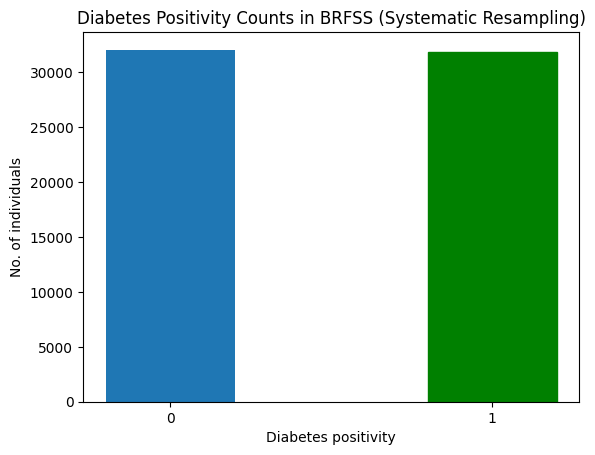

In [ ]:
barlist = plt.bar([str(0),str(1)], y_S_Sy.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (Systematic Resampling)")
plt.show()

In [ ]:
model_source_Sy_ROS = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_557"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3899 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3900 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3901 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3902 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3903 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3904 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3905 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.8088 - loss: 0.5160 - val_AUC: 0.8999 - val_loss: 0.4062
Epoch 2/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9033 - loss: 0.3893 - val_AUC: 0.9132 - val_loss: 0.3688
Epoch 3/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9132 - loss: 0.3684 - val_AUC: 0.9162 - val_loss: 0.3684
Epoch 4/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9185 - loss: 0.3542 - val_AUC: 0.9238 - val_loss: 0.3443
Epoch 5/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9227 - loss: 0.3439 - val_AUC: 0.9270 - val_loss: 0.3418
Epoch 6/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.9267 - loss: 0.3332 - val_AUC: 0.9287 - val_loss: 0.3306
Epoch 7/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9297 - loss: 0.3253 - val_AUC: 0.9313 - val_loss: 0.3225
Epoch 8/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9290 - loss: 0.3257 - val_AUC: 0.9328 - val_loss: 0.3164
Epoch 9/10
1279/1279 ━━━━━━━━━━━━━━━━━━━

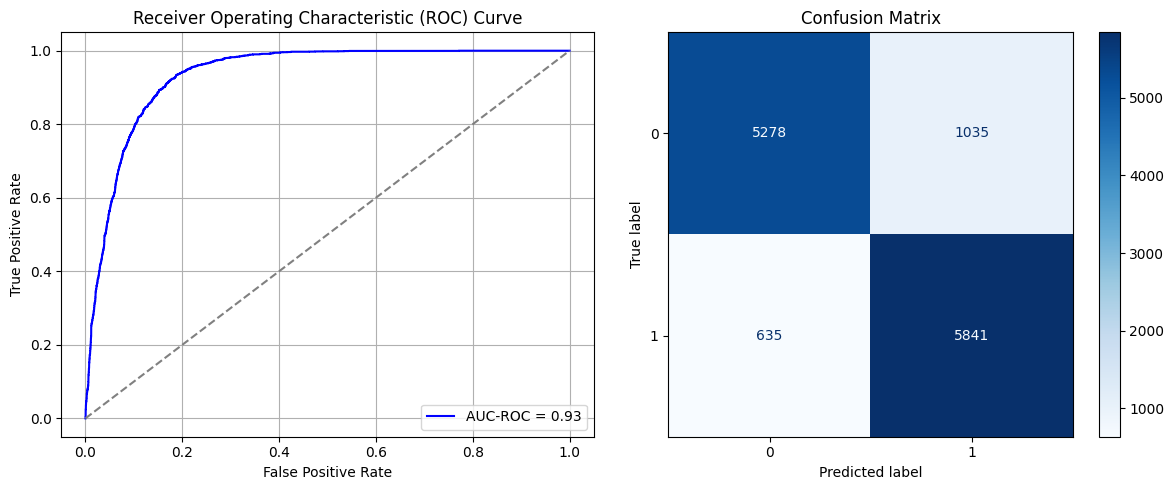

Best threshold based on F1-score: 0.3999898433685303
Time elapsed (performance): 58.55144220799957


<Sequential name=sequential_557, built=True>

In [ ]:
train_and_evaluate(model_source_Sy_ROS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC-ROC: 0.7024127789508052
Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.32      0.47      1293
         1.0       0.23      0.91      0.37       289

    accuracy                           0.42      1582
   macro avg       0.59      0.61      0.42      1582
weighted avg       0.81      0.42      0.45      1582

FPR 0.6844547563805105 TPR: 0.9134948096885813 FNR: 0.08650519031141868 TNR: 0.31554524361948955


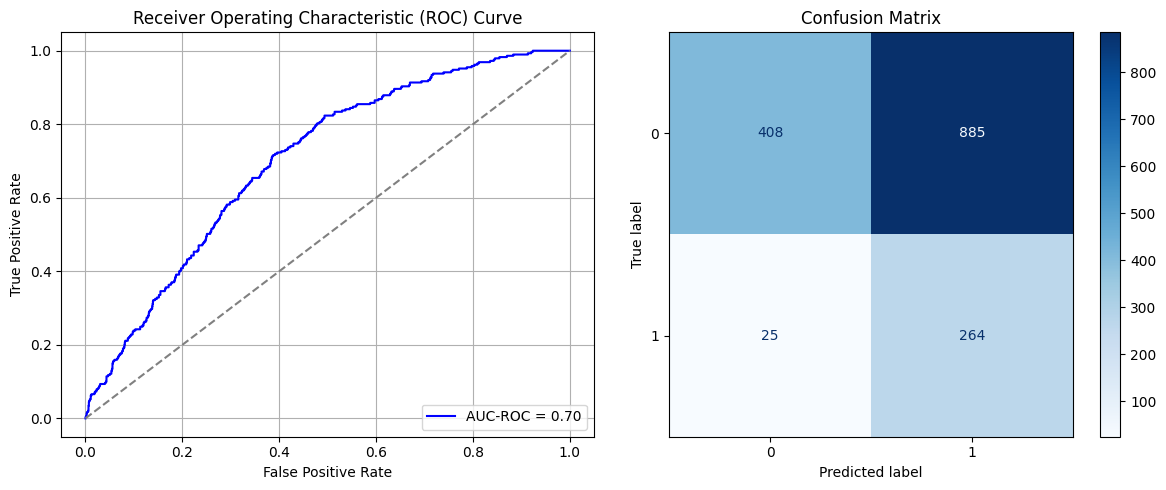

Best threshold based on F1-score: 0.8233553767204285
False Negative Rate: 0.08650519031141868
Time elapsed (performance): 0.6381364690005285


In [ ]:
Transductive_TL(model_source_Sy_ROS, X_T_test, y_T_test, "Target")

In [ ]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_558"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3906 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3907 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3908 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3909 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3910 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3911 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3912 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6509 - loss: 0.7261 - val_AUC: 0.6719 - val_loss: 0.4520
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6951 - loss: 0.4303 - val_AUC: 0.6779 - val_loss: 0.4410
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6989 - loss: 0.4268 - val_AUC: 0.6813 - val_loss: 0.4385
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7186 - loss: 0.4250 - val_AUC: 0.6835 - val_loss: 0.4372
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7219 - loss: 0.4199 - val_AUC: 0.6846 - val_loss: 0.4376
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7262 - loss: 0.4219 - val_AUC: 0.6865 - val_loss: 0.4359
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7259 - loss: 0.4279 - val_AUC: 0.6893 - val_loss: 0.4348
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7262 - loss: 0.4329 - val_AUC: 0.6899 - val_loss: 0.4355
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7081 -

(np.float64(0.0030935808197989174), np.float64(0.9757785467128027))

In [ ]:
fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_559"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3913 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3914 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3915 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3916 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3917 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3918 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3919 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6793 - loss: 0.6989 - val_AUC: 0.0000e+00 - val_loss: 0.9989
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6893 - loss: 0.6114 - val_AUC: 0.0000e+00 - val_loss: 0.9167
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7111 - loss: 0.5930 - val_AUC: 0.0000e+00 - val_loss: 0.9148
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7116 - loss: 0.5932 - val_AUC: 0.0000e+00 - val_loss: 0.8428
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7186 - loss: 0.5875 - val_AUC: 0.0000e+00 - val_loss: 0.8032
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7201 - loss: 0.5869 - val_AUC: 0.0000e+00 - val_loss: 0.9118
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7299 - loss: 0.5854 - val_AUC: 0.0000e+00 - val_loss: 0.9127
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7351 - loss: 0.5757 - val_AUC: 0.0000e+00 - val_loss: 0.8133
Epoch 9/10
258/258 ━━━━━━━━━━━━━━━━

(np.float64(0.18948182521268367), np.float64(0.4913494809688581))

In [ ]:
times = 50

FPR = []
FNR = []

for i in range(times):
    fpr, fnr = fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 4)
    # print(output)
    FPR.append(fpr)
    FNR.append(fnr)

ParamFit = pd.DataFrame([FPR, FNR]).T
ParamFit.columns=['FPR', 'FNR']

# fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_562"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3934 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3935 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3936 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3937 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3938 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3939 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3940 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - AUC: 0.6651 - loss: 0.7113 - val_AUC: 0.0000e+00 - val_loss: 0.8611
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6910 - loss: 0.6086 - val_AUC: 0.0000e+00 - val_loss: 0.7996
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6992 - loss: 0.5988 - val_AUC: 0.0000e+00 - val_loss: 0.8869
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7110 - loss: 0.5967 - val_AUC: 0.0000e+00 - val_loss: 0.8876
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7251 - loss: 0.5854 - val_AUC: 0.0000e+00 - val_loss: 0.8508
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7209 - loss: 0.5895 - val_AUC: 0.0000e+00 - val_loss: 1.0043
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7256 - loss: 0.5805 - val_AUC: 0.0000e+00 - val_loss: 0.8126
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - A

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_563"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3941 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3942 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3943 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3944 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3945 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3946 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3947 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6656 - loss: 0.7153 - val_AUC: 0.0000e+00 - val_loss: 0.9438
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6946 - loss: 0.6069 - val_AUC: 0.0000e+00 - val_loss: 0.9094
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7049 - loss: 0.5988 - val_AUC: 0.0000e+00 - val_loss: 0.8649
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7079 - loss: 0.5948 - val_AUC: 0.0000e+00 - val_loss: 0.9021
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7138 - loss: 0.5953 - val_AUC: 0.0000e+00 - val_loss: 0.9252
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7211 - loss: 0.5871 - val_AUC: 0.0000e+00 - val_loss: 0.7966
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7239 - loss: 0.5840 - val_AUC: 0.0000e+00 - val_loss: 0.8063
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7342 - loss: 0.5746 - val_AUC: 0.0000e+00 - val_loss: 0.9144
Epoch 9/10
258/258 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_564"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3948 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3949 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3950 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3951 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3952 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3953 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3954 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6634 - loss: 0.7182 - val_AUC: 0.0000e+00 - val_loss: 0.9182
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7020 - loss: 0.6045 - val_AUC: 0.0000e+00 - val_loss: 0.8997
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7080 - loss: 0.5949 - val_AUC: 0.0000e+00 - val_loss: 0.8208
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7095 - loss: 0.5929 - val_AUC: 0.0000e+00 - val_loss: 0.8701
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7246 - loss: 0.5842 - val_AUC: 0.0000e+00 - val_loss: 0.8315
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7160 - loss: 0.5912 - val_AUC: 0.0000e+00 - val_loss: 0.8865
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7262 - loss: 0.5830 - val_AUC: 0.0000e+00 - val_loss: 0.9160
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7346 - loss: 0.5751 - val_AUC: 0.0000e+00 - val_loss: 0.8354
Epoch 9/10
258/258 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_565"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3955 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3956 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3957 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3958 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3959 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3960 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3961 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6718 - loss: 0.7183 - val_AUC: 0.0000e+00 - val_loss: 0.8897
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6985 - loss: 0.6051 - val_AUC: 0.0000e+00 - val_loss: 0.9553
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7148 - loss: 0.5939 - val_AUC: 0.0000e+00 - val_loss: 0.8292
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7123 - loss: 0.5877 - val_AUC: 0.0000e+00 - val_loss: 0.8543
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7201 - loss: 0.5902 - val_AUC: 0.0000e+00 - val_loss: 0.9077
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7178 - loss: 0.5904 - val_AUC: 0.0000e+00 - val_loss: 0.8445
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7233 - loss: 0.5854 - val_AUC: 0.0000e+00 - val_loss: 0.9161
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7278 - loss: 0.5809 - val_AUC: 0.0000e+00 - val_loss: 0.8847
Epoch 9/10
258/258 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_566"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3962 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3963 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3964 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3965 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3966 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3967 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3968 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6764 - loss: 0.6977 - val_AUC: 0.0000e+00 - val_loss: 0.8871
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7020 - loss: 0.6000 - val_AUC: 0.0000e+00 - val_loss: 0.8470
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7024 - loss: 0.5979 - val_AUC: 0.0000e+00 - val_loss: 0.8908
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7113 - loss: 0.5968 - val_AUC: 0.0000e+00 - val_loss: 0.9219
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7170 - loss: 0.5873 - val_AUC: 0.0000e+00 - val_loss: 0.8690
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7300 - loss: 0.5786 - val_AUC: 0.0000e+00 - val_loss: 0.8181
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7190 - loss: 0.5887 - val_AUC: 0.0000e+00 - val_loss: 0.9136
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7339 - loss: 0.5758 - val_AUC: 0.0000e+00 - val_loss: 0.9287
Epoch 9/10
258/258 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_567"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3969 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3970 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3971 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3972 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3973 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3974 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3975 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6747 - loss: 0.7075 - val_AUC: 0.0000e+00 - val_loss: 0.8681
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7066 - loss: 0.5980 - val_AUC: 0.0000e+00 - val_loss: 0.8234
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7100 - loss: 0.5961 - val_AUC: 0.0000e+00 - val_loss: 0.8660
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7167 - loss: 0.5881 - val_AUC: 0.0000e+00 - val_loss: 0.9399
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7126 - loss: 0.5922 - val_AUC: 0.0000e+00 - val_loss: 0.8506
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7272 - loss: 0.5802 - val_AUC: 0.0000e+00 - val_loss: 0.9017
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7275 - loss: 0.5855 - val_AUC: 0.0000e+00 - val_loss: 0.8637
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7409 - loss: 0.5749 - val_AUC: 0.0000e+00 - val_loss: 0.8665
Epoch 9/10
258/258 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_568"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3976 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3977 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3978 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3979 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3980 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3981 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3982 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6766 - loss: 0.6991 - val_AUC: 0.0000e+00 - val_loss: 0.8710
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7006 - loss: 0.6019 - val_AUC: 0.0000e+00 - val_loss: 0.8387
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7097 - loss: 0.5953 - val_AUC: 0.0000e+00 - val_loss: 0.8603
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7202 - loss: 0.5887 - val_AUC: 0.0000e+00 - val_loss: 0.8157
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7072 - loss: 0.5944 - val_AUC: 0.0000e+00 - val_loss: 0.8791
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7279 - loss: 0.5812 - val_AUC: 0.0000e+00 - val_loss: 0.7875
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7219 - loss: 0.5863 - val_AUC: 0.0000e+00 - val_loss: 0.7900
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7270 - loss: 0.5827 - val_AUC: 0.0000e+00 - val_loss: 0.8019
Epoch 9/10
258/258 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_569"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3983 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3984 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3985 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3986 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3987 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3988 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3989 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6605 - loss: 0.7208 - val_AUC: 0.0000e+00 - val_loss: 0.8358
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6958 - loss: 0.6020 - val_AUC: 0.0000e+00 - val_loss: 0.8597
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7088 - loss: 0.5971 - val_AUC: 0.0000e+00 - val_loss: 0.8297
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7122 - loss: 0.5933 - val_AUC: 0.0000e+00 - val_loss: 0.8319
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7108 - loss: 0.5938 - val_AUC: 0.0000e+00 - val_loss: 0.9102
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7127 - loss: 0.5907 - val_AUC: 0.0000e+00 - val_loss: 0.8177
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7260 - loss: 0.5832 - val_AUC: 0.0000e+00 - val_loss: 0.8783
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7261 - loss: 0.5801 - val_AUC: 0.0000e+00 - val_loss: 0.8738
Epoch 9/10
258/258 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_570"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3990 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3991 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3992 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3993 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3994 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3995 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3996 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6620 - loss: 0.7253 - val_AUC: 0.0000e+00 - val_loss: 0.9444
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6968 - loss: 0.6054 - val_AUC: 0.0000e+00 - val_loss: 0.8938
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7093 - loss: 0.5952 - val_AUC: 0.0000e+00 - val_loss: 0.8726
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - AUC: 0.7109 - loss: 0.5918 - val_AUC: 0.0000e+00 - val_loss: 0.7922
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7091 - loss: 0.5968 - val_AUC: 0.0000e+00 - val_loss: 0.9500
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7200 - loss: 0.5885 - val_AUC: 0.0000e+00 - val_loss: 0.8436
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7233 - loss: 0.5820 - val_AUC: 0.0000e+00 - val_loss: 0.8212
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7234 - loss: 0.5857 - val_AUC: 0.0000e+00 - val_loss: 0.8530
Epoch 9/10
258/258 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_571"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3997 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3998 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3999 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4000 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4001 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4002 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4003 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6537 - loss: 0.7318 - val_AUC: 0.0000e+00 - val_loss: 0.9549
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7079 - loss: 0.5974 - val_AUC: 0.0000e+00 - val_loss: 0.8472
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6976 - loss: 0.5989 - val_AUC: 0.0000e+00 - val_loss: 0.8419
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7140 - loss: 0.5925 - val_AUC: 0.0000e+00 - val_loss: 0.9118
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7224 - loss: 0.5875 - val_AUC: 0.0000e+00 - val_loss: 0.9093
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7219 - loss: 0.5918 - val_AUC: 0.0000e+00 - val_loss: 0.9012
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7288 - loss: 0.5822 - val_AUC: 0.0000e+00 - val_loss: 0.8179
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7211 - loss: 0.5863 - val_AUC: 0.0000e+00 - val_loss: 0.8336
Epoch 9/10
258/258 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_572"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4004 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4005 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4006 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4007 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4008 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4009 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4010 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6749 - loss: 0.7049 - val_AUC: 0.0000e+00 - val_loss: 0.8656
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6969 - loss: 0.6046 - val_AUC: 0.0000e+00 - val_loss: 0.8382
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6991 - loss: 0.6019 - val_AUC: 0.0000e+00 - val_loss: 0.8705
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7175 - loss: 0.5828 - val_AUC: 0.0000e+00 - val_loss: 0.8254
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7120 - loss: 0.5937 - val_AUC: 0.0000e+00 - val_loss: 0.8113
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7166 - loss: 0.5920 - val_AUC: 0.0000e+00 - val_loss: 0.9046
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7152 - loss: 0.5869 - val_AUC: 0.0000e+00 - val_loss: 0.8115
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7299 - loss: 0.5836 - val_AUC: 0.0000e+00 - val_loss: 0.8857
Epoch 9/10
258/258 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_573"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4011 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4012 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4013 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4014 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4015 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4016 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4017 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6591 - loss: 0.7184 - val_AUC: 0.0000e+00 - val_loss: 0.8227
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7014 - loss: 0.6003 - val_AUC: 0.0000e+00 - val_loss: 0.9274
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7086 - loss: 0.5957 - val_AUC: 0.0000e+00 - val_loss: 0.8916
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7130 - loss: 0.5921 - val_AUC: 0.0000e+00 - val_loss: 0.8715
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7159 - loss: 0.5875 - val_AUC: 0.0000e+00 - val_loss: 0.8976
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7264 - loss: 0.5815 - val_AUC: 0.0000e+00 - val_loss: 0.7630
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7107 - loss: 0.5913 - val_AUC: 0.0000e+00 - val_loss: 0.8554
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7232 - loss: 0.5835 - val_AUC: 0.0000e+00 - val_loss: 0.9225
Epoch 9/10
258/258 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_574"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4018 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4019 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4020 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4021 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4022 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4023 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4024 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6695 - loss: 0.7149 - val_AUC: 0.0000e+00 - val_loss: 0.9566
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7039 - loss: 0.5967 - val_AUC: 0.0000e+00 - val_loss: 0.8431
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7022 - loss: 0.5984 - val_AUC: 0.0000e+00 - val_loss: 0.8836
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7127 - loss: 0.5910 - val_AUC: 0.0000e+00 - val_loss: 0.7988
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7141 - loss: 0.5918 - val_AUC: 0.0000e+00 - val_loss: 0.9193
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7215 - loss: 0.5861 - val_AUC: 0.0000e+00 - val_loss: 0.8537
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7182 - loss: 0.5878 - val_AUC: 0.0000e+00 - val_loss: 0.8845
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7297 - loss: 0.5813 - val_AUC: 0.0000e+00 - val_loss: 0.9516
Epoch 9/10
258/258 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_575"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4025 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4026 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4027 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4028 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4029 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4030 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4031 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6790 - loss: 0.6923 - val_AUC: 0.0000e+00 - val_loss: 0.8909
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6996 - loss: 0.6038 - val_AUC: 0.0000e+00 - val_loss: 0.9046
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7067 - loss: 0.5988 - val_AUC: 0.0000e+00 - val_loss: 0.9064
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7108 - loss: 0.5976 - val_AUC: 0.0000e+00 - val_loss: 0.8920
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7216 - loss: 0.5881 - val_AUC: 0.0000e+00 - val_loss: 0.9103
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7240 - loss: 0.5829 - val_AUC: 0.0000e+00 - val_loss: 0.7970
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7159 - loss: 0.5919 - val_AUC: 0.0000e+00 - val_loss: 0.8451
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7314 - loss: 0.5764 - val_AUC: 0.0000e+00 - val_loss: 0.8090
Epoch 9/10
258/258 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_576"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4032 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4033 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4034 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4035 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4036 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4037 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4038 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6562 - loss: 0.7329 - val_AUC: 0.0000e+00 - val_loss: 0.8924
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6925 - loss: 0.6018 - val_AUC: 0.0000e+00 - val_loss: 0.8239
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7152 - loss: 0.5888 - val_AUC: 0.0000e+00 - val_loss: 0.8756
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7109 - loss: 0.5953 - val_AUC: 0.0000e+00 - val_loss: 0.8680
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7161 - loss: 0.5894 - val_AUC: 0.0000e+00 - val_loss: 0.8323
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7154 - loss: 0.5888 - val_AUC: 0.0000e+00 - val_loss: 0.9714
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7196 - loss: 0.5858 - val_AUC: 0.0000e+00 - val_loss: 0.8031
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7279 - loss: 0.5828 - val_AUC: 0.0000e+00 - val_loss: 0.8093
Epoch 9/10
258/258 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_577"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4039 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4040 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4041 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4042 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4043 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4044 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4045 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - AUC: 0.6677 - loss: 0.7122 - val_AUC: 0.0000e+00 - val_loss: 0.9713
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6908 - loss: 0.6124 - val_AUC: 0.0000e+00 - val_loss: 0.8917
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6994 - loss: 0.5962 - val_AUC: 0.0000e+00 - val_loss: 0.8034
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7116 - loss: 0.5940 - val_AUC: 0.0000e+00 - val_loss: 0.8805
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7163 - loss: 0.5837 - val_AUC: 0.0000e+00 - val_loss: 0.8103
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7263 - loss: 0.5831 - val_AUC: 0.0000e+00 - val_loss: 0.8259
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7265 - loss: 0.5855 - val_AUC: 0.0000e+00 - val_loss: 0.9338
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7258 - loss: 0.5877 - val_AUC: 0.0000e+00 - val_loss: 0.8284
Epoch 9/10
258/258 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_578"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4046 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4047 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4048 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4049 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4050 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4051 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4052 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6650 - loss: 0.7166 - val_AUC: 0.0000e+00 - val_loss: 0.9946
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6920 - loss: 0.6066 - val_AUC: 0.0000e+00 - val_loss: 0.8678
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7072 - loss: 0.5943 - val_AUC: 0.0000e+00 - val_loss: 0.8635
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7115 - loss: 0.5910 - val_AUC: 0.0000e+00 - val_loss: 0.8515
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7204 - loss: 0.5864 - val_AUC: 0.0000e+00 - val_loss: 0.8621
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7169 - loss: 0.5912 - val_AUC: 0.0000e+00 - val_loss: 0.9789
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7313 - loss: 0.5785 - val_AUC: 0.0000e+00 - val_loss: 0.8557
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7274 - loss: 0.5804 - val_AUC: 0.0000e+00 - val_loss: 0.7328
Epoch 9/10
258/258 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_579"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4053 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4054 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4055 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4056 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4057 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4058 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4059 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6679 - loss: 0.7111 - val_AUC: 0.0000e+00 - val_loss: 0.8661
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7004 - loss: 0.6029 - val_AUC: 0.0000e+00 - val_loss: 0.9129
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7079 - loss: 0.5947 - val_AUC: 0.0000e+00 - val_loss: 0.8742
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7156 - loss: 0.5943 - val_AUC: 0.0000e+00 - val_loss: 0.9533
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7115 - loss: 0.5951 - val_AUC: 0.0000e+00 - val_loss: 0.9743
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7034 - loss: 0.5974 - val_AUC: 0.0000e+00 - val_loss: 0.8395
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7268 - loss: 0.5831 - val_AUC: 0.0000e+00 - val_loss: 0.7753
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7346 - loss: 0.5758 - val_AUC: 0.0000e+00 - val_loss: 0.9317
Epoch 9/10
258/258 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_580"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4060 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4061 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4062 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4063 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4064 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4065 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4066 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6521 - loss: 0.7346 - val_AUC: 0.0000e+00 - val_loss: 0.8643
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6996 - loss: 0.5995 - val_AUC: 0.0000e+00 - val_loss: 0.8416
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7053 - loss: 0.5996 - val_AUC: 0.0000e+00 - val_loss: 0.9515
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7071 - loss: 0.5967 - val_AUC: 0.0000e+00 - val_loss: 0.9009
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7216 - loss: 0.5860 - val_AUC: 0.0000e+00 - val_loss: 0.8575
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7244 - loss: 0.5853 - val_AUC: 0.0000e+00 - val_loss: 0.8332
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7232 - loss: 0.5841 - val_AUC: 0.0000e+00 - val_loss: 0.7858
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7163 - loss: 0.5905 - val_AUC: 0.0000e+00 - val_loss: 0.8029
Epoch 9/10
258/258 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_581"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4067 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4068 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4069 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4070 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4071 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4072 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4073 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6694 - loss: 0.7109 - val_AUC: 0.0000e+00 - val_loss: 0.8659
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7069 - loss: 0.6009 - val_AUC: 0.0000e+00 - val_loss: 0.8547
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6988 - loss: 0.5973 - val_AUC: 0.0000e+00 - val_loss: 0.9370
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7151 - loss: 0.5913 - val_AUC: 0.0000e+00 - val_loss: 0.8404
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7200 - loss: 0.5856 - val_AUC: 0.0000e+00 - val_loss: 0.8630
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7256 - loss: 0.5844 - val_AUC: 0.0000e+00 - val_loss: 0.7729
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7234 - loss: 0.5863 - val_AUC: 0.0000e+00 - val_loss: 0.8460
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7212 - loss: 0.5846 - val_AUC: 0.0000e+00 - val_loss: 0.8459
Epoch 9/10
258/258 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_582"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4074 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4075 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4076 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4077 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4078 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4079 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4080 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6572 - loss: 0.7275 - val_AUC: 0.0000e+00 - val_loss: 0.9226
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7140 - loss: 0.5946 - val_AUC: 0.0000e+00 - val_loss: 0.8482
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7153 - loss: 0.5953 - val_AUC: 0.0000e+00 - val_loss: 0.9349
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7116 - loss: 0.5930 - val_AUC: 0.0000e+00 - val_loss: 0.9203
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7159 - loss: 0.5879 - val_AUC: 0.0000e+00 - val_loss: 0.8429
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7193 - loss: 0.5869 - val_AUC: 0.0000e+00 - val_loss: 0.8484
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7191 - loss: 0.5862 - val_AUC: 0.0000e+00 - val_loss: 0.7867
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7247 - loss: 0.5853 - val_AUC: 0.0000e+00 - val_loss: 0.8445
Epoch 9/10
258/258 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_583"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4081 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4082 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4083 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4084 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4085 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4086 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4087 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6699 - loss: 0.7090 - val_AUC: 0.0000e+00 - val_loss: 0.8491
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6939 - loss: 0.6041 - val_AUC: 0.0000e+00 - val_loss: 0.8281
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7072 - loss: 0.5978 - val_AUC: 0.0000e+00 - val_loss: 0.7906
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7081 - loss: 0.5987 - val_AUC: 0.0000e+00 - val_loss: 0.8463
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7174 - loss: 0.5849 - val_AUC: 0.0000e+00 - val_loss: 0.8616
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7263 - loss: 0.5856 - val_AUC: 0.0000e+00 - val_loss: 0.8586
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7319 - loss: 0.5769 - val_AUC: 0.0000e+00 - val_loss: 0.9645
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7333 - loss: 0.5755 - val_AUC: 0.0000e+00 - val_loss: 0.8440
Epoch 9/10
258/258 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_584"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4088 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4089 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4090 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4091 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4092 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4093 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4094 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6514 - loss: 0.7295 - val_AUC: 0.0000e+00 - val_loss: 0.8715
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7026 - loss: 0.6014 - val_AUC: 0.0000e+00 - val_loss: 0.8141
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6984 - loss: 0.6025 - val_AUC: 0.0000e+00 - val_loss: 0.8921
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7149 - loss: 0.5848 - val_AUC: 0.0000e+00 - val_loss: 0.7837
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7203 - loss: 0.5921 - val_AUC: 0.0000e+00 - val_loss: 0.9650
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7155 - loss: 0.5939 - val_AUC: 0.0000e+00 - val_loss: 0.8647
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7164 - loss: 0.5860 - val_AUC: 0.0000e+00 - val_loss: 0.8325
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7298 - loss: 0.5814 - val_AUC: 0.0000e+00 - val_loss: 0.9293
Epoch 9/10
258/258 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_585"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4095 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4096 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4097 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4098 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4099 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4100 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4101 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6763 - loss: 0.6960 - val_AUC: 0.0000e+00 - val_loss: 0.8908
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7018 - loss: 0.5954 - val_AUC: 0.0000e+00 - val_loss: 0.8207
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7070 - loss: 0.5986 - val_AUC: 0.0000e+00 - val_loss: 0.8265
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7175 - loss: 0.5890 - val_AUC: 0.0000e+00 - val_loss: 0.8279
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7186 - loss: 0.5902 - val_AUC: 0.0000e+00 - val_loss: 0.8097
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7207 - loss: 0.5884 - val_AUC: 0.0000e+00 - val_loss: 0.8813
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7271 - loss: 0.5818 - val_AUC: 0.0000e+00 - val_loss: 0.8994
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7369 - loss: 0.5771 - val_AUC: 0.0000e+00 - val_loss: 0.8297
Epoch 9/10
258/258 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_586"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4102 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4103 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4104 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4105 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4106 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4107 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4108 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6709 - loss: 0.7116 - val_AUC: 0.0000e+00 - val_loss: 0.8782
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6980 - loss: 0.6035 - val_AUC: 0.0000e+00 - val_loss: 0.9069
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7009 - loss: 0.5977 - val_AUC: 0.0000e+00 - val_loss: 0.9172
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7175 - loss: 0.5927 - val_AUC: 0.0000e+00 - val_loss: 0.9163
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7190 - loss: 0.5863 - val_AUC: 0.0000e+00 - val_loss: 0.8800
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7139 - loss: 0.5959 - val_AUC: 0.0000e+00 - val_loss: 0.9203
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7125 - loss: 0.5927 - val_AUC: 0.0000e+00 - val_loss: 0.7975
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7255 - loss: 0.5825 - val_AUC: 0.0000e+00 - val_loss: 0.8706
Epoch 9/10
258/258 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_587"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4109 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4110 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4111 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4112 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4113 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4114 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4115 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6686 - loss: 0.7103 - val_AUC: 0.0000e+00 - val_loss: 0.8464
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6963 - loss: 0.6033 - val_AUC: 0.0000e+00 - val_loss: 0.7999
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7064 - loss: 0.5991 - val_AUC: 0.0000e+00 - val_loss: 0.9011
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7143 - loss: 0.5918 - val_AUC: 0.0000e+00 - val_loss: 0.8593
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7136 - loss: 0.5904 - val_AUC: 0.0000e+00 - val_loss: 0.9098
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7167 - loss: 0.5912 - val_AUC: 0.0000e+00 - val_loss: 0.9153
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7115 - loss: 0.5892 - val_AUC: 0.0000e+00 - val_loss: 0.8242
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7260 - loss: 0.5836 - val_AUC: 0.0000e+00 - val_loss: 0.8501
Epoch 9/10
258/258 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_588"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4116 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4117 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4118 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4119 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4120 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4121 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4122 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6694 - loss: 0.7109 - val_AUC: 0.0000e+00 - val_loss: 0.9175
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7013 - loss: 0.6011 - val_AUC: 0.0000e+00 - val_loss: 0.8433
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7168 - loss: 0.5913 - val_AUC: 0.0000e+00 - val_loss: 0.9345
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7075 - loss: 0.5962 - val_AUC: 0.0000e+00 - val_loss: 0.8011
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7155 - loss: 0.5927 - val_AUC: 0.0000e+00 - val_loss: 0.8877
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7123 - loss: 0.5940 - val_AUC: 0.0000e+00 - val_loss: 0.8548
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7223 - loss: 0.5841 - val_AUC: 0.0000e+00 - val_loss: 0.8761
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7289 - loss: 0.5813 - val_AUC: 0.0000e+00 - val_loss: 0.8574
Epoch 9/10
258/258 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_589"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4123 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4124 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4125 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4126 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4127 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4128 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4129 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6751 - loss: 0.7096 - val_AUC: 0.0000e+00 - val_loss: 0.9204
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7008 - loss: 0.5959 - val_AUC: 0.0000e+00 - val_loss: 0.8314
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7067 - loss: 0.5993 - val_AUC: 0.0000e+00 - val_loss: 0.8812
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7106 - loss: 0.5952 - val_AUC: 0.0000e+00 - val_loss: 0.8738
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7195 - loss: 0.5893 - val_AUC: 0.0000e+00 - val_loss: 0.9108
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7104 - loss: 0.5969 - val_AUC: 0.0000e+00 - val_loss: 0.8969
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7216 - loss: 0.5847 - val_AUC: 0.0000e+00 - val_loss: 0.8147
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7243 - loss: 0.5845 - val_AUC: 0.0000e+00 - val_loss: 0.8616
Epoch 9/10
258/258 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_590"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4130 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4131 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4132 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4133 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4134 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4135 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4136 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6795 - loss: 0.6963 - val_AUC: 0.0000e+00 - val_loss: 0.8350
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7059 - loss: 0.5933 - val_AUC: 0.0000e+00 - val_loss: 0.8566
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7061 - loss: 0.5967 - val_AUC: 0.0000e+00 - val_loss: 0.8668
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7075 - loss: 0.5970 - val_AUC: 0.0000e+00 - val_loss: 0.8392
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7196 - loss: 0.5911 - val_AUC: 0.0000e+00 - val_loss: 0.9232
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7176 - loss: 0.5929 - val_AUC: 0.0000e+00 - val_loss: 0.9402
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7244 - loss: 0.5871 - val_AUC: 0.0000e+00 - val_loss: 0.9820
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7189 - loss: 0.5930 - val_AUC: 0.0000e+00 - val_loss: 0.8666
Epoch 9/10
258/258 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_591"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4137 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4138 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4139 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4140 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4141 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4142 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4143 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6604 - loss: 0.7248 - val_AUC: 0.0000e+00 - val_loss: 0.8860
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7063 - loss: 0.5930 - val_AUC: 0.0000e+00 - val_loss: 0.8513
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7067 - loss: 0.5963 - val_AUC: 0.0000e+00 - val_loss: 0.9063
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7200 - loss: 0.5904 - val_AUC: 0.0000e+00 - val_loss: 0.9041
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7136 - loss: 0.5916 - val_AUC: 0.0000e+00 - val_loss: 0.8153
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7192 - loss: 0.5909 - val_AUC: 0.0000e+00 - val_loss: 0.8604
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7207 - loss: 0.5898 - val_AUC: 0.0000e+00 - val_loss: 0.9602
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7326 - loss: 0.5794 - val_AUC: 0.0000e+00 - val_loss: 0.8123
Epoch 9/10
258/258 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_592"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4144 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4145 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4146 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4147 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4148 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4149 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4150 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6670 - loss: 0.7166 - val_AUC: 0.0000e+00 - val_loss: 0.8981
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7028 - loss: 0.5942 - val_AUC: 0.0000e+00 - val_loss: 0.7641
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7079 - loss: 0.5927 - val_AUC: 0.0000e+00 - val_loss: 0.8481
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7094 - loss: 0.5921 - val_AUC: 0.0000e+00 - val_loss: 0.8173
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7173 - loss: 0.5905 - val_AUC: 0.0000e+00 - val_loss: 0.8675
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7197 - loss: 0.5874 - val_AUC: 0.0000e+00 - val_loss: 0.9219
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7277 - loss: 0.5820 - val_AUC: 0.0000e+00 - val_loss: 0.8191
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7373 - loss: 0.5721 - val_AUC: 0.0000e+00 - val_loss: 0.7795
Epoch 9/10
258/258 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_593"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4151 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4152 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4153 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4154 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4155 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4156 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4157 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - AUC: 0.6597 - loss: 0.7179 - val_AUC: 0.0000e+00 - val_loss: 0.9047
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7054 - loss: 0.6007 - val_AUC: 0.0000e+00 - val_loss: 0.9005
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7050 - loss: 0.5976 - val_AUC: 0.0000e+00 - val_loss: 0.8750
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7200 - loss: 0.5867 - val_AUC: 0.0000e+00 - val_loss: 0.8630
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7097 - loss: 0.5952 - val_AUC: 0.0000e+00 - val_loss: 0.8516
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7178 - loss: 0.5931 - val_AUC: 0.0000e+00 - val_loss: 0.8674
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7189 - loss: 0.5859 - val_AUC: 0.0000e+00 - val_loss: 0.7805
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7298 - loss: 0.5761 - val_AUC: 0.0000e+00 - val_loss: 0.7952
Epoch 9/10
258/258 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_594"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4158 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4159 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4160 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4161 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4162 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4163 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4164 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6633 - loss: 0.7154 - val_AUC: 0.0000e+00 - val_loss: 0.8900
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7084 - loss: 0.5987 - val_AUC: 0.0000e+00 - val_loss: 0.8542
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7060 - loss: 0.5951 - val_AUC: 0.0000e+00 - val_loss: 0.8622
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7103 - loss: 0.5915 - val_AUC: 0.0000e+00 - val_loss: 0.8290
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7157 - loss: 0.5906 - val_AUC: 0.0000e+00 - val_loss: 0.8597
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7299 - loss: 0.5775 - val_AUC: 0.0000e+00 - val_loss: 0.8614
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7211 - loss: 0.5840 - val_AUC: 0.0000e+00 - val_loss: 0.8142
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7203 - loss: 0.5829 - val_AUC: 0.0000e+00 - val_loss: 0.7455
Epoch 9/10
258/258 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_595"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4165 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4166 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4167 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4168 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4169 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4170 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4171 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6680 - loss: 0.7069 - val_AUC: 0.0000e+00 - val_loss: 0.8687
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6953 - loss: 0.6040 - val_AUC: 0.0000e+00 - val_loss: 0.8925
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7025 - loss: 0.6010 - val_AUC: 0.0000e+00 - val_loss: 0.8866
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7150 - loss: 0.5910 - val_AUC: 0.0000e+00 - val_loss: 0.8142
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7252 - loss: 0.5859 - val_AUC: 0.0000e+00 - val_loss: 0.8804
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7302 - loss: 0.5810 - val_AUC: 0.0000e+00 - val_loss: 0.8751
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7206 - loss: 0.5814 - val_AUC: 0.0000e+00 - val_loss: 0.7752
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7209 - loss: 0.5858 - val_AUC: 0.0000e+00 - val_loss: 0.8196
Epoch 9/10
258/258 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_596"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4172 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4173 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4174 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4175 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4176 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4177 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4178 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6714 - loss: 0.7016 - val_AUC: 0.0000e+00 - val_loss: 0.8751
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7001 - loss: 0.6051 - val_AUC: 0.0000e+00 - val_loss: 0.8769
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7098 - loss: 0.5909 - val_AUC: 0.0000e+00 - val_loss: 0.8368
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7136 - loss: 0.5919 - val_AUC: 0.0000e+00 - val_loss: 0.8502
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7256 - loss: 0.5882 - val_AUC: 0.0000e+00 - val_loss: 0.8535
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7274 - loss: 0.5806 - val_AUC: 0.0000e+00 - val_loss: 0.8230
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7265 - loss: 0.5847 - val_AUC: 0.0000e+00 - val_loss: 0.8387
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7260 - loss: 0.5811 - val_AUC: 0.0000e+00 - val_loss: 0.8166
Epoch 9/10
258/258 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_597"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4179 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4180 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4181 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4182 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4183 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4184 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4185 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6635 - loss: 0.7186 - val_AUC: 0.0000e+00 - val_loss: 0.9212
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7085 - loss: 0.5980 - val_AUC: 0.0000e+00 - val_loss: 0.8492
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7132 - loss: 0.5950 - val_AUC: 0.0000e+00 - val_loss: 0.8735
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7045 - loss: 0.6002 - val_AUC: 0.0000e+00 - val_loss: 0.9265
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7220 - loss: 0.5879 - val_AUC: 0.0000e+00 - val_loss: 0.9894
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7210 - loss: 0.5869 - val_AUC: 0.0000e+00 - val_loss: 0.9135
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7309 - loss: 0.5765 - val_AUC: 0.0000e+00 - val_loss: 0.8701
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7346 - loss: 0.5811 - val_AUC: 0.0000e+00 - val_loss: 0.8303
Epoch 9/10
258/258 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_598"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4186 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4187 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4188 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4189 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4190 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4191 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4192 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6848 - loss: 0.6930 - val_AUC: 0.0000e+00 - val_loss: 0.8107
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7045 - loss: 0.5983 - val_AUC: 0.0000e+00 - val_loss: 0.8497
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7030 - loss: 0.5991 - val_AUC: 0.0000e+00 - val_loss: 0.8098
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7177 - loss: 0.5881 - val_AUC: 0.0000e+00 - val_loss: 0.8412
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7105 - loss: 0.5931 - val_AUC: 0.0000e+00 - val_loss: 0.8991
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7114 - loss: 0.5943 - val_AUC: 0.0000e+00 - val_loss: 0.9317
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7299 - loss: 0.5818 - val_AUC: 0.0000e+00 - val_loss: 0.9613
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7184 - loss: 0.5954 - val_AUC: 0.0000e+00 - val_loss: 0.8691
Epoch 9/10
258/258 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_599"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4193 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4194 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4195 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4196 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4197 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4198 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4199 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6630 - loss: 0.7237 - val_AUC: 0.0000e+00 - val_loss: 0.9285
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6995 - loss: 0.6027 - val_AUC: 0.0000e+00 - val_loss: 0.8975
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6905 - loss: 0.6010 - val_AUC: 0.0000e+00 - val_loss: 0.8482
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7162 - loss: 0.5929 - val_AUC: 0.0000e+00 - val_loss: 0.8509
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7191 - loss: 0.5893 - val_AUC: 0.0000e+00 - val_loss: 0.8237
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7245 - loss: 0.5855 - val_AUC: 0.0000e+00 - val_loss: 0.9095
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7196 - loss: 0.5864 - val_AUC: 0.0000e+00 - val_loss: 0.8930
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7287 - loss: 0.5829 - val_AUC: 0.0000e+00 - val_loss: 0.8762
Epoch 9/10
258/258 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_600"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4200 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4201 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4202 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4203 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4204 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4205 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4206 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6716 - loss: 0.7029 - val_AUC: 0.0000e+00 - val_loss: 0.8814
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7040 - loss: 0.6047 - val_AUC: 0.0000e+00 - val_loss: 0.9343
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7040 - loss: 0.6003 - val_AUC: 0.0000e+00 - val_loss: 0.8750
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7014 - loss: 0.5981 - val_AUC: 0.0000e+00 - val_loss: 0.8538
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7152 - loss: 0.5916 - val_AUC: 0.0000e+00 - val_loss: 0.8417
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7173 - loss: 0.5909 - val_AUC: 0.0000e+00 - val_loss: 0.9019
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7167 - loss: 0.5876 - val_AUC: 0.0000e+00 - val_loss: 0.8799
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7270 - loss: 0.5788 - val_AUC: 0.0000e+00 - val_loss: 0.8208
Epoch 9/10
258/258 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_601"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4207 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4208 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4209 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4210 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4211 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4212 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4213 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6657 - loss: 0.7059 - val_AUC: 0.0000e+00 - val_loss: 0.8461
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6964 - loss: 0.6038 - val_AUC: 0.0000e+00 - val_loss: 0.8975
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7081 - loss: 0.5979 - val_AUC: 0.0000e+00 - val_loss: 0.8827
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7163 - loss: 0.5955 - val_AUC: 0.0000e+00 - val_loss: 0.9026
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7246 - loss: 0.5848 - val_AUC: 0.0000e+00 - val_loss: 0.8778
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7284 - loss: 0.5845 - val_AUC: 0.0000e+00 - val_loss: 0.8309
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7220 - loss: 0.5869 - val_AUC: 0.0000e+00 - val_loss: 0.8491
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7138 - loss: 0.5921 - val_AUC: 0.0000e+00 - val_loss: 0.8081
Epoch 9/10
258/258 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_602"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4214 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4215 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4216 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4217 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4218 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4219 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4220 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6688 - loss: 0.7131 - val_AUC: 0.0000e+00 - val_loss: 0.8844
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7036 - loss: 0.6016 - val_AUC: 0.0000e+00 - val_loss: 0.9256
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7042 - loss: 0.5983 - val_AUC: 0.0000e+00 - val_loss: 0.8492
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7125 - loss: 0.5912 - val_AUC: 0.0000e+00 - val_loss: 0.8606
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7213 - loss: 0.5898 - val_AUC: 0.0000e+00 - val_loss: 0.8142
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7297 - loss: 0.5818 - val_AUC: 0.0000e+00 - val_loss: 0.8054
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7198 - loss: 0.5878 - val_AUC: 0.0000e+00 - val_loss: 0.8758
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7316 - loss: 0.5832 - val_AUC: 0.0000e+00 - val_loss: 0.8390
Epoch 9/10
258/258 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_603"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4221 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4222 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4223 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4224 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4225 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4226 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4227 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6593 - loss: 0.7238 - val_AUC: 0.0000e+00 - val_loss: 0.9114
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6998 - loss: 0.6027 - val_AUC: 0.0000e+00 - val_loss: 0.7580
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7068 - loss: 0.5925 - val_AUC: 0.0000e+00 - val_loss: 0.8315
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7150 - loss: 0.5930 - val_AUC: 0.0000e+00 - val_loss: 0.9050
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7181 - loss: 0.5924 - val_AUC: 0.0000e+00 - val_loss: 0.8828
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7199 - loss: 0.5897 - val_AUC: 0.0000e+00 - val_loss: 0.8288
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7251 - loss: 0.5863 - val_AUC: 0.0000e+00 - val_loss: 0.9592
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7264 - loss: 0.5811 - val_AUC: 0.0000e+00 - val_loss: 0.7698
Epoch 9/10
258/258 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_604"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4228 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4229 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4230 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4231 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4232 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4233 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4234 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6655 - loss: 0.7160 - val_AUC: 0.0000e+00 - val_loss: 0.9157
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7071 - loss: 0.5975 - val_AUC: 0.0000e+00 - val_loss: 0.9152
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7149 - loss: 0.5910 - val_AUC: 0.0000e+00 - val_loss: 0.8884
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7240 - loss: 0.5864 - val_AUC: 0.0000e+00 - val_loss: 0.9465
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7248 - loss: 0.5837 - val_AUC: 0.0000e+00 - val_loss: 0.8691
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7155 - loss: 0.5903 - val_AUC: 0.0000e+00 - val_loss: 0.8409
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7255 - loss: 0.5847 - val_AUC: 0.0000e+00 - val_loss: 1.0203
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7183 - loss: 0.5864 - val_AUC: 0.0000e+00 - val_loss: 0.8599
Epoch 9/10
258/258 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_605"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4235 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4236 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4237 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4238 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4239 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4240 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4241 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - AUC: 0.6536 - loss: 0.7395 - val_AUC: 0.0000e+00 - val_loss: 0.8730
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6897 - loss: 0.6070 - val_AUC: 0.0000e+00 - val_loss: 0.8328
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7053 - loss: 0.5979 - val_AUC: 0.0000e+00 - val_loss: 0.8255
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7193 - loss: 0.5860 - val_AUC: 0.0000e+00 - val_loss: 0.8448
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7113 - loss: 0.5919 - val_AUC: 0.0000e+00 - val_loss: 0.8804
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7116 - loss: 0.5929 - val_AUC: 0.0000e+00 - val_loss: 0.9011
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7327 - loss: 0.5747 - val_AUC: 0.0000e+00 - val_loss: 0.7476
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7325 - loss: 0.5773 - val_AUC: 0.0000e+00 - val_loss: 0.8700
Epoch 9/10
258/258 ━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_606"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4242 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4243 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4244 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4245 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4246 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4247 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4248 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6701 - loss: 0.7110 - val_AUC: 0.0000e+00 - val_loss: 0.8893
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7044 - loss: 0.5985 - val_AUC: 0.0000e+00 - val_loss: 0.9411
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7071 - loss: 0.5971 - val_AUC: 0.0000e+00 - val_loss: 0.9061
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7068 - loss: 0.5983 - val_AUC: 0.0000e+00 - val_loss: 0.8668
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7249 - loss: 0.5839 - val_AUC: 0.0000e+00 - val_loss: 0.8639
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7225 - loss: 0.5892 - val_AUC: 0.0000e+00 - val_loss: 0.9375
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7275 - loss: 0.5859 - val_AUC: 0.0000e+00 - val_loss: 0.9100
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7277 - loss: 0.5834 - val_AUC: 0.0000e+00 - val_loss: 0.8126
Epoch 9/10
258/258 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_607"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4249 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4250 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4251 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4252 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4253 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4254 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4255 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6657 - loss: 0.7151 - val_AUC: 0.0000e+00 - val_loss: 0.9442
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6990 - loss: 0.6029 - val_AUC: 0.0000e+00 - val_loss: 0.8449
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7017 - loss: 0.6009 - val_AUC: 0.0000e+00 - val_loss: 0.8755
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7118 - loss: 0.5940 - val_AUC: 0.0000e+00 - val_loss: 0.8995
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7114 - loss: 0.5946 - val_AUC: 0.0000e+00 - val_loss: 0.9231
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7241 - loss: 0.5866 - val_AUC: 0.0000e+00 - val_loss: 0.9591
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7056 - loss: 0.5983 - val_AUC: 0.0000e+00 - val_loss: 0.8427
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7240 - loss: 0.5890 - val_AUC: 0.0000e+00 - val_loss: 0.8291
Epoch 9/10
258/258 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_608"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4256 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4257 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4258 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4259 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4260 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4261 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4262 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6813 - loss: 0.6886 - val_AUC: 0.0000e+00 - val_loss: 0.8581
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7083 - loss: 0.6014 - val_AUC: 0.0000e+00 - val_loss: 0.8852
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7182 - loss: 0.5901 - val_AUC: 0.0000e+00 - val_loss: 0.8726
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7155 - loss: 0.5907 - val_AUC: 0.0000e+00 - val_loss: 0.9543
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7171 - loss: 0.5879 - val_AUC: 0.0000e+00 - val_loss: 0.9031
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7290 - loss: 0.5809 - val_AUC: 0.0000e+00 - val_loss: 0.8172
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7191 - loss: 0.5875 - val_AUC: 0.0000e+00 - val_loss: 0.8753
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7304 - loss: 0.5787 - val_AUC: 0.0000e+00 - val_loss: 0.8514
Epoch 9/10
258/258 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_609"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4263 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4264 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4265 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4266 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4267 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4268 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4269 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6545 - loss: 0.7228 - val_AUC: 0.0000e+00 - val_loss: 0.9054
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6926 - loss: 0.6073 - val_AUC: 0.0000e+00 - val_loss: 1.0166
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7122 - loss: 0.5905 - val_AUC: 0.0000e+00 - val_loss: 0.8408
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7056 - loss: 0.5970 - val_AUC: 0.0000e+00 - val_loss: 0.8630
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7161 - loss: 0.5877 - val_AUC: 0.0000e+00 - val_loss: 0.8927
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7244 - loss: 0.5863 - val_AUC: 0.0000e+00 - val_loss: 0.7890
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7138 - loss: 0.5868 - val_AUC: 0.0000e+00 - val_loss: 0.8619
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7187 - loss: 0.5865 - val_AUC: 0.0000e+00 - val_loss: 0.8174
Epoch 9/10
258/258 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_610"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4270 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4271 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4272 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4273 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4274 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4275 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4276 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6749 - loss: 0.7024 - val_AUC: 0.0000e+00 - val_loss: 0.9527
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7078 - loss: 0.5982 - val_AUC: 0.0000e+00 - val_loss: 0.8393
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7111 - loss: 0.5948 - val_AUC: 0.0000e+00 - val_loss: 0.8660
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7137 - loss: 0.5917 - val_AUC: 0.0000e+00 - val_loss: 0.8284
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7201 - loss: 0.5865 - val_AUC: 0.0000e+00 - val_loss: 0.8297
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7218 - loss: 0.5846 - val_AUC: 0.0000e+00 - val_loss: 0.8107
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7196 - loss: 0.5900 - val_AUC: 0.0000e+00 - val_loss: 0.9098
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7208 - loss: 0.5825 - val_AUC: 0.0000e+00 - val_loss: 0.8607
Epoch 9/10
258/258 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_611"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4277 (Dense)              │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4278 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4279 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4280 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4281 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4282 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4283 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6696 - loss: 0.7074 - val_AUC: 0.0000e+00 - val_loss: 0.9398
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6950 - loss: 0.6047 - val_AUC: 0.0000e+00 - val_loss: 0.8612
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6954 - loss: 0.6035 - val_AUC: 0.0000e+00 - val_loss: 0.9097
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7105 - loss: 0.5962 - val_AUC: 0.0000e+00 - val_loss: 0.8882
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7010 - loss: 0.5972 - val_AUC: 0.0000e+00 - val_loss: 0.8666
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7178 - loss: 0.5915 - val_AUC: 0.0000e+00 - val_loss: 0.8311
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7185 - loss: 0.5900 - val_AUC: 0.0000e+00 - val_loss: 0.9518
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7229 - loss: 0.5819 - val_AUC: 0.0000e+00 - val_loss: 0.8835
Epoch 9/10
258/258 ━━━━━

In [ ]:
print(ParamFit)
ParamFit.to_csv('Sy_ROS_Fine_Tuning.csv')

         FPR       FNR
0   0.160866  0.560554
1   0.161640  0.550173
2   0.184841  0.470588
3   0.216551  0.442907
4   0.180974  0.470588
5   0.196442  0.456747
6   0.156999  0.536332
7   0.109822  0.664360
8   0.155452  0.560554
9   0.232792  0.418685
10  0.168600  0.522491
11  0.197989  0.453287
12  0.183295  0.505190
13  0.169374  0.508651
14  0.210363  0.453287
15  0.137664  0.591696
16  0.215004  0.435986
17  0.225831  0.432526
18  0.214230  0.446367
19  0.185615  0.467128
20  0.189482  0.474048
21  0.195669  0.456747
22  0.154679  0.550173
23  0.212684  0.442907
24  0.137664  0.591696
25  0.150812  0.560554
26  0.115236  0.664360
27  0.102862  0.671280
28  0.218871  0.429066
29  0.228925  0.411765
30  0.136891  0.605536
31  0.165507  0.522491
32  0.197216  0.456747
33  0.219644  0.449827
34  0.154679  0.570934
35  0.197216  0.456747
36  0.203403  0.456747
37  0.250580  0.401384
38  0.129157  0.626298
39  0.214230  0.446367
40  0.180974  0.491349
41  0.193349  0.491349
42  0.22196